In [2]:
from spiketurnpike_postanalysis.Extract_ephys_from_struct import * #the * imports all functions from the file
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import mannwhitneyu, kruskal, shapiro, ttest_ind
from scipy import stats
from scipy.stats import ttest_rel, permutation_test
from scipy.stats import pearsonr


import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'


# class and methods set up 

In [3]:
class DataFrameManager:
    def __init__(self, eed_object):
        self.eed = eed_object
        self.dataframes = {}  # Dictionary to hold multiple DataFrames
        self.detailed_dataframes = {}
        
    def create_dataframe(self, columns, df_name):
        data = []
        for groupname, recordings in self.eed.all_data.items():
            for recordingname, cells in recordings.items():
                for cid, metrics in cells.items():
                    
                    row = {'groupname': groupname, 'recordingname': recordingname, 'cid': cid}
                    for column in columns:
                        value = metrics.get(column, None)
                        
                        # Reassign 'IsSingleUnit' based on 'ISI_violations_percent' if necessary
                        if column == 'ISI_violations_percent' and value is not None and value < 0.01:
                            print(f"Changing IsSingleUnit to 1.0 for group: {groupname}, recording: {recordingname}, cid: {cid}")
                            row['IsSingleUnit'] = 1.0
                            continue  # Skip to the next column
                        
                        # Reassign 'Cell_Type' based on 'TroughToPeak_duration' if necessary
                        if column == 'TroughToPeak_duration' and value is not None and value <= 0.4:
                            print(f"Changing Cell_Type to FS for group: {groupname}, recording: {recordingname}, cid: {cid}")
                            row['Cell_Type'] = 'FS'
                            # Now add the 'TroughToPeak_duration' value to the row
                            row['TroughToPeak_duration'] = value
                            continue  # Skip to the next column
                        
                        # Reassign 'ModulationIndex' based on its value if necessary
                        if column == 'ModulationIndex' and value is not None:
                            if value >= 0.3:
                                print(f"Changing ModulationIndex {value} to positive for group: {groupname}, recording: {recordingname}, cid: {cid}")
                                row['ModulationIndex'] = 'positive'
                            elif value <= -0.3:
                                print(f"Changing ModulationIndex {value} to negative for group: {groupname}, recording: {recordingname}, cid: {cid}")
                                row['ModulationIndex'] = 'negative'
                            else:
                                print(f"Changing ModulationIndex {value} to none for group: {groupname}, recording: {recordingname}, cid: {cid}")
                                row['ModulationIndex'] = 'none'
                            continue  # Skip to the next column

                        # Add the original value if no reassignment happened
                        row[column] = value
                    
                    data.append(row)
        
        new_df = pd.DataFrame(data)
        if df_name in self.dataframes:
            self.dataframes[df_name] = pd.concat([self.dataframes[df_name], new_df], ignore_index=True)
        else:
            self.dataframes[df_name] = new_df

    def revert_modulation_index_to_numeric(self):
        """
        Revert the 'ModulationIndex' labels ('positive', 'negative', 'none') 
        back to the original numeric values and store them in a new column 
        named 'ModulationIndex_Numeric'.
        """
        for df_name, df in self.dataframes.items():
            if 'ModulationIndex' in df.columns:
                for index, row in df.iterrows():
                    groupname = row['groupname']
                    recordingname = row['recordingname']
                    cid = row['cid']
                    
                    # Retrieve the original ModulationIndex value from the self.eed.all_data structure
                    original_value = self.eed.all_data[groupname][recordingname][cid].get('ModulationIndex', None)
                    
                    if original_value is not None:
                        print(f"Reverting ModulationIndex from {row['ModulationIndex']} to {original_value} for group: {groupname}, recording: {recordingname}, cid: {cid}")
                        df.at[index, 'ModulationIndex_Numeric'] = original_value  # Store the numeric value in a new column

                # Ensure the DataFrame is updated in the self.dataframes dictionary
                self.dataframes[df_name] = df


    def append_data(self, df_name, new_data):
        if df_name in self.dataframes:
            self.dataframes[df_name] = pd.concat([self.dataframes[df_name], new_data], ignore_index=True)
        else:
            self.dataframes[df_name] = new_data    
    
                
    def get_filtered_data(self, df_name, is_single_unit=None, cell_type=None, stim_responsivity=None, groupname=None, modulation_label=None):
        """
        Retrieve filtered data from the specified DataFrame based on IsSingleUnit, Cell_Type, 
        StimResponsivity, groupname, and ModulationIndex with the option to not filter on any of these by passing None.

        Parameters:
        df_name (str): Name of the DataFrame to filter.
        is_single_unit (float or None): If 1.0, filter for single units, if 0.0, filter for non-single units, 
                                        if None, do not filter by this criterion.
        cell_type (str or None): Filter for 'FS' or 'RS' cell types. If None, no filtering by cell type.
        stim_responsivity (float or None): Value to filter by in the StimResponsivity column. Can be 1.0, 0.0, or -1.0.
                                        If None, no filtering by StimResponsivity.
        groupname (str or None): Filter by groupname. If None, no filtering by groupname.
        modulation_label (str or None): Filter for 'positive', 'negative', or 'none' in the ModulationIndex column.
                                        If None, no filtering by ModulationIndex.

        Returns:
        pandas.DataFrame: The filtered DataFrame.
        """
        
        if df_name not in self.dataframes:
            print(f"No DataFrame found with the name '{df_name}'.")
            return None

        # Start with the full DataFrame
        filtered_df = self.dataframes[df_name]

        # Filter by cell type if provided
        if cell_type:
            filtered_df = filtered_df[filtered_df['Cell_Type'] == cell_type]

        # Filter by IsSingleUnit if not None
        if is_single_unit is not None:
            filtered_df = filtered_df[filtered_df['IsSingleUnit'] == is_single_unit]

        # Filter by StimResponsivity if not None
        if stim_responsivity is not None:
            filtered_df = filtered_df[filtered_df['StimResponsivity'] == stim_responsivity]

        # Filter by groupname if provided
        if groupname is not None:
            filtered_df = filtered_df[filtered_df['groupname'] == groupname]

        # Filter by ModulationIndex if provided
        if modulation_label is not None:
            filtered_df = filtered_df[filtered_df['ModulationIndex'] == modulation_label]

        return filtered_df
   
   
    def create_psth_dataframe(self):
        """
        Creates and stores a DataFrame for each stimulation type using the 'SpikeTrains_for_PSTHs' and 'PSTHs_conv' columns from the base PSTH DataFrame. 
        Each DataFrame is stored as an attribute of the DataFrameManager under a name that corresponds to the stimulation type.

        Details:
            'SpikeTrains_for_PSTHs' is expected to be a pandas Series where each entry is a list of arrays.
            Each array in the list corresponds to spike train data for one of the four distinct stimulations, with dimensions (n_trials, n_time_points), 
            where 'n_trials' varies per stimulation and 'n_time_points' is consistent (usually the length of the trial in ms).

            'PSTHs_conv' is expected to be a pandas Series where each entry is a numpy ndarray with dimensions (4, n_time_points), 
            where the first dimension corresponds to the four stimulation types and 'n_time_points' matches the second dimension of the arrays in 'SpikeTrains_for_PSTHs'.

        Processes:
            - A base DataFrame is created with necessary columns.
            - For each stimulation label (e.g., 'Zero', 'Low', 'Mid', 'Max'), a new DataFrame is created.
            - Each new DataFrame includes adjusted 'SpikeTrains_for_PSTHs' and 'PSTHs_conv' columns to isolate the data corresponding to the respective stimulation type.
            - Each DataFrame is stored in the class dictionary, keyed by the name 'psth_dataframe_' followed by the stimulation label.
        """
        # Create the base dataframe for PSTH analysis
        self.create_dataframe(['Cell_Type', 'LaminarLabel','IsSingleUnit', 'StimResponsivity', 'SpikeTrains_for_PSTHs', 'PSTHs_conv', 'ModulationIndex'], 'psth_dataframe')

        # Extracting trial tags
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']  # ['Zero', 'Low', 'Mid', 'Max']

        # Process each label
        for index, label in enumerate(stim_labels):
            # Retrieve spike trains and PSTHs for each label and create a new DataFrame
            df_name = f'psth_dataframe_{label}'
            self.dataframes[df_name] = self.dataframes['psth_dataframe'].copy()
            self.dataframes[df_name]['SpikeTrains_for_PSTHs'] = self.dataframes['psth_dataframe']['SpikeTrains_for_PSTHs'].apply(lambda x: x[index])
            self.dataframes[df_name]['PSTHs_conv'] = self.dataframes['psth_dataframe']['PSTHs_conv'].apply(lambda x: x[index])

    def create_psth_dataframe_opto(self, modulation_type=None):
        """
        Creates and stores a DataFrame for optogenetic stimulation using the 'SpikeTrains_for_PSTHs' and 'PSTHs_conv' columns from the base PSTH DataFrame. 
        The DataFrame is stored as an attribute of the DataFrameManager under a name that corresponds to the optogenetic stimulation type.

        Details:
            'SpikeTrains_for_PSTHs' is expected to be a pandas Series where each entry is an array of spike train data for the optogenetic stimulation,
            with dimensions (n_trials, n_time_points), where 'n_trials' is the number of trials and 'n_time_points' is consistent (usually the length of the trial in ms).

            'PSTHs_conv' is expected to be a pandas Series where each entry is a numpy ndarray with dimensions (n_time_points),
            where 'n_time_points' is consistent and should be 1500, corresponding to the time points of the optogenetic stimulation.

        Processes:
            - A base DataFrame is created with necessary columns.
            - Retrieve trial tags specific for optogenetic stimulation.
            - For each label (expected to be one for optogenetic stimulation), a new DataFrame is created.
            - Adjusted 'SpikeTrains_for_PSTHs' and 'PSTHs_conv' columns are created to isolate the data corresponding to the optogenetic stimulation.
            - The DataFrame is stored in the class dictionary, keyed by the name 'psth_dataframe_' followed by the stimulation label.
        """
        # Create the base dataframe for PSTH analysis
        
          # Create the base dataframe for PSTH analysis with modulation filtering
        self.create_dataframe(['Cell_Type', 
            'LaminarLabel', 
            'IsSingleUnit', 
            'StimResponsivity', 
            'SpikeTrains_for_PSTHs', 
            'PSTHs_conv', 
            'ModulationIndex',
            'FirstSpikeLatency', 
            'FirstSpikeLatency_Reliability', 
            'TroughToPeak_duration', 
            'SpikeHalfWidth', 
            'PeakToPeak_ratio', 
            'peak1_normalized_amplitude', 
            'Peak1ToTrough_ratio', 
            'Peak2ToTrough_ratio', 
            'Template_Channel', 
            'MeanFR_baseline', 
            'Normalized_Template_Waveform', 
            'UnNormalized_Template_Waveform',
            'SpikeTimes_all', 
            'ISI_baseline_CV', 
            'ISI_baseline_vec', 
            'ISI_pdf_peak_xy', 
            'ISI_pdf_x', 
            'ISI_pdf_y',
            'StimProb', 
            'MeanFR_stim', 
            'PeakEvokedFR', 
            'PeakEvokedFR_Latency', 
            'FanoFactor_baseline', 
            'FanoFactor_stim', 
            'MeanFR_inst_stim', 
            'ISI_violations_percent', 
            'Recording_Duration', 
            'Sampling_Frequency'], 'psth_dataframe')
        
       
        # Extracting trial tags
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']  # This should only contain the optogenetic stimulation label

        # Process each label (typically only one for optogenetic stimulation)
        for index, label in enumerate(stim_labels):
            # Create a new DataFrame for optogenetic stimulation
            df_name = f'psth_dataframe_{label}'
            self.dataframes[df_name] = self.dataframes['psth_dataframe'].copy()
            self.dataframes[df_name]['SpikeTrains_for_PSTHs'] = self.dataframes['psth_dataframe']['SpikeTrains_for_PSTHs'].apply(lambda x: x[index])
            # Keep the same number of time points (1500) for the PSTH data
            self.dataframes[df_name]['PSTHs_conv'] = self.dataframes['psth_dataframe']['PSTHs_conv'].apply(lambda x: x[:, index] if x.ndim > 1 else x)
            
    def plot_psth(self, stim_label, cell_type=None, is_single_unit=None, stim_responsivity=None, groupname=None):
        """
        Plots the PSTH for a given stimulation type, with optional filtering on cell type, single unit status, and stimulus responsivity.
        Uses the 'relative_time_ms' from the ExtractEphysData object to correctly label the time axis.

        Args:
            stim_label (str): The label of the stimulation type to plot (e.g., 'Zero', 'Low', 'Mid', 'Max').
            cell_type (str, optional): Filter for specific cell types (e.g., 'FS', 'RS'). Default is None, which means no filtering by cell type.
            is_single_unit (float, optional): Filter for single units (1.0) or multi-units (0.0). None means no filtering.
            stim_responsivity (float, optional): Filter by stimulus responsivity (1.0, 0.0, -1.0). None means no filtering.

        Processes:
            - Retrieves the corresponding DataFrame for the specified stimulation.
            - Applies additional filtering based on the provided arguments.
            - Averages the PSTH data across all remaining units and plots the result using the relative time axis.
        """
        # Retrieve the DataFrame for the specified stimulation
        df_name = f'psth_dataframe_{stim_label}'
        if df_name not in self.dataframes:
            print(f"No data available for the stimulation: {stim_label}")
            return

        df = self.dataframes[df_name]

        # Apply filtering based on the optional parameters
        if cell_type is not None:
            df = df[df['Cell_Type'] == cell_type]
        if is_single_unit is not None:
            df = df[df['IsSingleUnit'] == is_single_unit]
        if stim_responsivity is not None:
            df = df[df['StimResponsivity'] == stim_responsivity]
        if groupname is not None:
            df = df[df['groupname'] == groupname]

        # Check if there is any data left after filtering
        if df.empty:
            print("No data matches the specified filters.")
            return

        # Get relative time array for x-axis
        time_array = self.eed.relative_time_ms['relative_time_ms']

        # Aggregate the PSTH data
        aggregated_psth = df['PSTHs_conv'].apply(pd.Series).mean(axis=0)

        # Plotting the aggregated PSTH
        plt.figure(figsize=(10, 5))
        plt.plot(time_array, aggregated_psth, label=f'PSTH for {stim_label}')
        plt.title(f'PSTH for {stim_label} - {cell_type or "All Types"}, SingleUnit: {is_single_unit}, Responsivity: {stim_responsivity}')
        plt.xlabel('Time (ms)')
        plt.ylabel('Average Spike Rate')
        plt.legend()
        plt.show()
    
    def create_time_mask(self, time_array, time_range):
        """
        Creates a mask for the time array based on the specified time range.
        
        Args:
            time_array (np.array): The array of time points.
            time_range (tuple): The start and end time for the mask (in ms).
            
        Returns:
            time_mask (np.array): Boolean array where True indicates the time points within the specified range.
        """
        if time_range:
            time_mask = (time_array >= time_range[0]) & (time_array <= time_range[1])
        else:
            time_mask = slice(None)
        return time_mask

    def filter_data(self, stim_label, cell_type=None, is_single_unit=None, stim_responsivity=None, groupname=None, modulation_label=None, recordingname=None):
        df_name = f'psth_dataframe_{stim_label}'
        if df_name not in self.dataframes:
            print(f"No data available for the stimulation: {stim_label}")
            return pd.DataFrame()

        df = self.dataframes[df_name]
        
        # Apply filtering based on the optional parameters
        if cell_type is not None:
            df = df[df['Cell_Type'] == cell_type]
        if is_single_unit is not None:
            df = df[df['IsSingleUnit'] == is_single_unit]
        if stim_responsivity is not None:
            df = df[df['StimResponsivity'] == stim_responsivity]
        if groupname is not None:
            df = df[df['groupname'] == groupname]
        if recordingname is not None:
            df = df[df['recordingname'] == recordingname]
        
        if modulation_label is not None:
            # Validate the modulation label input
            if modulation_label not in ['positive', 'negative', 'none']:
                raise ValueError("Modulation label must be one of 'positive', 'negative', or 'none'.")
            
            # Apply modulation label filtering
            if modulation_label == 'positive' or modulation_label == 'negative':
                df = df[df['ModulationIndex'] == modulation_label]
            elif modulation_label == 'none':
                df = df[df['ModulationIndex'].isnull()]
        
        return df

    def plot_individual_psths(self, stim_label, cell_type=None, is_single_unit=None, stim_responsivity=None, groupname=None, modulation_label=None, time_range=None):
        df = self.filter_data(stim_label, cell_type, is_single_unit, stim_responsivity, groupname, modulation_label)
        
        # Print the number of units that match the filter
        print(f"Number of units that match the filter: {df.shape[0]}")

        if df.empty:
            print("No data matches the specified filters.")
            return

        # Get relative time array for x-axis
        time_array = self.eed.relative_time_ms['relative_time_ms']
        
        # Create time mask and adjust time array
        time_mask = self.create_time_mask(time_array, time_range)
        time_array = time_array[time_mask]

        plt.figure(figsize=(10, 5))

        for index, row in df.iterrows():
            individual_psth = row['PSTHs_conv']
            # Apply time mask to individual PSTH
            individual_psth = np.array(individual_psth)[time_mask]
            # Apply a smoothing window
            window = np.ones(3) / 3  # 3ms window of smoothing


            
            individual_psth = np.convolve(individual_psth, window, mode='same')
            plt.plot(time_array, individual_psth, label=f'Unit {index}')

        plt.title(f'Individual PSTHs for {stim_label} - {cell_type or "All Types"}, SingleUnit: {is_single_unit}, Responsivity: {stim_responsivity}, Modulation: {modulation_label}')
        plt.xlabel('Time (ms)')
        plt.ylabel('Spike Rate')
        plt.legend().set_visible(False)
        plt.show()
        
    def compare_groups(self, group1, group2, stim_label, cell_type=None, is_single_unit=None, stim_responsivity=None, modulation_label=None):
        """
        Compares PSTH data between two specified groups for a given stimulation.

        Args:
            group1 (str): The first group name for comparison.
            group2 (str): The second group name for comparison.
            stim_label (str): The label of the stimulation type (e.g., 'Zero', 'Low', 'Mid', 'Max').
            cell_type (str, optional): Specific cell type to filter by.
            is_single_unit (float, optional): Filter for single units (1.0) or multi-units (0.0).
            stim_responsivity (float, optional): Filter by stimulus responsivity.
            modulation_label (str, optional): Filter by modulation label ('positive', 'negative', 'none').

        Returns:
            A tuple containing two pandas DataFrames representing the filtered data for each group.
        """
        df_name = f'psth_dataframe_{stim_label}'
        if df_name not in self.dataframes:
            print(f"No data available for the stimulation: {stim_label}")
            return None, None

        base_df = self.dataframes[df_name]
        
        # Print the shape of the pre-filtered DataFrame
        print(f"Pre-filtered DataFrame shape: {base_df.shape}")

        # Define a helper function to create a mask for a given group
        def create_mask(group):
            mask = (base_df['groupname'] == group)
            if cell_type is not None:
                mask &= (base_df['Cell_Type'] == cell_type)
            if is_single_unit is not None:
                mask &= (base_df['IsSingleUnit'] == is_single_unit)
            if stim_responsivity is not None:
                mask &= (base_df['StimResponsivity'] == stim_responsivity)
            if modulation_label is not None:
                if modulation_label not in ['positive', 'negative', 'none']:
                    raise ValueError("Modulation label must be one of 'positive', 'negative', or 'none'.")
                mask &= (base_df['ModulationIndex'] == modulation_label)
            return mask

        # Create masks for each group
        mask1 = create_mask(group1)
        mask2 = create_mask(group2)

        # Filter the DataFrame for each group
        channel1 = base_df[mask1]
        channel2 = base_df[mask2]

        # Print the shape of the filtered DataFrames
        print(f"Filtered df1 (group {group1}) shape: {channel1.shape}")
        print(f"Filtered df2 (group {group2}) shape: {channel2.shape}")

        return channel1, channel2

        
    def plot_all_stimulations(self, group1, group2, cell_type=None, is_single_unit=None, stim_responsivity=None, time_range=None, plot_mode='mean', smoothing_window=None):
        """
        Plots a 1x4 subplot of PSTH comparisons for all stimulation types.
        1. Grabs the trial tags labels from the ExtractEphysData object to determine the stimulation types
        and create labels for the subplots.
        2. Calls the plot_psth_comparison method for each stimulation type and plots them in a single figure.
        
        Args:
            group1 (str): First group name.
            group2 (str): Second group name.
            cell_type (str): 'FS' or 'RS'
            is_single_unit (float, optional): Single unit filter.
            stim_responsivity (float, optional): Stimulus responsivity filter.
            time_range (tuple, optional): Tuple specifying the start and end of the time range (e.g., (-100, 200)).
            plot_mode (str, optional): Plotting mode ('mean', 'traces', 'sem').
        """
        
        
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']  # ['Zero', 'Low', 'Mid', 'Max']
        fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

        for i, stim_label in enumerate(stim_labels):
            self.plot_psth_comparison(group1, group2, stim_label, axs[i], cell_type=cell_type, is_single_unit=is_single_unit, stim_responsivity=stim_responsivity, time_range=time_range, plot_mode=plot_mode, smoothing_window=smoothing_window)
            axs[i].set_title(stim_label)

        plt.tight_layout()
        plt.show()

    def plot_psth_comparison(self, group1, group2, stim_label, 
                             ax=None, cell_type=None, is_single_unit=None, stim_responsivity=None, modulation_label=None,
                             time_range=None, plot_mode='mean', smoothing_window=None):
        """
        called within plot_all_stimulations which is called within the main function plot_all_stimulations
        
        uses the compare_groups method to get the data for the two groups and the specified stimulation type 
        and fetches the two DataFrames for the groups
        
        Plots a PSTH comparison on the provided axes object or creates a new figure if not provided.
        Optionally overlays the stimulator signal as a thin black line.

        Args:
            group1 (str): First group name.
            group2 (str): Second group name.
            stim_label (str): Stimulation label.
            ax (matplotlib.axes.Axes, optional): Axes object to plot on.
            cell_type (str, optional): Cell type to filter.
            is_single_unit (float, optional): Single unit filter.
            stim_responsivity (float, optional): Stimulus responsivity filter.
            time_range (tuple, optional): Tuple specifying the start and end of the time range (e.g., (-100, 200)).
            plot_mode (str, optional): Plotting mode ('mean', 'traces', 'sem').
            smoothing_window (int, optional): Size of the smoothing window; if None, no smoothing is applied.
            groups_to_plot (str, optional): Specifies which group(s) to plot ('both', 'group1', 'group2').
        """
        # Define colors
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'}
        # Fetch data
        df1, df2 = self.compare_groups(group1, group2, stim_label, cell_type, is_single_unit, stim_responsivity, modulation_label)
        if df1.empty or df2.empty:
            print("One of the groups has no data after filtering.")
            return
        if df1.empty or df2.empty:
            print("One of the groups has no data after filtering.")
            return
        

        # Get the time array and adjust for the specified time range
        time_array = self.eed.relative_time_ms['relative_time_ms']
        if time_range:
            time_mask = (time_array >= time_range[0]) & (time_array <= time_range[1])
            time_array = time_array[time_mask]
        else:
            time_mask = slice(None)

        # Check if we need to create a new figure
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 5))
        
        # DataFrame to store all traces ###new addition to the code
        all_traces_df = pd.DataFrame()
        
        # Process and plot data
        for df, group in zip([df1, df2], [group1, group2]):
            data = df['PSTHs_conv'].apply(lambda x: np.array(x)[time_mask])
            if smoothing_window:
                window = np.ones(smoothing_window) / smoothing_window
                data = data.apply(lambda x: np.convolve(x, window, mode='same'))
                
            mean_psth = data.apply(pd.Series).mean(axis=0)
            
            # Store each trace in the DataFrame ## new addition to the code 
            # Store each trace in the DataFrame with additional metadata
            group_traces_df = pd.DataFrame(data.tolist(), columns=time_array)
            group_traces_df['Group'] = group
            group_traces_df['Stimulation'] = stim_label
            group_traces_df['Cell_Type'] = cell_type
            group_traces_df['IsSingleUnit'] = is_single_unit
            group_traces_df['StimResponsivity'] = stim_responsivity
            all_traces_df = pd.concat([all_traces_df, group_traces_df])

            
            if plot_mode == 'sem':
                sem = data.apply(pd.Series).sem(axis=0)

            # Plot individual traces or mean with SEM
            if plot_mode == 'traces':
                for trace in data:
                    ax.plot(time_array, trace, color=group_colors[group]+'33', alpha=0.2)  # Lighter traces
            
            elif plot_mode == 'sem':
                ax.fill_between(time_array, mean_psth - sem, mean_psth + sem, color=group_colors[group], alpha=0.2)  # SEM shading

            ax.plot(time_array, mean_psth, label=f'{group}', color=group_colors[group])  # Mean trace

        # Set plot attributes
        ax.set_title(f'PSTH Comparison of {stim_label} between {group1} and {group2}')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Average Spike Rate')
        ax.legend()

        # Only show the plot if an axes object was not provided
        if ax is None:
            plt.tight_layout()
            plt.show()
        
        # Return the DataFrame containing all traces
        return all_traces_df
    
    def plot_psth_comparison_grouprecordings(self, group1, group2, stim_label, 
                                            ax=None, cell_type=None, is_single_unit=None, stim_responsivity=None, 
                                            time_range=None, plot_mode='mean', smoothing_window=None, group_by_recordings=False):
        """
        Plots a PSTH comparison on the provided axes object or creates a new figure if not provided.
        Optionally overlays the stimulator signal as a thin black line.
        Optionally groups data by recordings before calculating mean PSTHs.

        Args:
            group1 (str): First group name.
            group2 (str): Second group name.
            stim_label (str): Stimulation label.
            ax (matplotlib.axes.Axes, optional): Axes object to plot on.
            cell_type (str, optional): Cell type to filter.
            is_single_unit (float, optional): Single unit filter.
            stim_responsivity (float, optional): Stimulus responsivity filter.
            time_range (tuple, optional): Tuple specifying the start and end of the time range (e.g., (-100, 200)).
            plot_mode (str, optional): Plotting mode ('mean', 'traces', 'sem').
            smoothing_window (int, optional): Size of the smoothing window; if None, no smoothing is applied.
            group_by_recordings (bool, optional): If True, calculates the mean PSTHs at the recording level.
        """
        # Define colors
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'
        }
        
        # Fetch data
        df1, df2 = self.compare_groups(group1, group2, stim_label, cell_type, is_single_unit, stim_responsivity)
        if df1.empty or df2.empty:
            print("One of the groups has no data after filtering.")
            return

        # Get the time array and adjust for the specified time range
        time_array = self.eed.relative_time_ms['relative_time_ms']
        if time_range:
            time_mask = (time_array >= time_range[0]) & (time_array <= time_range[1])
            time_array = time_array[time_mask]
        else:
            time_mask = slice(None)

        # Check if we need to create a new figure
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 5))

        # Helper function to process data
        def process_data(df, group):
            if group_by_recordings:
                grouped = df.groupby('recordingname')
                grouped_data = grouped['PSTHs_conv'].apply(lambda x: np.mean([np.array(i)[time_mask] for i in x], axis=0))
            else:
                grouped_data = df['PSTHs_conv'].apply(lambda x: np.array(x)[time_mask])

            if smoothing_window:
                window = np.ones(smoothing_window) / smoothing_window
                grouped_data = grouped_data.apply(lambda x: np.convolve(x, window, mode='same'))
            
            return grouped_data

        # Process and plot data
        for df, group in zip([df1, df2], [group1, group2]):
            data = process_data(df, group)
            mean_psth = data.apply(pd.Series).mean(axis=0)
            
            if plot_mode == 'sem':
                sem = data.apply(pd.Series).sem(axis=0)

            # Plot individual traces or mean with SEM
            if plot_mode == 'traces':
                for trace in data:
                    ax.plot(time_array, trace, color=group_colors[group]+'33', alpha=0.2)  # Lighter traces
            
            elif plot_mode == 'sem':
                ax.fill_between(time_array, mean_psth - sem, mean_psth + sem, color=group_colors[group], alpha=0.2)  # SEM shading

            ax.plot(time_array, mean_psth, label=f'{group}', color=group_colors[group])  # Mean trace

        # Set plot attributes
        ax.set_title(f'PSTH Comparison of {stim_label} between {group1} and {group2}')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Average Spike Rate')
        ax.legend()

        # Only show the plot if an axes object was not provided
        if ax is None:
            plt.tight_layout()
            plt.show()
        return data 

    def extract_stim_signals(self):
        """
        Extracts and formats the stimulation signals for each relevant stimulation type and synthesizes a flat line for the 'Zero' stimulation.
        """
        stim_voltages = self.eed.StimVoltageTraces_ms['StimVoltageTraces_ms']
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']  # ['Zero', 'Low', 'Mid', 'Max']

        aligned_signals = {}
        full_length = len(self.eed.relative_time_ms['relative_time_ms'])
        stim_start_index = 500
        stim_end_index = 1000

        # Determine the global maximum voltage to set a unified y-axis for the stimulation signals
        max_voltage = np.max(stim_voltages)

        # Extract and pad signals
        for index, label in enumerate(stim_labels):
            if label in ['Low', 'Mid', 'Max']:
                signal_column_index = ['Low', 'Mid', 'Max'].index(label)
                signal = stim_voltages[:, signal_column_index]

                pre_padding = np.zeros(stim_start_index)
                post_padding = np.zeros(full_length - stim_end_index)
                padded_signal = np.concatenate((pre_padding, signal, post_padding))

                aligned_signals[label] = padded_signal[:1500]

            elif label == 'Zero':
                # Create a flat line using the minimum voltage from 'Low'
                min_voltage = np.min(stim_voltages[:, 0])
                flat_signal = np.full(full_length, min_voltage)
                aligned_signals[label] = flat_signal[:1500]

        return aligned_signals, max_voltage
    
    def extract_stim_signals_opto(self):
        """
        Extracts and formats the stimulation signals for the optogenetic stimulation type. 
        Since there is only one stimulation type and the array is 1D, the method simplifies handling of the array.
        """
        stim_voltages = self.eed.StimVoltageTraces_ms['StimVoltageTrace_ms'] #Trace not Traces for opto
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']  # This should contain only the optogenetic stimulation label.

        aligned_signals = {}
        full_length = len(self.eed.relative_time_ms['relative_time_ms'])
        stim_start_index = 500
        stim_end_index = 1000

        # Determine the global maximum voltage to set a unified y-axis for the stimulation signals
        max_voltage = np.max(stim_voltages)

        # Extract and pad the signal for the optogenetic stimulation
        for label in stim_labels:
            signal = stim_voltages  # Directly use the 1D array as there's only one type of stimulation

            pre_padding = np.zeros(stim_start_index)
            post_padding = np.zeros(full_length - stim_end_index)
            padded_signal = np.concatenate((pre_padding, signal, post_padding))

            aligned_signals[label] = padded_signal[:1500]

        return aligned_signals, max_voltage

    def plot_psth_with_stim(self, group1, group2, stim_label, ax=None, max_voltage=None, cell_type=None, is_single_unit=None, stim_responsivity=None, 
                            time_range=None, plot_mode='mean', smoothing_window=None):
        """
        Plots a PSTH comparison on the provided axes object or creates a new figure if not provided,
        and overlays the stimulation signal on a secondary y-axis.

        The other parameters function as in the original plot_psth_comparison method.
        """

        # Add debug statement to check input parameters and data
        print(f"Plotting PSTH for groups: {group1}, {group2} with stimulation: {stim_label}")
        
        # Get the time array and adjust for the specified time range
        time_array = self.eed.relative_time_ms['relative_time_ms']
        if time_range:
            time_mask = (time_array >= time_range[0]) & (time_array <= time_range[1])
            time_array = time_array[time_mask]
        else:
            time_mask = slice(None)

        # Check if we need to create a new figure
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 5))
            created_fig = True
        else:
            created_fig = False

        # Plot PSTH data as before
        traces_df = self.plot_psth_comparison(group1, group2, stim_label, ax=ax, cell_type=cell_type, is_single_unit=is_single_unit, 
                                              stim_responsivity=stim_responsivity, time_range=time_range, plot_mode=plot_mode, 
                                              smoothing_window=smoothing_window)
        
        ax2 = ax.twinx()
        stim_signals, _ = self.extract_stim_signals()
        if stim_label in stim_signals:
            stim_signal = stim_signals[stim_label]  # Assuming full signal is handled correctly
            stim_signal = stim_signal[:1500]
            if time_range:
                stim_signal = stim_signal[time_mask]  # Apply time mask if time range is specified
            ax2.plot(time_array, stim_signal, 'r-', label='Stim Signal', alpha=0.5)
            ax2.set_ylabel('Stimulation Voltage (uV)', color='r')
            ax2.legend(loc='upper right')
            ax2.set_ylim(0, max_voltage)  # Set consistent y-axis scale

        # Only show the plot if an axes object was not provided
        if created_fig:
            plt.tight_layout()
            plt.show()
        
        return traces_df
    
    def plot_psth_with_stim_opto(self, group1, group2, stim_label, ax=None, max_voltage=None, cell_type=None, is_single_unit=None, stim_responsivity=None, time_range=None, plot_mode='mean', smoothing_window=None):
        """
        Plots a PSTH comparison on the provided axes object or creates a new figure if not provided,
        and overlays the stimulation signal on a secondary y-axis.

        The other parameters function as in the original plot_psth_comparison method.
        """

        # Get the time array and adjust for the specified time range
        time_array = self.eed.relative_time_ms['relative_time_ms']
        if time_range:
            time_mask = (time_array >= time_range[0]) & (time_array <= time_range[1])
            time_array = time_array[time_mask]
        else:
            time_mask = slice(None)

        # Check if we need to create a new figure
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 5))
            created_fig = True
        else:
            created_fig = False

        # Plot PSTH data as before
        self.plot_psth_comparison(group1, group2, stim_label, ax=ax, 
                                  cell_type=cell_type, is_single_unit=is_single_unit, stim_responsivity=stim_responsivity, 
                                  time_range=time_range, plot_mode=plot_mode, smoothing_window=smoothing_window)
        ax2 = ax.twinx()
        stim_signals, _ = self.extract_stim_signals_opto()
        if stim_label in stim_signals:
            stim_signal = stim_signals[stim_label]  # Assuming full signal is handled correctly
            stim_signal = stim_signal[:1500]
            if time_range:
                stim_signal = stim_signal[time_mask]  # Apply time mask if time range is specified
            ax2.plot(time_array, stim_signal, 'r-', label='Stim Signal', alpha=0.5)
            ax2.set_ylabel('LED Stimulation Voltage (uV)', color='r')
            ax2.legend(loc='upper right')
            ax2.set_ylim(0, max_voltage)  # Set consistent y-axis scale

        # Only show the plot if an axes object was not provided
        if created_fig:
            plt.tight_layout()
            plt.show()

    def plot_all_stimulations_with_stim(self, group1, group2, cell_type=None, is_single_unit=None, stim_responsivity=None, time_range=None, plot_mode='mean', smoothing_window=None, directory=None, file_name=None, firstspike_latency=None):
        
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']  # ['Zero', 'Low', 'Mid', 'Max']
        fig, axs = plt.subplots(1, len(stim_labels), figsize=(20, 5), sharey=True)

        # Retrieve stimulation signals to determine the maximum voltage
        stim_signals, max_voltage = self.extract_stim_signals()

        all_traces_df = pd.DataFrame()
        
        for i, stim_label in enumerate(stim_labels):
            traces_df = self.plot_psth_with_stim(group1, group2, stim_label, axs[i], max_voltage=max_voltage, 
                                                 cell_type=cell_type, is_single_unit=is_single_unit, stim_responsivity=stim_responsivity, 
                                                 time_range=time_range, plot_mode=plot_mode, 
                                                 smoothing_window=smoothing_window, firstspike_latency=firstspike_latency)
            
            traces_df['Stimulation'] = stim_label  # Ensure the correct stim label is assigned
            
            all_traces_df = pd.concat([all_traces_df, traces_df], ignore_index=True)
            axs[i].set_title(stim_label)
            
        # Create directory if it does not exist
        os.makedirs(directory, exist_ok=True)
        
        # Save the figure as an SVG file in the specified directory
        file_path = os.path.join(directory, f'{file_name}.svg')
        fig.savefig(file_path, format='svg', transparent=True)

        plt.tight_layout()
        plt.show()
        
        return all_traces_df
    
    def calculate_basic_stats(self, group1, group2, stim_label=None, baseline_range=(-100, 1), stim_range=(0, 50), cell_type=None, is_single_unit=None, stim_responsivity=None, smoothing_window=None, modulation_label=None):
        """
        Calculates basic statistics for baseline and stimulation windows for two groups across all or a specific stimulation type and stores the detailed data used for these calculations.

        Args:
            group1 (str): First group name.
            group2 (str): Second group name.
            stim_label (str or None): Specific stimulation label to analyze, or None to analyze all.
            baseline_range (tuple): Time range for baseline window.
            stim_range (tuple): Time range for stimulation window.
            cell_type (str, optional): Filter for specific cell types.
            is_single_unit (float, optional): Filter for single units.
            stim_responsivity (float, optional): Filter by stimulus responsivity.
            smoothing_window (int, optional): Size of the smoothing window.
            modulation_label (str, optional): Filter by modulation label ('positive', 'negative', 'none').

        Returns:
            pandas.DataFrame: A DataFrame containing means and standard deviations for the specified windows.
        """
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']  # ['Zero', 'Low', 'Mid', 'Max']
        if stim_label:
            stim_labels = [stim_label]  # If specific stim_label is provided, use that

        results = []

        for stim in stim_labels:
            df1, df2 = self.compare_groups(group1, group2, stim, cell_type, is_single_unit, 
                                           stim_responsivity, modulation_label)

            # Function to calculate stats and add to DataFrame
            def calculate_and_store_stats(df, time_range, window_label):
                if df is None or df.empty:
                    return df

                time_array = self.eed.relative_time_ms['relative_time_ms']
                time_mask = (time_array >= time_range[0]) & (time_array <= time_range[1])
                
                # Apply the time mask and store the result in a new column safely
                df.loc[:, 'masked_data'] = df['PSTHs_conv'].apply(lambda x: np.array(x)[time_mask])

                if smoothing_window:
                    window = np.ones(smoothing_window) / smoothing_window
                    df.loc[:, 'smoothed_data'] = df['masked_data'].apply(lambda x: np.convolve(x, window, mode='same'))
                else:
                    df.loc[:, 'smoothed_data'] = df['masked_data']

                # Calculate mean and standard deviation and store them in new columns
                df.loc[:, f'mean_{window_label}'] = df['smoothed_data'].apply(np.max)
                df.loc[:, f'std_{window_label}'] = df['smoothed_data'].apply(np.std)

                return df


            # Calculate and store stats in the DataFrames
            df1 = calculate_and_store_stats(df1, baseline_range, 'baseline')
            df1 = calculate_and_store_stats(df1, stim_range, 'stimulation')
            df2 = calculate_and_store_stats(df2, baseline_range, 'baseline')
            df2 = calculate_and_store_stats(df2, stim_range, 'stimulation')

            self.detailed_dataframes[(group1, stim)] = df1
            self.detailed_dataframes[(group2, stim)] = df2

            # Extract group-level results to return
            baseline_stats_group1 = {'mean': df1['mean_baseline'].max(), 'std': df1['std_baseline'].max()}
            stim_stats_group1 = {'mean': df1['mean_stimulation'].max(), 'std': df1['std_stimulation'].max()}
            baseline_stats_group2 = {'mean': df2['mean_baseline'].max(), 'std': df2['std_baseline'].max()}
            stim_stats_group2 = {'mean': df2['mean_stimulation'].max(), 'std': df2['std_stimulation'].max()}

            results.extend([
                {'Group': group1, 'Stimulation': stim, 'Window': 'Baseline', 'Mean': baseline_stats_group1['mean'], 'Std': baseline_stats_group1['std']},
                {'Group': group1, 'Stimulation': stim, 'Window': 'Stimulation', 'Mean': stim_stats_group1['mean'], 'Std': stim_stats_group1['std']},
                {'Group': group2, 'Stimulation': stim, 'Window': 'Baseline', 'Mean': baseline_stats_group2['mean'], 'Std': baseline_stats_group2['std']},
                {'Group': group2, 'Stimulation': stim, 'Window': 'Stimulation', 'Mean': stim_stats_group2['mean'], 'Std': stim_stats_group2['std']}
            ])

        return pd.DataFrame(results)

    def calculate_basic_stats_laminar(self, group1, group2, stim_label=None, baseline_range=(-100, 1), stim_range=(0, 50), cell_type=None, is_single_unit=None, stim_responsivity=None, smoothing_window=None, modulation_label=None):
            """
            Calculates basic statistics for baseline and stimulation windows for two groups across all or a specific stimulation type and stores the detailed data used for these calculations.

            Args:
                group1 (str): First group name.
                group2 (str): Second group name.
                stim_label (str or None): Specific stimulation label to analyze, or None to analyze all.
                baseline_range (tuple): Time range for baseline window.
                stim_range (tuple): Time range for stimulation window.
                cell_type (str, optional): Filter for specific cell types.
                is_single_unit (float, optional): Filter for single units.
                stim_responsivity (float, optional): Filter by stimulus responsivity.
                smoothing_window (int, optional): Size of the smoothing window.
                modulation_label (str, optional): Filter by modulation label ('positive', 'negative', 'none').

            Returns:
                pandas.DataFrame: A DataFrame containing means and standard deviations for the specified windows.
            """
            stim_labels = self.eed.trialTagsLabels['trialTagsLabels']  # ['Zero', 'Low', 'Mid', 'Max']
            if stim_label:
                stim_labels = [stim_label]  # If specific stim_label is provided, use that

            results = []

            for stim in stim_labels:
                df1, df2 = self.compare_groups(group1, group2, stim, cell_type, is_single_unit, 
                                            stim_responsivity, modulation_label)

                # Function to calculate stats and add to DataFrame
                def calculate_and_store_stats(df, time_range, window_label):
                    if df is None or df.empty:
                        return df

                    time_array = self.eed.relative_time_ms['relative_time_ms']
                    time_mask = (time_array >= time_range[0]) & (time_array <= time_range[1])
                    
                    # Apply the time mask and store the result in a new column safely
                    df.loc[:, 'masked_data'] = df['PSTHs_conv'].apply(lambda x: np.array(x)[time_mask])

                    if smoothing_window:
                        window = np.ones(smoothing_window) / smoothing_window
                        df.loc[:, 'smoothed_data'] = df['masked_data'].apply(lambda x: np.convolve(x, window, mode='same'))
                    else:
                        df.loc[:, 'smoothed_data'] = df['masked_data']

                    # Calculate mean and standard deviation and store them in new columns
                    df.loc[:, f'mean_{window_label}'] = df['smoothed_data'].apply(np.max)
                    df.loc[:, f'std_{window_label}'] = df['smoothed_data'].apply(np.std)

                    return df


                # Calculate and store stats in the DataFrames
                df1 = calculate_and_store_stats(df1, baseline_range, 'baseline')
                df1 = calculate_and_store_stats(df1, stim_range, 'stimulation')
                df2 = calculate_and_store_stats(df2, baseline_range, 'baseline')
                df2 = calculate_and_store_stats(df2, stim_range, 'stimulation')

                self.detailed_dataframes[(group1, stim)] = df1
                self.detailed_dataframes[(group2, stim)] = df2

                # Extract group-level results to return
                baseline_stats_group1 = {'mean': df1['mean_baseline'].max(), 'std': df1['std_baseline'].max()}
                stim_stats_group1 = {'mean': df1['mean_stimulation'].max(), 'std': df1['std_stimulation'].max()}
                baseline_stats_group2 = {'mean': df2['mean_baseline'].max(), 'std': df2['std_baseline'].max()}
                stim_stats_group2 = {'mean': df2['mean_stimulation'].max(), 'std': df2['std_stimulation'].max()}

                results.extend([
                    {'Group': group1, 'Stimulation': stim, 'Window': 'Baseline', 'Mean': baseline_stats_group1['mean'], 'Std': baseline_stats_group1['std']},
                    {'Group': group1, 'Stimulation': stim, 'Window': 'Stimulation', 'Mean': stim_stats_group1['mean'], 'Std': stim_stats_group1['std']},
                    {'Group': group2, 'Stimulation': stim, 'Window': 'Baseline', 'Mean': baseline_stats_group2['mean'], 'Std': baseline_stats_group2['std']},
                    {'Group': group2, 'Stimulation': stim, 'Window': 'Stimulation', 'Mean': stim_stats_group2['mean'], 'Std': stim_stats_group2['std']}
                ])

            return pd.DataFrame(results)    
    
    
    def prepare_for_boxplot(self):
        """
        Organizes data into a DataFrame suitable for plotting boxplots. It extracts the 'mean_stimulation'
        values from detailed DataFrames, including labels for stimulation type and group.

        Returns:
            pandas.DataFrame: A DataFrame with columns for 'mean_stimulation', 'Stimulation', and 'Group'.
        """
        boxplot_data = []

        # Iterate over each stored DataFrame key (group and stimulation)
        for (group, stim), df in self.detailed_dataframes.items():
            if not df.empty:  # Corrected check for an empty DataFrame
                # Extract 'mean_stimulation' and corresponding labels
                for index, row in df.iterrows():
                    boxplot_data.append({
                        'mean_stimulation': row['mean_stimulation'],
                        'Stimulation': stim,
                        'Group': group, 
                        'recordingname': row['recordingname'],
                        'ModulationIndex': row['ModulationIndex'], 
                        'cid': row['cid'], 
                        'Cell_Type': row['Cell_Type'], 
                        'Template_Channel': row['Template_Channel'],
                        'LaminarLabel': row['LaminarLabel'],
                        'IsSingleUnit': row['IsSingleUnit'],
                        'TroughToPeak_duration': row['TroughToPeak_duration'],
                        'PeakToPeak_ratio': row['PeakToPeak_ratio'],
                        'peak1_normalized_amplitude': row['peak1_normalized_amplitude'],
                        'Peak1ToTrough_ratio': row['Peak1ToTrough_ratio'],
                        'Peak2ToTrough_ratio': row['Peak2ToTrough_ratio'],
                        'SpikeHalfWidth': row['SpikeHalfWidth'],
                        'MeanFR_baseline': row['MeanFR_baseline'],
                        'StimResponsivity': row['StimResponsivity'],
                        'UnNormalized_Template_Waveform': row['UnNormalized_Template_Waveform'],
                        'Normalized_Template_Waveform': row['Normalized_Template_Waveform'],
                        'FirstSpikeLatency': row['FirstSpikeLatency'],
                        'FirstSpikeLatency_Reliability': row['FirstSpikeLatency_Reliability'],
                        'FanoFactor_baseline': row['FanoFactor_baseline'],
                        'FanoFactor_stim': row['FanoFactor_stim']
                    })

        # Convert list of data to DataFrame
        boxplot_df = pd.DataFrame(boxplot_data)

        return boxplot_df
    
    def plot_box_and_strip(self, df, groups=None, stimulations=None, show_outliers=True, hue_order=None, directory=None, file_name=None, ylim=None, modulation_label=None):
        """
        Plots boxplots and stripplots for specified groups and stimulations, with color adjustments made directly in the plotting calls.

        Args:
            df (pandas.DataFrame): DataFrame containing the data to plot made with prepare_for_boxplot.
            groups (list of str, optional): List of groups to include in the plot.
            stimulations (list of str, optional): List of stimulations to include in the plot.
            show_outliers (bool, optional): Whether to show outliers.
            hue_order (list, optional): Order of the hue levels.
        """
        # Define color mapping for groups
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'
        }

        # Generate lighter versions for the box face color
        lightened_colors = {k: v + '33' for k, v in group_colors.items()}

        # Boxplot customization
        boxprops = {'edgecolor': 'k', 'linewidth': 2}
        whiskerprops = {'color': 'k', 'linewidth': 2}
        boxplot_kwargs = {
            'boxprops': boxprops,
            'medianprops': whiskerprops,
            'whiskerprops': whiskerprops,
            'capprops': {'linewidth': 0},  # Hide the caps
            'showfliers': show_outliers,
            'palette': group_colors,
            'hue_order': hue_order,
            'width': 0.75
        }

        # Stripplot customization
        stripplot_kwargs = {
            'linewidth': 0.6,
            'size': 6,
            'alpha': 0.7,
            'jitter': True,
            'dodge': True,
            'marker': 'o' if show_outliers else 'd',
            'palette': lightened_colors,
            'hue_order': hue_order
        }

     
        # Filter by specified groups and stimulations
        boxplot_df = df
        # Filter by specified groups and stimulations
        if groups:
            boxplot_df = boxplot_df[boxplot_df['Group'].isin(groups)]
        if stimulations:
            boxplot_df = boxplot_df[boxplot_df['Stimulation'].isin(stimulations)]
        if modulation_label:
            boxplot_df = boxplot_df[boxplot_df['ModulationIndex'] == modulation_label]

        # Plotting
        plt.figure(figsize=(6, 6))
        ax = sns.boxplot(data=boxplot_df, x='Stimulation', y='mean_stimulation', hue='Group', **boxplot_kwargs)

        # Manually set the facecolor for boxplot
        for i, artist in enumerate(ax.artists):
            col = lightened_colors[ax.get_legend_handles_labels()[1][i // len(stimulations)]]
            artist.set_facecolor(col)

        # Add stripplot on top of boxplot for raw data visualization
        sns.stripplot(data=boxplot_df, x='Stimulation', y='mean_stimulation', hue='Group', **stripplot_kwargs)
        
        #control the upper and lower limits of the y-axis
        if ylim is not None:
            plt.ylim(ylim)

        # Enhance the plot
        plt.title('Comparison of Mean Stimulation Across Groups and Stimulations')
        plt.ylabel('Mean Stimulation')
        plt.xlabel('Stimulation Type')
        ax.legend(title='Group')
        
        # Prompt user for directory and file name if not provided
        if directory is None:
            directory = input("Please enter the directory to save the plot: ")
        if file_name is None:
            file_name = input("Please enter the file name to save the plot: ")

        # Create directory if it does not exist
        os.makedirs(directory, exist_ok=True)

        # Save the figure as an SVG file in the specified directory
        file_path = os.path.join(directory, f'{file_name}.svg')
        plt.savefig(file_path, format='svg', transparent=True)

        plt.show()
        
        return boxplot_df # Return the DataFrame for further analysis

    def plot_box_and_strip_with_controls(self, df, groups=None, stimulations=None, show_outliers=True, show_scatter=True, hue_order=None, directory=None, file_name=None, ylim=None, modulation_label=None):
        """
        Plots boxplots and optional stripplots for specified groups and stimulations, with control over outlier and scatter display.
        
        Args:
        df (pandas.DataFrame): DataFrame containing the data to plot made with prepare_for_boxplot.
        groups (list of str, optional): List of groups to include in the plot.
        stimulations (list of str, optional): List of stimulations to include in the plot.
        show_outliers (bool, optional): Whether to show outliers in both boxplot and stripplot. Default is True.
        show_scatter (bool, optional): Whether to show the scatter plot (stripplot). Default is True.
        hue_order (list, optional): Order of the hue levels.
        directory (str, optional): Directory to save the plot.
        file_name (str, optional): File name to save the plot.
        ylim (tuple, optional): Y-axis limits.
        modulation_label (str, optional): Label for modulation index filtering.
        """
        # Define color mapping for groups
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'
        }
        # Generate lighter versions for the box face color
        lightened_colors = {k: v + '33' for k, v in group_colors.items()}

        # Filter by specified groups and stimulations
        boxplot_df = df
        if groups:
            boxplot_df = boxplot_df[boxplot_df['Group'].isin(groups)]
        if stimulations:
            boxplot_df = boxplot_df[boxplot_df['Stimulation'].isin(stimulations)]
        if modulation_label:
            boxplot_df = boxplot_df[boxplot_df['ModulationIndex'] == modulation_label]

        # Calculate outliers
        Q1 = boxplot_df.groupby(['Stimulation', 'Group'])['mean_stimulation'].transform('quantile', 0.25)
        Q3 = boxplot_df.groupby(['Stimulation', 'Group'])['mean_stimulation'].transform('quantile', 0.75)
        IQR = Q3 - Q1
        outlier_mask = (boxplot_df['mean_stimulation'] < Q1 - 1.5 * IQR) | (boxplot_df['mean_stimulation'] > Q3 + 1.5 * IQR)
        
        # Separate outliers and non-outliers
        outliers = boxplot_df[outlier_mask]
        non_outliers = boxplot_df[~outlier_mask]

        # Boxplot customization
        boxprops = {'edgecolor': 'k', 'linewidth': 2}
        whiskerprops = {'color': 'k', 'linewidth': 2}
        boxplot_kwargs = {
            'boxprops': boxprops,
            'medianprops': whiskerprops,
            'whiskerprops': whiskerprops,
            'capprops': {'linewidth': 0},  # Hide the caps
            'showfliers': show_outliers,
            'palette': group_colors,
            'hue_order': hue_order,
            'width': 0.75
        }

        # Stripplot customization
        stripplot_kwargs = {
            'linewidth': 0.6,
            'size': 6,
            'alpha': 0.7,
            'jitter': True,
            'dodge': True,
            'marker': 'o',
            'palette': lightened_colors,
            'hue_order': hue_order
        }

        # Plotting
        plt.figure(figsize=(6, 6))
        ax = sns.boxplot(data=boxplot_df, x='Stimulation', y='mean_stimulation', hue='Group', **boxplot_kwargs)

        # Manually set the facecolor for boxplot
        for i, artist in enumerate(ax.artists):
            col = lightened_colors[ax.get_legend_handles_labels()[1][i // len(stimulations)]]
            artist.set_facecolor(col)

        # Add stripplot if show_scatter is True
        if show_scatter:
            # Add stripplot for non-outliers
            sns.stripplot(data=non_outliers, x='Stimulation', y='mean_stimulation', hue='Group', **stripplot_kwargs)

            # Add stripplot for outliers if show_outliers is True
            if show_outliers:
                sns.stripplot(data=outliers, x='Stimulation', y='mean_stimulation', hue='Group', 
                            **{**stripplot_kwargs, 'marker': 'D', 'size': 8})

        # Control the upper and lower limits of the y-axis
        if ylim is not None:
            plt.ylim(ylim)

        # Enhance the plot
        plt.title('Comparison of Mean Stimulation Across Groups and Stimulations')
        plt.ylabel('Mean Stimulation')
        plt.xlabel('Stimulation Type')
        ax.legend(title='Group')

        # Prompt user for directory and file name if not provided
        if directory is None:
            directory = input("Please enter the directory to save the plot: ")
        if file_name is None:
            file_name = input("Please enter the file name to save the plot: ")

        # Create directory if it does not exist
        os.makedirs(directory, exist_ok=True)

        # Save the figure as an SVG file in the specified directory
        file_path = os.path.join(directory, f'{file_name}.svg')
        plt.savefig(file_path, format='svg', transparent=True)
        plt.show()

        return boxplot_df  # Return the DataFrame for further analysis

    def plot_mean_and_sem_lineplot(self, df, groups=None, stimulations=None, show_outliers=True, hue_order=None, directory=None, file_name=None, ylim=None, modulation_label=None, file_format='svg'):
        """
        Plots mean and SEM bars for specified groups and stimulations, with color adjustments.

        Args:
            df (pandas.DataFrame): DataFrame containing the data to plot made with prepare_for_boxplot 
            groups (list of str, optional): List of groups to include in the plot.
            stimulations (list of str, optional): List of stimulations to include in the plot.
            show_outliers (bool, optional): Whether to show outliers.
            hue_order (list, optional): Order of the hue levels.
            directory (str, optional): Directory to save the plot.
            file_name (str, optional): File name to save the plot.
            ylim (tuple, optional): Y-axis limits for the plot.
            modulation_label (str, optional): Label to filter modulation.
            firstspike_latency (bool, optional): Whether to filter by first spike latency.
            file_format (str, optional): Format to save the plot ('svg' or 'png'). Default is 'svg'.
        """
        # Validate the file format
        if file_format not in ['svg', 'png']:
            raise ValueError("file_format must be either 'svg' or 'png'")

        # Define color mapping for groups
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'
        }

        # Define the order of stimulations
        stim_order = ['Zero', 'Low', 'Mid', 'Max']

        # Prepare data for plotting
        boxplot_df = df

        # Filter by specified groups and stimulations
        #if groups:
        #    boxplot_df = boxplot_df[boxplot_df['Group'].isin(groups)]
        #if stimulations:
        #    boxplot_df = boxplot_df[boxplot_df['Stimulation'].isin(stimulations)]
        #if modulation_label:
        #    boxplot_df = boxplot_df[boxplot_df['ModulationIndex'] == modulation_label]

        # Calculate mean and SEM
        summary_df = boxplot_df.groupby(['Stimulation', 'Group']).agg(
            mean_stimulation=('mean_stimulation', 'mean'),
            sem_stimulation=('mean_stimulation', 'sem')
        ).reset_index()

        # Ensure the stimulations are ordered correctly
        summary_df['Stimulation'] = pd.Categorical(summary_df['Stimulation'], categories=stim_order, ordered=True)

        # Plotting
        plt.figure(figsize=(6, 6))
        ax = sns.lineplot(data=summary_df, x='Stimulation', y='mean_stimulation', hue='Group', palette=group_colors, hue_order=hue_order, markers=True, style='Group', markersize=10, linewidth=2.5)

        # Add error bars
        for group in summary_df['Group'].unique():
            group_data = summary_df[summary_df['Group'] == group]
            plt.errorbar(group_data['Stimulation'], group_data['mean_stimulation'], yerr=group_data['sem_stimulation'], fmt='o', c=group_colors[group], capsize=5, elinewidth=2, markersize=10)

        # Control the upper and lower limits of the y-axis
        if ylim is not None:
            plt.ylim(ylim)

        # Enhance the plot
        plt.title('Comparison of Mean Stimulation Across Groups and Stimulations')
        plt.ylabel('Mean Stimulation')
        plt.xlabel('Stimulation Type')
        ax.legend(title='Group')

        # Prompt user for directory and file name if not provided
        if directory is None:
            directory = input("Please enter the directory to save the plot: ")
        if file_name is None:
            file_name = input("Please enter the file name to save the plot: ")

        # Create directory if it does not exist
        os.makedirs(directory, exist_ok=True)

        # Save the figure as an SVG or PNG file in the specified directory
        file_path = os.path.join(directory, f'{file_name}.{file_format}')
        plt.savefig(file_path, format=file_format, transparent=True)

        plt.show()

        
    def plot_rasters_for_cid(self, groupname, recordingname, cid, time_window=None):
        """
        Plots raster plots for a specific cid within a specific group and recording across all stimulations,
        with an optional custom time window.

        Args:
            groupname (str): The name of the group.
            recordingname (str): The name of the recording.
            cid (str): The cell ID for which to plot the raster plots.
            time_window (tuple, optional): The window of time to plot, within the range -500 to 999 ms. 
                                           Default is None, which uses the full range.
        """
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']  # ['Zero', 'Low', 'Mid', 'Max']
        time_array = self.eed.relative_time_ms['relative_time_ms']  # Full time array from -500 to 999 ms

        # Determine the indices for slicing time_array based on the specified or default time window
        if time_window is not None:
            start_index = np.searchsorted(time_array, time_window[0])
            end_index = np.searchsorted(time_array, time_window[1], side='right')
        else:
            start_index, end_index = 0, len(time_array)  # Use full range if no window is specified
        
        # Prepare the figure
        fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
        fig.suptitle(f'Raster plots for CID: {cid}, Group: {groupname}, Recording: {recordingname}')

        # Iterate through each stimulation type
        for i, stim in enumerate(stim_labels):
            ax = axes[i]
            df_name = f'psth_dataframe_{stim}'
            if df_name in self.dataframes:
                df = self.dataframes[df_name]
                # Filter data for specific cid
                condition = (df['groupname'] == groupname) & (df['recordingname'] == recordingname) & (df['cid'] == cid)
                spike_trains = df.loc[condition, 'SpikeTrains_for_PSTHs'].values #a numpy.ndarry of shape(1,) and size 1 which contains a list of arrays
                
                # Check if there is any data to plot
                if spike_trains.size > 0:
                    spike_trains = spike_trains[0]  # extract the binary spike trains with numpy.ndarray of shape (n_trials, n_time_points)
                    # Plot each trial's spikes within the time window
                    for trial_index, trial in enumerate(spike_trains): #enumerate over the trials which are the rows of the spike_trains. trial is a numpy.ndarray of shape (n_time_points,) and trial_index is the index of the trial
                        spikes = np.where(trial == 1)[0]  # Get indices where spikes occur
                        spikes = spikes[(spikes >= start_index) & (spikes < end_index)]  # Filter spikes by time window
                        spike_times = time_array[spikes]  # Convert indices to times
                        ax.eventplot(spike_times, lineoffsets=trial_index + 1, linelengths=1, colors='black')

                    ax.set_xlim(time_window[0], time_window[1]) if time_window else ax.set_xlim(time_array[start_index], time_array[end_index-1])
                    ax.set_title(f'Stimulation: {stim}')
                    ax.set_xlabel('Time (ms)')
                    if i == 0:
                        ax.set_ylabel('Trial')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    def plot_rasters_for_cid_2msbins(self, groupname, recordingname, cid, time_window=None):
        """
        Plots raster plots for a specific cid within a specific group and recording across all stimulations,
        with an optional custom time window.

        Args:
            groupname (str): The name of the group.
            recordingname (str): The name of the recording.
            cid (str): The cell ID for which to plot the raster plots.
            time_window (tuple, optional): The window of time to plot, within the range -500 to 999 ms. 
                                        Default is None, which uses the full range.
        """
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']  # ['Zero', 'Low', 'Mid', 'Max']
        time_array = self.eed.relative_time_ms['relative_time_ms']  # Full time array from -500 to 999 ms

        # Create a new time array with 2ms bins
        new_time_array = np.arange(time_array[0], time_array[-1] + 1, 2)

        # Determine the indices for slicing time_array based on the specified or default time window
        if time_window is not None:
            start_index = np.searchsorted(new_time_array, time_window[0])
            end_index = np.searchsorted(new_time_array, time_window[1], side='right')
        else:
            start_index, end_index = 0, len(new_time_array)  # Use full range if no window is specified
        
        # Prepare the figure
        fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
        fig.suptitle(f'Raster plots for CID: {cid}, Group: {groupname}, Recording: {recordingname}')

        # Iterate through each stimulation type
        for i, stim in enumerate(stim_labels):
            ax = axes[i]
            df_name = f'psth_dataframe_{stim}'
            if df_name in self.dataframes:
                df = self.dataframes[df_name]
                # Filter data for specific cid
                condition = (df['groupname'] == groupname) & (df['recordingname'] == recordingname) & (df['cid'] == cid)
                spike_trains = df.loc[condition, 'SpikeTrains_for_PSTHs'].values #a numpy.ndarry of shape(1,) and size 1 which contains a list of arrays
                
                # Check if there is any data to plot
                if spike_trains.size > 0:
                    spike_trains = spike_trains[0]  # extract the binary spike trains with numpy.ndarray of shape (n_trials, n_time_points)
                    
                    # Bin the spike trains into 2ms intervals
                    binned_spike_trains = np.add.reduceat(spike_trains, np.arange(0, spike_trains.shape[1], 2), axis=1)
                    
                    # Plot each trial's spikes within the time window
                    for trial_index, trial in enumerate(binned_spike_trains): #enumerate over the trials which are the rows of the spike_trains. trial is a numpy.ndarray of shape (n_time_points,) and trial_index is the index of the trial
                        spikes = np.where(trial > 0)[0]  # Get indices where spikes occur (considering 2ms bins)
                        spikes = spikes[(spikes >= start_index) & (spikes < end_index)]  # Filter spikes by time window
                        spike_times = new_time_array[spikes]  # Convert indices to times
                        ax.eventplot(spike_times, lineoffsets=trial_index + 1, linelengths=1, colors='black')

                    ax.set_xlim(time_window[0], time_window[1]) if time_window else ax.set_xlim(new_time_array[start_index], new_time_array[end_index-1])
                    ax.set_title(f'Stimulation: {stim}')
                    ax.set_xlabel('Time (ms)')
                    if i == 0:
                        ax.set_ylabel('Trial')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


    def plot_rasters_for_cid_changebinsize(self, groupname, recordingname, cid, time_window=None, bin_size=1, filter_empty_trials=False, recording_dir=None):
        """
        Plots raster plots for a specific cid within a specific group and recording across all stimulations,
        with an optional custom time window and bin size.

        Args:
            groupname (str): The name of the group.
            recordingname (str): The name of the recording.
            cid (str): The cell ID for which to plot the raster plots.
            time_window (tuple, optional): The window of time to plot, within the range -500 to 999 ms. 
                                        Default is None, which uses the full range.
            bin_size (int, optional): The size of the bins in milliseconds. Default is 1ms.
            filter_empty_trials (bool, optional): If True, only plots trials with at least one spike. Default is False.
        """
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']  # ['Zero', 'Low', 'Mid', 'Max']
        time_array = self.eed.relative_time_ms['relative_time_ms']  # Full time array from -500 to 999 ms

        # Create a new time array with the specified bin size
        new_time_array = np.arange(time_array[0], time_array[-1] + 1, bin_size)

        # Determine the indices for slicing time_array based on the specified or default time window
        if time_window is not None:
            start_index = np.searchsorted(new_time_array, time_window[0])
            end_index = np.searchsorted(new_time_array, time_window[1], side='right')
        else:
            start_index, end_index = 0, len(new_time_array)  # Use full range if no window is specified
        
        # Prepare the figure
        fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
        fig.suptitle(f'Raster plots for CID: {cid}, Group: {groupname}, Recording: {recordingname}')

        # Iterate through each stimulation type
        for i, stim in enumerate(stim_labels):
            ax = axes[i]
            df_name = f'psth_dataframe_{stim}'
            if df_name in self.dataframes:
                df = self.dataframes[df_name]
                # Filter data for specific cid
                condition = (df['groupname'] == groupname) & (df['recordingname'] == recordingname) & (df['cid'] == cid)
                spike_trains = df.loc[condition, 'SpikeTrains_for_PSTHs'].values
                
                # Check if there is any data to plot
                if spike_trains.size > 0:
                    spike_trains = spike_trains[0]  # extract the binary spike trains
                    
                    # Bin the spike trains into the specified bin size
                    binned_spike_trains = np.add.reduceat(spike_trains, np.arange(0, spike_trains.shape[1], bin_size), axis=1)
                    
                    # Optionally filter out trials without any spikes
                    if filter_empty_trials:
                        trial_spike_counts = binned_spike_trains.sum(axis=1)
                        binned_spike_trains = binned_spike_trains[trial_spike_counts > 0]
                    
                    # Plot each trial's spikes within the time window
                    for trial_index, trial in enumerate(binned_spike_trains):
                        spikes = np.where(trial > 0)[0]  # Get indices where spikes occur (considering bin size)
                        spikes = spikes[(spikes >= start_index) & (spikes < end_index)]  # Filter spikes by time window
                        spike_times = new_time_array[spikes]  # Convert indices to times
                        ax.eventplot(spike_times, lineoffsets=trial_index + 1, linelengths=1, colors='black')

                    ax.set_xlim(time_window[0], time_window[1]) if time_window else ax.set_xlim(new_time_array[start_index], new_time_array[end_index-1])
                    ax.set_title(f'Stimulation: {stim}')
                    ax.set_xlabel('Time (ms)')
                    if i == 0:
                        ax.set_ylabel('Trial')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        save_path = os.path.join(recording_dir, f'raster_{groupname}_{recordingname}_{cid}.svg')
        fig.savefig(save_path, format='svg', transparent=True)
        plt.close(fig)



        print("Raster plots have been saved successfully.")


    def smooth_data(self, data, window_size=5):
        """Smooths data using a moving average filter with a specified window size."""
        window = np.ones(int(window_size)) / float(window_size)
        return np.convolve(data, window, 'same')
    
    def plot_combined_psth_and_raster(self, groupname, recordingname, cid, time_window=None, smoothing_window=5, show=False):
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']
        time_array = self.eed.relative_time_ms['relative_time_ms']

        fig, axes = plt.subplots(3, 4, figsize=(24, 15))  # Adjusted for 3 rows of plots
        fig.suptitle(f'Comprehensive Neural Response Analysis for CID: {cid}, Group: {groupname}, Recording: {recordingname}')

        for i, stim in enumerate(stim_labels):
            smoothed_psth_ax = axes[0, i]
            raw_psth_ax = axes[1, i]
            raster_ax = axes[2, i]
            df_name = f'psth_dataframe_{stim}'

            if df_name in self.dataframes:
                df = self.dataframes[df_name]
                condition = (df['groupname'] == groupname) & (df['recordingname'] == recordingname) & (df['cid'] == cid)
                spike_trains = df.loc[condition, 'SpikeTrains_for_PSTHs'].values

                if spike_trains.size > 0:
                    spike_trains = spike_trains[0]
                    # Calculate PSTH
                    all_spikes = np.concatenate([np.where(trial == 1)[0] for trial in spike_trains])
                    counts, _ = np.histogram(all_spikes, bins=len(time_array), range=(0, len(time_array)))

                    # Apply time window if specified
                    if time_window:
                        start_idx = np.searchsorted(time_array, time_window[0])
                        end_idx = np.searchsorted(time_array, time_window[1], side='right')
                        displayed_time_array = time_array[start_idx:end_idx]
                        displayed_counts = counts[start_idx:end_idx]
                    else:
                        displayed_time_array = time_array
                        displayed_counts = counts

                    # Smooth the data for the smoothed PSTH
                    smoothed_counts = self.smooth_data(displayed_counts, smoothing_window)

                    # Plot Smoothed PSTH
                    smoothed_psth_ax.bar(displayed_time_array, smoothed_counts, width=1, align='edge', color='skyblue')
                    smoothed_psth_ax.set_title(f'{stim} Smoothed PSTH')
                    smoothed_psth_ax.set_xlim(displayed_time_array[0], displayed_time_array[-1])

                    # Plot Raw PSTH
                    raw_psth_ax.bar(displayed_time_array, displayed_counts, width=1, align='edge', color='gray')
                    raw_psth_ax.set_title(f'{stim} Raw PSTH')
                    raw_psth_ax.set_xlim(displayed_time_array[0], displayed_time_array[-1])

                    # Plot Raster
                    for trial_index, trial in enumerate(spike_trains):
                        spike_times = time_array[np.where(trial == 1)]
                        raster_ax.eventplot(spike_times, lineoffsets=trial_index + 1, linelengths=1)
                    raster_ax.set_title(f'{stim} Raster')
                    raster_ax.set_xlim(displayed_time_array[0], displayed_time_array[-1])

        plt.tight_layout()
        if show:
            plt.show()
        return fig

    def plot_combined_psth_and_raster_changebinsize(self, groupname, recordingname, cid, time_window=None, smoothing_window=5, bin_size=1, show=False):
        """
        Plots combined PSTH and raster plots for a specific cid within a specific group and recording across all stimulations,
        with an optional custom time window, smoothing window, and bin size.

        Args:
            groupname (str): The name of the group.
            recordingname (str): The name of the recording.
            cid (str): The cell ID for which to plot the PSTH and raster plots.
            time_window (tuple, optional): The window of time to plot, within the range -500 to 999 ms. 
                                        Default is None, which uses the full range.
            smoothing_window (int, optional): The size of the smoothing window for the smoothed PSTH. Default is 5.
            bin_size (int, optional): The size of the bins in milliseconds for the PSTH and raster. Default is 1ms.
            show (bool, optional): Whether to display the plot. Default is False.
        """
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']
        time_array = self.eed.relative_time_ms['relative_time_ms']

        # Create a new time array with the specified bin size
        new_time_array = np.arange(time_array[0], time_array[-1] + 1, bin_size)

        fig, axes = plt.subplots(3, 4, figsize=(24, 15))  # Adjusted for 3 rows of plots
        fig.suptitle(f'Comprehensive Neural Response Analysis for CID: {cid}, Group: {groupname}, Recording: {recordingname}')

        max_smoothed_counts = 0
        max_raw_counts = 0

        all_smoothed_counts = []
        all_raw_counts = []

        for i, stim in enumerate(stim_labels):
            df_name = f'psth_dataframe_{stim}'

            if df_name in self.dataframes:
                df = self.dataframes[df_name]
                condition = (df['groupname'] == groupname) & (df['recordingname'] == recordingname) & (df['cid'] == cid)
                spike_trains = df.loc[condition, 'SpikeTrains_for_PSTHs'].values

                if spike_trains.size > 0:
                    spike_trains = spike_trains[0]

                    # Bin the spike trains into the specified bin size
                    binned_spike_trains = np.add.reduceat(spike_trains, np.arange(0, spike_trains.shape[1], bin_size), axis=1)

                    # Calculate PSTH
                    all_spikes = np.concatenate([np.where(trial > 0)[0] for trial in binned_spike_trains])
                    counts, _ = np.histogram(all_spikes, bins=len(new_time_array), range=(0, len(new_time_array)))

                    # Apply time window if specified
                    if time_window:
                        start_idx = np.searchsorted(new_time_array, time_window[0])
                        end_idx = np.searchsorted(new_time_array, time_window[1], side='right')
                        displayed_time_array = new_time_array[start_idx:end_idx]
                        displayed_counts = counts[start_idx:end_idx]
                    else:
                        displayed_time_array = new_time_array
                        displayed_counts = counts

                    # Smooth the data for the smoothed PSTH
                    smoothed_counts = self.smooth_data(displayed_counts, smoothing_window)

                    all_smoothed_counts.append(smoothed_counts)
                    all_raw_counts.append(displayed_counts)

                    max_smoothed_counts = max(max_smoothed_counts, np.max(smoothed_counts))
                    max_raw_counts = max(max_raw_counts, np.max(displayed_counts))

        # Set y-limits based on the maximum counts across all stimulations
        ylimit_smoothed = 1.1 * max_smoothed_counts
        ylimit_raw = 1.1 * max_raw_counts

        for i, stim in enumerate(stim_labels):
            smoothed_psth_ax = axes[0, i]
            raw_psth_ax = axes[1, i]
            raster_ax = axes[2, i]
            df_name = f'psth_dataframe_{stim}'

            if df_name in self.dataframes:
                df = self.dataframes[df_name]
                condition = (df['groupname'] == groupname) & (df['recordingname'] == recordingname) & (df['cid'] == cid)
                spike_trains = df.loc[condition, 'SpikeTrains_for_PSTHs'].values

                if spike_trains.size > 0:
                    spike_trains = spike_trains[0]

                    # Bin the spike trains into the specified bin size
                    binned_spike_trains = np.add.reduceat(spike_trains, np.arange(0, spike_trains.shape[1], bin_size), axis=1)

                    # Calculate PSTH
                    all_spikes = np.concatenate([np.where(trial > 0)[0] for trial in binned_spike_trains])
                    counts, _ = np.histogram(all_spikes, bins=len(new_time_array), range=(0, len(new_time_array)))

                    # Apply time window if specified
                    if time_window:
                        start_idx = np.searchsorted(new_time_array, time_window[0])
                        end_idx = np.searchsorted(new_time_array, time_window[1], side='right')
                        displayed_time_array = new_time_array[start_idx:end_idx]
                        displayed_counts = counts[start_idx:end_idx]
                    else:
                        displayed_time_array = new_time_array
                        displayed_counts = counts

                    # Smooth the data for the smoothed PSTH
                    smoothed_counts = self.smooth_data(displayed_counts, smoothing_window)

                    # Plot Smoothed PSTH
                    smoothed_psth_ax.bar(displayed_time_array, smoothed_counts, width=bin_size, align='edge', color='skyblue')
                    smoothed_psth_ax.set_title(f'{stim} Smoothed PSTH')
                    smoothed_psth_ax.set_xlim(displayed_time_array[0], displayed_time_array[-1])
                    smoothed_psth_ax.set_ylim(0, ylimit_smoothed)

                    # Plot Raw PSTH
                    raw_psth_ax.bar(displayed_time_array, displayed_counts, width=bin_size, align='edge', color='gray')
                    raw_psth_ax.set_title(f'{stim} Raw PSTH')
                    raw_psth_ax.set_xlim(displayed_time_array[0], displayed_time_array[-1])
                    raw_psth_ax.set_ylim(0, ylimit_raw)

                    # Plot Raster
                    for trial_index, trial in enumerate(binned_spike_trains):
                        spike_times = new_time_array[np.where(trial > 0)]
                        spike_times = spike_times[(spike_times >= displayed_time_array[0]) & (spike_times < displayed_time_array[-1])]
                        raster_ax.eventplot(spike_times, lineoffsets=trial_index + 1, linelengths=1, color='black')
                    raster_ax.set_title(f'{stim} Raster')
                    raster_ax.set_xlim(displayed_time_array[0], displayed_time_array[-1])

        plt.tight_layout()


    def extract_psth_and_raster_data(self, groupname, recordingname, cid, time_window=None, bin_size=1, smoothing_window=5):
        """
        Extracts the PSTH and raster data for a specific cid within a specific group and recording across all stimulations.

        Args:
            groupname (str): The name of the group.
            recordingname (str): The name of the recording.
            cid (str): The cell ID for which to extract the PSTH and raster data.
            time_window (tuple, optional): The window of time to extract, within the range -500 to 999 ms. 
                                        Default is None, which uses the full range.
            bin_size (int, optional): The size of the bins in milliseconds for the PSTH and raster. Default is 1ms.
            smoothing_window (int, optional): The size of the smoothing window for the smoothed PSTH. Default is 5.

        Returns:
            dict: A dictionary containing the extracted data. The structure of the dictionary is as follows:
            
            {
                'groupname': str,  # The name of the group
                'recordingname': str,  # The name of the recording
                'cid': str,  # The cell ID
                'stim_labels': list of str,  # List of stimulation labels
                'time_array': numpy.ndarray,  # Array of time points based on the specified bin size (1D array, length depends on bin size)
                'data': {  # Nested dictionary containing data for each stimulation
                    'stim_label_1': {  # Replace 'stim_label_1' with actual stimulation labels
                        'spike_trains': numpy.ndarray,  # Binned spike trains (2D array, shape: [number of trials, length of new_time_array])
                        'raw_counts': numpy.ndarray,  # Raw spike counts for each time bin (1D array, length depends on time window and bin size)
                        'smoothed_counts': numpy.ndarray,  # Smoothed spike counts for each time bin (1D array, same length as raw_counts)
                        'time_array': numpy.ndarray  # Array of time points for the specified time window (1D array, length depends on time window and bin size)
                    },
                    'stim_label_2': { ... },  # Repeat for each stimulation label
                    ...
                }
            }
        """
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']
        time_array = self.eed.relative_time_ms['relative_time_ms']

        # Create a new time array with the specified bin size
        new_time_array = np.arange(time_array[0], time_array[-1] + 1, bin_size)

        extracted_data = {
            'groupname': groupname,
            'recordingname': recordingname,
            'cid': cid,
            'stim_labels': stim_labels,
            'time_array': new_time_array,
            'data': {}
        }

        for stim in stim_labels:
            df_name = f'psth_dataframe_{stim}'

            if df_name in self.dataframes:
                df = self.dataframes[df_name]
                condition = (df['groupname'] == groupname) & (df['recordingname'] == recordingname) & (df['cid'] == cid)
                spike_trains = df.loc[condition, 'SpikeTrains_for_PSTHs'].values

                if spike_trains.size > 0:
                    spike_trains = spike_trains[0]

                    # Bin the spike trains into the specified bin size
                    binned_spike_trains = np.add.reduceat(spike_trains, np.arange(0, spike_trains.shape[1], bin_size), axis=1)

                    # Calculate PSTH
                    all_spikes = np.concatenate([np.where(trial > 0)[0] for trial in binned_spike_trains])
                    counts, _ = np.histogram(all_spikes, bins=len(new_time_array), range=(0, len(new_time_array)))
                    
                    # Apply time window if specified
                    if time_window:
                        start_idx = np.searchsorted(new_time_array, time_window[0])
                        end_idx = np.searchsorted(new_time_array, time_window[1], side='right')
                        displayed_time_array = new_time_array[start_idx:end_idx]
                        displayed_counts = counts[start_idx:end_idx]
                    else:
                        displayed_time_array = new_time_array
                        displayed_counts = counts

                    # Smooth the data for the smoothed PSTH
                    smoothed_counts = self.smooth_data(displayed_counts, smoothing_window)

                    extracted_data['data'][stim] = {
                        'spike_trains': binned_spike_trains,
                        'raw_counts': displayed_counts,
                        'smoothed_counts': smoothed_counts,
                        'time_array': displayed_time_array
                    }

        return extracted_data

    def plot_psth_and_raster(self, extracted_data, show=False):
        """
        Plots combined PSTH and raster plots using the extracted data.

        Args:
            extracted_data (dict): The data extracted by the extract_psth_and_raster_data method. 
                                The structure of the dictionary should be:
                                {
                                    'groupname': str,
                                    'recordingname': str,
                                    'cid': str,
                                    'stim_labels': list of str,
                                    'time_array': numpy.ndarray,
                                    'data': {
                                        'stim_label_1': {
                                            'spike_trains': numpy.ndarray,
                                            'raw_counts': numpy.ndarray,
                                            'smoothed_counts': numpy.ndarray,
                                            'time_array': numpy.ndarray
                                        },
                                        ...
                                    }
                                }
            show (bool, optional): Whether to display the plot. Default is False.
        """
        fig, axes = plt.subplots(3, 4, figsize=(24, 15))  # Adjusted for 3 rows of plots
        fig.suptitle(f'Comprehensive Neural Response Analysis for CID: {extracted_data["cid"]}, '
                    f'Group: {extracted_data["groupname"]}, Recording: {extracted_data["recordingname"]}')

        max_smoothed_counts = 0
        max_raw_counts = 0

        for stim, data in extracted_data['data'].items():
            max_smoothed_counts = max(max_smoothed_counts, np.max(data['smoothed_counts']))
            max_raw_counts = max(max_raw_counts, np.max(data['raw_counts']))

        ylimit_smoothed = 1.1 * max_smoothed_counts
        ylimit_raw = 1.1 * max_raw_counts

        for i, stim in enumerate(extracted_data['stim_labels']):
            if stim in extracted_data['data']:
                smoothed_psth_ax = axes[0, i]
                raw_psth_ax = axes[1, i]
                raster_ax = axes[2, i]
                data = extracted_data['data'][stim]

                # Plot Smoothed PSTH
                smoothed_psth_ax.bar(data['time_array'], data['smoothed_counts'], width=1, align='edge', color='skyblue')
                smoothed_psth_ax.set_title(f'{stim} Smoothed PSTH')
                smoothed_psth_ax.set_xlim(data['time_array'][0], data['time_array'][-1])
                smoothed_psth_ax.set_ylim(0, ylimit_smoothed)

                # Plot Raw PSTH
                raw_psth_ax.bar(data['time_array'], data['raw_counts'], width=1, align='edge', color='gray')
                raw_psth_ax.set_title(f'{stim} Raw PSTH')
                raw_psth_ax.set_xlim(data['time_array'][0], data['time_array'][-1])
                raw_psth_ax.set_ylim(0, ylimit_raw)

                # Plot Raster
                for trial_index, trial in enumerate(data['spike_trains']):
                    spike_times = extracted_data['time_array'][np.where(trial > 0)]
                    spike_times = spike_times[(spike_times >= data['time_array'][0]) & (spike_times < data['time_array'][-1])]
                    raster_ax.eventplot(spike_times, lineoffsets=trial_index + 1, linelengths=1, color='black')
                raster_ax.set_title(f'{stim} Raster')
                raster_ax.set_xlim(data['time_array'][0], data['time_array'][-1])

        plt.tight_layout()

        # Show the plot if requested
        if show:
            plt.show()



    def process_and_store_psth_raster_data(self, is_single_unit=None, cell_type=None, stim_responsivity=None, 
                                        time_window=None, bin_size=1, smoothing_window=5):
        """
        Iterates over the dataset grouped by 'groupname', 'recordingname', and 'cid', extracts the PSTH and raster data,
        and stores the results in a structured format.

        Args:
            is_single_unit (bool, optional): If specified, filters cells based on whether they are considered single units.
            cell_type (str, optional): If specified, filters cells based on their type.
            stim_responsivity (bool, optional): If specified, filters cells based on their responsiveness to stimuli.
            time_window (tuple, optional): The window of time to extract, within the range -500 to 999 ms. 
                                        Default is None, which uses the full range.
            bin_size (int, optional): The size of the bins in milliseconds for the PSTH and raster. Default is 1ms.
            smoothing_window (int, optional): The size of the smoothing window for the smoothed PSTH. Default is 5.

        Returns:
            dict: A nested dictionary containing the extracted data for each group, recording, and cid.
                The structure of the dictionary is as follows:
                {
                    'groupname_1': {
                        'recordingname_1': {
                            'cid_1': extracted_data,
                            'cid_2': extracted_data,
                            ...
                        },
                        'recordingname_2': { ... },
                        ...
                    },
                    'groupname_2': { ... },
                    ...
                }
        """
        stored_data = {}

        for (groupname, recordingname, cid), group_df in self.iterate_by_group_recording_cid(
                is_single_unit=is_single_unit, cell_type=cell_type, stim_responsivity=stim_responsivity):

            print(f"Processing Group: {groupname}, Recording: {recordingname}, CID: {cid}")

            # Extract the PSTH and raster data
            extracted_data = self.extract_psth_and_raster_data(groupname=groupname, recordingname=recordingname, cid=cid, 
                                                            time_window=time_window, bin_size=bin_size, smoothing_window=smoothing_window)

            # Add the parameters used to the extracted data
            extracted_data['bin_size'] = bin_size
            extracted_data['smoothing_window'] = smoothing_window
            extracted_data['time_window'] = time_window

            # Ensure the nested dictionary structure is created
            if groupname not in stored_data:
                stored_data[groupname] = {}
            if recordingname not in stored_data[groupname]:
                stored_data[groupname][recordingname] = {}
            
            stored_data[groupname][recordingname][cid] = extracted_data

        return stored_data

    def plot_all_psth_and_raster(self, stored_data, output_dir='/Volumes/MannySSD/figures', folder_name='PSTH_and_Rasters_RS_SUA',file_format='svg', show=False):
        """
        Plots combined PSTH and raster plots using the stored data for each unique cid per recording per group.

        Args:
            stored_data (dict): The nested dictionary containing the extracted data.
                                The structure of the dictionary should be:
                                {
                                    'groupname_1': {
                                        'recordingname_1': {
                                            'cid_1': {
                                                'data': extracted_data,
                                                'bin_size': int,
                                                'smoothing_window': int,
                                                'time_window': tuple,
                                            },
                                            'cid_2': { ... },
                                            ...
                                        },
                                        'recordingname_2': { ... },
                                        ...
                                    },
                                    'groupname_2': { ... },
                                    ...
                                }
            output_dir (str): The root directory where the figures will be saved.
            folder_name (str): The folder name to be created within the output directory.
            file_format (str, optional): The format in which to save the figures. Default is 'svg'.
            show (bool, optional): Whether to display the plot. Default is False.
        """
        # Validate the file format
        if file_format not in ['svg', 'png']:
            raise ValueError("file_format must be either 'svg' or 'png'")

        # Create the output directory if it doesn't exist
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        # Create the folder within the output directory
        save_dir = os.path.join(output_dir, folder_name)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        for groupname, recordings in stored_data.items():
            group_dir = os.path.join(save_dir, groupname)
            if not os.path.exists(group_dir):
                os.makedirs(group_dir)

            for recordingname, cids in recordings.items():
                recording_dir = os.path.join(group_dir, recordingname)
                if not os.path.exists(recording_dir):
                    os.makedirs(recording_dir)

                for cid, extracted_data in cids.items():
                    fig, axes = plt.subplots(3, 4, figsize=(24, 15))  # Adjusted for 3 rows of plots
                    fig.suptitle(f'Comprehensive Neural Response Analysis for CID: {cid}, '
                                f'Group: {groupname}, Recording: {recordingname}')

                    max_smoothed_counts = 0
                    max_raw_counts = 0

                    for stim, data in extracted_data['data'].items():
                        max_smoothed_counts = max(max_smoothed_counts, np.max(data['smoothed_counts']))
                        max_raw_counts = max(max_raw_counts, np.max(data['raw_counts']))

                    ylimit_smoothed = 1.1 * max_smoothed_counts
                    ylimit_raw = 1.1 * max_raw_counts
                    bin_size = extracted_data['bin_size']

                    for i, stim in enumerate(extracted_data['stim_labels']):
                        if stim in extracted_data['data']:
                            smoothed_psth_ax = axes[0, i]
                            raw_psth_ax = axes[1, i]
                            raster_ax = axes[2, i]
                            data = extracted_data['data'][stim]

                            # Plot Smoothed PSTH
                            smoothed_psth_ax.bar(data['time_array'], data['smoothed_counts'], width=bin_size, align='edge', color='skyblue')
                            smoothed_psth_ax.set_title(f'{stim} Smoothed PSTH')
                            smoothed_psth_ax.set_xlim(data['time_array'][0], data['time_array'][-1])
                            smoothed_psth_ax.set_ylim(0, ylimit_smoothed)

                            # Plot Raw PSTH
                            raw_psth_ax.bar(data['time_array'], data['raw_counts'], width=bin_size, align='edge', color='gray')
                            raw_psth_ax.set_title(f'{stim} Raw PSTH')
                            raw_psth_ax.set_xlim(data['time_array'][0], data['time_array'][-1])
                            raw_psth_ax.set_ylim(0, ylimit_raw)

                            # Plot Raster
                            for trial_index, trial in enumerate(data['spike_trains']):
                                spike_times = extracted_data['time_array'][np.where(trial > 0)]
                                spike_times = spike_times[(spike_times >= data['time_array'][0]) & (spike_times < data['time_array'][-1])]
                                raster_ax.eventplot(spike_times, lineoffsets=trial_index + 1, linelengths=1, color='black')
                            raster_ax.set_title(f'{stim} Raster')
                            raster_ax.set_xlim(data['time_array'][0], data['time_array'][-1])

                    plt.tight_layout()

                    if show:
                        plt.show()
                    else:
                        save_path = os.path.join(recording_dir, f'psth_raster_{cid}.{file_format}')
                        fig.savefig(save_path, transparent=True)





    def calculate_baseline_and_response(self, groupname, recordingname, cid, baseline_window=(-500, 0), response_window=(0, 50)):
        """
        Calculates the mean baseline firing rate, mean response magnitude, and z-scored magnitude for each stimulation.

        Args:
            groupname (str): The name of the group.
            recordingname (str): The name of the recording.
            cid (str): The cell ID.
            baseline_window (tuple): The time window for calculating the baseline firing rate. Default is (-500, 0).
            response_window (tuple): The time window for calculating the response magnitude. Default is (0, 50).

        Returns:
            dict: A dictionary containing the calculated values for each stimulation.
                {
                    'stim1': {
                        'mean_baseline_firing_rate': float,
                        'mean_response_magnitude': float,
                        'z_scored_magnitude': float
                    },
                    'stim2': { ... },
                    ...
                }
        """
        # Get the full time array from the eed object
        time_array = self.eed.relative_time_ms['relative_time_ms']
        
        # Set a fixed bin size of 1 ms for accurate baseline and response calculation
        bin_size = 1
        
        # Create a new time array with the specified bin size
        new_time_array = np.arange(time_array[0], time_array[-1] + 1, bin_size)

        # Create masks for baseline and response windows based on the new time array
        baseline_indices = (new_time_array >= baseline_window[0]) & (new_time_array < baseline_window[1])
        response_indices = (new_time_array >= response_window[0]) & (new_time_array < response_window[1])

        # Dictionary to store results for each stimulation
        stim_results = {}

        # Extract PSTH and raster data with the fixed bin size and no smoothing
        extracted_data = self.extract_psth_and_raster_data(groupname=groupname, recordingname=recordingname, cid=cid, 
                                                        time_window=None, bin_size=bin_size, smoothing_window=1)

        # Iterate over each stimulation label in the extracted data
        for stim, data in extracted_data['data'].items():
            # Get the spike trains for the current stimulation
            spike_trains = data['spike_trains']
            
            # Calculate the total number of spikes in the baseline and response windows for each trial
            baseline_spikes = spike_trains[:, baseline_indices].sum(axis=1)
            response_spikes = spike_trains[:, response_indices].sum(axis=1)
            
            # Calculate the mean number of spikes during the baseline and response windows
            mean_baseline_firing_rate = baseline_spikes.mean()
            mean_response_magnitude = response_spikes.mean() - mean_baseline_firing_rate
            
            # Calculate the standard deviation of the baseline firing rates across trials
            baseline_sd = np.std(baseline_spikes)
            
            # Calculate the z-scored magnitude by dividing the mean response magnitude by the baseline standard deviation
            z_scored_magnitude = mean_response_magnitude / baseline_sd if baseline_sd > 0 else 0

            # Store the results for the current stimulation in the dictionary
            stim_results[stim] = {
                'mean_baseline_firing_rate': mean_baseline_firing_rate,
                'mean_response_magnitude': mean_response_magnitude,
                'z_scored_magnitude': z_scored_magnitude
            }

        # Return the dictionary containing results for all stimulations
        return stim_results

    def calculate_population_psth(self, groupname, recordingname, cid, baseline_window=(-500, 0), bin_size=1):
        """
        Calculates the population PSTH by subtracting the overall prestimulus baseline spike rate from every bin value.

        Args:
            groupname (str): The name of the group.
            recordingname (str): The name of the recording.
            cid (str): The cell ID.
            baseline_window (tuple): The time window for calculating the baseline firing rate. Default is (-500, 0).
            bin_size (int): The size of the bins in milliseconds for the PSTH. Default is 1ms.

        Returns:
            dict: A dictionary containing the adjusted PSTH values for each stimulation.
                {
                    'stim1': adjusted_psth_array,
                    'stim2': { ... },
                    ...
                }
        """
        # Get the full time array from the eed object
        time_array = self.eed.relative_time_ms['relative_time_ms']
        
        # Create a new time array with the specified bin size
        new_time_array = np.arange(time_array[0], time_array[-1] + 1, bin_size)

        # Create a mask for the baseline window based on the new time array
        baseline_indices = (new_time_array >= baseline_window[0]) & (new_time_array < baseline_window[1])

        # Dictionary to store adjusted PSTH results for each stimulation
        stim_results = {}

        # Extract PSTH and raster data with the specified bin size and no smoothing
        extracted_data = self.extract_psth_and_raster_data(groupname=groupname, recordingname=recordingname, cid=cid, 
                                                        time_window=None, bin_size=bin_size, smoothing_window=1)

        # Iterate over each stimulation label in the extracted data
        for stim, data in extracted_data['data'].items():
            # Get the spike trains for the current stimulation
            spike_trains = data['spike_trains']
            
            # Calculate the total number of spikes in the baseline window for each trial
            baseline_spikes = spike_trains[:, baseline_indices].sum(axis=1)
            
            # Calculate the mean baseline firing rate
            mean_baseline_firing_rate = baseline_spikes.mean()

            # Calculate the PSTH by summing spike counts across trials for each time bin
            psth_counts = np.sum(spike_trains, axis=0)
            
            # Subtract the mean baseline firing rate from each bin value in the PSTH
            adjusted_psth = psth_counts - mean_baseline_firing_rate
            
            # Store the adjusted PSTH values for the current stimulation
            stim_results[stim] = adjusted_psth

        return stim_results

    def process_and_store_psth_raster_data_comprehensive(self, is_single_unit=None, cell_type=None, stim_responsivity=None, 
                                                        time_window=None, bin_size=1, smoothing_window=5):
        """
        Iterates over the dataset grouped by 'groupname', 'recordingname', and 'cid', extracts the PSTH and raster data,
        calculates the baseline and response magnitudes, and stores the results in a structured format.

        Args:
            is_single_unit (bool, optional): If specified, filters cells based on whether they are considered single units.
            cell_type (str, optional): If specified, filters cells based on their type.
            stim_responsivity (bool, optional): If specified, filters cells based on their responsiveness to stimuli.
            time_window (tuple, optional): The window of time to extract, within the range -500 to 999 ms. 
                                        Default is None, which uses the full range.
            bin_size (int, optional): The size of the bins in milliseconds for the PSTH and raster. Default is 1ms.
            smoothing_window (int, optional): The size of the smoothing window for the smoothed PSTH. Default is 5.

        Returns:
            dict: A nested dictionary containing the extracted data for each group, recording, and cid.
                The structure of the dictionary is as follows:
                {
                    'groupname_1': {
                        'recordingname_1': {
                            'cid_1': {
                                'data': extracted_data,
                                'bin_size': int,
                                'smoothing_window': int,
                                'time_window': tuple,
                                'stimulation_results': dict,
                                'population_psth': dict
                            },
                            'cid_2': { ... },
                            ...
                        },
                        'recordingname_2': { ... },
                        ...
                    },
                    'groupname_2': { ... },
                    ...
                }
        """
        stored_data = {}

        for (groupname, recordingname, cid), group_df in self.iterate_by_group_recording_cid(
                is_single_unit=is_single_unit, 
                cell_type=cell_type, 
                stim_responsivity=stim_responsivity):

            print(f"Processing Group: {groupname}, Recording: {recordingname}, CID: {cid}")

            # Extract the PSTH and raster data
            extracted_data = self.extract_psth_and_raster_data(groupname=groupname, recordingname=recordingname, cid=cid, 
                                                            time_window=time_window, bin_size=bin_size, smoothing_window=smoothing_window)

            
            # Calculate baseline and response magnitudes using consistent binning and smoothing parameters store the 
            # mean_baseline_firing_rate, mean_response_magnitude, z_scored_magnitude per stimulation recoreded at each cid 
            # for 1ms bins and smoothing window of 1 
            # Calculate baseline and response magnitudes for each stimulation
            stim_results = self.calculate_baseline_and_response(groupname=groupname, recordingname=recordingname, cid=cid)

            # Calculate population PSTH for each stimulation
            population_psth = self.calculate_population_psth(groupname=groupname, recordingname=recordingname, cid=cid)

            # Add the parameters and calculated values to the extracted data
            extracted_data['bin_size'] = bin_size
            extracted_data['smoothing_window'] = smoothing_window
            extracted_data['time_window'] = time_window
            extracted_data['stimulation_results'] = stim_results
            extracted_data['population_psth'] = population_psth

            # Ensure the nested dictionary structure is created
            if groupname not in stored_data:
                stored_data[groupname] = {}
            if recordingname not in stored_data[groupname]:
                stored_data[groupname][recordingname] = {}
            
            stored_data[groupname][recordingname][cid] = extracted_data

        return stored_data

    def plot_population_psth(self, stored_data, groupname, time_window=(-500, 999), bin_size=1):
        """
        Plots the mean and SEM population PSTHs using the formatted data for a specified group.

        Args:
            stored_data (dict): The nested dictionary containing the extracted data.
            groupname (str): The name of the group.
            time_window (tuple): The window of time to plot, within the range -500 to 999 ms. Default is (-500, 999).
            bin_size (int): The size of the bins in milliseconds for the PSTH. Default is 1ms.
        """
        # Initialize a dictionary to store population PSTHs for each stimulation
        population_psths = {}

        # Iterate through recordings and cell IDs within the specified group
        for recordingname, cids in stored_data[groupname].items():
            for cid, extracted_data in cids.items():
                for stim, psth in extracted_data['population_psth'].items():
                    if stim not in population_psths:
                        population_psths[stim] = []
                    population_psths[stim].append(psth)

        # Create a new time array with the specified bin size
        time_array = self.eed.relative_time_ms['relative_time_ms']
        new_time_array = np.arange(time_array[0], time_array[-1] + 1, bin_size)

        # Create a mask for the time window to plot
        time_mask = (new_time_array >= time_window[0]) & (new_time_array <= time_window[1])
        plot_time_array = new_time_array[time_mask]

        # Initialize variables to track the global y-axis limits
        global_min, global_max = np.inf, -np.inf

        # Calculate the mean and SEM for each stimulation to find global y-axis limits
        mean_sems = {}
        for stim, psth_list in population_psths.items():
            if len(psth_list) > 0:
                psth_array = np.array(psth_list)
                mean_psth = np.mean(psth_array, axis=0)
                sem_psth = np.std(psth_array, axis=0) / np.sqrt(psth_array.shape[0])
                mean_sems[stim] = (mean_psth, sem_psth)
                global_min = min(global_min, (mean_psth - sem_psth).min())
                global_max = max(global_max, (mean_psth + sem_psth).max())

        # Plot the mean and SEM for each stimulation in a 1x4 grid
        fig, axes = plt.subplots(1, len(population_psths), figsize=(20, 5), sharey=True)
        if len(population_psths) == 1:
            axes = [axes]  # Ensure axes is always iterable

        for i, (stim, (mean_psth, sem_psth)) in enumerate(mean_sems.items()):
            axes[i].plot(plot_time_array, mean_psth[time_mask], label=f'{stim} Mean PSTH')
            axes[i].fill_between(plot_time_array, mean_psth[time_mask] - sem_psth[time_mask], 
                                mean_psth[time_mask] + sem_psth[time_mask], alpha=0.5, label=f'{stim} SEM')
            axes[i].set_title(f'Mean and SEM Population PSTH for {stim}')
            axes[i].set_xlabel('Time (ms)')
            axes[i].set_ylabel('Firing Rate (spikes/bin)')
            axes[i].set_ylim(global_min, global_max)
            axes[i].legend()

        plt.tight_layout()
        plt.show()





    def compute_psth_and_raster_data(self, groupname, recordingname, cid, time_window=None, smoothing_window=5, bin_size=1):
        """
        Computes PSTH and raster data for a specific cid within a specific group and recording across all stimulations,
        with an optional custom time window, smoothing window, and bin size.

        Args:
            groupname (str): The name of the group.
            recordingname (str): The name of the recording.
            cid (str): The cell ID for which to compute the PSTH and raster data.
            time_window (tuple, optional): The window of time to consider, within the range -500 to 999 ms. 
                                        Default is None, which uses the full range.
            smoothing_window (int, optional): The size of the smoothing window for the smoothed PSTH. Default is 5.
            bin_size (int, optional): The size of the bins in milliseconds for the PSTH and raster. Default is 1ms.

        Returns:
            dict: A dictionary containing the group name, recording name, cid, and the smoothed PSTH counts, raw PSTH counts, 
                raster spike times, and time arrays for each stimulation.
        """
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']
        time_array = self.eed.relative_time_ms['relative_time_ms']

        # Create a new time array with the specified bin size
        new_time_array = np.arange(time_array[0], time_array[-1] + 1, bin_size)

        results = {
            'groupname': groupname,
            'recordingname': recordingname,
            'cid': cid,
            'data': {
                stim: {
                    'smoothed_counts': None,
                    'raw_counts': None,
                    'raster_spike_times': [],
                    'time_array': None
                }
                for stim in stim_labels
            }
        }

        for i, stim in enumerate(stim_labels):
            df_name = f'psth_dataframe_{stim}'

            if df_name in self.dataframes:
                df = self.dataframes[df_name]
                condition = (df['groupname'] == groupname) & (df['recordingname'] == recordingname) & (df['cid'] == cid)
                spike_trains = df.loc[condition, 'SpikeTrains_for_PSTHs'].values

                if spike_trains.size > 0:
                    spike_trains = spike_trains[0]

                    # Bin the spike trains into the specified bin size
                    binned_spike_trains = np.add.reduceat(spike_trains, np.arange(0, spike_trains.shape[1], bin_size), axis=1)

                    # Calculate PSTH
                    all_spikes = np.concatenate([np.where(trial > 0)[0] for trial in binned_spike_trains])
                    counts, _ = np.histogram(all_spikes, bins=len(new_time_array), range=(0, len(new_time_array)))

                    # Apply time window if specified
                    if time_window:
                        start_idx = np.searchsorted(new_time_array, time_window[0])
                        end_idx = np.searchsorted(new_time_array, time_window[1], side='right')
                        displayed_time_array = new_time_array[start_idx:end_idx]
                        displayed_counts = counts[start_idx:end_idx]
                    else:
                        displayed_time_array = new_time_array
                        displayed_counts = counts

                    # Smooth the data for the smoothed PSTH
                    smoothed_counts = self.smooth_data(displayed_counts, smoothing_window)

                    # Collect raster spike times
                    raster_spike_times = []
                    for trial in binned_spike_trains:
                        spike_times = new_time_array[np.where(trial > 0)]
                        spike_times = spike_times[(spike_times >= displayed_time_array[0]) & (spike_times < displayed_time_array[-1])]
                        raster_spike_times.append(spike_times)

                    # Store results
                    results['data'][stim]['smoothed_counts'] = smoothed_counts
                    results['data'][stim]['raw_counts'] = displayed_counts
                    results['data'][stim]['raster_spike_times'] = raster_spike_times
                    results['data'][stim]['time_array'] = displayed_time_array

        return results

    def plot_from_computed_data(self, computed_data, bin_size=1, show=False):
        """
        Plots combined PSTH and raster plots using precomputed data.

        Args:
            computed_data (dict): The precomputed data containing the group name, recording name, cid, 
                                smoothed PSTH counts, raw PSTH counts, raster spike times, and time arrays for each stimulation.
            bin_size (int, optional): The size of the bins in milliseconds for the PSTH and raster. Default is 1ms.
            show (bool, optional): Whether to display the plot. Default is False.
        """
        groupname = computed_data['groupname']
        recordingname = computed_data['recordingname']
        cid = computed_data['cid']
        data = computed_data['data']

        stim_labels = list(data.keys())

        fig, axes = plt.subplots(3, 4, figsize=(24, 15))  # Adjusted for 3 rows of plots
        fig.suptitle(f'Comprehensive Neural Response Analysis for CID: {cid}, Group: {groupname}, Recording: {recordingname}')

        max_smoothed_counts = max(np.max(data[stim]['smoothed_counts']) for stim in stim_labels)
        max_raw_counts = max(np.max(data[stim]['raw_counts']) for stim in stim_labels)

        ylimit_smoothed = 1.1 * max_smoothed_counts
        ylimit_raw = 1.1 * max_raw_counts

        for i, stim in enumerate(stim_labels):
            smoothed_psth_ax = axes[0, i]
            raw_psth_ax = axes[1, i]
            raster_ax = axes[2, i]

            smoothed_counts = data[stim]['smoothed_counts']
            raw_counts = data[stim]['raw_counts']
            raster_spike_times = data[stim]['raster_spike_times']
            displayed_time_array = data[stim]['time_array']

            # Plot Smoothed PSTH
            smoothed_psth_ax.bar(displayed_time_array, smoothed_counts, width=bin_size, align='edge', color='skyblue')
            smoothed_psth_ax.set_title(f'{stim} Smoothed PSTH')
            smoothed_psth_ax.set_xlim(displayed_time_array[0], displayed_time_array[-1])
            smoothed_psth_ax.set_ylim(0, ylimit_smoothed)

            # Plot Raw PSTH
            raw_psth_ax.bar(displayed_time_array, raw_counts, width=bin_size, align='edge', color='gray')
            raw_psth_ax.set_title(f'{stim} Raw PSTH')
            raw_psth_ax.set_xlim(displayed_time_array[0], displayed_time_array[-1])
            raw_psth_ax.set_ylim(0, ylimit_raw)

            # Plot Raster
            for trial_index, spike_times in enumerate(raster_spike_times):
                raster_ax.eventplot(spike_times, lineoffsets=trial_index + 1, linelengths=1, color='black')
            raster_ax.set_title(f'{stim} Raster')
            raster_ax.set_xlim(displayed_time_array[0], displayed_time_array[-1])

        plt.tight_layout()

    def compute_population_psth_and_raster_data(self, groupname, cell_type, is_single_unit=1.0, time_window=None, smoothing_window=5, bin_size=1):
        """
        Computes population-level PSTH data for a specific cell type within a specific group across all recordings,
        with an optional custom time window, smoothing window, and bin size.

        Args:
            groupname (str): The name of the group.
            cell_type (str): The cell type for which to compute the population PSTH data.
            is_single_unit (float, optional): Filter for single units. Default is 1.0.
            time_window (tuple, optional): The window of time to consider, within the range -500 to 999 ms. 
                                        Default is None, which uses the full range.
            smoothing_window (int, optional): The size of the smoothing window for the smoothed PSTH. Default is 5.
            bin_size (int, optional): The size of the bins in milliseconds for the PSTH. Default is 1ms.

        Returns:
            dict: A dictionary containing the group name, cell type, and the smoothed PSTH counts, raw PSTH counts, 
                and time arrays for each stimulation.
        """
        # Filter data to get the relevant cells
        channel = self.get_filtered_data('basic_metrics', is_single_unit=is_single_unit, cell_type=cell_type, groupname=groupname)

        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']
        time_array = self.eed.relative_time_ms['relative_time_ms']

        # Create a new time array with the specified bin size
        new_time_array = np.arange(time_array[0], time_array[-1] + 1, bin_size)

        results = {
            'groupname': groupname,
            'cell_type': cell_type,
            'data': {
                stim: {
                    'smoothed_counts': np.zeros(len(new_time_array)),
                    'raw_counts': np.zeros(len(new_time_array)),
                    'time_array': new_time_array
                }
                for stim in stim_labels
            }
        }

        num_cells = 0

        # Loop through each cell and recording
        for _, row in channel.iterrows():
            recordingname = row['recordingname']
            cid = row['cid']
            cell_data = self.compute_psth_and_raster_data(groupname, recordingname, cid, time_window, smoothing_window, bin_size)
            cell_data = cell_data['data']

            for stim in stim_labels:
                if cell_data[stim]['smoothed_counts'] is not None:
                    results['data'][stim]['smoothed_counts'] += cell_data[stim]['smoothed_counts']
                if cell_data[stim]['raw_counts'] is not None:
                    results['data'][stim]['raw_counts'] += cell_data[stim]['raw_counts']

            num_cells += 1

        # Compute the mean by dividing by the number of cells
        if num_cells > 0:
            for stim in stim_labels:
                results['data'][stim]['smoothed_counts'] /= num_cells
                results['data'][stim]['raw_counts'] /= num_cells

        return results



 
    def plot_combined_psth_and_raster_normalized(self, groupname, recordingname, cid, time_window=None, smoothing_window=5, normalize=True, show=False):
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']
        time_array = self.eed.relative_time_ms['relative_time_ms']

        fig, axes = plt.subplots(3, 4, figsize=(24, 15))
        fig.suptitle(f'Normalized Neural Response Analysis for CID: {cid}, Group: {groupname}, Recording: {recordingname}')

        for i, stim in enumerate(stim_labels):
            smoothed_psth_ax = axes[0, i]
            raw_psth_ax = axes[1, i]
            raster_ax = axes[2, i]
            df_name = f'psth_dataframe_{stim}'

            if df_name in self.dataframes:
                df = self.dataframes[df_name]
                condition = (df['groupname'] == groupname) & (df['recordingname'] == recordingname) & (df['cid'] == cid)
                spike_trains = df.loc[condition, 'SpikeTrains_for_PSTHs'].values

                if spike_trains.size > 0:
                    spike_trains = [train for train in spike_trains[0] if np.any(train == 1)]  # Filter to include only trials with spikes

                    if not spike_trains:
                        for ax in axes[:, i]:  # Iterate over each subplot in the column
                            ax.text(0.5, 0.5, 'No spikes detected', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
                            ax.set_axis_off()  # Optionally turn off the axis if no spikes are detected

                    else:
                        all_spikes = np.concatenate([np.where(train == 1)[0] for train in spike_trains])
                        counts, _ = np.histogram(all_spikes, bins=len(time_array), range=(0, len(time_array)))
                        number_of_trials = len(spike_trains)

                        # Apply normalization if enabled
                        normalized_counts = counts / number_of_trials if normalize else counts

                        if time_window:
                            start_idx = np.searchsorted(time_array, time_window[0])
                            end_idx = np.searchsorted(time_array, time_window[1], side='right')
                            displayed_time_array = time_array[start_idx:end_idx]
                            displayed_counts = normalized_counts[start_idx:end_idx]
                        else:
                            displayed_time_array = time_array
                            displayed_counts = normalized_counts

                        # Smoothed PSTH
                        smoothed_counts = self.smooth_data(displayed_counts, smoothing_window)
                        smoothed_psth_ax.bar(displayed_time_array, smoothed_counts, width=1, align='edge', color='skyblue')
                        smoothed_psth_ax.set_xlim(displayed_time_array[0], displayed_time_array[-1])

                        # Raw PSTH
                        raw_psth_ax.bar(displayed_time_array, displayed_counts, width=1, align='edge', color='gray')
                        raw_psth_ax.set_xlim(displayed_time_array[0], displayed_time_array[-1])

                        # Raster Plot
                        for trial_index, trial in enumerate(spike_trains):
                            spike_times = time_array[np.where(trial == 1)]
                            raster_ax.eventplot(spike_times, lineoffsets=trial_index + 0.5, linelengths=1)
                        raster_ax.set_xlim(displayed_time_array[0], displayed_time_array[-1])

        plt.tight_layout()
        if show: 
            plt.show()
        return fig 



    def save_plots_for_all_units(self):
        df = self.get_filtered_data('basic_metrics', is_single_unit=None, cell_type=None, stim_responsivity=None)
        base_dir = '/Volumes/MannySSD/output_data_for_emx/saved_rasterplots'
        os.makedirs(base_dir, exist_ok=True)

        for (groupname, recordingname, cid), group_df in df.groupby(['groupname', 'recordingname', 'cid']):
            cid_dir = os.path.join(base_dir, groupname, recordingname, str(cid))
            os.makedirs(cid_dir, exist_ok=True)

            # Generate and save the standard plot
            fig_standard = self.plot_combined_psth_and_raster(groupname, recordingname, cid, time_window=None, smoothing_window=8)
            if fig_standard:  # Check if a figure was returned
                fig_standard.savefig(os.path.join(cid_dir, 'standard_plot.png'), dpi=300, format='png', bbox_inches='tight')
                plt.close(fig_standard)

            # Generate and save the normalized plot
            fig_normalized = self.plot_combined_psth_and_raster_normalized(groupname, recordingname, cid, time_window=None, smoothing_window=8, normalize=True)
            if fig_normalized:  # Check if a figure was returned
                fig_normalized.savefig(os.path.join(cid_dir, 'normalized_plot.png'), dpi=300, format='png', bbox_inches='tight')
                plt.close(fig_normalized)

    def calculate_psth_data(self, groupname, recordingname, cid, time_window=None, normalize=True, filter_empty_trials=True):
        """
        Overview

        The calculate_psth_data method is part of the DataFrameManager class.
        It calculates peristimulus time histograms (PSTH) for specified neural recordings and cells. 
        The method handles multiple stimuli and can be configured to include all trials or only those with spikes, based on user preference. 
        This method does not plot the data but returns a structured dictionary containing counts and time arrays for further analysis or visualization.

        Parameters

        groupname (str): The name of the experimental group. This parameter specifies which group the data should be retrieved from.
        recordingname (str): The name of the recording session. It determines from which recording to fetch the spike data.
        cid (str): Cell identifier. This specifies the neuron for which the PSTH will be calculated.
        time_window (tuple of int, optional): A tuple representing the start and end of the time window in milliseconds within which to calculate the PSTH. If None, the entire span of time_array will be used. Default is None.
        normalize (bool): Determines whether the spike counts should be normalized. If True, the counts are divided by the number of trials used in the calculation. The exact denominator depends on the filter_empty_trials parameter. Default is True.
        filter_empty_trials (bool): Controls whether trials without any spikes should be included in the calculation. If True, only trials with spikes are considered. This affects both the counts and the normalization process. Default is True.
        
        Returns

        psth_results (dict): A dictionary where keys are stimulus labels and values are dictionaries containing:
        'counts' (numpy.array): An array of spike counts per time bin. This array is normalized if normalize is set to True.
        'time_array' (numpy.array): The time points corresponding to the bins in 'counts'.
        
        Detailed Description

        The method begins by accessing stimulus labels and relative time arrays from the trialTagsLabels and relative_time_ms attributes of the eed (Electrophysiology Extraction Data) instance, respectively. 
        It then iterates over each stimulus, fetching spike train data from the appropriate DataFrame. The spike trains are filtered based on the filter_empty_trials setting.

        Spike trains are processed into histograms using numpy.histogram, with bin edges aligned to time_array. 
        If a time_window is provided, the method restricts the calculation to the specified window, adjusting both the counts and time arrays accordingly.

        Normalization, when enabled, divides the counts by the number of trials that were used in the histogram calculation. 
        The choice of denominator is influenced by the filter_empty_trials flag: if True, it uses the count of trials with spikes; if False, it uses the total number of trials.
        """
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']
        time_array = self.eed.relative_time_ms['relative_time_ms']
        psth_results = {}

        for stim in stim_labels:
            df_name = f'psth_dataframe_{stim}'
            if df_name in self.dataframes:
                df = self.dataframes[df_name]
                condition = (df['groupname'] == groupname) & (df['recordingname'] == recordingname) & (df['cid'] == cid) 
                spike_trains = df.loc[condition, 'SpikeTrains_for_PSTHs'].values
                
                # Get the laminar label for this cid
                if condition.sum() == 0:
                    print(f"No data found for Group: {groupname}, Recording: {recordingname}, CID: {cid}")
                    return None
                
                #get the laminar label for this cid
                label = df.loc[condition, 'LaminarLabel'].values[0]
                
                
                
                if spike_trains.size > 0:
                    spike_trains = spike_trains[0]  # Get the array of spike trains
                    if filter_empty_trials:
                        spike_trains = [train for train in spike_trains if np.any(train == 1)]  # Only include trials with spikes

                    if len(spike_trains) == 0:  # Checking if the list is empty
                        psth_results[stim] = {'counts': [], 'time_array': [], 'LaminarLabel': label}
                    else:
                        all_spikes = np.concatenate([np.where(train == 1)[0] for train in spike_trains])
                        counts, _ = np.histogram(all_spikes, bins=len(time_array), range=(0, len(time_array)))
                        
                        if normalize:
                            number_of_trials = len(spike_trains) if filter_empty_trials else len(spike_trains[0])
                            normalized_counts = counts / number_of_trials
                        else:
                            normalized_counts = counts

                        if time_window:
                            start_idx = np.searchsorted(time_array, time_window[0])
                            end_idx = np.searchsorted(time_array, time_window[1], side='right')
                            displayed_time_array = time_array[start_idx:end_idx]
                            displayed_counts = normalized_counts[start_idx:end_idx]
                        else:
                            displayed_time_array = time_array
                            displayed_counts = normalized_counts

                        psth_results[stim] = {'counts': displayed_counts, 'time_array': displayed_time_array, 'LaminarLabel': label}

        return psth_results

    def iterate_by_group_recording_cid(self, is_single_unit=None, cell_type=None, stim_responsivity=None):
        """
        Iterates over the dataset grouped by 'groupname', 'recordingname', and 'cid' after applying specified filters.
        
        This generator function fetches data using predefined criteria, applies additional filters, and yields
        each subset of the data grouped by 'groupname', 'recordingname', and 'cid'. It is designed to facilitate
        the processing of large datasets by providing chunks of data one group at a time, which can be particularly
        useful for processing steps that do not require the complete dataset to be held in memory.

        Parameters:
            is_single_unit (bool, optional): If specified, filters cells based on whether they are considered single units.
            cell_type (str, optional): If specified, filters cells based on their type.
            stim_responsivity (bool, optional): If specified, filters cells based on their responsiveness to stimuli.
        
        Yields:
            tuple: A tuple containing (groupname, recordingname, cid) as a tuple and the corresponding group DataFrame. 
                This allows for further processing of the data specific to each group.

        Example:
            for (groupname, recordingname, cid), group_df in self.iterate_by_group_recording_cid(cell_type='pyramidal'):
                # Process each group DataFrame here
                print(groupname, recordingname, cid, len(group_df))
        """
        # Fetch the data with potential filters applied
        df = self.get_filtered_data('basic_metrics', is_single_unit=is_single_unit, 
                                    cell_type=cell_type, stim_responsivity=stim_responsivity)
        
        # Group the data by 'groupname', 'recordingname', and 'cid'
        for (groupname, recordingname, cid), group_df in df.groupby(['groupname', 'recordingname', 'cid']):
            yield (groupname, recordingname, cid), group_df

    def calculate_all_psths(self, is_single_unit=None, cell_type=None, stim_responsivity=None, time_window=None, normalize=True, filter_empty_trials=True):
        """
        Calculates PSTH for all cells across specified groups and recordings, aggregates the results into two DataFrames.
        
        One DataFrame contains the means of 'counts' over the entire duration for each stimulation. The other DataFrame contains detailed PSTH data for 
        each stimulation including both 'counts' and 'time_array', which can be selectively extracted based on a 'time_window'.

        Parameters:
            is_single_unit (bool, optional): Filter based on whether cells are considered single units.
            cell_type (str, optional): Filter based on cell type.
            stim_responsivity (bool, optional): Filter based on cell responsiveness to stimuli.
            time_window (tuple of int, optional): Specific time window to calculate PSTH data over. If None, the full range is used.
            normalize (bool): Whether to normalize the spike counts.
            filter_empty_trials (bool): Whether to include only trials with spikes.

        Returns:
            tuple of DataFrames: (mean_df, detailed_df)
                mean_df: DataFrame with columns 'mean_stimulation', 'Stimulation', 'Group', 'cid', 'recordingname'.
                detailed_df: DataFrame with columns 'Stimulation', 'cid', 'groupname', 'recordingname', 'counts', 'time_array'.
        """
        mean_results = []
        detailed_results = []
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']  # Get stimulation labels from the eed object

        for (groupname, recordingname, cid), group_df in self.iterate_by_group_recording_cid(
            is_single_unit=is_single_unit, cell_type=cell_type, stim_responsivity=stim_responsivity):

            print(f"Processing Group: {groupname}, Recording: {recordingname}, CID: {cid}")
            
            psth_results = self.calculate_psth_data(groupname, recordingname, cid, time_window=time_window, 
                                                    normalize=normalize, filter_empty_trials=filter_empty_trials)
            if psth_results is None:
                continue
            
            # Process each stimulation's PSTH results
            for stim_label in stim_labels:
                
                if stim_label in psth_results:
                    counts = psth_results[stim_label]['counts']
                    time_array = psth_results[stim_label]['time_array']
                    
                     # Get 'LaminarLabel' with a default value if it's not found
                    laminar_label = psth_results[stim_label].get('LaminarLabel', 'DefaultLabel') #added 'LaminarLabel' if it's not found, it will be assigned 'DefaultLabel'
                    #print(stim_label, laminar_label) #use print to check if the laminar label is being correctly assigned to the stim_label

                    # Ensure counts is an array and has elements before calculating mean
                    if isinstance(counts, np.ndarray) and counts.size > 0:
                        mean_stimulation = np.mean(counts)
                        #instead find the max value of the counts array and store it in mean_stimulation
                        #mean_stimulation = np.max(counts)
                    else:
                        mean_stimulation = np.nan

                    # Append to results for mean DataFrame
                    mean_results.append({
                        'Group': groupname,
                        'Stimulation': stim_label,
                        'mean_stimulation': mean_stimulation,
                        'cid': cid,
                        'LaminarLabel': laminar_label, #added 'LaminarLabel
                        'recordingname': recordingname,
                 
                    })

                    # Append to results for detailed DataFrame
                    detailed_results.append({
                        'Stimulation': stim_label,
                        'cid': cid,
                        'LaminarLabel': laminar_label, #added 'LaminarLabel
                        'groupname': groupname,
                        'recordingname': recordingname,
                        'counts': counts,
                        'time_array': time_array, 
                    })

        # Create DataFrames from the aggregated results
        mean_df = pd.DataFrame(mean_results)
        detailed_df = pd.DataFrame(detailed_results)
        return mean_df, detailed_df, psth_results
    
    def plot_mean_stimulation_box_and_strip(self, mean_df, groups=None, stimulations=None, show_outliers=True, hue_order=None):
        """
        Plots boxplots and stripplots for specified groups and stimulations using the mean stimulation data.

        Args:
            mean_df (DataFrame): The DataFrame containing 'mean_stimulation' along with 'Group' and 'Stimulation' columns.
            groups (list of str, optional): List of groups to include in the plot.
            stimulations (list of str, optional): List of stimulations to include in the plot.
            show_outliers (bool, optional): Whether to show outliers in the stripplot.
            hue_order (list, optional): Order of the hue levels, specifying how groups should be ordered in the plot.

        Usage:
            mean_df, _ = whisker_df_manager.calculate_all_psths(...)
            whisker_df_manager.plot_mean_stimulation_box_and_strip(mean_df, ...)
        """
        # Define color mapping for groups
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'
        }

        # Generate lighter versions for the box face color
        lightened_colors = {k: v + '33' for k, v in group_colors.items()}

        # Boxplot customization
        boxprops = {'edgecolor': 'k', 'linewidth': 2}
        whiskerprops = {'color': 'k', 'linewidth': 2}
        boxplot_kwargs = {
            'boxprops': boxprops,
            'medianprops': whiskerprops,
            'whiskerprops': whiskerprops,
            'capprops': {'linewidth': 0},  # Hide the caps
            'showfliers': show_outliers,
            'palette': group_colors,
            'hue_order': hue_order,
            'width': 0.75
        }

        # Stripplot customization
        stripplot_kwargs = {
            'linewidth': 0.6,
            'size': 6,
            'alpha': 0.7,
            'jitter': True,
            'dodge': True,
            'marker': 'o' if show_outliers else 'd',
            'palette': lightened_colors,
            'hue_order': hue_order
        }

        # Filter by specified groups and stimulations if provided
        if groups:
            mean_df = mean_df[mean_df['Group'].isin(groups)]
        if stimulations:
            mean_df = mean_df[mean_df['Stimulation'].isin(stimulations)]

        # Plotting
        plt.figure(figsize=(12, 6))
        ax = sns.boxplot(data=mean_df, x='Stimulation', y='mean_stimulation', hue='Group', **boxplot_kwargs)

        # Manually set the facecolor for boxplot
        for i, artist in enumerate(ax.artists):
            col = lightened_colors[ax.get_legend_handles_labels()[1][i // len(stimulations)]]
            artist.set_facecolor(col)

        # Add stripplot on top of boxplot for raw data visualization
        sns.stripplot(data=mean_df, x='Stimulation', y='mean_stimulation', hue='Group', **stripplot_kwargs)

        # Enhance the plot
        plt.title('Comparison of Mean Stimulation Across Groups and Stimulations')
        plt.ylabel('Mean Stimulation')
        plt.xlabel('Stimulation Type')
        ax.legend(title='Group')
        plt.show()
               
    def remove_outliers_by_stimulation(self, df, value_column='mean_stimulation'):
        """
        Removes outliers within each stimulation group based on the interquartile range (IQR).
        
        Args:
            df (DataFrame): DataFrame containing the data, expected to have a 'Stimulation' column.
            value_column (str): The name of the column from which outliers will be removed.
        
        Returns:
            DataFrame: DataFrame with outliers removed within each stimulation group.
        """
        # Create an empty DataFrame to store results after removing outliers
        channel = pd.DataFrame()
        
        # Process each stimulation group separately
        for stim in df['Stimulation'].unique():
            sub_df = df[df['Stimulation'] == stim]
            Q1 = sub_df[value_column].quantile(0.25)
            Q3 = sub_df[value_column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Filter out outliers and append the results to the filtered DataFrame
            result_df = sub_df[(sub_df[value_column] >= lower_bound) & (sub_df[value_column] <= upper_bound)]
            filtered_df = pd.concat([filtered_df, result_df], ignore_index=True)
        
        return filtered_df
    
    def plot_mean_stimulation_box_and_strip2(self, mean_df, groups=None, stimulations=None, hue_order=None, remove_outliers_option=False, ylim=None, laminar_labels=None, directory=None, file_name=None):
        """
        Plots boxplots and stripplots for specified groups and stimulations using the mean stimulation data, with an option to exclude outliers.
        Args:
            mean_df (DataFrame): The DataFrame containing 'mean_stimulation' along with 'Group' and 'Stimulation' columns.
            groups (list of str, optional): List of groups to include in the plot.
            stimulations (list of str, optional): List of stimulations to include in the plot.
            hue_order (list, optional): Order of the hue levels, specifying how groups should be ordered in the plot.
            remove_outliers_option (bool, optional): If True, outliers will be removed before plotting.
            laminar_labels (list of str, optional): List of laminar labels to include in the plot. '['IG, 'SG','L4']
        """
        # Filter the DataFrame by groups and stimulations if provided
        print("Initial mean_df shape:", mean_df.shape)
        print("mean_df columns:", mean_df.columns)
        
        if groups:
            mean_df = mean_df[mean_df['Group'].isin(groups)]
            print("After filtering by groups, mean_df shape:", mean_df.shape)
        if stimulations:
            mean_df = mean_df[mean_df['Stimulation'].isin(stimulations)]
            print("After filtering by stimulations, mean_df shape:", mean_df.shape)
        if laminar_labels:
            mean_df = mean_df[mean_df['LaminarLabel'].isin(laminar_labels)]
            print("After filtering by laminar labels, mean_df shape:", mean_df.shape)
        
        # Remove outliers if the option is set to True
        if remove_outliers_option:
            mean_df = self.remove_outliers_by_stimulation(mean_df, 'mean_stimulation')
            print("After removing outliers, mean_df shape:", mean_df.shape)
        
        # Check if DataFrame is empty
        if mean_df.empty:
            raise ValueError("The DataFrame is empty after filtering. Check the input parameters and data.")
        
        stats_df = self.run_group_comparisons(mean_df, group_column='Group', value_column='mean_stimulation', stim_column='Stimulation')
        
        # Convert the mean_stimulation column to Hz by multiplying by 1000
        mean_df['mean_stimulation'] = mean_df['mean_stimulation']*1000
        
        # Plotting
        plt.figure(figsize=(12, 6))
        ax = sns.boxplot(data=mean_df, x='Stimulation', y='mean_stimulation', hue='Group', 
                        boxprops={'edgecolor': 'k', 'linewidth': 2},
                        medianprops={'color': 'k', 'linewidth': 2},
                        whiskerprops={'color': 'k', 'linewidth': 2},
                        capprops={'linewidth': 0},  # Hide the caps
                        showfliers=not remove_outliers_option,
                        palette={'No_CTZ': '#797979', 'CTZ': '#5a00c2'},
                        hue_order=hue_order,
                        width=0.75)

        # Add stripplot on top of boxplot for raw data visualization
        sns.stripplot(data=mean_df, x='Stimulation', y='mean_stimulation', hue='Group', 
                    linewidth=0.6, size=6, alpha=0.7, jitter=True, dodge=True, marker='o',
                    palette={'No_CTZ': '#79797933', 'CTZ': '#5a00c233'},  # Lighter colors
                    hue_order=hue_order)
        
        # Adjust opacity of the box fill
        for patch in ax.artists:
            r, g, b, a = patch.get_facecolor()
            patch.set_facecolor((r, g, b, .1))  # Set the fill alpha to 10%
        
        # Removing other components of the boxplot
        for line in ax.lines:
            # Only keep the median and the whiskers visible:
            # The boxplot consists of 6 lines per group: 0 and 1 are the box, 2 is the median,
            # 3 and 4 are the whiskers, 5 is the cap. This might slightly vary depending on Seaborn's implementation.
            if line.get_linestyle() != '-':  # Only preserve the median line
                line.set_linewidth(0)
        
        # Set the y-axis limits if specified
        if ylim:
            plt.ylim(ylim) #ylim is a tuple (min, max)
        
        # Enhance the plot
        plt.title('Comparison of Mean Stimulation Across Groups and Stimulations')
        plt.ylabel('Mean Stimulation')
        plt.xlabel('Stimulation Type')
        ax.legend(title='Group')
        
        # Prompt user for directory and file name if not provided
        if directory is None:
            directory = input("Please enter the directory to save the plot: ")
        if file_name is None:
            file_name = input("Please enter the file name to save the plot: ")

        # Create directory if it does not exist
        os.makedirs(directory, exist_ok=True)

        # Save the figure as an SVG file in the specified directory
        file_path = os.path.join(directory, f'{file_name}.svg')
        plt.savefig(file_path, format='svg')
        
        plt.show()
        
        return stats_df, mean_df

    def plot_mean_sem_line2(self, mean_df, groups=None, stimulations=None, hue_order=None, remove_outliers_option=False, ylim=None, laminar_labels=None, directory=None, file_name=None):
        """
        Plots mean and SEM line plots for specified groups and stimulations using the mean stimulation data, with an option to exclude outliers.

        Args:
            mean_df (DataFrame): The DataFrame containing 'mean_stimulation' along with 'Group' and 'Stimulation' columns.
            groups (list of str, optional): List of groups to include in the plot.
            stimulations (list of str, optional): List of stimulations to include in the plot.
            hue_order (list, optional): Order of the hue levels, specifying how groups should be ordered in the plot.
            remove_outliers_option (bool, optional): If True, outliers will be removed before plotting.
            ylim (tuple, optional): Tuple specifying the y-axis limits (min, max).
            laminar_labels (list of str, optional): List of laminar labels to include in the plot. '['IG, 'SG','L4']
        """
        # Filter the DataFrame by groups and stimulations if provided
        print("Initial mean_df shape:", mean_df.shape)
        print("mean_df columns:", mean_df.columns)
        
        if groups:
            mean_df = mean_df[mean_df['Group'].isin(groups)]
            print("After filtering by groups, mean_df shape:", mean_df.shape)
        if stimulations:
            mean_df = mean_df[mean_df['Stimulation'].isin(stimulations)]
            print("After filtering by stimulations, mean_df shape:", mean_df.shape)
        if laminar_labels:
            mean_df = mean_df[mean_df['LaminarLabel'].isin(laminar_labels)]
            print("After filtering by laminar labels, mean_df shape:", mean_df.shape)
        
        # Remove outliers if the option is set to True
        if remove_outliers_option:
            mean_df = self.remove_outliers_by_stimulation(mean_df, 'mean_stimulation')
            print("After removing outliers, mean_df shape:", mean_df.shape)
        
        # Check if DataFrame is empty
        if mean_df.empty:
            raise ValueError("The DataFrame is empty after filtering. Check the input parameters and data.")
        
        # Compute means and SEMs
        summary_df = mean_df.groupby(['Group', 'Stimulation']).agg(
            mean_value=('mean_stimulation', 'mean'),
            sem_value=('mean_stimulation', 'sem')
        ).reset_index()
        
        # Convert the mean_stimulation column to Hz by multiplying by 1000
        summary_df['mean_value'] = summary_df['mean_value'] * 1000
        summary_df['sem_value'] = summary_df['sem_value'] * 1000
        
        # Plotting
        plt.figure(figsize=(12, 6))
        
        # Define color mapping for groups
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'
        }

        for group in groups:
            group_data = summary_df[summary_df['Group'] == group]
            plt.errorbar(group_data['Stimulation'], group_data['mean_value'], yerr=group_data['sem_value'],
                        label=group, color=group_colors[group], capsize=5, marker='o', linestyle='-')
        
        # Set the y-axis limits if specified
        if ylim:
            plt.ylim(ylim)
        
        # Enhance the plot
        plt.title('Comparison of Mean Stimulation Across Groups and Stimulations')
        plt.ylabel('Mean Stimulation (Hz)')
        plt.xlabel('Stimulation Type')
        plt.legend(title='Group')
        
        # Prompt user for directory and file name if not provided
        if directory is None:
            directory = input("Please enter the directory to save the plot: ")
        if file_name is None:
            file_name = input("Please enter the file name to save the plot: ")

        # Create directory if it does not exist
        os.makedirs(directory, exist_ok=True)

        # Save the figure as an SVG file in the specified directory
        file_path = os.path.join(directory, f'{file_name}.svg')
        plt.savefig(file_path, format='svg')
        
        plt.show()
        
        return summary_df, mean_df


    def plot_group_cell_distribution(self):
        # Dictionary to store the counts for each group and recording
        group_counts = {}
        recording_count_per_group = {}  # To store the number of recordings per group
        stim_responsivity_counts = {}   # To store StimResponsivity counts for SUA and MUA separately
        combined_stim_responsivity_counts = {}  # To store combined StimResponsivity counts

        # Iterate over each cell grouping
        for (groupname, recordingname, cid), group_df in self.iterate_by_group_recording_cid():
            if groupname not in group_counts:
                group_counts[groupname] = {'SUA': {'FS': 0, 'RS': 0}, 'MUA': {'FS': 0, 'RS': 0}}
                stim_responsivity_counts[groupname] = {'SUA': {'-1.0': 0, '0.0': 0, '1.0': 0}, 'MUA': {'-1.0': 0, '0.0': 0, '1.0': 0}}
                combined_stim_responsivity_counts[groupname] = {'-1.0': 0, '0.0': 0, '1.0': 0}
                recording_count_per_group[groupname] = set()

            recording_count_per_group[groupname].add(recordingname)

            # Summarize the data across recordings
            for index, row in group_df.iterrows():
                unit_type = 'SUA' if row['IsSingleUnit'] == 1.0 else 'MUA'
                cell_type = row['Cell_Type']
                stim_responsivity = str(row['StimResponsivity'])
                if cell_type in ['FS', 'RS']:
                    group_counts[groupname][unit_type][cell_type] += 1
                if stim_responsivity in ['-1.0', '0.0', '1.0']:
                    stim_responsivity_counts[groupname][unit_type][stim_responsivity] += 1
                    combined_stim_responsivity_counts[groupname][stim_responsivity] += 1

        # Plotting
        plt.rcParams.update({'font.size': 14})  # Increase the base font size
        for groupname in group_counts:
            fig, axs = plt.subplots(1, 5, figsize=(24, 5))  # Adjust subplot for 5 charts
            total_recordings = len(recording_count_per_group[groupname])
            total_units = sum(sum(sub_counts.values()) for sub_counts in group_counts[groupname].values())
            sua_total = sum(group_counts[groupname]['SUA'].values())
            mua_total = sum(group_counts[groupname]['MUA'].values())

            # Titles and SUA/MUA Distribution
            fig.suptitle(f'Group: {groupname} | Mice: {total_recordings} | Total Units: {total_units} (SUA: {sua_total}, MUA: {mua_total})',
                        fontsize=16)

            for i, (unit_type, sub_counts) in enumerate(group_counts[groupname].items()):
                labels = [f'{ct} ({n})' for ct, n in sub_counts.items()]
                sizes = sub_counts.values()
                if any(sizes):
                    axs[i].pie(sizes, labels=labels, autopct=lambda p: '{:.1f}%'.format(p) if p > 0 else '',
                            startangle=90)
                    axs[i].set_title(f'{unit_type} Distribution', fontsize=14)

            # StimResponsivity Distribution for SUA and MUA
            for i, unit_type in enumerate(['SUA', 'MUA']):
                labels = [f'{resp} ({count})' for resp, count in stim_responsivity_counts[groupname][unit_type].items()]
                sizes = stim_responsivity_counts[groupname][unit_type].values()
                if any(sizes):
                    axs[i+2].pie(sizes, labels=labels, autopct=lambda p: '{:.1f}%'.format(p) if p > 0 else '',
                                startangle=90)
                    axs[i+2].set_title(f'{unit_type} Stim Responsivity', fontsize=14)

            # Combined StimResponsivity Distribution
            labels = [f'{resp} ({count})' for resp, count in combined_stim_responsivity_counts[groupname].items()]
            sizes = combined_stim_responsivity_counts[groupname].values()
            if any(sizes):
                axs[4].pie(sizes, labels=labels, autopct=lambda p: '{:.1f}%'.format(p) if p > 0 else '',
                        startangle=90)
                axs[4].set_title('Combined Stim Responsivity', fontsize=14)

            plt.tight_layout()  # Adjust layout
            plt.show()

    def run_group_comparisons(self, df, group_column='Group', value_column='mean_stimulation', stim_column='Stimulation'):
        """
        Performs statistical comparisons between groups for each type of stimulation, checks for normality,
        uses the appropriate non-parametric tests, and includes detailed descriptive statistics.
        """
        results = []

        for stim in df[stim_column].unique():
            sub_df = df[df[stim_column] == stim]
            groups = sub_df[group_column].unique()

            if len(groups) < 2:
                continue  # Skip if not enough groups for comparison

            group_data = [sub_df[sub_df[group_column] == g][value_column].dropna() for g in groups]

            # Skip normality test if any group has less than 3 data points
            normality_results = []
            normality_p_values = []
            for data in group_data:
                if len(data) < 3:
                    normality_results.append(None)
                    normality_p_values.append(None)
                else:
                    result = shapiro(data)
                    normality_results.append(result)
                    normality_p_values.append(result.pvalue)

            # Choose the appropriate statistical test based on group count
            if len(groups) == 2:
                stat, p_value = mannwhitneyu(*group_data)
                test_used = 'Mann-Whitney U'
            elif len(groups) > 2:
                stat, p_value = kruskal(*group_data)
                test_used = 'Kruskal-Wallis'
                # Note: If using Kruskal-Wallis, consider post-hoc tests for detailed group comparisons
            else:
                continue

            descriptive_stats = [{
                'mean': data.mean(),
                'SD': data.std(),
                'median': data.median(),
                'range_min': data.min(),
                'range_max': data.max(),
            } for data in group_data]

            result_entry = {
                'Stimulation': stim,
                'Test Used': test_used,
                'Test Statistic': stat,
                'p-value': p_value,
                **{f'N Group{i+1}': len(data) for i, data in enumerate(group_data)},
                **{f'Normality p-value Group{i+1}': p for i, p in enumerate(normality_p_values) if p is not None},
                **{f'{stat_key} Group{i+1}': stat_val for i, stats in enumerate(descriptive_stats) for stat_key, stat_val in stats.items()}
            }

            results.append(result_entry)

        return pd.DataFrame(results)

    def prepare_for_boxplot_default(self, dataframe_key, value_column, group_label='groupname'):
        """
        Organizes data into a DataFrame suitable for plotting boxplots by extracting values
        from a specified column in detailed DataFrames, including labels for group.

        Parameters:
            dataframe_key (str): Key to access the specific DataFrame.
            value_column (str): Column name from which to extract the value for plotting.
            group_label (str): Column name to use as label for grouping in the plot. For example, 'groupname'

        Returns:
            pandas.DataFrame: A DataFrame with columns for the specified 'value_column', and 'Group'.
        """
        # Access the specified DataFrame
        df = self.dataframes[dataframe_key]

        boxplot_data = []

        # Iterate over each stored DataFrame key (group)
        for group in df[group_label].unique():
            group_df = df[df[group_label] == group]

            # Check for empty DataFrame
            if not group_df.empty:
                # Extract specified value column and corresponding group label
                for index, row in group_df.iterrows():
                    boxplot_data.append({
                        value_column: row[value_column],
                        'Group': group
                    })

        # Convert list of data to DataFrame
        boxplot_df = pd.DataFrame(boxplot_data)

        return boxplot_df
    
    def unpack_based_on_stim(self, dataframe_key, list_column, cell_type_filter=None, is_single_unit=True, 
                             stim_responsivity_filter=None, modulation_label=None):
        """
        Unpacks values from a specified list column in the DataFrame if they are four elements long,
        and labels each value according to provided trial tags stored in eed. Includes group and additional filtering options.

        Parameters:
            dataframe_key (str): Key to access the specific DataFrame.
            list_column (str): Column name from which to extract numpy.ndarray for unpacking.
            cell_type_filter (str, optional): Filters rows based on 'Cell_Type' (e.g., 'FS' or 'RS').
            is_single_unit (bool, optional): Filters rows where 'IsSingleUnit' is 1.0 (True) or 0.0 (False).
            stim_responsivity_filter (int, optional): Filters rows based on 'StimResponsivity' (-1, 0, 1).
            modulation_label (stf, optional): Column name to use, its a string: 'positive', 'negative' or 'none'

        Returns:
            pandas.DataFrame: A DataFrame with unpacked values labeled by stimulation, including additional columns.
        """
        df = self.dataframes[dataframe_key]
        
        trial_tags_labels = self.eed.trialTagsLabels['trialTagsLabels']

        # Convert and filter data as per user requirements
        df['IsSingleUnit'] = df['IsSingleUnit'].astype(bool)
        df['StimResponsivity'] = df['StimResponsivity'].astype(int)

        if cell_type_filter is not None:
            df = df[df['Cell_Type'] == cell_type_filter]
        if is_single_unit is not None:
            df = df[df['IsSingleUnit'] == is_single_unit]
        if stim_responsivity_filter is not None:
            df = df[df['StimResponsivity'] == stim_responsivity_filter]
        if modulation_label is not None:
            df = df[df['ModulationIndex'] == modulation_label]
        
        unpacked_data = []

        for index, row in df.iterrows():
            values = row[list_column]
            if isinstance(values, np.ndarray) and len(values) == 4:
                for i, value in enumerate(values):
                    unpacked_data.append({
                        'Group': row['groupname'],
                        'Stimulation': trial_tags_labels[i],
                        list_column: value,
                        'Cell_Type': row['Cell_Type'],
                        'IsSingleUnit': row['IsSingleUnit'],
                        'StimResponsivity': row['StimResponsivity'],
                        'recordingname': row['recordingname'],
                        'cid': row['cid'],
                        'ModulationIndex': row['ModulationIndex']
                    })

        unpacked_df = pd.DataFrame(unpacked_data)

        return unpacked_df
    
    def plot_box_and_strip_default(self, groups=None, stimulations=None, show_outliers=True, hue_order=None, dataframe_key=None, list_column=None, 
                                   cell_type_filter=None, is_single_unit=None, stim_responsivity_filter=None, 
                                   remove_outliers_option=False, directory=None, file_name=None, 
                                   modulation_label=None, firstspike_latency=True):
        """
        Plots boxplots and stripplots for specified groups and stimulations from the unpacked DataFrame,
        with color adjustments made directly in the plotting calls. Designed to work with unpacked DataFrame structure.

        Args:
            groups (list of str, optional): List of groups to include in the plot.
            stimulations (list of str, optional): List of stimulations to include in the plot.
            show_outliers (bool, optional): Whether to show outliers.
            hue_order (list, optional): Order of the hue levels.
            modululation_label (str, optional): Filter for 'positive', 'negative' or 'none' modulation
        """
        # Define color mapping for groups
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'
        }

        # Generate lighter versions for the box face color
        lightened_colors = {k: v + '33' for k, v in group_colors.items()}

        # Boxplot customization
        boxprops = {'edgecolor': 'k', 'linewidth': 2}
        whiskerprops = {'color': 'k', 'linewidth': 2}
        boxplot_kwargs = {
            'boxprops': boxprops,
            'medianprops': whiskerprops,
            'whiskerprops': whiskerprops,
            'capprops': {'linewidth': 0},  # Hide the caps
            'showfliers': show_outliers,
            'palette': group_colors,
            'hue_order': hue_order,
            'width': 0.75
        }

        # Stripplot customization
        stripplot_kwargs = {
            'linewidth': 0.6,
            'size': 6,
            'alpha': 0.7,
            'jitter': True,
            'dodge': True,
            'marker': 'o' if show_outliers else 'd',
            'palette': lightened_colors,
            'hue_order': hue_order
        }

        # Prepare data for boxplot (already prepared by a previous method)
        boxplot_df = self.unpack_based_on_stim(dataframe_key=dataframe_key, list_column=list_column, cell_type_filter=cell_type_filter, 
                                               is_single_unit=is_single_unit, stim_responsivity_filter=stim_responsivity_filter, 
                                               modulation_label=modulation_label, firstspike_latency=firstspike_latency)
        # Filter by specified groups and stimulations
        if groups:
            boxplot_df = boxplot_df[boxplot_df['Group'].isin(groups)]
        if stimulations:
            boxplot_df = boxplot_df[boxplot_df['Stimulation'].isin(stimulations)]

        # Remove outliers if the option is set to True
        if remove_outliers_option:
            boxplot_df = self.remove_outliers_by_stimulation_default(boxplot_df, value_column=list_column)
        
        # Plotting
        plt.figure(figsize=(12, 6))
        ax = sns.boxplot(data=boxplot_df, x='Stimulation', y=list_column, hue='Group', **boxplot_kwargs)

        # Manually set the facecolor for boxplot
        for i, artist in enumerate(ax.artists):
            col = lightened_colors[ax.get_legend_handles_labels()[1][i // len(stimulations)]]
            artist.set_facecolor(col)

        # Add stripplot on top of boxplot for raw data visualization
        sns.stripplot(data=boxplot_df, x='Stimulation', y=list_column, hue='Group', **stripplot_kwargs)

        # Enhance the plot
        plt.title('Comparison of Mean Stimulation Across Groups and Stimulations')
        plt.ylabel(list_column)
        plt.xlabel('Stimulation Type')
        ax.legend(title='Group')
        
        # Prompt user for directory and file name if not provided
        if directory is None:
            directory = input("Please enter the directory to save the plot: ")
        if file_name is None:
            file_name = input("Please enter the file name to save the plot: ")

        # Create directory if it does not exist
        os.makedirs(directory, exist_ok=True)

        # Save the figure as an SVG file in the specified directory
        file_path = os.path.join(directory, f'{file_name}.svg')
        plt.savefig(file_path, format='svg', transparent=True)

        
        plt.show()
        
    def plot_mean_sem_line_default(self, groups=None, stimulations=None, show_outliers=True, hue_order=None, dataframe_key=None, list_column=None, cell_type_filter=None, is_single_unit=None, stim_responsivity_filter=None, remove_outliers_option=False, directory=None, file_name=None):
        """
        Plots mean and SEM line plots for specified groups and stimulations from the unpacked DataFrame.

        Args:
            groups (list of str, optional): List of groups to include in the plot.
            stimulations (list of str, optional): List of stimulations to include in the plot.
            show_outliers (bool, optional): Whether to show outliers.
            hue_order (list, optional): Order of the hue levels.
            dataframe_key (str, optional): Key for accessing the correct DataFrame.
            list_column (str, optional): Column name for the values to be plotted.
            cell_type_filter (str, optional): Filter for cell type.
            is_single_unit (bool, optional): Filter for single units.
            stim_responsivity_filter (str, optional): Filter for stimulus responsivity.
            remove_outliers_option (bool, optional): Whether to remove outliers.
            directory (str, optional): Directory to save the plot.
            file_name (str, optional): File name to save the plot.
        """
        # Define color mapping for groups
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'
        }

        # Prepare data for plotting (already prepared by a previous method)
        plot_df = self.unpack_based_on_stim(dataframe_key=dataframe_key, list_column=list_column, cell_type_filter=cell_type_filter, is_single_unit=is_single_unit, stim_responsivity_filter=stim_responsivity_filter)

        # Filter by specified groups and stimulations
        if groups:
            plot_df = plot_df[plot_df['Group'].isin(groups)]
        if stimulations:
            plot_df = plot_df[plot_df['Stimulation'].isin(stimulations)]

        # Remove outliers if the option is set to True
        if remove_outliers_option:
            plot_df = self.remove_outliers_by_stimulation_default(plot_df, value_column=list_column)

        # Compute means and SEMs
        summary_df = plot_df.groupby(['Group', 'Stimulation']).agg(
            mean_value=(list_column, 'mean'),
            sem_value=(list_column, 'sem')
        ).reset_index()

        # Plotting
        plt.figure(figsize=(12, 6))
        
        for group in groups:
            group_data = summary_df[summary_df['Group'] == group]
            plt.errorbar(group_data['Stimulation'], group_data['mean_value'], yerr=group_data['sem_value'],
                        label=group, color=group_colors[group], capsize=5, marker='o', linestyle='-')

        # Enhance the plot
        plt.title('Mean and SEM of Stimulation Responses Across Groups')
        plt.ylabel(list_column)
        plt.xlabel('Stimulation Type')
        plt.legend(title='Group')
        
        # Prompt user for directory and file name if not provided
        if directory is None:
            directory = input("Please enter the directory to save the plot: ")
        if file_name is None:
            file_name = input("Please enter the file name to save the plot: ")

        # Create directory if it does not exist
        os.makedirs(directory, exist_ok=True)

        # Save the figure as an SVG file in the specified directory
        file_path = os.path.join(directory, f'{file_name}.svg')
        plt.savefig(file_path, format='svg', transparent=True)

        plt.show() 
        
        
        
    def remove_outliers_by_stimulation_default(self, df, value_column=None):
        """
        Removes outliers within each stimulation group based on the interquartile range (IQR).
        
        Args:
            df (DataFrame): DataFrame containing the data, expected to have a 'Stimulation' column.
            value_column (str): The name of the column from which outliers will be removed.
        
        Returns:
            DataFrame: DataFrame with outliers removed within each stimulation group.
        """
        # Create an empty DataFrame to store results after removing outliers
        filtered_df = pd.DataFrame()
        
        # Process each stimulation group separately
        for stim in df['Stimulation'].unique():
            sub_df = df[df['Stimulation'] == stim]
            Q1 = sub_df[value_column].quantile(0.25)
            Q3 = sub_df[value_column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Filter out outliers and append the results to the filtered DataFrame
            result_df = sub_df[(sub_df[value_column] >= lower_bound) & (sub_df[value_column] <= upper_bound)]
            filtered_df = pd.concat([filtered_df, result_df], ignore_index=True)
        
        return filtered_df
    
    def extract_spike_trains(self, recording_name):
        # Filter the data for a specific recording and only single units
        filtered_data = self.data[(self.data['recordingname'] == recording_name) & (self.data['IsSingleUnit'] == 1.0)]
        
        # Extract the SpikeTrains_for_PSTHs for these filtered entries
        spike_trains = filtered_data['SpikeTrains_for_PSTHs'].tolist()
        
        # Optional: Convert any additional processing on spike trains here
        # For example, converting to numpy array, etc.
        
        return spike_trains
    
    def simplify_and_filter_dataframe(self, df_name, group_name=None, is_single_unit=None, cell_type=None, stim_responsivity=None, modulation_type=None):
        """
        Simplify and filter the DataFrame based on IsSingleUnit, Cell_Type, and StimResponsivity.

        Parameters:
        df_name (str): Name of the DataFrame to filter.
        is_single_unit (float or None): If 1.0, filter for single units, if 0.0, filter for non-single units, 
                                        if None, do not filter by this criterion.
        cell_type (str or None): Filter for 'FS' or 'RS' cell types. If None, no filtering by cell type.
        stim_responsivity (float or None): Value to filter by in the StimResponsivity column. Can be 1.0, 0.0, or -1.0.
                                           If None, no filtering by StimResponsivity.
        modulation_type (str or None): Filter for 'positive', 'negative', or 'none'. 
                                            If None, no filtering by modulation type.

        Returns:
        pandas.DataFrame: The simplified and filtered DataFrame.
        """
        if df_name not in self.dataframes:
            print(f"No DataFrame found with the name '{df_name}'.")
            return None
        
        # Ensure ModulationIndex column is present
        self.label_modulation_index(df_name)

        # Start with the full DataFrame
        df = self.dataframes[df_name]

        # Print the first few entries and data types for debugging
        #print("Original DataFrame:")
        #print(df.head())
        #print("\nData types of the columns:")
        #print(df.dtypes)
        

        # Convert numpy arrays with single values to scalar values
        def extract_single_value(x):
            if isinstance(x, np.ndarray) and x.ndim > 0:
                return x[0]
            return x

        for col in ['IsSingleUnit', 'StimResponsivity', 'ModulationIndex', 'Template_Channel']:
            if col in df.columns:
                df[col] = df[col].apply(extract_single_value)

        # Print the simplified DataFrame for debugging
        #print("\nSimplified DataFrame:")
        #print(df.head())
        #print("\nData types of the columns after simplification:")
        #print(df.dtypes)

        # Filter by cell type if provided
        if cell_type:
            df = df[df['Cell_Type'] == cell_type]
            #print(f"\nDataFrame after filtering by Cell_Type='{cell_type}':")
            #print(df)

        # Filter by IsSingleUnit if not None
        if is_single_unit is not None:
            df = df[df['IsSingleUnit'] == is_single_unit]
            #print(f"\nDataFrame after filtering by IsSingleUnit={is_single_unit}:")
            #print(df)

        # Filter by StimResponsivity if not None
        if stim_responsivity is not None:
            df = df[df['StimResponsivity'] == stim_responsivity]
            #print(f"\nDataFrame after filtering by StimResponsivity={stim_responsivity}:")
            #print(df)
        
        # Filter by group name if provided
        if group_name:
            df = df[df['groupname'] == group_name]
            #print(f"\nDataFrame after filtering by groupname='{group_name}':")
            #print(df)
        
        # Filter by modulation type if provided
        if modulation_type:
            df = df[df['ModulationIndex'] == modulation_type]
            print(f"Filtered by modulation type='{modulation_type}': {df.shape}")
        
        return df
    
    def prepare_plotting_data(self, df_name, group_name=None, is_single_unit=None, cell_type=None, stim_responsivity=None, modulation_type=None):
        """
        Prepare data for plotting the modulation index as a function of electrode location.

        Parameters:
        df_name (str): Name of the DataFrame to filter and prepare.
        group_name (str or None): Name of the group to filter.
        is_single_unit (float or None): If 1.0, filter for single units, if 0.0, filter for non-single units, 
                                        if None, do not filter by this criterion.
        cell_type (str or None): Filter for 'FS' or 'RS' cell types. If None, no filtering by cell type.
        stim_responsivity (float or None): Value to filter by in the StimResponsivity column. Can be 1.0, 0.0, or -1.0.
                                        If None, no filtering by StimResponsivity.
        modulation_type (str or None): Filter for 'positive', 'negative', or 'none'. If None, no filtering by modulation type.

        Returns:
        pandas.DataFrame: The DataFrame ready for plotting.
        """
        # Ensure the original numeric ModulationIndex column is present and labeled correctly
        df = self.simplify_and_filter_dataframe(df_name, group_name, is_single_unit, cell_type, stim_responsivity, modulation_type)
        if df is None or df.empty:
            print("No data to prepare for plotting.")
            return None

        # Define the electrode order
        electrodes_order = [14, 20, 16, 18, 1, 31, 3, 29, 5, 27, 7, 25, 9, 23, 11, 21, 13, 19, 15, 17, 12, 22, 10, 24, 8, 26, 6, 28, 4, 30, 2, 32]

        # Create a mapping from Template_Channel to electrode order index
        channel_mapping = {electrode: idx for idx, electrode in enumerate(electrodes_order)}

        # Map Template_Channel to electrode order index
        df['ElectrodeOrder'] = df['Template_Channel'].map(channel_mapping)

        # Drop rows where the mapping resulted in NaN values
        df = df.dropna(subset=['ElectrodeOrder'])

        # Print the prepared DataFrame for debugging
        print("\nPrepared DataFrame for plotting:")
        #print(df[['ElectrodeOrder', 'ModulationIndex_Numeric', 'MeanFR_baseline', 'groupname', 'StimProb', 'MeanFR_stim'  ]].head())  # Use the new numeric column

        return df[['ElectrodeOrder', 'ModulationIndex_Numeric', 'groupname', 'MeanFR_baseline', 'StimProb', 'MeanFR_stim' ]].sort_values('ElectrodeOrder')


    def plot_modulation_index(self, df_name, group_name=None, is_single_unit=None, cell_type=None, stim_responsivity=None):
        """
        Plot the modulation index as a function of electrode location.

        Parameters:
        df_name (str): Name of the DataFrame to filter and plot.
        group_name (str or None): Name of the group to filter.
        is_single_unit (float or None): If 1.0, filter for single units, if 0.0, filter for non-single units, 
                                        if None, do not filter by this criterion.
        cell_type (str or None): Filter for 'FS' or 'RS' cell types. If None, no filtering by cell type.
        stim_responsivity (float or None): Value to filter by in the StimResponsivity column. Can be 1.0, 0.0, or -1.0.
                                        If None, no filtering by StimResponsivity.
        """
        # Prepare the data for plotting
        plotting_data = self.prepare_plotting_data(df_name, group_name, is_single_unit, cell_type, stim_responsivity)
        if plotting_data is None or plotting_data.empty:
            print("No data available for plotting.")
            return

        # Drop rows with NaN in relevant columns
        plotting_data = plotting_data.dropna(subset=['MeanFR_baseline', 'ModulationIndex_Numeric', 'ElectrodeOrder'])

        # Convert 'MeanFR_baseline' from array-like to scalar values
        plotting_data['MeanFR_baseline'] = plotting_data['MeanFR_baseline'].apply(lambda x: x.item() if isinstance(x, np.ndarray) else x)

        # Convert to numeric and ensure correct length
        plotting_data['MeanFR_baseline'] = pd.to_numeric(plotting_data['MeanFR_baseline'], errors='coerce')
        plotting_data['ModulationIndex_Numeric'] = pd.to_numeric(plotting_data['ModulationIndex_Numeric'], errors='coerce')
        plotting_data['ElectrodeOrder'] = pd.to_numeric(plotting_data['ElectrodeOrder'], errors='coerce')

        # Drop rows where any of these columns have NaNs after conversion
        plotting_data = plotting_data.dropna(subset=['MeanFR_baseline', 'ModulationIndex_Numeric', 'ElectrodeOrder'])

        # Ensure all columns have the same length
        if not (len(plotting_data['MeanFR_baseline']) == len(plotting_data['ModulationIndex_Numeric']) == len(plotting_data['ElectrodeOrder'])):
            print("Mismatch in data sizes after cleaning.")
            return

        # Normalize size values if necessary (optional step)
        size_values = plotting_data['MeanFR_baseline'].values
        size_values = size_values / np.max(size_values) * 200  # Normalize to range suitable for plotting

        # Plot the modulation index
        plt.figure(figsize=(2, 6))
        scatter = plt.scatter(plotting_data['ModulationIndex_Numeric'], plotting_data['ElectrodeOrder'], 
                            s=size_values,  # Use normalized sizes
                            c=plotting_data['ModulationIndex_Numeric'], 
                            cmap='bwr', alpha=0.6)
        
        
        # Enforce the color bar is always from -1 to 1 
        plt.clim(-1, 1)
        plt.colorbar(scatter, label='Modulation Index')
        plt.xlabel('Spontaneous MI')
        plt.ylabel('Electrode Order')
        plt.title(f'{cell_type} multi-units from {group_name}')
        plt.gca().invert_yaxis()  # To match the order from the provided list

        
        
        # Ensure the y-axis has all the electrodes listed 
        plt.xlim(-1.5, 1.5)
        plt.grid(False)
        plt.yticks(np.arange(0, 32, 1))

        # Save the plot as a SVG file
        directory = '/Volumes/MannySSD/figures/laminar_plots'
        try:
            os.makedirs(directory, exist_ok=True)
        except OSError as e:
            print(f"Error creating directory: {e}")
            return

        # Make the file name more descriptive based on the user input, if single unit or multi unit or if stim responsive is provided in the file name 
        if is_single_unit == 1.0:
            file_name = f'{group_name}_single_units'
        elif is_single_unit == 0.0:
            file_name = f'{group_name}_multi_units'
        else:
            file_name = f'{group_name}_all_units'
        
        if cell_type:
            file_name += f'_{cell_type}'
        if stim_responsivity:
            file_name += f'_stim_{stim_responsivity}'
        
        file_path = os.path.join(directory, f'{file_name}.svg')
        
        try:
            plt.savefig(file_path, format='svg')
            print(f"Plot saved to {file_path}")
            plt.show()
        except Exception as e:
            print(f"Error saving plot: {e}")





    def label_modulation_index(self, df_name):
        """
        Label the ModulationIndex as 'positive', 'negative', or 'none'.

        Parameters:
        df_name (str): Name of the DataFrame to label.

        Returns:
        pandas.DataFrame: The DataFrame with a new column 'ModulationIndex'.
        """
        if df_name not in self.dataframes:
            print(f"No DataFrame found with the name '{df_name}'.")
            return None

        df = self.dataframes[df_name]
        if 'ModulationIndex' not in df.columns:
            df['ModulationIndex'] = df['ModulationIndex'].apply(lambda x: 'positive' if x > 0.3 else ('negative' if x < -0.3 else 'none'))
        return df
    
    def label_modulation_index2(self, df):
        """
        Label the ModulationIndex as 'positive', 'negative', or 'none'.

        Parameters:
        df (pandas.DataFrame): The DataFrame to label.

        Returns:
        pandas.DataFrame: The DataFrame with a new column 'ModulationIndex'.
        """
        df['ModulationIndex'] = df['ModulationIndex'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'none'))
        return df

    def plot_modulation_index_density(self, df_name, is_single_unit=None, cell_type=None, stim_responsivity=None, modulation_type=None):
        """
        Compare the density of cells across electrode numbers between two groups.

        Parameters:
        df_name (str): Name of the DataFrame to filter and plot.
        is_single_unit (float or None): If 1.0, filter for single units, if 0.0, filter for non-single units, 
                                        if None, do not filter by this criterion.
        cell_type (str or None): Filter for 'FS' or 'RS' cell types. If None, no filtering by cell type.
        stim_responsivity (float or None): Value to filter by in the StimResponsivity column. Can be 1.0, 0.0, or -1.0.
                                           If None, no filtering by StimResponsivity.
        modulation_type (str or None): Filter for 'positive', 'negative', or 'none'. If None, no filtering by modulation type.
        """
        # Prepare the data for both groups
        df_ctz = self.prepare_plotting_data(df_name, group_name=self.eed.group_names[0], is_single_unit=is_single_unit, cell_type=cell_type, stim_responsivity=stim_responsivity, modulation_type=modulation_type)
        df_no_ctz = self.prepare_plotting_data(df_name, group_name=self.eed.group_names[1], is_single_unit=is_single_unit, cell_type=cell_type, stim_responsivity=stim_responsivity, modulation_type=modulation_type)
        
        if df_ctz is None or df_ctz.empty or df_no_ctz is None or df_no_ctz.empty:
            print("No data available for plotting.")
            return

        # Ensure the bins are consistent for both groups
        bins = np.linspace(df_ctz['ElectrodeOrder'].min(), df_ctz['ElectrodeOrder'].max(), len(df_ctz['ElectrodeOrder'].unique()))

        # Plot the density of cells across electrode numbers comparison
        plt.figure(figsize=(10, 6))

        sns.histplot(df_ctz, y='ElectrodeOrder', bins=bins, color='blue', alpha=0.5, label='CTZ', kde=True, common_norm=False)
        sns.histplot(df_no_ctz, y='ElectrodeOrder', bins=bins, color='red', alpha=0.5, label='No CTZ', kde=False, common_norm=False)

        plt.xlabel('Density')
        plt.ylabel('Electrode Order')
        plt.title(f'{cell_type} multi-units: CTZ vs No CTZ')
        plt.legend()
        plt.show()
        
    def add_modulation_label_column(self, df_name):
        """
        Add the ModulationIndex column to the specified DataFrame in self.dataframes.

        Parameters:
        df_name (str): Name of the DataFrame to which the column should be added.
        """
        if df_name not in self.dataframes:
            print(f"No DataFrame found with the name '{df_name}'.")
            return None

        df = self.dataframes[df_name]
        df = self.label_modulation_index2(df)
        self.dataframes[df_name] = df
        print(f"Added ModulationIndex column to '{df_name}' DataFrame.")
        return df
     
    def filter_dataframe(self, df_name, modulation_type):
        """
        Filter the DataFrame to retain only specific entries based on ModulationIndex.

        Parameters:
        df_name (str): Name of the DataFrame to filter.
        modulation_type (str): The type of modulation to retain ('positive', 'negative', 'none').

        Returns:
        pandas.DataFrame: The filtered DataFrame.
        """
        if df_name not in self.dataframes:
            print(f"No DataFrame found with the name '{df_name}'.")
            return None

        df = self.dataframes[df_name]

        if 'ModulationIndex' not in df.columns:
            print("ModulationIndex column not found in the DataFrame.")
            return None

        # Filter the DataFrame based on ModulationIndex
        filtered_df = df[df['ModulationIndex'] == modulation_type]
        
        return filtered_df
 
    def save_filtered_dataframe(self, df_name, modulation_type):
        """
        Save the filtered DataFrame to self.dataframes and reset the index.

        Parameters:
        df_name (str): Name of the DataFrame to filter and save.
        modulation_type (str): The type of modulation to retain ('positive', 'negative', 'none').
        """
        filtered_df = self.filter_dataframe(df_name, modulation_type)
        if filtered_df is not None:
            filtered_df = filtered_df.reset_index(drop=True)  # Reset the index
            self.dataframes[df_name] = filtered_df
            print(f"Filtered DataFrame with {modulation_type} modulation saved to '{df_name}'.")
        else:
            print("Filtered DataFrame was not saved.")

    def create_psth_dataframe_2(self):
        """
        Creates and stores a DataFrame for each stimulation type using the 'SpikeTrains_for_PSTHs' and 'PSTHs_conv' columns from the base PSTH DataFrame. 
        Each DataFrame is stored as an attribute of the DataFrameManager under a name that corresponds to the stimulation type.

        """
        # Create the base dataframe for PSTH analysis with modulation filtering
        self.create_dataframe(['Cell_Type', 
            'LaminarLabel', 
            'IsSingleUnit', 
            'StimResponsivity', 
            'SpikeTrains_for_PSTHs', 
            'PSTHs_conv', 
            'ModulationIndex',
            'FirstSpikeLatency', 
            'FirstSpikeLatency_Reliability', 
            'TroughToPeak_duration', 
            'SpikeHalfWidth', 
            'PeakToPeak_ratio', 
            'peak1_normalized_amplitude', 
            'Peak1ToTrough_ratio', 
            'Peak2ToTrough_ratio', 
            'Template_Channel', 
            'MeanFR_baseline', 
            'Normalized_Template_Waveform', 
            'UnNormalized_Template_Waveform',
            'SpikeTimes_all', 
            'ISI_baseline_CV', 
            'ISI_baseline_vec', 
            'ISI_pdf_peak_xy', 
            'ISI_pdf_x', 
            'ISI_pdf_y',
            'StimProb', 
            'MeanFR_stim', 
            'PeakEvokedFR', 
            'PeakEvokedFR_Latency', 
            'FanoFactor_baseline', 
            'FanoFactor_stim', 
            'MeanFR_inst_stim', 
            'ISI_violations_percent', 
            'Recording_Duration', 
            'Sampling_Frequency'], 'psth_dataframe')
        # Extracting trial tags
        stim_labels = self.eed.trialTagsLabels['trialTagsLabels']  # ['Zero', 'Low', 'Mid', 'Max']

        # Process each label
        for index, label in enumerate(stim_labels):
            # Retrieve spike trains and PSTHs for each label and create a new DataFrame
            df_name = f'psth_dataframe_{label}'
            self.dataframes[df_name] = self.dataframes['psth_dataframe'].copy()
            self.dataframes[df_name]['SpikeTrains_for_PSTHs'] = self.dataframes['psth_dataframe']['SpikeTrains_for_PSTHs'].apply(lambda x: x[index] if isinstance(x, (list, np.ndarray)) else None)
            self.dataframes[df_name]['PSTHs_conv'] = self.dataframes['psth_dataframe']['PSTHs_conv'].apply(lambda x: x[index] if isinstance(x, (list, np.ndarray)) else None)
        

    def plot_group_comparison(self, stim_labels, cell_type=None, is_single_unit=None, stim_responsivity=None, groupnames=None, modulation_label=None, time_range=None, smoothing_window=10, ylim=None):
        fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
        axes = axes.flatten()

        # Define color mapping for groups
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'
        }

        # Generate lighter versions for the shaded area
        lightened_colors = {k: v + '33' for k, v in group_colors.items()}

        plot_idx = 0
        for groupname in groupnames:
            for stim_label in stim_labels:
                df = self.filter_data(stim_label, cell_type, is_single_unit, stim_responsivity, groupname, modulation_label)
                
                # Print the number of units that match the filter
                print(f"Number of units that match the filter for group {groupname} and stimulation {stim_label}: {df.shape[0]}")

                if df.empty:
                    print(f"No data matches the specified filters for group {groupname} and stimulation {stim_label}.")
                    plot_idx += 1
                    continue

                # Get relative time array for x-axis
                time_array = self.eed.relative_time_ms['relative_time_ms']
                
                # Create time mask and adjust time array
                time_mask = self.create_time_mask(time_array, time_range)
                time_array = time_array[time_mask]

                all_psths = []

                for index, row in df.iterrows():
                    individual_psth = row['PSTHs_conv']
                    # Apply time mask to individual PSTH
                    individual_psth = np.array(individual_psth)[time_mask]
                    
                    # Apply a smoothing window
                    window = np.ones(smoothing_window) / smoothing_window  # 10ms window of smoothing
                    individual_psth = np.convolve(individual_psth, window, mode='same')
                    
                    all_psths.append(individual_psth)
                    # Plot the individual PSTH with lighter color
                    color = lightened_colors.get(groupname, '#CCCCCC')
                    axes[plot_idx].plot(time_array, individual_psth, color=color, linewidth=1, alpha=0.5)

                # Calculate the mean PSTH
                all_psths = np.array(all_psths)
                mean_psth = np.mean(all_psths, axis=0)
                # Apply a smoothing window to the mean PSTH
                mean_psth = np.convolve(mean_psth, window, mode='same')
                # Plot the mean PSTH with a thicker line
                color = group_colors.get(groupname, 'black')
                axes[plot_idx].plot(time_array, mean_psth, label='Mean PSTH', color=color, linewidth=2)

                axes[plot_idx].set_title(f'Group: {groupname}, Stimulation: {stim_label}')
                axes[plot_idx].set_xlabel('Time (ms)')
                axes[plot_idx].set_ylabel('Spike Rate')
                axes[plot_idx].legend().set_visible(False)
                
                plot_idx += 1
                #specify the ylimit for all the subplots
        for ax in axes:
            ax.set_ylim(ylim)
        plt.tight_layout()
        plt.show()

    def plot_group_comparison_meansem(self, stim_labels, cell_type=None, is_single_unit=None, stim_responsivity=None, groupnames=None, modulation_label=None, time_range=None, smoothing_window=10, ylim=None, directory=None, file_name=None):
        fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
        axes = axes.flatten()

        # Define color mapping for groups
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'
        }

        # Generate lighter versions for the shaded area
        lightened_colors = {k: v + '33' for k, v in group_colors.items()}

        plot_idx = 0
        for groupname in groupnames:
            for stim_label in stim_labels:
                df = self.filter_data(stim_label, cell_type, is_single_unit, stim_responsivity, groupname, modulation_label)
                
                # Print the number of units that match the filter
                print(f"Number of units that match the filter for group {groupname} and stimulation {stim_label}: {df.shape[0]}")

                if df.empty:
                    print(f"No data matches the specified filters for group {groupname} and stimulation {stim_label}.")
                    plot_idx += 1
                    continue

                # Get relative time array for x-axis
                time_array = self.eed.relative_time_ms['relative_time_ms']
                
                # Create time mask and adjust time array
                time_mask = self.create_time_mask(time_array, time_range)
                time_array = time_array[time_mask]

                all_psths = []

                for index, row in df.iterrows():
                    individual_psth = row['PSTHs_conv']
                    # Apply time mask to individual PSTH
                    individual_psth = np.array(individual_psth)[time_mask]
                    
                    # Apply a smoothing window
                    window = np.ones(smoothing_window) / smoothing_window  # 10ms window of smoothing
                    individual_psth = np.convolve(individual_psth, window, mode='same')
                    
                    
                    all_psths.append(individual_psth)

                # Calculate the mean and SEM PSTH
                all_psths = np.array(all_psths)
                mean_psth = np.mean(all_psths, axis=0)
                sem_psth = np.std(all_psths, axis=0) / np.sqrt(all_psths.shape[0])

                # Plot the mean PSTH with SEM as shaded error bars
                color = group_colors.get(groupname, 'black')
                shaded_color = lightened_colors.get(groupname, 'gray')
                axes[plot_idx].plot(time_array, mean_psth, label='Mean PSTH', color=color, linewidth=2)
                axes[plot_idx].fill_between(time_array, mean_psth - sem_psth, mean_psth + sem_psth, color=shaded_color, alpha=0.3)

                axes[plot_idx].set_title(f'Group: {groupname}, Stimulation: {stim_label}')
                axes[plot_idx].set_xlabel('Time (ms)')
                axes[plot_idx].set_ylabel('Spike Rate')
                axes[plot_idx].legend().set_visible(False)
                
                plot_idx += 1
        #specify the ylimit for all the subplots
        for ax in axes:
            ax.set_ylim(ylim)
        plt.tight_layout()
        plt.show()
        
        # Create directory if it does not exist
        os.makedirs(directory, exist_ok=True)
        
        # Save the figure as an SVG file in the specified directory
        file_path = os.path.join(directory, f'{file_name}.svg')
        fig.savefig(file_path, format='svg', transparent=True)
    
    def plot_group_comparison_1v1(self, stim_labels, cell_type=None, is_single_unit=None, stim_responsivity=None, groupnames=None, modulation_label=None, time_range=None, smoothing_window=10, ylim=None, recordingnames=None):
        fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
        axes = axes.flatten()

        # Define color mapping for groups
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'
        }

        # Generate lighter versions for the shaded area
        lightened_colors = {k: v + '33' for k, v in group_colors.items()}

        plot_idx = 0
        for group_idx, groupname in enumerate(groupnames):
            recordingname = recordingnames[group_idx]
            for stim_label in stim_labels:
                df = self.filter_data(stim_label, cell_type, is_single_unit, stim_responsivity, groupname, modulation_label, recordingname)
                
                # Print the number of units that match the filter
                print(f"Number of units that match the filter for group {groupname}, recording {recordingname}, and stimulation {stim_label}: {df.shape[0]}")

                if df.empty:
                    print(f"No data matches the specified filters for group {groupname}, recording {recordingname}, and stimulation {stim_label}.")
                    plot_idx += 1
                    continue

                # Get relative time array for x-axis
                time_array = self.eed.relative_time_ms['relative_time_ms']
                
                # Create time mask and adjust time array
                time_mask = self.create_time_mask(time_array, time_range)
                time_array = time_array[time_mask]

                all_psths = []

                for index, row in df.iterrows():
                    individual_psth = row['PSTHs_conv']
                    # Apply time mask to individual PSTH
                    individual_psth = np.array(individual_psth)[time_mask]
                    
                    # Apply a smoothing window
                    window = np.ones(smoothing_window) / smoothing_window  # 10ms window of smoothing
                    individual_psth = np.convolve(individual_psth, window, mode='same')
                    
                    all_psths.append(individual_psth)
                    # Plot the individual PSTH with lighter color
                    color = lightened_colors.get(groupname, '#CCCCCC')
                    axes[plot_idx].plot(time_array, individual_psth, color=color, linewidth=1, alpha=0.5)

                # Calculate the mean PSTH
                all_psths = np.array(all_psths)
                mean_psth = np.mean(all_psths, axis=0)
                # Apply a smoothing window to the mean PSTH
                mean_psth = np.convolve(mean_psth, window, mode='same')
                # Plot the mean PSTH with a thicker line
                color = group_colors.get(groupname, 'black')
                axes[plot_idx].plot(time_array, mean_psth, label='Mean PSTH', color=color, linewidth=2)

                axes[plot_idx].set_title(f'Group: {groupname}, Recording: {recordingname}, Stimulation: {stim_label}')
                axes[plot_idx].set_xlabel('Time (ms)')
                axes[plot_idx].set_ylabel('Spike Rate')
                axes[plot_idx].legend().set_visible(False)
                
                plot_idx += 1
        
        # Set y-limit for all subplots
        for ax in axes:
            ax.set_ylim(ylim)
        plt.tight_layout()
        plt.show()



    def process_waveforms(self, cell_type, groupname=None, stim_responsivity=None, modulation_label=None, is_single_unit=None):
        """
        Processes waveforms for the specified cell type and optional filters.

        Parameters:
        cell_type (str): 'FS' or 'RS'.
        groupname (str or None): Filter by groupname. If None, no filtering by groupname.
        stim_responsivity (float or None): Filter by StimResponsivity (1.0, 0.0, or -1.0). If None, no filtering by this criterion.
        modulation_label (str or None): Filter by ModulationIndex ('positive', 'negative', 'none'). If None, no filtering by this criterion.
        is_single_unit (float or None): If 1.0, filter for single units, if 0.0, filter for non-single units, if None, do not filter by this criterion.

        Returns:
        tuple: (waveforms, mean_waveform, sem_waveform)
        """
        df = self.get_filtered_data(
            df_name='basic_metrics', 
            is_single_unit=is_single_unit,
            cell_type=cell_type, 
            stim_responsivity=stim_responsivity, 
            groupname=groupname, 
            modulation_label=modulation_label, 
            spike_cutoff=spike_cutoff)
        
        if df.empty:
            print(f"No data available for cell type: {cell_type}")
            return None, None, None
        
        waveforms = df['UnNormalized_Template_Waveform'].values
        mean_waveform = np.mean(np.stack(waveforms), axis=0)
        sem_waveform = np.std(np.stack(waveforms), axis=0) / np.sqrt(len(waveforms))
        
        #convet data to microvolts conversion_factor = 0.25  # µV per unit
        waveforms = waveforms * 0.25
        mean_waveform = mean_waveform * 0.25
        sem_waveform = sem_waveform * 0.25
        
        
        return waveforms, mean_waveform, sem_waveform
    
    def align_waveforms_on_negative_peak(self, waveforms):
        """
        Aligns waveforms based on the most negative deflection (peak). 

        Parameters:
        waveforms (list of numpy.ndarray): A list of 1D numpy arrays where each array is a waveform.

        Returns:
        numpy.ndarray: A 2D array of aligned waveforms with NaNs added to handle alignment.
        """
        # Find the index of the most negative value in each waveform
        peak_indices = [np.argmin(waveform) for waveform in waveforms]

        # Determine the maximum shift needed to align the peaks
        max_shift = max(peak_indices)

        # Determine the length of the waveforms (assuming they are all the same length)
        waveform_length = waveforms[0].shape[0]

        # Initialize an array to hold the aligned waveforms with NaNs
        aligned_waveforms = np.full((len(waveforms), waveform_length + max_shift), np.nan)

        # Align each waveform
        for i, waveform in enumerate(waveforms):
            shift = max_shift - peak_indices[i]
            aligned_waveforms[i, shift:shift + waveform_length] = waveform

        return aligned_waveforms
    
    def process_waveforms(self, cell_type, groupname=None, stim_responsivity=None, modulation_label=None,  is_single_unit= None, align_on_negative_peak=True):
        """
        Processes waveforms for the specified cell type and optional filters.

        Parameters:
        cell_type (str): 'FS' or 'RS'.
        groupname (str or None): Filter by groupname. If None, no filtering by groupname.
        stim_responsivity (float or None): Filter by StimResponsivity (1.0, 0.0, or -1.0). If None, no filtering by this criterion.
        modulation_label (str or None): Filter by ModulationIndex ('positive', 'negative', 'none'). If None, no filtering by this criterion.
        align_on_negative_peak (bool): If True, align waveforms on the most negative deflection before returning.

        Returns:
        tuple: (waveforms, mean_waveform, sem_waveform)
        """
        df = self.get_filtered_data(
            df_name= 'basic_metrics', 
            is_single_unit=is_single_unit, 
            cell_type=cell_type, 
            stim_responsivity=stim_responsivity, 
            groupname=groupname, 
            modulation_label=modulation_label
        )
        
        if df.empty:
            print(f"No data available for cell type: {cell_type}")
            return None, None, None
        
        waveforms = df['UnNormalized_Template_Waveform'].values

        if align_on_negative_peak:
            waveforms = self.align_waveforms_on_negative_peak(waveforms)
        
        mean_waveform = np.nanmean(waveforms, axis=0)
        sem_waveform = np.nanstd(waveforms, axis=0) / np.sqrt(np.sum(~np.isnan(waveforms), axis=0))
        
        #convert data to microvolts conversion_factor = 0.25  # µV per unit, speficic for blackrock data
        waveforms = waveforms * 0.25
        mean_waveform = mean_waveform * 0.25
        sem_waveform = sem_waveform * 0.25
        
        return waveforms, mean_waveform, sem_waveform
    
    
    def plot_waveforms(self, cell_type, color, label, groupname=None, stim_responsivity=None, modulation_label=None, is_single_unit=None, ylim=None):
        """
        Plots individual and mean waveforms for the specified cell type with optional filters.

        Parameters:
        cell_type (str): 'FS' or 'RS'.
        color (str): Color for the plot.
        label (str): Label for the mean waveform plot.
        groupname (str or None): Filter by groupname. If None, no filtering by groupname.
        stim_responsivity (float or None): Filter by StimResponsivity (1.0, 0.0, or -1.0). If None, no filtering by this criterion.
        modulation_label (str or None): Filter by ModulationIndex ('positive', 'negative', 'none'). If None, no filtering by this criterion.
        ylim (tuple or None): Set y-axis limits. If None, no limit is set.
        is_single_units (float or None): If 1.0, filter for single units, if 0.0, filter for non-single units, if None, do not filter by this criterion.

        Returns:
        None
        """
        waveforms, mean_waveform, _ = self.process_waveforms(
            cell_type, 
            groupname=groupname, 
            stim_responsivity=stim_responsivity, 
            modulation_label=modulation_label, 
            is_single_unit=is_single_unit
        )
        
        if waveforms is None:
            return
        
        # Plot individual waveforms
        for waveform in waveforms:
            plt.plot(waveform, color=color, alpha=0.1)
        
        # Plot mean waveform
        plt.plot(mean_waveform, color=color, label=label, linewidth=2)
        
        # Add ylim range if provided
        if ylim:
            plt.ylim(ylim)
            
        # Save the figure
        plt.savefig('/Volumes/MannySSD/figures/waveforms.svg', transparent=True)

    def plot_trough_to_peak_histogram(self, df_name='basic_metrics', groupname=None, is_single_unit=None, stim_responsivity=None, modulation_label=None):
        """
        Plots histograms of Trough-to-Peak duration for FS and RS cells, with options to filter data.

        Parameters:
        df_name (str): The name of the DataFrame to use (default is 'basic_metrics').
        groupname (str or None): Filter by groupname. If None, no filtering by groupname.
        stim_responsivity (float or None): Filter by StimResponsivity (1.0, 0.0, or -1.0). If None, no filtering by this criterion.
        modulation_label (str or None): Filter by ModulationIndex ('positive', 'negative', 'none'). If None, no filtering by this criterion.
        is_single_unit (float or None): If 1.0, filter for single units, if 0.0, filter for non-single units, if None, do not filter by this criterion.

        Returns:
        None: The function plots and saves the histogram.
        """

        # Retrieve filtered data for FS and RS cells
        fs_df = self.get_filtered_data(df_name, is_single_unit=is_single_unit, cell_type='FS', stim_responsivity=stim_responsivity, groupname=groupname, modulation_label=modulation_label)
        rs_df = self.get_filtered_data(df_name, is_single_unit=is_single_unit, cell_type='RS', stim_responsivity=stim_responsivity, groupname=groupname, modulation_label=modulation_label)
        
        #print the shape of the dataframes 
        print(f'For FS cells: {fs_df.shape} after filtering')
        print(f'For RS cells: {rs_df.shape} after filtering')
        
        # Extract the Trough-to-Peak durations, dropping NaNs
        fs_durations = fs_df['TroughToPeak_duration'].dropna()
        rs_durations = rs_df['TroughToPeak_duration'].dropna()
        
        print(f'For FS cells: {fs_durations.shape} after dropping NaNs')
        print(f'For RS cells: {rs_durations.shape} after dropping NaNs')
        
        # Determine the bins based on the combined range of both FS and RS durations
        all_durations = np.concatenate((fs_durations, rs_durations))
        bins = np.histogram_bin_edges(all_durations, bins=30)
        
        plt.figure(figsize=(10, 5))
        
        # Plot histograms
        plt.hist(fs_durations, bins=bins, alpha=0.7, color='darkgoldenrod', label='FS')
        plt.hist(rs_durations, bins=bins, alpha=0.7, color='sienna', label='RS')
        
        # Customize plot
        plt.title('Trough-to-Peak Duration Histogram')
        plt.xlabel('Trough-to-Peak Duration (ms)')
        plt.ylabel('Counts')
        plt.legend()
    
    def plot_combined_waveforms(self, groupname=None, stim_responsivity=None, modulation_label=None,  is_single_unit=None, ylim=None):
        """
        Plots combined waveforms for FS and RS cells with optional filters.

        Parameters:
        groupname (str or None): Filter by groupname. If None, no filtering by groupname.
        stim_responsivity (float or None): Filter by StimResponsivity (1.0, 0.0, or -1.0). If None, no filtering by this criterion.
        modulation_label (str or None): Filter by ModulationIndex ('positive', 'negative', 'none'). If None, no filtering by this criterion.
        ylim (tuple or None): Set y-axis limits. If None, no limit is set.
        is_single_unit (float or None): If 1.0, filter for single units, if 0.0, filter for non-single units, if None, do not filter by this criterion.

        Returns:
        None
        """
        plt.figure(figsize=(10, 5))
        
        # Plot FS waveforms
        self.plot_waveforms('FS', color='darkgoldenrod', label='FS Mean', groupname=groupname, stim_responsivity=stim_responsivity, modulation_label=modulation_label, is_single_unit=is_single_unit, ylim=ylim)
        
        # Plot RS waveforms
        self.plot_waveforms('RS', color='sienna', label='RS Mean', groupname=groupname, stim_responsivity=stim_responsivity, modulation_label=modulation_label,  is_single_unit=is_single_unit, ylim=ylim)
        
        plt.title('Combined Waveforms of FS and RS Units')
        plt.xlabel('Time (ms)')
        plt.ylabel('Normalized Amplitude')
        plt.legend()
        
        # CONTROL THE X LIMITS
        plt.xlim(30, 120)
        plt.ylim(-2800, 1000)
        
        # Save the figure
        plt.savefig('/Volumes/MannySSD/figures/combined_waveforms.svg', transparent=True)

    def plot_combined_waveforms_meansem(self, groupname=None, stim_responsivity=None, modulation_label=None, is_single_unit=None, ylim=None):
        """
        Plots combined mean and SEM waveforms for FS and RS cells with optional filters.

        Parameters:
        groupname (str or None): Filter by groupname. If None, no filtering by groupname.
        stim_responsivity (float or None): Filter by StimResponsivity (1.0, 0.0, or -1.0). If None, no filtering by this criterion.
        modulation_label (str or None): Filter by ModulationIndex ('positive', 'negative', 'none'). If None, no filtering by this criterion.
        is_single_unit (float or None): If 1.0, filter for single units, if 0.0, filter for non-single units, if None, do not filter by this criterion.
        ylim (tuple or None): Set y-axis limits. If None, no limit is set.

        Returns:
        None
        """
        fs_waveforms, fs_mean_waveform, fs_sem_waveform = self.process_waveforms(
            'FS', groupname=groupname, stim_responsivity=stim_responsivity, modulation_label=modulation_label, is_single_unit=is_single_unit
        )
        rs_waveforms, rs_mean_waveform, rs_sem_waveform = self.process_waveforms(
            'RS', groupname=groupname, stim_responsivity=stim_responsivity, modulation_label=modulation_label, is_single_unit=is_single_unit
        )
        
        if fs_waveforms is None and rs_waveforms is None:
            print("No data available for both FS and RS units.")
            return
        
        plt.figure(figsize=(10, 5))
        
        # Plot FS mean and SEM
        if fs_waveforms is not None:
            plt.plot(fs_mean_waveform, color='darkgoldenrod', label='FS Mean', linewidth=2)
            plt.fill_between(np.arange(len(fs_mean_waveform)), fs_mean_waveform - fs_sem_waveform, fs_mean_waveform + fs_sem_waveform, color='darkgoldenrod', alpha=0.3)
        
        # Plot RS mean and SEM
        if rs_waveforms is not None:
            plt.plot(rs_mean_waveform, color='sienna', label='RS Mean', linewidth=2)
            plt.fill_between(np.arange(len(rs_mean_waveform)), rs_mean_waveform - rs_sem_waveform, rs_mean_waveform + rs_sem_waveform, color='sienna', alpha=0.3)
        
        plt.title('Mean and SEM of FS and RS Units')
        plt.xlabel('Time (ms)')
        plt.ylabel('Normalized Amplitude')
        plt.legend()
        
        # CONTROL THE X LIMITS
        plt.xlim(30, 120)
        plt.ylim(-2000, 500)
        
        # Save the figure
        plt.savefig('/Volumes/MannySSD/figures/mean_sem_waveforms.svg', transparent=True)
 
        
        
    def process_and_store_analysis_data(self, is_single_unit=None, cell_type=None, stim_responsivity=None, 
                                        time_window=None, bin_size=1, smoothing_window=5, analysis_functions=None):
        """
        Iterates over the dataset grouped by 'groupname', 'recordingname', and 'cid', extracts the PSTH data,
        performs specified analyses, and stores the results in a structured format.

        Args:
            is_single_unit (bool, optional): If specified, filters cells based on whether they are considered single units.
            cell_type (str, optional): If specified, filters cells based on their type.
            stim_responsivity (bool, optional): If specified, filters cells based on their responsiveness to stimuli.
            time_window (tuple, optional): The window of time to extract, within the range -500 to 999 ms. 
                                        Default is None, which uses the full range.
            bin_size (int, optional): The size of the bins in milliseconds for the PSTH and raster. Default is 1ms.
            smoothing_window (int, optional): The size of the smoothing window for the smoothed PSTH. Default is 5.
            analysis_functions (list, optional): List of functions to apply to the extracted data. Each function should
                                                 take the extracted data as input and return a dictionary with results.

        Returns:
            dict: A nested dictionary containing the extracted data and analysis results for each group, recording, and cid.
        """
        stored_data = {}

        for (groupname, recordingname, cid), group_df in self.iterate_by_group_recording_cid(
                is_single_unit=is_single_unit, cell_type=cell_type, stim_responsivity=stim_responsivity):

            print(f"Processing Group: {groupname}, Recording: {recordingname}, CID: {cid}")

            # Extract the PSTH data
            extracted_data = self.extract_psth_and_raster_data(groupname=groupname, recordingname=recordingname, cid=cid, 
                                                            time_window=time_window, bin_size=bin_size, smoothing_window=smoothing_window)

            # Perform additional analyses
            if analysis_functions:
                for func in analysis_functions:
                    analysis_results = func(extracted_data)
                    extracted_data.update(analysis_results)

            # Add the parameters used to the extracted data
            extracted_data['bin_size'] = bin_size
            extracted_data['smoothing_window'] = smoothing_window
            extracted_data['time_window'] = time_window

            # Ensure the nested dictionary structure is created
            if groupname not in stored_data:
                stored_data[groupname] = {}
            if recordingname not in stored_data[groupname]:
                stored_data[groupname][recordingname] = {}
            
            stored_data[groupname][recordingname][cid] = extracted_data

        return stored_data

### this will be now the new methods for plotting distributuions
    def plot_stim_prob_distribution(self, df_name, groupname=None, is_single_unit=None, cell_type=None, xlim_range=None, include_no_change=True, plot_stacked_bar=True):
        """
        Plot the step plots for the StimResponsivity unique labels (-1.0, 0.0, 1.0)
        showing the distribution of StimProb AUROC values, and print the total counts for each category.
        Also, plot a stacked bar chart visualizing the proportions of the three groups.
        
        Parameters:
        df_name (str): Name of the DataFrame to filter.
        groupname (str or None): Filter by group name. If None, no filtering by group name.
        is_single_unit (float or None): If 1.0, filter for single units, if 0.0, filter for non-single units,
                                        if None, do not filter by this criterion.
        cell_type (str or None): Filter for 'FS' or 'RS' cell types. If None, no filtering by cell type.
        xlim_range (tuple or None): Tuple specifying the lower and upper bounds of the x-axis. 
                                    If None, the full range of [0, 1] is used.
        include_no_change (bool): If True, include the "No Change" group in the plot. Default is True.
        plot_stacked_bar (bool): If True, plot a stacked bar chart showing the proportions of the three groups. Default is True.
        """
        # Define StimResponsivity labels and their corresponding colors
        stim_responsivity_labels = [-1.0, 0.0, 1.0]
        colors = ['red', 'grey', 'green']
        labels = ['Decrease', 'No Change', 'Increase']
        
        # Prepare bin edges for the histogram
        bin_edges = np.concatenate([np.arange(0, 0.5, 0.01), np.arange(0.501, 1.01, 0.01)])

        plt.figure(figsize=(10, 6))

        # Dictionary to store total counts
        total_counts = {'Decrease': 0, 'No Change': 0, 'Increase': 0}

        # Step 1: Get the filtered and categorized DataFrame
        filtered_df = self.prepare_StimProb_distribution(df_name, is_single_unit, cell_type, groupname=groupname)
        
        # Step 2: Iterate over each category and count and plot the AUROC values
        for label, stim_label in zip(labels, stim_responsivity_labels):
            # Count the number of entries in the current category
            total_counts[label] = filtered_df[filtered_df['StimResponsivity'] == stim_label].shape[0]

            # Plot only if it's either "Decrease" or "Increase" or if "No Change" is included
            if label == 'No Change' and not include_no_change:
                continue  # Skip plotting for "No Change" if not included

            # Extract AUROC values for the current category without additional filtering
            auroc_values = filtered_df[filtered_df['StimResponsivity'] == stim_label]['StimProb'].apply(lambda x: x[0]).tolist()

            # Calculate the histogram
            hist, _ = np.histogram(auroc_values, bins=bin_edges)
            
            # Create the step plot
            plt.step(bin_edges[:-1], hist, where='post', label=f'{label} (StimResponsivity={stim_label})', color=colors[labels.index(label)])
            
            # Add light fill for "Decrease"
            if stim_label == -1.0:
                plt.fill_between(bin_edges[:-1], hist, step='post', color=colors[labels.index(label)], alpha=0.1)
        
        # Add legend and title to the plot
        plt.legend()
        plt.title('StimProb AUROC Distribution by StimResponsivity')
        plt.xlabel('AUROC Value')
        plt.ylabel('Count')
        
        # Print the total counts for each category
        print(f"Total counts - Decrease: {total_counts['Decrease']}, No Change: {total_counts['No Change']}, Increase: {total_counts['Increase']}")

        # Set x-axis limits based on the user input
        if xlim_range is not None:
            plt.xlim(xlim_range)
        else:
            plt.xlim([0, 1])  # Default full range
        
        plt.show()

        # Step 3: Plot the stacked bar chart if requested
        if plot_stacked_bar:
            sizes = [total_counts['Decrease'], total_counts['No Change'], total_counts['Increase']]
            colors_bar = ['red', 'grey', 'green']

            plt.figure(figsize=(8, 6))
            plt.bar(['StimResponsivity'], sizes[0], color=colors_bar[0], label='Decrease')
            plt.bar(['StimResponsivity'], sizes[1], bottom=sizes[0], color=colors_bar[1], label='No Change')
            plt.bar(['StimResponsivity'], sizes[2], bottom=sizes[0] + sizes[1], color=colors_bar[2], label='Increase')
            
            plt.title('Proportions of StimResponsivity Categories')
            plt.ylabel('Count')
            plt.legend(loc='upper right')
            plt.show()



    def prepare_StimProb_distribution(self, df_name, is_single_unit=None, cell_type=None, groupname=None):
        """
        Prepare a distribution of AUROC values from the 'StimProb' column of the filtered DataFrame.
        
        Parameters:
        df_name (str): Name of the DataFrame to filter.
        is_single_unit (float or None): If 1.0, filter for single units, if 0.0, filter for non-single units,
                                        if None, do not filter by this criterion.
        cell_type (str or None): Filter for 'FS' or 'RS' cell types. If None, no filtering by cell type.
        groupname (str or None): Filter by group name. If None, no filtering by group name.
        
        Returns:
        DataFrame: Filtered DataFrame with StimProb AUROC values.
        """
        # Retrieve the filtered DataFrame
        filtered_df = self.get_filtered_data(df_name, is_single_unit, cell_type, None, groupname)
        
        # Apply the StimResponsivity logic
        filtered_df['StimResponsivity'] = filtered_df.apply(determine_stim_responsivity, axis=1)
        
        return filtered_df
    
    def plot_cumulative_probability(self, df_name, group1, group2, is_single_unit=None, cell_type=None):
        """
        Plot the cumulative probability of baseline firing rates between two groups.
        
        Parameters:
        df_name (str): Name of the DataFrame to filter.
        group1 (str): Name of the first group.
        group2 (str): Name of the second group.
        is_single_unit (float or None): If 1.0, filter for single units, if 0.0, filter for non-single units,
                                        if None, do not filter by this criterion.
        cell_type (str or None): Filter for 'FS' or 'RS' cell types. If None, no filtering by cell type.
        """
        plt.figure(figsize=(10, 6))

        # Define groups and colors
        groups = [group1, group2]
        colors = ['blue', 'orange']
        
        for group, color in zip(groups, colors):
            # Get filtered data for the current group
            filtered_df = self.get_filtered_data(df_name, is_single_unit, cell_type, groupname=group)
            
            # Extract baseline firing rates
            baseline_firing_rates = filtered_df['MeanFR_baseline'].dropna()
            
            # Calculate cumulative distribution
            sorted_fr = np.sort(baseline_firing_rates)
            cum_prob = np.arange(1, len(sorted_fr) + 1) / len(sorted_fr)
            
            # Plot cumulative probability
            plt.plot(sorted_fr, cum_prob, label=f'{group} (n={len(sorted_fr)})', color=color)
        
        # Add legend and title
        plt.legend(loc='lower right')
        plt.title('Cumulative Probability of Baseline Firing Rates')
        plt.xlabel('Mean Baseline Firing Rate')
        plt.ylabel('Cumulative Probability')
        plt.grid(False)
        plt.show()

    def generate_summary_statistics(self, column_name, df_name='basic_metrics', handle_arrays=True, array_element=0):
        """
        Generates summary statistics for a specified column in the DataFrame.
        
        Parameters:
        column_name (str): The name of the column to generate statistics for.
        df_name (str): The name of the DataFrame to use (default is 'basic_metrics').
        handle_arrays (bool): Whether to handle numpy arrays by extracting a specific element.
        array_element (int): The index of the element to extract from numpy arrays (default is 0).
        
        Returns:
        summary (dict): A dictionary with counts of unique values in the specified column.
        """
        # Ensure the DataFrame exists
        if df_name not in self.dataframes:
            raise ValueError(f"DataFrame '{df_name}' does not exist in self.dataframes.")
        
        df = self.dataframes[df_name]
        
        # Ensure the column exists in the DataFrame
        if column_name not in df.columns:
            raise ValueError(f"Column '{column_name}' does not exist in DataFrame '{df_name}'.")
        
        # Access the column data
        column_data = df[column_name]
        
        # If the column might contain numpy arrays or lists, and handle_arrays is True,
        # process the column to extract a specific element from these arrays/lists.
        if handle_arrays:
            # Apply the extract_array_element function to each element in the column.
            # This replaces numpy arrays or lists with the specific element (defined by array_element)
            # or leaves other data types unchanged.
            column_data = column_data.apply(extract_array_element, args=(array_element,))
        
        # Calculate the value counts for the processed column data.
        # This will count how often each unique value appears in the column.
        summary = column_data.value_counts().to_dict()
        
        # Return the summary as a dictionary, where the keys are unique values in the column
        # and the values are the counts of how often these unique values appear.
        return summary
    
    def inspect_raw_data(self, df_name, is_single_unit=None, cell_type=None, groupname=None):
        """
        Inspect the raw data to understand the distribution of cells before any transformations.
        
        Parameters:
        df_name (str): Name of the DataFrame to inspect.
        is_single_unit (float or None): If 1.0, filter for single units, if 0.0, filter for non-single units,
                                        if None, do not filter by this criterion.
        cell_type (str or None): Filter for 'FS' or 'RS' cell types. If None, no filtering by cell type.
        groupname (str or None): Filter by group name. If None, no filtering by group name.
        
        Returns:
        None: Prints out the information about the data.
        """
        # Retrieve the filtered DataFrame
        filtered_df = self.get_filtered_data(df_name, is_single_unit, cell_type, None, groupname)
        
        # Print out the basic information
        print("Total number of cells:", len(filtered_df))
        print(filtered_df.head())  # Show the first few rows of the DataFrame

        # Display the distribution of AUROC values
        print("AUROC values distribution:")
        print(filtered_df['StimProb'].apply(lambda x: x[0]).describe())

        # Display the initial distribution of ModulationIndex
        print("Initial ModulationIndex distribution:")
        print(filtered_df['ModulationIndex'].value_counts())
        
    def inspect_categorized_data(self, df_name, is_single_unit=None, cell_type=None, groupname=None):
        """
        Categorize the data using determine_stim_responsivity and inspect the resulting distribution.
        
        Parameters:
        df_name (str): Name of the DataFrame to inspect.
        is_single_unit (float or None): If 1.0, filter for single units, if 0.0, filter for non-single units,
                                        if None, do not filter by this criterion.
        cell_type (str or None): Filter for 'FS' or 'RS' cell types. If None, no filtering by cell type.
        groupname (str or None): Filter by group name. If None, no filtering by group name.
        
        Returns:
        None: Prints out the categorized information.
        """
        # Retrieve the filtered DataFrame
        filtered_df = self.get_filtered_data(df_name, is_single_unit, cell_type, None, groupname)
        
        # Apply the StimResponsivity logic
        filtered_df['StimResponsivity'] = filtered_df.apply(determine_stim_responsivity, axis=1)
        
        # Print out the basic information after categorization
        print("Total number of cells after categorization:", len(filtered_df))
        print(filtered_df.head())  # Show the first few rows of the categorized DataFrame

        # Display the distribution of StimResponsivity labels
        print("Distribution of StimResponsivity labels:")
        print(filtered_df['StimResponsivity'].value_counts())

    def check_stim_responsivity_distribution_before_after(self, df_name, is_single_unit=None, cell_type=None, groupname=None):
        """
        Check the distribution of the 'StimResponsivity' column before and after applying the categorization logic.
        
        Parameters:
        df_name (str): Name of the DataFrame to inspect.
        is_single_unit (float or None): If 1.0, filter for single units, if 0.0, filter for non-single units,
                                        if None, do not filter by this criterion.
        cell_type (str or None): Filter for 'FS' or 'RS' cell types. If None, no filtering by cell type.
        groupname (str or None): Filter by group name. If None, no filtering by group name.
        
        Returns:
        None: Prints out the distributions before and after the categorization.
        """
        # Retrieve the filtered DataFrame
        filtered_df = self.get_filtered_data(df_name, is_single_unit, cell_type, None, groupname)
        
        # Check initial distribution of StimResponsivity
        print("Initial StimResponsivity distribution:")
        print(filtered_df['StimResponsivity'].value_counts())

        # Check how many cells have an AUROC lower CI > 0.5
        auroc_lower_ci = filtered_df['StimProb'].apply(lambda x: x[1] if len(x) > 1 else None)
        responsive_cells = auroc_lower_ci > 0.5
        print(f"Number of cells with AUROC lower CI > 0.5: {responsive_cells.sum()} / {len(filtered_df)}")
        
        # Apply the StimResponsivity logic
        filtered_df['StimResponsivity_New'] = filtered_df.apply(determine_stim_responsivity, axis=1)
        
        # Check the distribution of StimResponsivity after categorization
        print("StimResponsivity distribution after categorization:")
        print(filtered_df['StimResponsivity_New'].value_counts())
        
        
        #### plot distrubution without beign redundant

    def plot_raw_auroc_distribution(self, df_name, is_single_unit=None, cell_type=None, groupname=None, xlim_range=None):
        """
        Plot the distribution of AUROC values, color-coded based on the 'StimResponsivity' labels.
        
        Parameters:
        df_name (str): Name of the DataFrame to plot.
        is_single_unit (float or None): If 1.0, filter for single units, if 0.0, filter for non-single units,
                                        if None, do not filter by this criterion.
        cell_type (str or None): Filter for 'FS' or 'RS' cell types. If None, no filtering by cell type.
        groupname (str or None): Filter by group name. If None, no filtering by group name.
        xlim_range (tuple or None): Tuple specifying the lower and upper bounds of the x-axis. 
                                    If None, the full range of [0, 1] is used.
        
        Returns:
        None: Displays the plot.
        """
        # Retrieve the filtered DataFrame
        filtered_df = self.get_filtered_data(df_name, is_single_unit, cell_type, None, groupname)
        
        # Define StimResponsivity labels and their corresponding colors
        stim_responsivity_labels = [-1.0, 0.0, 1.0]
        colors = ['red', 'grey', 'green']
        labels = ['Decrease', 'No Change', 'Increase']
        
        # Prepare bin edges for the histogram
        bin_edges = np.linspace(0, 1, 51)  # 50 bins between 0 and 1

        plt.figure(figsize=(10, 6))

        # Dictionary to store total counts
        total_counts = {'Decrease': 0, 'No Change': 0, 'Increase': 0}

        # Iterate over each category and plot the AUROC values
        for label, stim_label in zip(labels, stim_responsivity_labels):
            # Extract AUROC values for the current category
            auroc_values = filtered_df[filtered_df['StimResponsivity'] == stim_label]['StimProb'].apply(lambda x: x[0]).tolist()
            total_counts[label] = len(auroc_values)
            
            # Calculate the histogram
            hist, _ = np.histogram(auroc_values, bins=bin_edges)
            
            # Create the step plot
            plt.step(bin_edges[:-1], hist, where='post', label=f'{label} (StimResponsivity={stim_label})', color=colors[labels.index(label)])
            
            # Add light fill
            plt.fill_between(bin_edges[:-1], hist, step='post', color=colors[labels.index(label)], alpha=0.1)
        
        # Add legend and title to the plot
        plt.legend()
        plt.title('AUROC Distribution by StimResponsivity')
        plt.xlabel('AUROC Value')
        plt.ylabel('Count')
        
        # Set x-axis limits based on the user input
        if xlim_range is not None:
            plt.xlim(xlim_range)
        else:
            plt.xlim([0, 1])  # Default full range
        
        plt.show()

        # Print the total counts for each category
        print(f"Total counts - Decrease: {total_counts['Decrease']}, No Change: {total_counts['No Change']}, Increase: {total_counts['Increase']}")

        
    def plot_modulation_index_distribution(self, df_name, is_single_unit=None, cell_type=None, groupname=None):
        """
        Plot the distribution of ModulationIndex values directly from the original DataFrame.
        
        Parameters:
        df_name (str): Name of the DataFrame to plot.
        is_single_unit (float or None): If 1.0, filter for single units, if 0.0, filter for non-single units,
                                        if None, do not filter by this criterion.
        cell_type (str or None): Filter for 'FS' or 'RS' cell types. If None, no filtering by cell type.
        groupname (str or None): Filter by group name. If None, no filtering by group name.
        
        Returns:
        None: Displays the plot.
        """
        # Retrieve the filtered DataFrame
        filtered_df = self.get_filtered_data(df_name, is_single_unit, cell_type, None, groupname)
        
        # Count the occurrences of each ModulationIndex category
        modulation_index_counts = filtered_df['ModulationIndex'].value_counts()

        # Plot the bar chart of ModulationIndex counts
        plt.figure(figsize=(8, 6))
        modulation_index_counts.plot(kind='bar', color=['green', 'red', 'grey'])
        plt.title('Distribution of ModulationIndex Categories')
        plt.xlabel('ModulationIndex')
        plt.ylabel('Count')
        plt.show()

    def plot_modulation_index_with_firing_rate_color_and_size(self, df_name, group_name=None, is_single_unit=None, cell_type=None, stim_responsivity=None, jitter=0.1):
        """
        Plot the modulation index as a function of electrode location, with firing rates represented by both color and size of circles.
        Circles have black outlines and are slightly offset horizontally to reduce overlap. Horizontal lines connect each point to x=0.

        Parameters:
        df_name (str): Name of the DataFrame to filter and plot.
        group_name (str or None): Name of the group to filter.
        is_single_unit (float or None): If 1.0, filter for single units, if 0.0, filter for non-single units, 
                                        if None, do not filter by this criterion.
        cell_type (str or None): Filter for 'FS' or 'RS' cell types. If None, no filtering by cell type.
        stim_responsivity (float or None): Value to filter by in the StimResponsivity column. Can be 1.0, 0.0, or -1.0.
                                        If None, no filtering by StimResponsivity.
        jitter (float): Amount of horizontal jitter to apply to points. Default is 0.1.
        """
        # Prepare the data for plotting
        plotting_data = self.prepare_plotting_data(df_name, group_name, is_single_unit, cell_type, stim_responsivity)
        if plotting_data is None or plotting_data.empty:
            print("No data available for plotting.")
            return

        # Data preparation (same as before)
        plotting_data = plotting_data.dropna(subset=['MeanFR_baseline', 'ModulationIndex_Numeric', 'ElectrodeOrder'])
        plotting_data['MeanFR_baseline'] = plotting_data['MeanFR_baseline'].apply(lambda x: x.item() if isinstance(x, np.ndarray) else x)
        plotting_data['MeanFR_baseline'] = pd.to_numeric(plotting_data['MeanFR_baseline'], errors='coerce')
        plotting_data['ModulationIndex_Numeric'] = pd.to_numeric(plotting_data['ModulationIndex_Numeric'], errors='coerce')
        plotting_data['ElectrodeOrder'] = pd.to_numeric(plotting_data['ElectrodeOrder'], errors='coerce')
        plotting_data = plotting_data.dropna(subset=['MeanFR_baseline', 'ModulationIndex_Numeric', 'ElectrodeOrder'])

        # Calculate sizes for scatter points
        min_size = 10
        max_size = 200
        sizes = min_size + (plotting_data['MeanFR_baseline'] / plotting_data['MeanFR_baseline'].max()) * (max_size - min_size)

        # Add horizontal jitter
        plotting_data['Jittered_ElectrodeOrder'] = plotting_data['ElectrodeOrder'] + np.random.uniform(-jitter, jitter, len(plotting_data))

        # Create the plot
        fig, ax = plt.subplots(figsize=(4, 8))

        # Plot horizontal lines from x=0 to each point
        for _, row in plotting_data.iterrows():
            ax.plot([0, row['ModulationIndex_Numeric']], [row['Jittered_ElectrodeOrder'], row['Jittered_ElectrodeOrder']], 
                    color='gray', alpha=0.3, linewidth=0.5)

        # Plot the modulation index points
        scatter = ax.scatter(plotting_data['ModulationIndex_Numeric'], plotting_data['Jittered_ElectrodeOrder'], 
                            c=plotting_data['MeanFR_baseline'], cmap='hot', 
                            s=sizes, alpha=0.8, vmin=0, edgecolors='black', linewidths=0.5)
        
        # Add colorbar for firing rates
        cbar = plt.colorbar(scatter, label='Firing Rate (Hz)')
        max_fr = plotting_data['MeanFR_baseline'].max()
        cbar.set_ticks([0, max_fr])
        cbar.set_ticklabels(['0', f'{max_fr:.2f}'])

        # Add a vertical line at x=0
        ax.axvline(x=0, color='black', linestyle='--', linewidth=0.5)

        ax.set_xlabel('Spontaneous MI')
        ax.set_ylabel('Electrode Order')
        ax.set_title(f'{cell_type} {"single" if is_single_unit == 1.0 else "multi"}-units from {group_name}')
        ax.invert_yaxis()  # To match the order from the provided list

        ax.set_xlim(-1.5, 1.5)
        ax.grid(False)
        ax.set_yticks(np.arange(0, 32, 1))

        # Adjust layout
        plt.tight_layout()

        # Save the plot
        directory = '/Volumes/MannySSD/figures/laminar_plots'
        try:
            os.makedirs(directory, exist_ok=True)
        except OSError as e:
            print(f"Error creating directory: {e}")
            return

        file_name = f'{group_name}_{"single" if is_single_unit == 1.0 else "multi"}_units_firing_rate_color_size_jittered_hot'
        if cell_type:
            file_name += f'_{cell_type}'
        if stim_responsivity is not None:
            file_name += f'_stim_{stim_responsivity}'
        
        file_path = os.path.join(directory, f'{file_name}.svg')
        
        try:
            plt.savefig(file_path, format='svg', dpi=300, bbox_inches='tight')
            print(f"Plot saved to {file_path}")
            plt.show()
        except Exception as e:
            print(f"Error saving plot: {e}")

    def plot_modulation_index_with_firing_rate_color_and_size_groupcomparison(self, df_name, is_single_unit=None, cell_type=None, stim_responsivity=None, jitter=0.1, size_multiplier=1, min_size=20, min_fr_threshold=0.001):
        """
        Plot the modulation index as a function of electrode location for CTZ and No_CTZ groups side by side.
        Firing rates are represented by both color and size of circles, with customizable size controls.
        Circles have black outlines and are slightly offset horizontally to reduce overlap. 
        Horizontal lines connect each point to x=0.

        Parameters:
        df_name (str): Name of the DataFrame to filter and plot.
        is_single_unit (float or None): If 1.0, filter for single units, if 0.0, filter for non-single units, 
                                        if None, do not filter by this criterion.
        cell_type (str or None): Filter for 'FS' or 'RS' cell types. If None, no filtering by cell type.
        stim_responsivity (float or None): Value to filter by in the StimResponsivity column. Can be 1.0, 0.0, or -1.0.
                                        If None, no filtering by StimResponsivity.
        jitter (float): Amount of horizontal jitter to apply to points. Default is 0.1.
        size_multiplier (float): Multiplier for circle sizes. Default is 1.
        min_size (float): Minimum size for circles with firing rates below the threshold. Default is 20.
        min_fr_threshold (float): Firing rate threshold below which circles will have the minimum size. Default is 0.001.
        """
        groups = ['CTZ', 'No_CTZ']
        fig, axes = plt.subplots(1, 2, figsize=(6, 8), sharey=True)

        all_data = []
        for group in groups:
            data = self.prepare_plotting_data(df_name, group, is_single_unit, cell_type, stim_responsivity)
            if data is not None and not data.empty:
                all_data.append(data)

        if not all_data:
            print("No data available for plotting.")
            return

        # Combine all data for global color scaling
        combined_data = pd.concat(all_data)
        
        # Convert MeanFR_baseline to scalar values
        combined_data['MeanFR_baseline'] = combined_data['MeanFR_baseline'].apply(lambda x: x.item() if isinstance(x, np.ndarray) else x)
        combined_data['MeanFR_baseline'] = pd.to_numeric(combined_data['MeanFR_baseline'], errors='coerce')
        
        max_fr = combined_data['MeanFR_baseline'].max()

        # Define size calculation function
        def calculate_size(fr):
            if fr <= min_fr_threshold:
                return min_size
            else:
                return min_size + (fr - min_fr_threshold) * size_multiplier

        for ax, group in zip(axes, groups):
            plotting_data = combined_data[combined_data['groupname'] == group]

            if plotting_data.empty:
                ax.text(0.5, 0.5, f'No data for {group}', ha='center', va='center', transform=ax.transAxes)
                continue

            # Add horizontal jitter
            plotting_data['Jittered_ElectrodeOrder'] = plotting_data['ElectrodeOrder'] + np.random.uniform(-jitter, jitter, len(plotting_data))

            # Calculate sizes
            plotting_data['sizes'] = plotting_data['MeanFR_baseline'].apply(calculate_size)

            # Plot horizontal lines from x=0 to each point
            for _, row in plotting_data.iterrows():
                ax.plot([0, row['ModulationIndex_Numeric']], [row['Jittered_ElectrodeOrder'], row['Jittered_ElectrodeOrder']], 
                        color='gray', alpha=0.3, linewidth=0.5)

            # Plot the modulation index points
            scatter = ax.scatter(plotting_data['ModulationIndex_Numeric'], plotting_data['Jittered_ElectrodeOrder'], 
                                c=plotting_data['MeanFR_baseline'], cmap='hot', 
                                s=plotting_data['sizes'], alpha=0.8, vmin=0, vmax=max_fr, 
                                edgecolors='black', linewidths=0.5)

            # Add a vertical line at x=0
            ax.axvline(x=0, color='black', linestyle='--', linewidth=0.5)

            ax.set_xlabel('Spontaneous MI')
            ax.set_title(f'{group}\n{cell_type} {"single" if is_single_unit == 1.0 else "multi"}-units')
            ax.invert_yaxis()  # To match the order from the provided list
            ax.set_xlim(-1.0, 1.0)
            ax.grid(False)
            ax.set_yticks(np.arange(0, 32, 1))

        # Add a common y-label
        fig.text(0.04, 0.5, 'Electrode Order', va='center', rotation='vertical')

        # Add colorbar for firing rates
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
        cbar = fig.colorbar(scatter, cax=cbar_ax)
        cbar.set_label('Firing Rate (Hz)')
        cbar.set_ticks([0, max_fr])
        cbar.set_ticklabels(['0', f'{max_fr:.2f}'])

        # Adjust layout
        plt.tight_layout()
        plt.subplots_adjust(right=0.9)  # Make room for the colorbar

        # Save the plot
        directory = '/Volumes/MannySSD/figures/laminar_plots'
        try:
            os.makedirs(directory, exist_ok=True)
        except OSError as e:
            print(f"Error creating directory: {e}")
            return

        file_name = f'CTZ_No_CTZ_comparison_{"single" if is_single_unit == 1.0 else "multi"}_units_firing_rate_color_size_jittered_hot'
        if cell_type:
            file_name += f'_{cell_type}'
        if stim_responsivity is not None:
            file_name += f'_stim_{stim_responsivity}'
        
        file_path = os.path.join(directory, f'{file_name}.svg')
        
        try:
            plt.savefig(file_path, format='svg', dpi=300, bbox_inches='tight')
            print(f"Plot saved to {file_path}")
            plt.show()
        except Exception as e:
            print(f"Error saving plot: {e}")

    def plot_modulation_index_with_firing_rate_color_and_size_groupcomparison_evoked(self, df_name, stim_index=3, is_single_unit=None, cell_type=None, stim_responsivity=None, jitter=0.1, size_multiplier=1, min_size=20, min_fr_threshold=0.001):
        """
        Plot the modulation index as a function of electrode location for CTZ and No_CTZ groups side by side,
        using evoked firing rates from MeanFR_stim.
        Firing rates are represented by both color and size of circles, with a minimum size for rates below a threshold.
        Circles have black outlines and are slightly offset horizontally to reduce overlap. 
        Horizontal lines connect each point to x=0.

        Parameters:
        df_name (str): Name of the DataFrame to filter and plot.
        stim_index (int): Index of the stimulus intensity to use (0-3, where 3 is max stimulation). Default is 3.
        is_single_unit (float or None): If 1.0, filter for single units, if 0.0, filter for non-single units, 
                                        if None, do not filter by this criterion.
        cell_type (str or None): Filter for 'FS' or 'RS' cell types. If None, no filtering by cell type.
        stim_responsivity (float or None): Value to filter by in the StimResponsivity column. Can be 1.0, 0.0, or -1.0.
                                        If None, no filtering by StimResponsivity.
        jitter (float): Amount of horizontal jitter to apply to points. Default is 0.1.
        size_multiplier (float): Multiplier for circle sizes. Default is 1.
        min_size (float): Minimum size for circles with firing rates below the threshold. Default is 20.
        min_fr_threshold (float): Firing rate threshold below which circles will have the minimum size. Default is 0.001.
        """
        groups = ['CTZ', 'No_CTZ']
        fig, axes = plt.subplots(1, 2, figsize=(12, 8), sharey=True)

        all_data = []
        for group in groups:
            data = self.prepare_plotting_data(df_name, group, is_single_unit, cell_type, stim_responsivity)
            if data is not None and not data.empty:
                all_data.append(data)

        if not all_data:
            print("No data available for plotting.")
            return

        # Combine all data for global color scaling
        combined_data = pd.concat(all_data)
        
        # Extract the specified stim_index from MeanFR_stim
        combined_data['EvokeFR'] = combined_data['MeanFR_stim'].apply(lambda x: x[stim_index] if isinstance(x, (list, np.ndarray)) and len(x) > stim_index else np.nan)
        combined_data['EvokeFR'] = pd.to_numeric(combined_data['EvokeFR'], errors='coerce')
        
        max_fr = combined_data['EvokeFR'].max()

        # Define size calculation function
        def calculate_size(fr):
            if fr <= min_fr_threshold:
                return min_size
            else:
                return min_size + (fr - min_fr_threshold) * size_multiplier

        for ax, group in zip(axes, groups):
            plotting_data = combined_data[combined_data['groupname'] == group]

            if plotting_data.empty:
                ax.text(0.5, 0.5, f'No data for {group}', ha='center', va='center', transform=ax.transAxes)
                continue

            # Add horizontal jitter
            plotting_data['Jittered_ElectrodeOrder'] = plotting_data['ElectrodeOrder'] + np.random.uniform(-jitter, jitter, len(plotting_data))

            # Calculate sizes
            plotting_data['sizes'] = plotting_data['EvokeFR'].apply(calculate_size)

            # Plot horizontal lines from x=0 to each point
            for _, row in plotting_data.iterrows():
                ax.plot([0, row['ModulationIndex_Numeric']], [row['Jittered_ElectrodeOrder'], row['Jittered_ElectrodeOrder']], 
                        color='gray', alpha=0.3, linewidth=0.5)

            # Plot the modulation index points
            scatter = ax.scatter(plotting_data['ModulationIndex_Numeric'], plotting_data['Jittered_ElectrodeOrder'], 
                                c=plotting_data['EvokeFR'], cmap='hot', 
                                s=plotting_data['sizes'], alpha=0.8, vmin=0, vmax=max_fr, 
                                edgecolors='black', linewidths=0.5)

            # Add a vertical line at x=0
            ax.axvline(x=0, color='black', linestyle='--', linewidth=0.5)

            ax.set_xlabel('Spontaneous MI')
            ax.set_title(f'{group}\n{cell_type} {"single" if is_single_unit == 1.0 else "multi"}-units\nStim Index: {stim_index}')
            ax.invert_yaxis()  # To match the order from the provided list
            ax.set_xlim(-1.0, 1.0)
            ax.grid(False)
            ax.set_yticks(np.arange(0, 32, 1))

        # Add a common y-label
        fig.text(0.04, 0.5, 'Electrode Order', va='center', rotation='vertical')

        # Add colorbar for firing rates
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
        cbar = fig.colorbar(scatter, cax=cbar_ax)
        cbar.set_label('Evoked Firing Rate (Hz)')
        cbar.set_ticks([0, max_fr])
        cbar.set_ticklabels(['0', f'{max_fr:.2f}'])

        # Adjust layout
        plt.tight_layout()
        plt.subplots_adjust(right=0.9)  # Make room for the colorbar

        # Save the plot
        directory = '/Volumes/MannySSD/figures/laminar_plots'
        try:
            os.makedirs(directory, exist_ok=True)
        except OSError as e:
            print(f"Error creating directory: {e}")
            return

        file_name = f'CTZ_No_CTZ_comparison_{"single" if is_single_unit == 1.0 else "multi"}_units_evoked_FR_stim{stim_index}_color_size_jittered_hot'
        if cell_type:
            file_name += f'_{cell_type}'
        if stim_responsivity is not None:
            file_name += f'_stim_{stim_responsivity}'
        
        file_path = os.path.join(directory, f'{file_name}.svg')
        
        try:
            plt.savefig(file_path, format='svg', dpi=300, bbox_inches='tight')
            print(f"Plot saved to {file_path}")
            plt.show()
        except Exception as e:
            print(f"Error saving plot: {e}")
    
    def plot_optogenetic_psth_comparison(self, group1, group2, opto_freq, 
                                        ax=None, cell_type=None, is_single_unit=None, 
                                        stim_responsivity=None, modulation_label=None,
                                        time_range=None, plot_mode='mean', smoothing_window=None):
        """
        Plots a PSTH comparison for optogenetic experiments on the provided axes object 
        or creates a new figure if not provided.

        Args:
            group1 (str): First group name.
            group2 (str): Second group name.
            opto_freq (str): Optogenetic stimulation frequency (e.g., '8 Hz LED').
            ax (matplotlib.axes.Axes, optional): Axes object to plot on.
            cell_type (str, optional): Cell type to filter.
            is_single_unit (float, optional): Single unit filter.
            stim_responsivity (float, optional): Stimulus responsivity filter.
            modulation_label (str, optional): Modulation label filter.
            time_range (tuple, optional): Tuple specifying the start and end of the time range (e.g., (-100, 200)).
            plot_mode (str, optional): Plotting mode ('mean', 'traces', 'sem').
            smoothing_window (int, optional): Size of the smoothing window; if None, no smoothing is applied.
        """
        # Define colors
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'
        }

        # Fetch data
        df1, df2 = self.compare_optogenetic_groups(group1, group2, opto_freq, cell_type, is_single_unit, stim_responsivity, modulation_label)
        if df1.empty or df2.empty:
            print("One of the groups has no data after filtering.")
            return

        # Get the time array and adjust for the specified time range
        time_array = self.eed.relative_time_ms['relative_time_ms']
        if time_range:
            time_mask = (time_array >= time_range[0]) & (time_array <= time_range[1])
            time_array = time_array[time_mask]
        else:
            time_mask = slice(None)

        # Check if we need to create a new figure
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 5))

        # DataFrame to store all traces
        all_traces_df = pd.DataFrame()

        # Process and plot data
        for df, group in zip([df1, df2], [group1, group2]):
            data = df['PSTHs_conv'].apply(lambda x: np.array(x)[time_mask])
            if smoothing_window:
                window = np.ones(smoothing_window) / smoothing_window
                data = data.apply(lambda x: np.convolve(x, window, mode='same'))

            mean_psth = data.apply(pd.Series).mean(axis=0)

            # Store each trace in the DataFrame with additional metadata
            group_traces_df = pd.DataFrame(data.tolist(), columns=time_array)
            group_traces_df['Group'] = group
            group_traces_df['Stimulation'] = opto_freq
            group_traces_df['Cell_Type'] = cell_type
            group_traces_df['IsSingleUnit'] = is_single_unit
            group_traces_df['StimResponsivity'] = stim_responsivity
            all_traces_df = pd.concat([all_traces_df, group_traces_df])

            if plot_mode == 'sem':
                sem = data.apply(pd.Series).sem(axis=0)

            # Plot individual traces or mean with SEM
            if plot_mode == 'traces':
                for trace in data:
                    ax.plot(time_array, trace, color=group_colors[group]+'33', alpha=0.2)  # Lighter traces
            elif plot_mode == 'sem':
                ax.fill_between(time_array, mean_psth - sem, mean_psth + sem, color=group_colors[group], alpha=0.2)  # SEM shading

            ax.plot(time_array, mean_psth, label=f'{group}', color=group_colors[group])  # Mean trace

        # Set plot attributes
        ax.set_title(f'PSTH Comparison of {opto_freq} between {group1} and {group2}')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Average Spike Rate')
        ax.legend()

        # Only show the plot if an axes object was not provided
        if ax is None:
            plt.tight_layout()
            plt.show()

        # Return the DataFrame containing all traces
        return all_traces_df

    def compare_optogenetic_groups(self, group1, group2, opto_freq, cell_type=None, is_single_unit=None, stim_responsivity=None, modulation_label=None):
        """
        Compares PSTH data between two specified groups for a given optogenetic stimulation frequency.

        Args:
            group1 (str): The first group name for comparison.
            group2 (str): The second group name for comparison.
            opto_freq (str): The optogenetic stimulation frequency (e.g., '8 Hz LED').
            cell_type (str, optional): Specific cell type to filter by.
            is_single_unit (float, optional): Filter for single units (1.0) or multi-units (0.0).
            stim_responsivity (float, optional): Filter by stimulus responsivity.
            modulation_label (str, optional): Filter by modulation label ('positive', 'negative', 'none').

        Returns:
            A tuple containing two pandas DataFrames representing the filtered data for each group.
        """
        df_name = f'psth_dataframe_{opto_freq}'
        if df_name not in self.dataframes:
            print(f"No data available for the optogenetic stimulation: {opto_freq}")
            return None, None

        base_df = self.dataframes[df_name]

        # Print the shape of the pre-filtered DataFrame
        print(f"Pre-filtered DataFrame shape: {base_df.shape}")

        # Define a helper function to create a mask for a given group
        def create_mask(group):
            mask = (base_df['groupname'] == group)
            if cell_type is not None:
                mask &= (base_df['Cell_Type'] == cell_type)
            if is_single_unit is not None:
                mask &= (base_df['IsSingleUnit'] == is_single_unit)
            if stim_responsivity is not None:
                mask &= (base_df['StimResponsivity'] == stim_responsivity)
            if modulation_label is not None:
                if modulation_label not in ['positive', 'negative', 'none']:
                    raise ValueError("Modulation label must be one of 'positive', 'negative', or 'none'.")
                mask &= (base_df['ModulationIndex'] == modulation_label)
            return mask

        # Create masks for each group
        mask1 = create_mask(group1)
        mask2 = create_mask(group2)

        # Filter the DataFrame for each group
        channel1 = base_df[mask1]
        channel2 = base_df[mask2]

        # Print the shape of the filtered DataFrames
        print(f"Filtered df1 (group {group1}) shape: {channel1.shape}")
        print(f"Filtered df2 (group {group2}) shape: {channel2.shape}")

        return channel1, channel2
    
    def plot_optogenetic_psth_comparison_subplot(self, group1, group2, opto_freq, 
                                                cell_type=None, is_single_unit=None, 
                                                stim_responsivity=None, modulation_label=None,
                                                time_range=None, plot_mode='mean', smoothing_window=None):
        """
        Plots a PSTH comparison for optogenetic experiments in a 1x2 subplot,
        with each group plotted separately.

        Args:
            group1 (str): First group name.
            group2 (str): Second group name.
            opto_freq (str): Optogenetic stimulation frequency (e.g., '8 Hz LED').
            cell_type (str, optional): Cell type to filter.
            is_single_unit (float, optional): Single unit filter.
            stim_responsivity (float, optional): Stimulus responsivity filter.
            modulation_label (str, optional): Modulation label filter.
            time_range (tuple, optional): Tuple specifying the start and end of the time range (e.g., (-100, 200)).
            plot_mode (str, optional): Plotting mode ('mean', 'traces', 'sem').
            smoothing_window (int, optional): Size of the smoothing window; if None, no smoothing is applied.
        """
        # Define colors
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'
        }

        # Fetch data
        df1, df2 = self.compare_optogenetic_groups(group1, group2, opto_freq, cell_type, is_single_unit, stim_responsivity, modulation_label)
        if df1.empty or df2.empty:
            print("One of the groups has no data after filtering.")
            return

        # Get the time array and adjust for the specified time range
        time_array = self.eed.relative_time_ms['relative_time_ms']
        if time_range:
            time_mask = (time_array >= time_range[0]) & (time_range[1] >= time_array)
            time_array = time_array[time_mask]
        else:
            time_mask = slice(None)

        # Create a new figure with 1x2 subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
        axes = [ax1, ax2]

        # DataFrame to store all traces
        all_traces_df = pd.DataFrame()

        # Process and plot data
        for df, group, ax in zip([df1, df2], [group1, group2], axes):
            data = df['PSTHs_conv'].apply(lambda x: np.array(x)[time_mask])
            if smoothing_window:
                window = np.ones(smoothing_window) / smoothing_window
                data = data.apply(lambda x: np.convolve(x, window, mode='same'))

            mean_psth = data.apply(pd.Series).mean(axis=0)

            # Store each trace in the DataFrame with additional metadata
            group_traces_df = pd.DataFrame(data.tolist(), columns=time_array)
            group_traces_df['Group'] = group
            group_traces_df['Stimulation'] = opto_freq
            group_traces_df['Cell_Type'] = cell_type
            group_traces_df['IsSingleUnit'] = is_single_unit
            group_traces_df['StimResponsivity'] = stim_responsivity
            all_traces_df = pd.concat([all_traces_df, group_traces_df])

            if plot_mode == 'sem':
                sem = data.apply(pd.Series).sem(axis=0)

            # Plot individual traces or mean with SEM
            if plot_mode == 'traces':
                for trace in data:
                    ax.plot(time_array, trace, color=group_colors[group]+'33', alpha=0.2)  # Lighter traces
            elif plot_mode == 'sem':
                ax.fill_between(time_array, mean_psth - sem, mean_psth + sem, color=group_colors[group], alpha=0.2)  # SEM shading

            ax.plot(time_array, mean_psth, label=f'{group}', color=group_colors[group])  # Mean trace

            # Set plot attributes for each subplot
            ax.set_title(f'{group} - {opto_freq}')
            ax.set_xlabel('Time (ms)')
            ax.set_ylabel('Average Spike Rate')
            ax.legend()

        # Set overall title
        fig.suptitle(f'PSTH Comparison of {opto_freq} between {group1} and {group2}', fontsize=16)

        # Adjust layout and display
        plt.tight_layout()
        plt.show()

        # Return the DataFrame containing all traces
        return all_traces_df

    def plot_optogenetic_psth_comparison_subplot_with_led(self, group1, group2, opto_freq, 
                                                        cell_type=None, is_single_unit=None, 
                                                        stim_responsivity=None, modulation_label=None,
                                                        time_range=None, plot_mode='mean', smoothing_window=None):
        """
        Plots a PSTH comparison for optogenetic experiments in a 1x2 subplot,
        with each group plotted separately and the LED signal on a shared third axis.

        Args:
            group1 (str): First group name.
            group2 (str): Second group name.
            opto_freq (str): Optogenetic stimulation frequency (e.g., '8 Hz LED').
            cell_type (str, optional): Cell type to filter.
            is_single_unit (float, optional): Single unit filter.
            stim_responsivity (float, optional): Stimulus responsivity filter.
            modulation_label (str, optional): Modulation label filter.
            time_range (tuple, optional): Tuple specifying the start and end of the time range (e.g., (-100, 200)).
            plot_mode (str, optional): Plotting mode ('mean', 'traces', 'sem').
            smoothing_window (int, optional): Size of the smoothing window; if None, no smoothing is applied.
        """
        # Define colors
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'
        }

        # Fetch data
        df1, df2 = self.compare_optogenetic_groups(group1, group2, opto_freq, cell_type, is_single_unit, stim_responsivity, modulation_label)
        if df1.empty or df2.empty:
            print("One of the groups has no data after filtering.")
            return

        # Get the time array and adjust for the specified time range
        time_array = self.eed.relative_time_ms['relative_time_ms']
        if time_range:
            time_mask = (time_array >= time_range[0]) & (time_range[1] >= time_array)
            time_array = time_array[time_mask]
        else:
            time_mask = slice(None)

        # Extract LED signal
        extracted_led_signal = self.extract_stim_signals_opto()
        led_array = extracted_led_signal[0][opto_freq]
        led_array = led_array[time_mask]  # Apply the same time mask to LED signal

        # Create a new figure with 1x2 subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
        axes = [ax1, ax2]

        # Create a third axis for LED signal, shared between the two subplots
        ax_led = ax1.twinx()
        ax2.twinx().set_ylabel('')  # Hide y-axis label for the second LED axis

        # DataFrame to store all traces
        all_traces_df = pd.DataFrame()

        # Process and plot data
        for df, group, ax in zip([df1, df2], [group1, group2], axes):
            data = df['PSTHs_conv'].apply(lambda x: np.array(x)[time_mask])
            if smoothing_window:
                window = np.ones(smoothing_window) / smoothing_window
                data = data.apply(lambda x: np.convolve(x, window, mode='same'))

            mean_psth = data.apply(pd.Series).mean(axis=0)

            # Store each trace in the DataFrame with additional metadata
            group_traces_df = pd.DataFrame(data.tolist(), columns=time_array)
            group_traces_df['Group'] = group
            group_traces_df['Stimulation'] = opto_freq
            group_traces_df['Cell_Type'] = cell_type
            group_traces_df['IsSingleUnit'] = is_single_unit
            group_traces_df['StimResponsivity'] = stim_responsivity
            all_traces_df = pd.concat([all_traces_df, group_traces_df])

            if plot_mode == 'sem':
                sem = data.apply(pd.Series).sem(axis=0)

            # Plot individual traces or mean with SEM
            if plot_mode == 'traces':
                for trace in data:
                    ax.plot(time_array, trace, color=group_colors[group]+'33', alpha=0.2)  # Lighter traces
            elif plot_mode == 'sem':
                ax.fill_between(time_array, mean_psth - sem, mean_psth + sem, color=group_colors[group], alpha=0.2)  # SEM shading

            ax.plot(time_array, mean_psth, label=f'{group}', color=group_colors[group])  # Mean trace

            # Set plot attributes for each subplot
            ax.set_title(f'{group} - {opto_freq}')
            ax.set_xlabel('Time (ms)')
            ax.set_ylabel('Average Spike Rate')
            ax.legend(loc='upper left')

        # Plot LED signal on both subplots
        ax_led.plot(time_array, led_array, color='blue', linestyle='-', linewidth=1.5, alpha=0.7, label='LED Signal')
        ax2.twinx().plot(time_array, led_array, color='blue', linestyle='-', linewidth=1.5, alpha=0.7)

        # Set y-axis label for LED signal
        ax_led.set_ylabel('LED Signal (a.u.)', color='blue')
        ax_led.tick_params(axis='y', labelcolor='blue')

        # Add legend for LED signal
        ax_led.legend(loc='upper right')

        # Set overall title
        fig.suptitle(f'PSTH Comparison of {opto_freq} between {group1} and {group2}', fontsize=16)

        # Adjust layout and display
        plt.tight_layout()
        plt.show()

        # Return the DataFrame containing all traces
        return all_traces_df

    def plot_optogenetic_psth_per_recording(self, group1, group2, opto_freq, 
                                            cell_type=None, is_single_unit=None, 
                                            stim_responsivity=None, modulation_label=None,
                                            time_range=None, plot_mode='mean', smoothing_window=None):
        """
        Plots PSTHs for optogenetic experiments, filtered at the recording level for each group,
        saves the results in a specified directory structure, and ensures comparable y-axes between groups.

        Args:
            group1 (str): First group name.
            group2 (str): Second group name.
            opto_freq (str): Optogenetic stimulation frequency (e.g., '8 Hz LED').
            cell_type (str, optional): Cell type to filter.
            is_single_unit (float, optional): Single unit filter.
            stim_responsivity (float, optional): Stimulus responsivity filter.
            modulation_label (str, optional): Modulation label filter.
            time_range (tuple, optional): Tuple specifying the start and end of the time range (e.g., (-100, 200)).
            plot_mode (str, optional): Plotting mode ('mean', 'traces', 'sem').
            smoothing_window (int, optional): Size of the smoothing window; if None, no smoothing is applied.
        """
        # Define colors
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'
        }

        # Fetch data
        df1, df2 = self.compare_optogenetic_groups(group1, group2, opto_freq, cell_type, is_single_unit, stim_responsivity, modulation_label)
        if df1.empty and df2.empty:
            print("Both groups have no data after filtering.")
            return
        
        # Get the time array and adjust for the specified time range
        time_array = self.eed.relative_time_ms['relative_time_ms']
        if time_range:
            time_mask = (time_array >= time_range[0]) & (time_range[1] >= time_array)
            time_array = time_array[time_mask]
        else:
            time_mask = slice(None)

        # Extract LED signal
        extracted_led_signal = self.extract_stim_signals_opto()
        led_array = extracted_led_signal[0][opto_freq]
        led_array = led_array[time_mask]  # Apply the same time mask to LED signal

        # Base directory for saving figures
        base_dir = "/Volumes/MannySSD/figures/opto_psths_perrecording"

        # Find global y-axis limits
        all_psth_data = pd.concat([df1['PSTHs_conv'], df2['PSTHs_conv']])
        all_psth_data = all_psth_data.apply(lambda x: np.array(x)[time_mask])
        global_ymin = all_psth_data.apply(np.min).min()
        global_ymax = all_psth_data.apply(np.max).max()

        # Process each group
        for group, df in zip([group1, group2], [df1, df2]):
            if df.empty:
                print(f"No data for group {group} after filtering.")
                continue

            # Create group directory
            group_dir = os.path.join(base_dir, group)
            os.makedirs(group_dir, exist_ok=True)

            # Process each unique recording
            for recording in df['recordingname'].unique():
                recording_df = df[df['recordingname'] == recording]
                
                # Create recording directory
                recording_dir = os.path.join(group_dir, recording)
                os.makedirs(recording_dir, exist_ok=True)

                # Create a new figure for this recording
                fig, ax = plt.subplots(figsize=(10, 5))

                # Plot PSTH data
                data = recording_df['PSTHs_conv'].apply(lambda x: np.array(x)[time_mask])
                if smoothing_window:
                    window = np.ones(smoothing_window) / smoothing_window
                    data = data.apply(lambda x: np.convolve(x, window, mode='same'))

                mean_psth = data.apply(pd.Series).mean(axis=0)

                if plot_mode == 'sem':
                    sem = data.apply(pd.Series).sem(axis=0)
                    ax.fill_between(time_array, mean_psth - sem, mean_psth + sem, color=group_colors[group], alpha=0.2)

                elif plot_mode == 'traces':
                    for trace in data:
                        ax.plot(time_array, trace, color=group_colors[group]+'33', alpha=0.2)

                ax.plot(time_array, mean_psth, label=f'{group}', color=group_colors[group])

                # Plot LED signal
                ax_led = ax.twinx()
                ax_led.plot(time_array, led_array, color='blue', linestyle='-', linewidth=1.5, alpha=0.7, label='LED Signal')

                # Set plot attributes
                ax.set_title(f'{group} - {opto_freq} - Recording: {recording}')
                ax.set_xlabel('Time (ms)')
                ax.set_ylabel('Average Spike Rate')
                ax_led.set_ylabel('LED Signal (a.u.)', color='blue')
                ax_led.tick_params(axis='y', labelcolor='blue')

                # Set y-axis limits to be the same for all plots
                ax.set_ylim(global_ymin, global_ymax)

                # Add legends
                ax.legend(loc='upper left')
                ax_led.legend(loc='upper right')

                # Save the figure
                plt.tight_layout()
                
                # Create filename with user input parameters
                filename = f'PSTH_{opto_freq}'
                if cell_type:
                    filename += f'_celltype-{cell_type}'
                if is_single_unit is not None:
                    filename += f'_singleunit-{is_single_unit}'
                if stim_responsivity is not None:
                    filename += f'_stimresp-{stim_responsivity}'
                if time_range:
                    filename += f'_timerange-{time_range[0]}to{time_range[1]}'
                filename += '.png'
                
                fig_path = os.path.join(recording_dir, filename)
                plt.savefig(fig_path)
                plt.close(fig)

                print(f"Saved figure for {group} - {recording} at {fig_path}")

        print("Finished processing all recordings.")

    def plot_optogenetic_psth_comparison_grid(self, group1, group2, opto_freq, 
                                            cell_types=['RS', 'FS'], is_single_unit=None, 
                                            stim_responsivity=None, modulation_label=None,
                                            time_range=None, plot_mode='mean', smoothing_window=None):
        """
        Plots a 2x2 grid PSTH comparison for optogenetic experiments,
        with each subplot showing a specific group and cell type combination.

        Args:
            group1 (str): First group name (e.g., 'CTZ').
            group2 (str): Second group name (e.g., 'No_CTZ').
            opto_freq (str): Optogenetic stimulation frequency (e.g., '8 Hz LED').
            cell_types (list): List of cell types to plot (default: ['RS', 'FS']).
            is_single_unit (float, optional): Single unit filter.
            stim_responsivity (float, optional): Stimulus responsivity filter.
            modulation_label (str, optional): Modulation label filter.
            time_range (tuple, optional): Tuple specifying the start and end of the time range (e.g., (-100, 200)).
            plot_mode (str, optional): Plotting mode ('mean', 'traces', 'sem').
            smoothing_window (int, optional): Size of the smoothing window; if None, no smoothing is applied.
        """
        # Define colors
        group_colors = {
            group1: '#5a00c2',  # CTZ
            group2: '#797979'   # No_CTZ
        }

        # Create a new figure with 2x2 subplots
        fig, axes = plt.subplots(2, 2, figsize=(20, 16), sharex=True, sharey=True)

        # Define the mapping of group and cell type to subplot position
        plot_mapping = {
            (group1, 'RS'): (0, 0),  # Top left
            (group2, 'RS'): (0, 1),  # Top right
            (group1, 'FS'): (1, 0),  # Bottom left
            (group2, 'FS'): (1, 1)   # Bottom right
        }

        # Get the time array and adjust for the specified time range
        time_array = self.eed.relative_time_ms['relative_time_ms']
        if time_range:
            time_mask = (time_array >= time_range[0]) & (time_range[1] >= time_array)
            time_array = time_array[time_mask]
        else:
            time_mask = slice(None)

        # Extract LED signal
        extracted_led_signal = self.extract_stim_signals_opto()
        led_array = extracted_led_signal[0][opto_freq][time_mask]

        # Process and plot data for each combination of group and cell type
        for (group, cell_type), (row, col) in plot_mapping.items():
            ax = axes[row, col]

            # Fetch data for the current group and cell type
            df = self.compare_optogenetic_groups(group, group, opto_freq, cell_type, is_single_unit, stim_responsivity, modulation_label)[0]

            if df.empty:
                print(f"No data after filtering for {group} - {cell_type}.")
                continue

            # Create a third axis for LED signal
            ax_led = ax.twinx()

            # Process data
            data = df['PSTHs_conv'].apply(lambda x: np.array(x)[time_mask])
            if smoothing_window:
                window = np.ones(smoothing_window) / smoothing_window
                data = data.apply(lambda x: np.convolve(x, window, mode='same'))

            mean_psth = data.apply(pd.Series).mean(axis=0)

            if plot_mode == 'sem':
                sem = data.apply(pd.Series).sem(axis=0)

            # Plot individual traces or mean with SEM
            if plot_mode == 'traces':
                for trace in data:
                    ax.plot(time_array, trace, color=group_colors[group]+'33', alpha=0.2)  # Lighter traces
            elif plot_mode == 'sem':
                ax.fill_between(time_array, mean_psth - sem, mean_psth + sem, color=group_colors[group], alpha=0.2)  # SEM shading

            ax.plot(time_array, mean_psth, label=f'{group}', color=group_colors[group])  # Mean trace

            # Plot LED signal
            ax_led.plot(time_array, led_array, color='blue', linestyle='-', linewidth=1.5, alpha=0.7, label='LED Signal')

            # Set plot attributes
            ax.set_title(f'{group} - {cell_type}')
            if row == 1:  # Bottom row
                ax.set_xlabel('Time (ms)')
            if col == 0:  # Left column
                ax.set_ylabel('Average Spike Rate')
            ax.legend(loc='upper left')

            # Set y-axis label for LED signal only for the rightmost subplots
            if col == 1:
                ax_led.set_ylabel('LED Signal (a.u.)', color='blue')
                ax_led.tick_params(axis='y', labelcolor='blue')
            else:
                ax_led.set_ylabel('')

        # Set overall title
        fig.suptitle(f'PSTH Comparison of {opto_freq} between {group1} and {group2} for {" and ".join(cell_types)} cells', fontsize=16)

        # Adjust layout and display
        plt.tight_layout()
        
        #save the plot in the normal directory
        plt.savefig(f'/Volumes/MannySSD/figures/opto_psths_comparison/CTZ_No_CTZ_comparison_{"single" if is_single_unit == 1.0 else "multi"}_units_evoked_FR.svg', format='svg', dpi=300, bbox_inches='tight', transparent=True)
        
        plt.show()

    def plot_interactive_psth_comparison_grid(self, group1, group2, opto_freq, 
                                            cell_types=['RS', 'FS'], is_single_unit=None, 
                                            stim_responsivity=None, modulation_label=None,
                                            time_range=None, smoothing_window=None):
        """
        Plots an interactive 2x2 grid PSTH comparison for optogenetic experiments using Plotly,
        with each subplot showing a specific group and cell type combination, and LED signal on a separate axis.

        Args:
            group1 (str): First group name (e.g., 'CTZ').
            group2 (str): Second group name (e.g., 'No_CTZ').
            opto_freq (str): Optogenetic stimulation frequency (e.g., '8 Hz LED').
            cell_types (list): List of cell types to plot (default: ['RS', 'FS']).
            is_single_unit (float, optional): Single unit filter.
            stim_responsivity (float, optional): Stimulus responsivity filter.
            modulation_label (str, optional): Modulation label filter.
            time_range (tuple, optional): Tuple specifying the start and end of the time range (e.g., (-200, 800)).
            smoothing_window (int, optional): Size of the smoothing window; if None, no smoothing is applied.
        """
        # Define colors
        group_colors = {
            group1: 'rgba(90, 0, 194, 0.7)',  # CTZ (semi-transparent purple)
            group2: 'rgba(121, 121, 121, 0.7)'  # No_CTZ (semi-transparent gray)
        }

        # Create subplot titles
        subplot_titles = [
            f'{group1} - RS', f'{group2} - RS',
            f'{group1} - FS', f'{group2} - FS'
        ]

        # Create a 2x2 subplot layout with secondary y-axes
        fig = make_subplots(rows=2, cols=2, shared_xaxes=True, shared_yaxes=True,
                            subplot_titles=subplot_titles,
                            specs=[[{"secondary_y": True}, {"secondary_y": True}],
                                [{"secondary_y": True}, {"secondary_y": True}]])

        # Define the mapping of group and cell type to subplot position
        plot_mapping = {
            (group1, 'RS'): (1, 1),  # Top left
            (group2, 'RS'): (1, 2),  # Top right
            (group1, 'FS'): (2, 1),  # Bottom left
            (group2, 'FS'): (2, 2)   # Bottom right
        }

        # Get the time array and adjust for the specified time range
        time_array = self.eed.relative_time_ms['relative_time_ms']
        if time_range:
            time_mask = (time_array >= time_range[0]) & (time_range[1] >= time_array)
            time_array = time_array[time_mask]
        else:
            time_mask = slice(None)

        # Extract LED signal
        extracted_led_signal = self.extract_stim_signals_opto()
        led_array = extracted_led_signal[0][opto_freq][time_mask]

        # Process and plot data for each combination of group and cell type
        for (group, cell_type), (row, col) in plot_mapping.items():
            # Fetch data for the current group and cell type
            df = self.compare_optogenetic_groups(group, group, opto_freq, cell_type, is_single_unit, stim_responsivity, modulation_label)[0]

            if df.empty:
                print(f"No data after filtering for {group} - {cell_type}.")
                continue

            # Process data
            data = df['PSTHs_conv'].apply(lambda x: np.array(x)[time_mask])
            if smoothing_window:
                window = np.ones(smoothing_window) / smoothing_window
                data = data.apply(lambda x: np.convolve(x, window, mode='same'))

            # Plot individual traces
            for idx, (trace, groupname, recordingname, cid) in enumerate(zip(data, df['groupname'], df['recordingname'], df['cid'])):
                fig.add_trace(
                    go.Scatter(
                        x=time_array,
                        y=trace,
                        mode='lines',
                        line=dict(color=group_colors[group]),
                        name=f'{group} - {cell_type}',
                        legendgroup=f'{group} - {cell_type}',
                        showlegend=idx == 0,  # Show legend only for the first trace of each group
                        hoverinfo='text',
                        hovertext=[f'Group: {groupname}<br>Recording: {recordingname}<br>CID: {cid}<br>Time: {t:.2f} ms<br>Rate: {r:.2f}' for t, r in zip(time_array, trace)],
                        customdata=np.column_stack((np.full(len(time_array), groupname), 
                                                    np.full(len(time_array), recordingname), 
                                                    np.full(len(time_array), cid)))
                    ),
                    row=row, col=col, secondary_y=False
                )

            # Plot mean PSTH
            mean_psth = data.apply(pd.Series).mean(axis=0)
            fig.add_trace(
                go.Scatter(
                    x=time_array,
                    y=mean_psth,
                    mode='lines',
                    line=dict(color='black', width=2),
                    name=f'Mean {group} - {cell_type}',
                    legendgroup=f'Mean {group} - {cell_type}',
                ),
                row=row, col=col, secondary_y=False
            )

            # Plot LED signal on secondary y-axis
            fig.add_trace(
                go.Scatter(
                    x=time_array,
                    y=led_array,
                    mode='lines',
                    line=dict(color='blue', width=1.5),
                    name='LED Signal',
                    legendgroup='LED Signal',
                    showlegend=row == 1 and col == 1,  # Show legend only once for LED signal
                ),
                row=row, col=col, secondary_y=True
            )

            # Update axes
            fig.update_xaxes(title_text="Time (ms)", row=row, col=col)
            fig.update_yaxes(title_text="Average Spike Rate" if col == 1 else "", row=row, col=col, secondary_y=False)
            fig.update_yaxes(title_text="LED Signal (a.u.)" if col == 2 else "", row=row, col=col, secondary_y=True)

        # Update layout
        fig.update_layout(
            title=f'PSTH Comparison of {opto_freq} between {group1} and {group2} for {" and ".join(cell_types)} cells',
            height=800,
            width=1200,
            hovermode='closest'
        )

        # Add custom JavaScript for trace highlighting
        fig.update_layout(
            updatemenus=[
                dict(
                    type="buttons",
                    direction="left",
                    buttons=[
                        dict(
                            args=[{"visible": [True] * len(fig.data)}],
                            label="Show All",
                            method="restyle"
                        ),
                        dict(
                            args=[{"visible": "legendonly"}],
                            label="Hide All",
                            method="restyle"
                        )
                    ],
                    pad={"r": 10, "t": 10},
                    showactive=False,
                    x=0.11,
                    xanchor="left",
                    y=1.1,
                    yanchor="top"
                ),
            ]
        )

        fig.show()
 
 
 

def extract_array_element(value, array_element=0):
    """
    Extracts the scalar value from a numpy array or list.
    
    Parameters:
    value: The value from which to extract the element. This can be of any type, 
           but we are particularly interested in cases where it's a numpy array or list.
    array_element (int): The index of the element to extract from the array or list (default is 0).
    
    Returns:
    The extracted element if the value is a numpy array or list. 
    If the value is a scalar within a numpy array, it extracts and returns the scalar.
    Otherwise, it returns the original value.
    """
    
    # If the value is a numpy array with a single element, extract that element.
    if isinstance(value, np.ndarray) and value.size == 1:
        return value.item()
    
    # If the value is a numpy array or list with multiple elements, extract the specified element.
    elif isinstance(value, (np.ndarray, list)) and len(value) > array_element:
        return value[array_element]
    
    # If the value is not a numpy array or list, or if it's not possible to extract a valid element, 
    # return the value as-is.
    return value



def determine_stim_responsivity(row):
    """
    Determine the StimResponsivity based on the lower bound of the AUROC confidence interval and ModulationIndex.
    
    Parameters:
    row (Series): A row of the DataFrame.
    
    Returns:
    int: StimResponsivity value (1 for increase/positive modulation, -1 for decrease/negative modulation, 0 for no significant change).
    """
    # Access the lower bound of the AUROC confidence interval
    auroc_lower_bound = row['StimProb'][1] if len(row['StimProb']) > 1 else None
    modulation_index = row['ModulationIndex']
    
    print(f"AUROC lower bound: {auroc_lower_bound}, Modulation Index: {modulation_index}")

    # Step 1: Determine if the neuron is sensory responsive
    if auroc_lower_bound is not None and auroc_lower_bound > 0.5:
        # Step 2: Categorize modulation if the neuron is sensory responsive
        if modulation_index == 'positive':
            return 1  # Sensory responsive and positively modulated (Increase)
        elif modulation_index == 'negative':
            return -1  # Sensory responsive and negatively modulated (Decrease)
    return 0  # No significant change or non-responsive

def example_analysis_function(extracted_data):
    """
    Example analysis function that calculates the mean spike count for each stimulus.

    Args:
        extracted_data (dict): The extracted data from the PSTH and raster data.

    Returns:
        dict: A dictionary containing the analysis results.
    """
    analysis_results = {'mean_spike_counts': {}}
    for stim, data in extracted_data['data'].items():
        mean_spike_count = np.mean(data['raw_counts'])
        analysis_results['mean_spike_counts'][stim] = mean_spike_count
    return analysis_results

def analyze_sensory_responsiveness(extracted_data, baseline_window=(-500, 0), response_window=(0, 50), analysis_window=(0, 200)):
    """
    Analyze the sensory responsiveness of neurons by calculating the sensory response magnitude, z-scoring it,
    and performing a nonparametric permutation test to determine if a neuron is modulated by the stimulus.

    Args:
        extracted_data (dict): The extracted data from the PSTH and raster data.
        baseline_window (tuple): The window (in ms) to calculate the baseline firing rate. Default is (-500, 0).
        response_window (tuple): The window (in ms) to calculate the response magnitude. Default is (0, 50).
        analysis_window (tuple): The window (in ms) to analyze modulation. Default is (0, 200).

    Returns:
        dict: A dictionary containing the sensory response analysis results.
    """
    results = {}

    for stim, data in extracted_data['data'].items():
        spike_trains = data['spike_trains']
        time_array = data['time_array']

        # Calculate baseline firing rate
        baseline_start_idx = np.searchsorted(time_array, baseline_window[0])
        baseline_end_idx = np.searchsorted(time_array, baseline_window[1])
        baseline_rates = spike_trains[:, baseline_start_idx:baseline_end_idx].mean(axis=1)

        # Calculate response magnitude
        response_start_idx = np.searchsorted(time_array, response_window[0])
        response_end_idx = np.searchsorted(time_array, response_window[1])
        response_rates = spike_trains[:, response_start_idx:response_end_idx].mean(axis=1)
        response_magnitude = response_rates.mean() - baseline_rates.mean()

        # Calculate z-scored magnitude
        baseline_sd = baseline_rates.std()
        z_scored_magnitude = response_magnitude / baseline_sd if baseline_sd != 0 else np.nan

        # Permutation test for modulation analysis
        analysis_start_idx = np.searchsorted(time_array, analysis_window[0])
        analysis_end_idx = np.searchsorted(time_array, analysis_window[1])
        pre_stimulus_rates = spike_trains[:, baseline_start_idx:baseline_end_idx].mean(axis=1)
        post_stimulus_rates = spike_trains[:, analysis_start_idx:analysis_end_idx].mean(axis=1)

        def permutation_test_func(x, y):
            return x.mean() - y.mean()

        permutation_result = permutation_test((pre_stimulus_rates, post_stimulus_rates),
                                              statistic=permutation_test_func,
                                              n_resamples=10000,
                                              alternative='two-sided')

        results[stim] = {
            'response_magnitude': response_magnitude,
            'z_scored_magnitude': z_scored_magnitude,
            'permutation_p_value': permutation_result.pvalue
        }

    return results

In [4]:
import matplotlib.colors as mcolors
import mat73
class CCGHandler:
    def __init__(self, eed_object, ccg_directory):
        """
        Initializes the CCGHandler class with an object of ExtractEphysData and a directory for CCG files.

        Parameters:
            eed_object (ExtractEphysData): An instance of ExtractEphysData which provides
                                           access to electrophysiological data methods and attributes.
            
            ccg_directory (str): The directory path where the CCG files are stored.
        """
        self.eed = eed_object
        self.ccg_directory = ccg_directory
        self.ccg = {}
        self.load_ccg_files()
        self.ccg['MonoConnectionsTable'] = self.unpack_mono_connections()
        self.integrate_ccgs() # Integrate CCG data into the MonoConnectionsTable DataFrame and delete the MonoConnCCGs data attribute
    
    def load_ccg_files(self):
        """
        Loads all required .mat files from the specified CCG directory and sets them as attributes under the `ccg` dictionary.

        Required Files:
            MonoConnCCGs.mat - Contains CCG data for monosynaptic connections.
            
            MonoConnectionsTable.mat - Contains a struct MonoConnectionsTable converted into a struct by group,
            and recording all connection data; accessed using the key 'nested_struct'.
            
            PointwiseABs.mat - Contains 95% pointwise acceptacne bands for CCG.
            SimultaneousABs.mat - Contains 95% pointwise acceptacne bands for CCG.
            
            t.mat - Contains the time array for the x axis of the CCG.

        The data from each file is accessed by stripping the '.mat' and accessing the corresponding key in the loaded dictionary, except for specific exceptions noted.
        """
        required_files = [
            'MonoConnCCGs.mat',
            'MonoConnectionsTable.mat',
            'PointwiseABs.mat',
            'SimultaneousABs.mat',
            't.mat'
        ]

        # Check if the directory exists
        if not os.path.exists(self.ccg_directory):
            print(f"CCG directory not found: {self.ccg_directory}")
            return

        # Load each required .mat file from the directory
        for file_name in required_files:
            file_path = os.path.join(self.ccg_directory, file_name)
            print(f"Loading CCG data from: {file_path}")
            try:
                # Load the file and extract the data using the base filename as the key
                data = mat73.loadmat(file_path)
                base_key = file_name.replace('.mat', '')
                # Handle special case for 'MonoConnectionsTable'
                if base_key == 'MonoConnectionsTable':
                    self.ccg[base_key] = data['nested_struct']
                elif base_key in data:
                    self.ccg[base_key] = data[base_key]
                else:
                    print(f"Expected key '{base_key}' not found in {file_name}")
                    self.ccg[base_key] = None
            except FileNotFoundError:
                print(f"File not found: {file_path}")
                self.ccg[base_key] = None
            except Exception as e:
                print(f"Error loading file {file_path}: {e}")
                self.ccg[base_key] = None
    
    def unpack_mono_connections(self):
        """
        Unpacks the MonoConnectionsTable and assembles the data into a comprehensive DataFrame.
        This method iterates over each group and recording in the MonoConnectionsTable, which
        is structured by group and recording name. Each entry represents connectivity data between
        neuron pairs, including various metrics and identifiers.

        The resulting DataFrame compiles all the connectivity data across different groups and recordings,
        with scalar values extracted from lists for each metric, providing a holistic view of the monosynaptic connections analyzed.

        Adjustments:
        - Converts 'Significance' from [1.0, 0.0] to True/False.
        - Maps 'StimResp_A' and 'StimResp_B' from 'nr', '-', '+' to 0, -1, 1 respectively for easier filtering.

        Returns:
            DataFrame: A DataFrame containing all the unpacked connectivity data with scalar values.
        """
        # Initialize an empty list to collect data
        all_data = []

        # Mapping for stimulus response
        stim_resp_mapping = {'nr': 0, '-': -1, '+': 1}

        # Navigate through each group and recording
        for groupname, recordings in self.ccg['MonoConnectionsTable'].items():
            for recording, data in recordings.items():
                for item in data:
                    # Flatten the dictionary and add groupname and recording info
                    item_data = {}
                    for key, val in item.items():
                        if isinstance(val, list) and len(val) == 1:
                            if key == 'Significance':
                                # Convert Significance to boolean
                                item_data[key] = bool(val[0])
                            elif key in ['StimResp_A', 'StimResp_B']:
                                # Map StimResp_A and StimResp_B
                                item_data[key] = stim_resp_mapping[val[0]]
                            else:
                                item_data[key] = val[0]
                        else:
                            item_data[key] = val
                    item_data['groupname'] = groupname
                    item_data['recording'] = recording
                    all_data.append(item_data)
        return pd.DataFrame(all_data)
      
    def integrate_ccgs(self):
        """
        Integrates the CCG data from 'MonoConnCCGs' into the 'MonoConnectionsTable' DataFrame.
        Each row in 'MonoConnectionsTable' corresponds to a column in 'MonoConnCCGs', which contains
        the time points for the CCGs in 1ms bins. This method adds these CCGs as a new column 'ccgs' in
        the DataFrame, ensuring each pair's CCGs are correctly aligned with the DataFrame rows.

        Post-process:
        - Deletes the original 'MonoConnCCGs' data from the 'ccg' attribute to save memory and avoid redundancy.
        """
        # Retrieve the DataFrame and the CCG data
        df = self.ccg['MonoConnectionsTable']
        ccgs_data = self.ccg['MonoConnCCGs']

        # Ensure that the rows of the DataFrame match the columns in the CCGs data
        if df.shape[0] != ccgs_data.shape[1]:
            raise ValueError("Mismatch between DataFrame rows and CCG data columns.")

        # Add the CCGs as a new column to the DataFrame
        df['ccgs'] = [ccgs_data[:, i] for i in range(ccgs_data.shape[1])]

        # Update the 'MonoConnectionsTable' with the new DataFrame
        self.ccg['MonoConnectionsTable'] = df

        # Remove the 'MonoConnCCGs' data
        del self.ccg['MonoConnCCGs']
        
    def access_ccgs(self, groupname=None, significance=True, sd_sig=None, EorI=None, connectiontype=None, response=None, layers=None, min_spike_pairs=150, limit=None):
        """
        Accesses CCGs from 'MonoConnectionsTable' based on specified criteria.
        Returns a filtered DataFrame containing CCGs that meet the specified criteria.

        Parameters:
            groupname (str or None): The group name to filter by; defaults to None, which includes all groups.
            significance (bool): Filter connections by significance; defaults to True, meaning only significant connections are included.
            sd_sig (bool): Filter connection based on 7*SD based on peak signal relative to noise of CCGs
            EorI (list of str or None): Filter connections by a list of excitatory/inhibitory statuses; defaults to None, which includes all statuses (e.g 'E', 'I', 'NS', 'S').
            connectiontype (str, list of str, or None): Filter connections by type (e.g., 'FS->RS', 'RS->FS' or ['FS->RS', 'RS->FS']); defaults to None, which includes all types.
            response (str or None): Filters connections based on responsiveness; 'responsive' for either StimResp_A being 1 or 'nonresponsive' for both being 0.
            layers (list of str or None): Filter connections by layer (e.g., 'IG->L4', 'L4->L4'); defaults to None, which includes all layers.
            min_spike_pairs (int): Minimum number of spike pairs to include; defaults to 150.
            threshold (bool): Filter connections by threshold; defaults to None.

        Returns:
            DataFrame: A filtered DataFrame containing CCGs that meet the specified criteria.
        """
        df = self.ccg['MonoConnectionsTable']

        # Filter by group name if specified
        if groupname is not None:
            df = df[df['groupname'] == groupname]

        # Filter by significance
        if significance:
            df = df[df['Significance'] == True]

        # Filter by it being sig based on 7*SD of peak relative to noise 
        if sd_sig: 
            df = df[df['sd_sig'] == True]

        # Filter by EorI status if specified
        if EorI is not None:
            df = df[df['EorI'].isin(EorI)]

        # Filter by connection type if specified
        if connectiontype is not None:
            if isinstance(connectiontype, list):
                df = df[df['CellTypes'].isin(connectiontype)]
            else:
                df = df[df['CellTypes'] == connectiontype]

        # Filter by response if specified
        if response:
            if response == 'responsive':
                df = df[(df['StimResp_A'] == 1)]
            elif response == 'nonresponsive':
                df = df[(df['StimResp_A'] == 0)]

        # Filter by layers if specified
        if layers is not None:
            df = df[df['layers'].isin(layers)]

        # Filter by threshold if specified
        if limit:
            df = df[df['threshold'] == limit]

        # Filter by minimum number of spike pairs
        df = df[df['N_SpikePairs'] >= min_spike_pairs]

        return df
    
    def plot_ccgs(self, groupname=None, significance=True, EorI=None, connectiontype=None):
        """
        Assembles the CCGs for connections based on specified criteria and plots
        individual CCG traces. Returns the DataFrame containing the filtered connections.
        
        Parameters:
            groupname (str or None): The group name to filter by; defaults to None.
            significance (bool): Filter connections by significance; defaults to True.
            EorI (str or None): Filter connections by excitatory/inhibitory status; defaults to None, which includes all statuses (e.g 'E', 'I', 'NS', 'S').
            connectiontype (str or None): Filter connections by type (e.g., 'FS->RS', 'RS->FS'); defaults to None, which includes all types.
        """
        # Access the filtered data
        df = self.access_ccgs(groupname=groupname, significance=significance, EorI=EorI, connectiontype=connectiontype)

        # Retrieve the 'ccgs' column which contains the CCG data arrays
        ccgs_data = df['ccgs'].tolist() # Convert the column to a list of arrays which represent the CCGs of each connection
        #calculate the mean of the ccgs
        time_points = self.ccg['t']  # assuming this is the correct key for time points array

        # Plotting each CCG
        fig, ax = plt.subplots(figsize=(10, 6))
        for ccg in ccgs_data:
            ax.plot(time_points, ccg)
        ax.set_title('CCGs Plot')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Counts')
        plt.show()
        
    def plot_mean_ccgs(self, groupname=None, significance=True, EorI=None, connectiontype=None):
        """
        Plots mean CCGs for connections based on specified criteria.
        
        Parameters:
            groupname (str or None): The group name to filter by; defaults to None.
            significance (bool): Filter connections by significance; defaults to True.
            EorI (str or None): Filter connections by excitatory/inhibitory status; defaults to None, which includes all statuses (e.g 'E', 'I', 'NS', 'S').
            connectiontype (str or None): Filter connections by type (e.g., 'FS->RS', 'RS->FS'); defaults to None, which includes all types.
        """
        # Access the filtered data
        df = self.access_ccgs(groupname=groupname, significance=significance, EorI=EorI, connectiontype=connectiontype)

        # Retrieve the 'ccgs' column which contains the CCG data arrays
        ccgs_data = df['ccgs'].tolist() # Convert the column to a list of arrays which represent the CCGs of each connection
        
        #calculate the mean of the ccgs
        mean_ccg = np.mean(ccgs_data, axis=0)
        #calculte the SEM of the ccgs
        sem_ccg = np.std(ccgs_data, axis=0) / np.sqrt(len(ccgs_data))

        time_points = self.ccg['t']  # assuming this is the correct key for time points array
        

        # Plotting the mean CCG
        fig, ax = plt.subplots(figsize=(10, 6)) #plot the mean CCG and shade the SEM region
        ax.plot(time_points, mean_ccg, color='b', label='Mean CCG')
        ax.fill_between(time_points, mean_ccg-sem_ccg, mean_ccg+sem_ccg, color='b', alpha=0.2, label='SEM')
        ax.set_title('Mean CCGs Plot')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Counts')
        plt.show()

    def plot_group_ccgs(self, significance=True, sd_sig=None, EorI=None, connectiontype=None, response=None, layers=None, min_spike_pairs=150, xlim=None, front_group='CTZ',limit=None, directory=None, file_name=None):
        
        
        """
        Plots overlaid mean CCGs for the 'No_CTZ' and 'CTZ' groups with their SEM as shaded regions.
        The SEM shading uses a lighter version of the group colors.

        Parameters:
            significance (bool): Filter connections by significance; defaults to True.
            sd_sig (bool): Filter connection based on 7*SD based on peak signal relative to noise of CCGs
            EorI (str or None): Filter connections by excitatory/inhibitory status; defaults to None, which includes all statuses.
            connectiontype (str or None): Filter connections by type (e.g., 'FS->RS', 'RS->FS'); defaults to None, which includes all types.
            response (str or None): Filters connections based on responsiveness; 'responsive' for either StimResp_A being 1 or 'nonresponsive' for both being 0.
            layers (list of str or None): Filter connections by layer (e.g., 'IG->L4', 'L4->L4'); defaults to None, which includes all layers.
            min_spike_pairs (int): Minimum number of spike pairs to include; defaults to 150.
            xlim (tuple of int or None): The x-axis limits for the plot; defaults to None.
            
        """
        group_colors = {
            'No_CTZ': '#797979',  # Grey color
            'CTZ': '#5a00c2'  # Purple color
        }

        # Define lighter versions of the colors for SEM shading
        sem_colors = {
            'No_CTZ': mcolors.to_rgba(group_colors['No_CTZ'], alpha=0.3),
            'CTZ': mcolors.to_rgba(group_colors['CTZ'], alpha=0.3)
        }

        fig, ax = plt.subplots(figsize=(5, 5)) #figsize is (width, height)
        time_points = self.ccg['t']  # assuming this is the correct key for time points array
        groups = ['No_CTZ', 'CTZ']
        # Ensure the front group is plotted last by sorting the list based on the front_group parameter
        groups = sorted(groups, key=lambda x: x == front_group)

        for group in groups:
            df = self.access_ccgs(groupname=group, significance=significance, sd_sig=sd_sig, EorI=EorI, connectiontype=connectiontype, response=response, layers=layers, min_spike_pairs=min_spike_pairs, limit=limit)
            ccgs_data = df['ccgs'].tolist()

            if len(ccgs_data) == 0:
                continue  # Skip if no data to plot
            
            mean_ccg = np.mean(ccgs_data, axis=0)
            sem_ccg = np.std(ccgs_data, axis=0) / np.sqrt(len(ccgs_data))

            # Plotting the mean CCG
            ax.plot(time_points, mean_ccg, color=group_colors[group], label=f'Mean CCG {group}', linewidth=2)
            ax.fill_between(time_points, mean_ccg - sem_ccg, mean_ccg + sem_ccg, color=sem_colors[group], label=f'SEM {group}')
            

        ax.set_title('Comparison of Mean CCGs by Group')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Counts')
        
        #change the x-axis limits if specified
        if xlim:
            ax.set_xlim(xlim)
        
        
        
        #hide legend
        ax.legend().set_visible(False)
        
        # Prompt user for directory and file name if not provided
        if directory is None:
            directory = input("Please enter the directory to save the plot: ")
        if file_name is None:
            file_name = input("Please enter the file name to save the plot: ")

        # Create directory if it does not exist
        os.makedirs(directory, exist_ok=True)

        # Save the figure as an SVG file in the specified directory
        file_path = os.path.join(directory, f'{file_name}.svg')
        plt.savefig(file_path, format='svg', transparent=True)
        
        plt.show()
    
    def prepare_for_boxplot_ccg(self, significance=True, EorI=None, connectiontype=None, response=None, layers=None, min_spike_pairs=150, xlim=None):
        """
        Organizes data into a DataFrame suitable for plotting boxplots by unique 'CellTypes' and group.
        Uses filtered data from 'access_ccgs' method based on provided parameters.
        
        Parameters:
            significance (bool): Filter connections by significance; defaults to True.
            EorI (str or None): Filter connections by excitatory/inhibitory status; defaults to None, which includes all statuses.
            connectiontype (str or None): Filter connections by type; defaults to None, which includes all types.
        
        Returns:
            pandas.DataFrame: A DataFrame with columns for the value to plot, 'CellTypes', and 'Group'.
        """
        boxplot_data = []

        # Access filtered data using the 'access_ccgs' method
        df = self.access_ccgs(significance=significance, EorI=EorI, connectiontype=connectiontype)

        if not df.empty:
            unique_cell_types = df['CellTypes'].unique()  # Get unique 'CellTypes'
            for cell_type in unique_cell_types:
                # Filter DataFrame for each cell type
                cell_type_df = df[df['CellTypes'] == cell_type]
                
                # Collect data for each cell type entry
                for index, row in cell_type_df.iterrows():
                    boxplot_data.append({
                        'Value': row['ccgs'],  # Adjust this key as needed
                        'CellTypes': cell_type,
                        'Group': row['group']  # Assuming 'group' column exists
                    })

        # Convert list of data to DataFrame
        boxplot_df = pd.DataFrame(boxplot_data)
        return boxplot_df

    def plot_group_ccgs_traces(self, significance=True, sd_sig=None, EorI=None, connectiontype=None, response=None, layers=None, min_spike_pairs=150, xlim=None, front_group='CTZ', limit=None):
        """
        Plots overlaid mean CCGs for the 'No_CTZ' and 'CTZ' groups along with individual CCG traces.

        Parameters:
            significance (bool): Filter connections by significance; defaults to True.
            sd_sig (bool): Filter connection based on 7*SD based on peak signal relative to noise of CCGs
            EorI (str or None): Filter connections by excitatory/inhibitory status; defaults to None, which includes all statuses.
            connectiontype (str or None): Filter connections by type (e.g., 'FS->RS', 'RS->FS'); defaults to None, which includes all types.
            response (str or None): Filters connections based on responsiveness; 'responsive' for either StimResp_A being 1 or 'nonresponsive' for both being 0.
            layers (list of str or None): Filter connections by layer (e.g., 'IG->L4', 'L4->L4'); defaults to None, which includes all layers.
            min_spike_pairs (int): Minimum number of spike pairs to include; defaults to 150.
            xlim (tuple of int or None): The x-axis limits for the plot; defaults to None.
        """
        group_colors = {
            'No_CTZ': '#797979',  # Grey color
            'CTZ': '#5a00c2'  # Purple color
        }

        fig, ax = plt.subplots(figsize=(5, 5))  # figsize is (width, height)
        time_points = self.ccg['t']  # assuming this is the correct key for time points array
        groups = ['No_CTZ', 'CTZ']
        # Ensure the front group is plotted last by sorting the list based on the front_group parameter
        groups = sorted(groups, key=lambda x: x == front_group)

        for group in groups:
            df = self.access_ccgs(groupname=group, significance=significance, sd_sig=sd_sig, EorI=EorI, connectiontype=connectiontype, response=response, layers=layers, min_spike_pairs=min_spike_pairs, limit=limit)
            ccgs_data = df['ccgs'].tolist()

            if len(ccgs_data) == 0:
                continue  # Skip if no data to plot
            
            mean_ccg = np.mean(ccgs_data, axis=0)

            # Plotting the mean CCG
            ax.plot(time_points, mean_ccg, color=group_colors[group], label=f'Mean CCG {group}', linewidth=3)

            # Plotting individual traces
            for trace in ccgs_data:
                ax.plot(time_points, trace, color=group_colors[group], alpha=0.3, linewidth=0.5)  # Lower alpha for individual traces

        ax.set_title('Comparison of Mean CCGs by Group with Individual Traces')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Counts')

        # Change the x-axis limits if specified
        if xlim:
            ax.set_xlim(xlim)

        # Hide legend
        ax.legend().set_visible(False)
        plt.show()

    def plot_box_and_strip_ccg(self, groups=None, cell_types=None, show_outliers=True, hue_order=None):
        """
        Plots boxplots and stripplots for specified groups and cell types, with color adjustments made directly in the plotting calls.

        Args:
            groups (list of str, optional): List of groups to include in the plot.
            cell_types (list of str, optional): List of cell types to include in the plot.
            show_outliers (bool, optional): Whether to show outliers.
            hue_order (list, optional): Order of the hue levels.
        """
        # Define color mapping for groups
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'
        }

        # Generate lighter versions for the box face color
        lightened_colors = {k: mcolors.to_rgba(v, alpha=0.5) for k, v in group_colors.items()}

        # Boxplot customization
        boxprops = {'edgecolor': 'k', 'linewidth': 2}
        whiskerprops = {'color': 'k', 'linewidth': 2}
        boxplot_kwargs = {
            'boxprops': boxprops,
            'medianprops': whiskerprops,
            'whiskerprops': whiskerprops,
            'capprops': {'linewidth': 0},  # Hide the caps
            'showfliers': show_outliers,
            'palette': group_colors,
            'hue_order': hue_order,
            'width': 0.75
        }

        # Stripplot customization
        stripplot_kwargs = {
            'linewidth': 0.6,
            'size': 6,
            'alpha': 0.7,
            'jitter': True,
            'dodge': True,
            'marker': 'o' if show_outliers else 'd',
            'palette': lightened_colors,
            'hue_order': hue_order
        }

        # Prepare data for boxplot
        boxplot_df = self.prepare_for_boxplot_ccg()

        # Filter by specified groups and cell types
        if groups:
            boxplot_df = boxplot_df[boxplot_df['Group'].isin(groups)]
        if cell_types:
            boxplot_df = boxplot_df[boxplot_df['CellTypes'].isin(cell_types)]

        # Plotting
        plt.figure(figsize=(12, 6))
        ax = sns.boxplot(data=boxplot_df, x='CellTypes', y='Value', hue='Group', **boxplot_kwargs)

        # Manually set the facecolor for boxplot
        for i, artist in enumerate(ax.artists):
            col = lightened_colors[ax.get_legend_handles_labels()[1][i // len(cell_types)]]
            artist.set_facecolor(col)

        # Add stripplot on top of boxplot for raw data visualization
        sns.stripplot(data=boxplot_df, x='CellTypes', y='Value', hue='Group', **stripplot_kwargs)

        # Enhance the plot
        plt.title('Comparison of Values Across Groups and Cell Types')
        plt.ylabel('Value')
        plt.xlabel('Cell Type')
        ax.legend(title='Group')
        plt.show()
        
    def is_significant_ccg(self, sd_multiplier=7):
        # Access the time array
        t = self.ccg['t']
        
        # Create an empty list to store significance results temporarily
        significance_results = []

        # Iterate over all CCG entries
        for ccg_values in self.ccg['MonoConnectionsTable']['ccgs']:
            # Define the noise distribution from the flanks of the CCG
            noise_mask = (np.abs(t) >= 50) & (np.abs(t) <= 100)
            noise_values = ccg_values[noise_mask]

            # Calculate the mean and standard deviation of the noise distribution
            noise_mean = np.mean(noise_values)
            noise_std = np.std(noise_values)

            # Define the peak detection region within ±10ms of zero
            peak_mask = (t >= -10) & (t <= 10)
            peak_values = ccg_values[peak_mask]

            # Find the peak value in the defined region
            peak = np.max(peak_values)

            # Check if the peak is more than the specified multiplier of standard deviations above the noise mean
            significant = peak > noise_mean + sd_multiplier * noise_std

            # Append the significance result
            significance_results.append(significant)

        # Safely add the 'sd_sig' column to the DataFrame
        self.ccg['MonoConnectionsTable']['sd_sig'] = significance_results

        return self.ccg['MonoConnectionsTable']['sd_sig']
    
    def plot_group_excess_synchrony(self, significance=True, sd_sig=None, EorI=None, connectiontype=None, response=None, layers=None, min_spike_pairs=150,limit=None, directory=None, file_name=None, front_group='CTZ'):

        group_colors = {
            'No_CTZ': '#797979',  # Grey color
            'CTZ': '#5a00c2'  # Purple color
        }

        # Define lighter versions of the colors for SEM shading
        sem_colors = {
            'No_CTZ': mcolors.to_rgba(group_colors['No_CTZ'], alpha=0.3),
            'CTZ': mcolors.to_rgba(group_colors['CTZ'], alpha=0.3)
        }

        fig, ax = plt.subplots(figsize=(5, 5))  # figsize is (width, height)
        groups = ['No_CTZ', 'CTZ']
        # Ensure the front group is plotted last by sorting the list based on the front_group parameter
        groups = sorted(groups, key=lambda x: x == front_group)

        for group in groups:
            df = self.access_ccgs(groupname=group, significance=significance, sd_sig=sd_sig, EorI=EorI, connectiontype=connectiontype, response=response, layers=layers, min_spike_pairs=min_spike_pairs, limit=limit)
            excess_synchrony_data = df['ExcessSynchrony'].tolist()

            if len(excess_synchrony_data) == 0:
                continue  # Skip if no data to plot

            mean_excess_synchrony = np.mean(excess_synchrony_data)
            sem_excess_synchrony = np.std(excess_synchrony_data) / np.sqrt(len(excess_synchrony_data))

            # Plotting the mean excess synchrony
            ax.bar(group, mean_excess_synchrony, yerr=sem_excess_synchrony, color=group_colors[group], alpha=0.7, label=f'{group}')

        ax.set_title('Comparison of Mean Excess Synchrony by Group')
        ax.set_ylabel('Excess Synchrony')

        # Prompt user for directory and file name if not provided
        if directory is None:
            directory = input("Please enter the directory to save the plot: ")
        if file_name is None:
            file_name = input("Please enter the file name to save the plot: ")

        # Create directory if it does not exist
        os.makedirs(directory, exist_ok=True)

        # Save the figure as an SVG file in the specified directory
        file_path = os.path.join(directory, f'{file_name}.svg')
        plt.savefig(file_path, format='svg', transparent=True)

        plt.show()
    
    def compare_group_excess_synchrony(self, significance=True, sd_sig=None, EorI=None, connectiontype=None, response=None, layers=None, min_spike_pairs=150):
        # Filter data for No_CTZ group
        no_ctz_df = self.access_ccgs(groupname='No_CTZ', significance=significance, sd_sig=sd_sig, EorI=EorI, connectiontype=connectiontype, response=response, layers=layers, min_spike_pairs=min_spike_pairs)
        no_ctz_excess_synchrony = no_ctz_df['ExcessSynchrony'].apply(pd.to_numeric, errors='coerce').dropna()

        # Filter data for CTZ group
        ctz_df = self.access_ccgs(groupname='CTZ', significance=significance, sd_sig=sd_sig, EorI=EorI, connectiontype=connectiontype, response=response, layers=layers, min_spike_pairs=min_spike_pairs)
        ctz_excess_synchrony = ctz_df['ExcessSynchrony'].apply(pd.to_numeric, errors='coerce').dropna()

        # Summary statistics
        no_ctz_summary = no_ctz_excess_synchrony.describe()
        ctz_summary = ctz_excess_synchrony.describe()

        # Perform Mann-Whitney U test
        stat, p_value = mannwhitneyu(no_ctz_excess_synchrony, ctz_excess_synchrony)

        # Print summary statistics
        print("No_CTZ Summary Statistics:")
        print(no_ctz_summary)
        print("\nCTZ Summary Statistics:")
        print(ctz_summary)

        # Print Mann-Whitney U test results
        print("\nMann-Whitney U Test Results:")
        print(f"Statistic: {stat}")
        print(f"P-Value: {p_value}")

        # Return results for further use if needed
        return {
            'no_ctz_excess_synchrony': no_ctz_excess_synchrony, #returns the filtered data for No_CTZ group
            'ctz_excess_synchrony': ctz_excess_synchrony, #returns the filtered data for CTZ group
            'no_ctz_summary': no_ctz_summary,
            'ctz_summary': ctz_summary,
            'mannwhitneyu_stat': stat,
            'mannwhitneyu_p_value': p_value
        }

    def compare_group_excess_synchrony_welch(self, significance=True, sd_sig=None, EorI=None, connectiontype=None, response=None, layers=None, min_spike_pairs=150):
        no_ctz_df = self.access_ccgs(groupname='No_CTZ', significance=significance, sd_sig=sd_sig, EorI=EorI, connectiontype=connectiontype, response=response, layers=layers, min_spike_pairs=min_spike_pairs)
        no_ctz_excess_synchrony = no_ctz_df['ExcessSynchrony'].apply(pd.to_numeric, errors='coerce').dropna()

        ctz_df = self.access_ccgs(groupname='CTZ', significance=significance, sd_sig=sd_sig, EorI=EorI, connectiontype=connectiontype, response=response, layers=layers, min_spike_pairs=min_spike_pairs)
        ctz_excess_synchrony = ctz_df['ExcessSynchrony'].apply(pd.to_numeric, errors='coerce').dropna()

        no_ctz_summary = no_ctz_excess_synchrony.describe()
        ctz_summary = ctz_excess_synchrony.describe()

        stat, p_value = ttest_ind(no_ctz_excess_synchrony, ctz_excess_synchrony, equal_var=False)

        print("No_CTZ Summary Statistics:")
        print(no_ctz_summary)
        print("\nCTZ Summary Statistics:")
        print(ctz_summary)

        print("\nWelch's t-test Results:")
        print(f"Statistic: {stat}")
        print(f"P-Value: {p_value}")

        return {
            'no_ctz_summary': no_ctz_summary,
            'ctz_summary': ctz_summary,
            'ttest_stat': stat,
            'ttest_p_value': p_value
        }

    def compare_group_excess_synchrony_ks(self, significance=True, sd_sig=None, EorI=None, connectiontype=None, response=None, layers=None, min_spike_pairs=150):
        from scipy.stats import ks_2samp
        no_ctz_df = self.access_ccgs(groupname='No_CTZ', significance=significance, sd_sig=sd_sig, EorI=EorI, connectiontype=connectiontype, response=response, layers=layers, min_spike_pairs=min_spike_pairs)
        no_ctz_excess_synchrony = no_ctz_df['ExcessSynchrony'].apply(pd.to_numeric, errors='coerce').dropna()

        ctz_df = self.access_ccgs(groupname='CTZ', significance=significance, sd_sig=sd_sig, EorI=EorI, connectiontype=connectiontype, response=response, layers=layers, min_spike_pairs=min_spike_pairs)
        ctz_excess_synchrony = ctz_df['ExcessSynchrony'].apply(pd.to_numeric, errors='coerce').dropna()

        no_ctz_summary = no_ctz_excess_synchrony.describe()
        ctz_summary = ctz_excess_synchrony.describe()

        stat, p_value = ks_2samp(no_ctz_excess_synchrony, ctz_excess_synchrony)

        print("No_CTZ Summary Statistics:")
        print(no_ctz_summary)
        print("\nCTZ Summary Statistics:")
        print(ctz_summary)

        print("\nKolmogorov-Smirnov Test Results:")
        print(f"Statistic: {stat}")
        print(f"P-Value: {p_value}")

        return {
            'no_ctz_summary': no_ctz_summary,
            'ctz_summary': ctz_summary,
            'ks_stat': stat,
            'ks_p_value': p_value
        }
        
    def permutation_test(self, data1, data2, num_permutations=10000):
        # Calculate the observed difference in means
        observed_diff = np.mean(data1) - np.mean(data2)
        
        # Combine the data
        combined_data = np.concatenate([data1, data2])
        
        # Perform permutations
        perm_diffs = np.zeros(num_permutations)
        for i in range(num_permutations):
            np.random.shuffle(combined_data)
            perm_data1 = combined_data[:len(data1)]
            perm_data2 = combined_data[len(data1):]
            perm_diffs[i] = np.mean(perm_data1) - np.mean(perm_data2)
        
        # Calculate the p-value
        p_value = np.sum(np.abs(perm_diffs) >= np.abs(observed_diff)) / num_permutations
        
        return observed_diff, p_value, perm_diffs

    def compare_group_excess_synchrony_permutation(self, significance=True, sd_sig=None, EorI=None, connectiontype=None, response=None, layers=None, min_spike_pairs=150, num_permutations=10000, limit=None, save_path=None):
        """
        Compares group excess synchrony between No_CTZ and CTZ groups using a permutation test,
        and saves the results as a DataFrame. Handles cases where one group may have no data.

        Parameters:
            significance (bool): Filter connections by significance.
            sd_sig (bool): Filter connections based on SD significance.
            EorI (list of str): Filter connections by excitatory/inhibitory status.
            connectiontype (str): Filter connections by type.
            response (str): Filter connections by responsiveness.
            layers (list of str): Filter connections by layers.
            min_spike_pairs (int): Minimum number of spike pairs.
            num_permutations (int): Number of permutations for the permutation test.
            limit (bool): Filter connections by threshold.
            save_path (str): Path to save the results as a CSV file.

        Returns:
            DataFrame: A DataFrame containing summary statistics and permutation test results.
        """

        # Filter data for No_CTZ group
        no_ctz_df = self.access_ccgs(groupname='No_CTZ', significance=significance, sd_sig=sd_sig, EorI=EorI, connectiontype=connectiontype, response=response, layers=layers, min_spike_pairs=min_spike_pairs, limit=limit)
        no_ctz_excess_synchrony = no_ctz_df['ExcessSynchrony'].apply(pd.to_numeric, errors='coerce').dropna().values

        # Filter data for CTZ group
        ctz_df = self.access_ccgs(groupname='CTZ', significance=significance, sd_sig=sd_sig, EorI=EorI, connectiontype=connectiontype, response=response, layers=layers, min_spike_pairs=min_spike_pairs, limit=limit)
        ctz_excess_synchrony = ctz_df['ExcessSynchrony'].apply(pd.to_numeric, errors='coerce').dropna().values

        # Check if either group has no data
        if len(no_ctz_excess_synchrony) == 0:
            no_ctz_summary = pd.Series([None] * 8, index=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
        else:
            no_ctz_summary = pd.Series(no_ctz_excess_synchrony).describe()

        if len(ctz_excess_synchrony) == 0:
            ctz_summary = pd.Series([None] * 8, index=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
        else:
            ctz_summary = pd.Series(ctz_excess_synchrony).describe()

        # Perform the permutation test only if both groups have data
        if len(no_ctz_excess_synchrony) > 0 and len(ctz_excess_synchrony) > 0:
            observed_diff, p_value, perm_diffs = self.permutation_test(no_ctz_excess_synchrony, ctz_excess_synchrony, num_permutations)
        else:
            observed_diff = None
            p_value = None
            perm_diffs = []

        # Ensure all lists are the same length or adjust appropriately
        stats_labels = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
        no_ctz_values = no_ctz_summary.values
        ctz_values = ctz_summary.values

        # Create a DataFrame to store the summary statistics
        results_df = pd.DataFrame({
            'Statistic': stats_labels,
            'No_CTZ': no_ctz_values,
            'CTZ': ctz_values
        })

        # Add the permutation test results to the DataFrame
        perm_results_df = pd.DataFrame({
            'Statistic': ['Observed Difference', 'P-Value'],
            'No_CTZ': [observed_diff, None],  # Observed difference applies to both groups, but we'll store it under No_CTZ
            'CTZ': [None, p_value]  # P-Value is only meaningful for the comparison
        })

        # Combine the results into a single DataFrame
        results_df = pd.concat([results_df, perm_results_df], ignore_index=True)

        # Save the DataFrame to a CSV file if a save path is provided
        if save_path:
            results_df.to_csv(save_path, index=False)

        # Return the DataFrame
        return results_df

    def compare_group_excess_synchrony_permutation_quartile(self, significance=True, sd_sig=None, EorI=None, connectiontype=None, response=None, layers=None, min_spike_pairs=150, num_permutations=10000, quartile='top', limit=None):
        # Filter data for No_CTZ group
        no_ctz_df = self.access_ccgs(groupname='No_CTZ', significance=significance, sd_sig=sd_sig, EorI=EorI, connectiontype=connectiontype, response=response, layers=layers, min_spike_pairs=min_spike_pairs, limit=limit)
        no_ctz_excess_synchrony = no_ctz_df['ExcessSynchrony'].apply(pd.to_numeric, errors='coerce').dropna()

        # Filter data for CTZ group
        ctz_df = self.access_ccgs(groupname='CTZ', significance=significance, sd_sig=sd_sig, EorI=EorI, connectiontype=connectiontype, response=response, layers=layers, min_spike_pairs=min_spike_pairs, limit=limit)
        ctz_excess_synchrony = ctz_df['ExcessSynchrony'].apply(pd.to_numeric, errors='coerce').dropna()

        # Calculate quartiles
        no_ctz_quartiles = no_ctz_excess_synchrony.quantile([0.25, 0.5, 0.75])
        ctz_quartiles = ctz_excess_synchrony.quantile([0.25, 0.5, 0.75])

        # Filter by specified quartile
        if quartile == 'top':
            no_ctz_filtered = no_ctz_excess_synchrony[no_ctz_excess_synchrony >= no_ctz_quartiles[0.75]]
            ctz_filtered = ctz_excess_synchrony[ctz_excess_synchrony >= ctz_quartiles[0.75]]
        elif quartile == 'bottom':
            no_ctz_filtered = no_ctz_excess_synchrony[no_ctz_excess_synchrony <= no_ctz_quartiles[0.25]]
            ctz_filtered = ctz_excess_synchrony[ctz_excess_synchrony <= ctz_quartiles[0.25]]
        elif quartile == 'middle':
            no_ctz_filtered = no_ctz_excess_synchrony[(no_ctz_excess_synchrony > no_ctz_quartiles[0.25]) & (no_ctz_excess_synchrony < no_ctz_quartiles[0.75])]
            ctz_filtered = ctz_excess_synchrony[(ctz_excess_synchrony > ctz_quartiles[0.25]) & (ctz_excess_synchrony < ctz_quartiles[0.75])]
        else:
            no_ctz_filtered = no_ctz_excess_synchrony
            ctz_filtered = ctz_excess_synchrony

        no_ctz_summary = no_ctz_filtered.describe()
        ctz_summary = ctz_filtered.describe()

        # Perform the permutation test
        observed_diff, p_value, perm_diffs = self.permutation_test(no_ctz_filtered, ctz_filtered, num_permutations)

        # Print summary statistics
        print("No_CTZ Summary Statistics:")
        print(no_ctz_summary)
        print("\nCTZ Summary Statistics:")
        print(ctz_summary)

        # Print Permutation Test results
        print("\nPermutation Test Results:")
        print(f"Observed Difference: {observed_diff}")
        print(f"P-Value: {p_value}")

        # Return results for further use if needed
        return {
            'no_ctz_summary': no_ctz_summary,
            'ctz_summary': ctz_summary,
            'observed_diff': observed_diff,
            'perm_diffs': perm_diffs,
            'perm_p_value': p_value
        }

    def run_permutation_test_between_groups(self, band_name, condition, quantile_low=None, quantile_high=None, cell_type=None, cell_type2=None, n_permutations=10000):
        """
        Runs a permutation test to compare the PPC2 values between groups for a specified frequency band.

        Parameters:
        band_name (str): The name of the frequency band to filter by (e.g., 'alpha', 'beta').
        condition (bool): The condition to filter by (True for evoked, False for spontaneous).
        quantile_low (float): The lower quantile threshold for filtering.
        quantile_high (float): The upper quantile threshold for filtering.
        cell_type (str): The cell type to filter by.
        cell_type2 (int): The secondary cell type to filter by.
        n_permutations (int): The number of permutations to perform.

        Returns:
        float: The p-value from the permutation test.
        """
        filtered_df = self.filter_by_frequency_band(band_name)

        # Filter by condition
        filtered_df = filtered_df[filtered_df['Condition'] == condition]

        # Filter by cell type if specified
        if cell_type:
            filtered_df = filtered_df[filtered_df['CellType'] == cell_type]
        if cell_type2 is not None:
            filtered_df = filtered_df[filtered_df['CellType2'] == cell_type2]

        # Apply quantile filtering if specified
        if quantile_low is not None and quantile_high is not None:
            filtered_df = self.filter_data_by_quantile(filtered_df, quantile_low, quantile_high)

        # Aggregate PPC2 values per CellID and frequency band midpoint
        aggregated_df = filtered_df.groupby(['CellID', 'Group']).agg({'PPC2': 'mean'}).reset_index()

        # Separate the data by groups
        df_ctz = aggregated_df[aggregated_df['Group'] == 'CTZ']['PPC2']
        df_no_ctz = aggregated_df[aggregated_df['Group'] == 'No_CTZ']['PPC2']

        # Calculate observed difference in means
        observed_diff = np.mean(df_ctz) - np.mean(df_no_ctz)

        # Concatenate the data for permutation
        all_data = np.concatenate([df_ctz, df_no_ctz])
        n_ctz = len(df_ctz)
        n_no_ctz = len(df_no_ctz)

        # Perform permutations
        perm_diffs = np.zeros(n_permutations)
        for i in range(n_permutations):
            np.random.shuffle(all_data)
            perm_ctz = all_data[:n_ctz]
            perm_no_ctz = all_data[n_ctz:]
            perm_diffs[i] = np.mean(perm_ctz) - np.mean(perm_no_ctz)

        # Calculate p-value
        p_value = np.mean(np.abs(perm_diffs) >= np.abs(observed_diff))
        return p_value
    
    def filter_by_ccg_threshold(self, time_range, threshold_range):
        """
        Filters CCGs based on whether their values exceed a given threshold within a specified time range.
        Adds a new column 'threshold' indicating True or False based on the condition.

        Parameters:
            time_range (int or tuple): An integer specifying a single time point, or a tuple specifying the start and end of the time range to check (e.g., (-5, 0) or (0, 1)).
            threshold_range (tuple): A tuple specifying the lower and upper bounds of the threshold (e.g., (0, 7)).

        Returns:
            pd.DataFrame: The updated DataFrame with a new 'threshold' column.
        """

        # Ensure 'MonoConnectionsTable' exists in 'self.ccg'
        if 'MonoConnectionsTable' not in self.ccg:
            raise KeyError("'MonoConnectionsTable' not found in 'self.ccg'")

        # Extract the MonoConnectionsTable DataFrame
        df = self.ccg['MonoConnectionsTable'].copy()

        # Ensure 'ccgs' and 't' exist in 'self.ccg'
        if 'ccgs' not in df or 't' not in self.ccg:
            raise KeyError("'ccgs' or 't' not found in 'self.ccg'")

        # Extract time points and CCG values
        time_points = self.ccg['t']
        ccgs = df['ccgs']

        # Convert time points to integers for ease of indexing
        time_points = time_points.astype(int)

        # Determine the time range
        if isinstance(time_range, int):
            start_time = end_time = time_range
        else:
            start_time, end_time = time_range

        # Find the indices of the time range
        start_idx = (time_points >= start_time).argmax()
        end_idx = (time_points <= end_time).argmin() + 1

        # Ensure the indices are valid
        if start_idx > end_idx:
            raise ValueError("Invalid time range specified")

        # Initialize the 'threshold' column with False
        df['threshold'] = False

        # Unpack the threshold range
        lower_threshold, upper_threshold = threshold_range

        # Check CCG values within the specified time and threshold ranges
        for index, row in df.iterrows():
            ccg_values = ccgs.iloc[index][start_idx:end_idx]
            if any((ccg_values > lower_threshold) & (ccg_values < upper_threshold)):
                df.at[index, 'threshold'] = True

        # Update the MonoConnectionsTable in self.ccg
        self.ccg['MonoConnectionsTable'] = df

        return df

    def nullify_specific_rows(self, indices):
        """
        Sets all values of specific rows in 'MonoConnectionsTable' to NaN based on the provided indices.
        
        Parameters:
            indices (list): List of indices of the rows to be nullified.
        
        Returns:
            pd.DataFrame: The updated DataFrame with the specified rows set to NaN.
        """
        # Ensure 'MonoConnectionsTable' exists in 'self.ccg'
        if 'MonoConnectionsTable' not in self.ccg:
            raise KeyError("'MonoConnectionsTable' not found in 'self.ccg'")

        # Extract the MonoConnectionsTable DataFrame
        df = self.ccg['MonoConnectionsTable']

        # Check if indices are valid
        invalid_indices = [i for i in indices if i not in df.index]
        if invalid_indices:
            raise KeyError(f"Invalid indices: {invalid_indices}")

        # Set specified rows to NaN
        df.loc[indices] = float('nan')

        # Update the MonoConnectionsTable in self.ccg
        self.ccg['MonoConnectionsTable'] = df

        return df

    def plot_group_excess_synchrony_with_dots(self, significance=True, sd_sig=None, EorI=None, connectiontype=None, response=None, layers=None, min_spike_pairs=150, limit=None, directory=None, file_name=None, front_group='CTZ'):
        """
        Plots the mean excess synchrony by group with SEM as error bars and overlays the underlying data as color-matched dots.

        Parameters:
            significance (bool): Filter connections by significance.
            sd_sig (bool): Filter connection based on 7*SD based on peak signal relative to noise of CCGs.
            EorI (list of str): Filter connections by excitatory/inhibitory status.
            connectiontype (str): Filter connections by type (e.g., 'FS->RS').
            response (str): Filter connections based on responsiveness.
            layers (list of str): Filter connections by layer.
            min_spike_pairs (int): Minimum number of spike pairs to include.
            limit (int): Limit the number of connections to include.
            directory (str): Directory to save the plot.
            file_name (str): File name to save the plot.
            front_group (str): Group to be plotted in front.
        """
        group_colors = {
            'No_CTZ': '#797979',  # Grey color
            'CTZ': '#5a00c2'  # Purple color
        }

        # Define lighter versions of the colors for SEM shading
        sem_colors = {
            'No_CTZ': mcolors.to_rgba(group_colors['No_CTZ'], alpha=0.3),
            'CTZ': mcolors.to_rgba(group_colors['CTZ'], alpha=0.3)
        }

        fig, ax = plt.subplots(figsize=(5, 5))  # figsize is (width, height)
        groups = ['No_CTZ', 'CTZ']
        # Ensure the front group is plotted last by sorting the list based on the front_group parameter
        groups = sorted(groups, key=lambda x: x == front_group)

        for group in groups:
            df = self.access_ccgs(groupname=group, significance=significance, sd_sig=sd_sig, EorI=EorI, connectiontype=connectiontype, response=response, layers=layers, min_spike_pairs=min_spike_pairs, limit=limit)
            excess_synchrony_data = df['ExcessSynchrony'].tolist()

            if len(excess_synchrony_data) == 0:
                continue  # Skip if no data to plot

            mean_excess_synchrony = np.mean(excess_synchrony_data)
            sem_excess_synchrony = np.std(excess_synchrony_data) / np.sqrt(len(excess_synchrony_data))

            # Plotting the mean excess synchrony
            ax.bar(group, mean_excess_synchrony, yerr=sem_excess_synchrony, color=group_colors[group], alpha=0.3, label=f'{group}')
            
            # Overlaying the underlying data as dots
            x_positions = np.full(len(excess_synchrony_data), group)  # x-positions are the same for each group
            ax.scatter(x_positions, excess_synchrony_data, color=group_colors[group], alpha=0.7, edgecolor=None)

        ax.set_title('Comparison of Mean Excess Synchrony by Group')
        ax.set_ylabel('Excess Synchrony')
        ax.legend()

        # Prompt user for directory and file name if not provided
        if directory is None:
            directory = input("Please enter the directory to save the plot: ")
        if file_name is None:
            file_name = input("Please enter the file name to save the plot: ")

        # Create directory if it does not exist
        os.makedirs(directory, exist_ok=True)

        # Save the figure as an SVG file in the specified directory
        file_path = os.path.join(directory, f'{file_name}.svg')
        plt.savefig(file_path, format='svg', transparent=True)

        plt.show()

    def plot_group_DCW_with_dots(self, significance=True, sd_sig=None, EorI=None, connectiontype=None, response=None, layers=None, min_spike_pairs=150, limit=None, directory=None, file_name=None, front_group='CTZ'):
            """
            Plots the mean excess synchrony by group with SEM as error bars and overlays the underlying data as color-matched dots.

            Parameters:
                significance (bool): Filter connections by significance.
                sd_sig (bool): Filter connection based on 7*SD based on peak signal relative to noise of CCGs.
                EorI (list of str): Filter connections by excitatory/inhibitory status.
                connectiontype (str): Filter connections by type (e.g., 'FS->RS').
                response (str): Filter connections based on responsiveness.
                layers (list of str): Filter connections by layer.
                min_spike_pairs (int): Minimum number of spike pairs to include.
                limit (int): Limit the number of connections to include.
                directory (str): Directory to save the plot.
                file_name (str): File name to save the plot.
                front_group (str): Group to be plotted in front.
            """
            group_colors = {
                'No_CTZ': '#797979',  # Grey color
                'CTZ': '#5a00c2'  # Purple color
            }

            # Define lighter versions of the colors for SEM shading
            sem_colors = {
                'No_CTZ': mcolors.to_rgba(group_colors['No_CTZ'], alpha=0.3),
                'CTZ': mcolors.to_rgba(group_colors['CTZ'], alpha=0.3)
            }

            fig, ax = plt.subplots(figsize=(5, 5))  # figsize is (width, height)
            groups = ['No_CTZ', 'CTZ']
            # Ensure the front group is plotted last by sorting the list based on the front_group parameter
            groups = sorted(groups, key=lambda x: x == front_group)

            for group in groups:
                df = self.access_ccgs(groupname=group, significance=significance, sd_sig=sd_sig, EorI=EorI, connectiontype=connectiontype, response=response, layers=layers, min_spike_pairs=min_spike_pairs, limit=limit)
                excess_synchrony_data = df['DCW'].tolist()

                if len(excess_synchrony_data) == 0:
                    continue  # Skip if no data to plot

                mean_excess_synchrony = np.mean(excess_synchrony_data)
                sem_excess_synchrony = np.std(excess_synchrony_data) / np.sqrt(len(excess_synchrony_data))

                # Plotting the mean excess synchrony
                ax.bar(group, mean_excess_synchrony, yerr=sem_excess_synchrony, color=group_colors[group], alpha=0.3, label=f'{group}')
                
                # Overlaying the underlying data as dots
                x_positions = np.full(len(excess_synchrony_data), group)  # x-positions are the same for each group
                ax.scatter(x_positions, excess_synchrony_data, color=group_colors[group], alpha=0.7, edgecolor=None)

            ax.set_title('Comparison of DCW by Group')
            ax.set_ylabel('DCW')
            ax.legend()

            # Prompt user for directory and file name if not provided
            if directory is None:
                directory = input("Please enter the directory to save the plot: ")
            if file_name is None:
                file_name = input("Please enter the file name to save the plot: ")

            # Create directory if it does not exist
            os.makedirs(directory, exist_ok=True)

            # Save the figure as an SVG file in the specified directory
            file_path = os.path.join(directory, f'{file_name}.svg')
            plt.savefig(file_path, format='svg')

            plt.show()

    def compare_group_DCW_permutation(self, significance=True, sd_sig=None, EorI=None, connectiontype=None, response=None, layers=None, min_spike_pairs=150, num_permutations=10000, limit=None):
        # Filter data for No_CTZ group
        no_ctz_df = self.access_ccgs(groupname='No_CTZ', significance=significance, sd_sig=sd_sig, EorI=EorI, connectiontype=connectiontype, response=response, layers=layers, min_spike_pairs=min_spike_pairs, limit=limit)
        no_ctz_excess_synchrony = no_ctz_df['DCW'].apply(pd.to_numeric, errors='coerce').dropna().values

        # Filter data for CTZ group
        ctz_df = self.access_ccgs(groupname='CTZ', significance=significance, sd_sig=sd_sig, EorI=EorI, connectiontype=connectiontype, response=response, layers=layers, min_spike_pairs=min_spike_pairs, limit=limit)
        ctz_excess_synchrony = ctz_df['DCW'].apply(pd.to_numeric, errors='coerce').dropna().values

        no_ctz_summary = pd.Series(no_ctz_excess_synchrony).describe()
        ctz_summary = pd.Series(ctz_excess_synchrony).describe()

        # Perform the permutation test
        observed_diff, p_value, perm_diffs = self.permutation_test(no_ctz_excess_synchrony, ctz_excess_synchrony, num_permutations)

        # Print summary statistics
        print("No_CTZ Summary Statistics:")
        print(no_ctz_summary)
        print("\nCTZ Summary Statistics:")
        print(ctz_summary)

        # Print Permutation Test results
        print("\nPermutation Test Results:")
        print(f"Observed Difference: {observed_diff}")
        print(f"P-Value: {p_value}")

        # Return results for further use if needed
        return {
            'no_ctz_summary': no_ctz_summary,
            'ctz_summary': ctz_summary,
            'observed_diff': observed_diff,
            'perm_diffs': perm_diffs,
            'perm_p_value': p_value
        }

In [5]:
import mat73
import os

class PhaseDataHandler:
    
    FREQUENCY_BANDS = {
        'alpha': (8, 15),
        'beta': (15, 30),
        'gamma': (30, 55),
        'high_gamma': (66, 120)
    }
    
    def __init__(self, eed_object, phase_directory):
        self.eed = eed_object
        self.phase_directory = phase_directory
        self.phase = {}
        self.load_phase_files()
        self.unpack_phase_data()  # This will now directly update self.phase
    
    def load_phase_files(self):
        """
        Loads all required .mat files from the specified CCG directory and sets them as attributes under the `ccg` dictionary.

        Required Files:
            
        The data from each file is accessed by stripping the '.mat' and accessing the corresponding key in the loaded dictionary, except for specific exceptions noted.
        """
        required_files = [
            'phase_data_out.mat'
        ]

        # Check if the directory exists
        if not os.path.exists(self.phase_directory):
            print(f"Phase directory not found: {self.phase_directory}")
            return

        # Load each required .mat file from the directory
        for file_name in required_files:
            file_path = os.path.join(self.phase_directory, file_name)
            print(f"Loading Phase data from: {file_path}")
            try:
                # Load the file and extract the data using the base filename as the key
                data = mat73.loadmat(file_path)
                base_key = file_name.replace('.mat', '')
                # Handle special case for 'MonoConnectionsTable'
                if base_key == 'phase_data_out':
                    self.phase[base_key] = data['phase_data_out']
                elif base_key in data:
                    self.phase[base_key] = data[base_key]
                else:
                    print(f"Expected key '{base_key}' not found in {file_name}")
                    self.phase[base_key] = None
            except FileNotFoundError:
                print(f"File not found: {file_path}")
                self.phase[base_key] = None
            except Exception as e:
                print(f"Error loading file {file_path}: {e}")
                self.phase[base_key] = None
                
    def unpack_phase_data(self):
        frames = []
        for groupname, group_data in self.phase['phase_data_out'].items():
            for recording, records in group_data.items():
                df = pd.DataFrame(records)
                df['Group'] = groupname
                df['Recording'] = recording

                # Renaming group entries
                df['Group'] = df['Group'].replace({'Control': 'No_CTZ', 'ES': 'CTZ'})

                # Data cleaning and conversion
                df['Condition'] = df['Condition'].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)
                df['Condition'] = df['Condition'].map({'Stim': True, 'No Stim': False})
                df['CellType2'] = df['CellType2'].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)
                df['CellType2'] = df['CellType2'].map({'+FS': 1, 'nsFS': 0, '-FS': -1, '+RS': 1, 'nsRS': 0, '-RS': -1})

                # Flatten all columns that contain lists to scalar if they contain only one value
                for col in df.columns:
                    if df[col].apply(lambda x: isinstance(x, list)).any():
                        df[col] = df[col].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)

                frames.append(df)

        # Replace self.phase with the cleaned DataFrame
        self.phase = pd.concat(frames, ignore_index=True)
        
    def plot_ctz_noctz_ppc2(self, cell_type=None, cell_type2=None, show_individual_points=False, smoothing_window=1, min_spikes_evoked=1, min_spikes_spontaneous=1):
        # Prepare the subplots
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        fig.suptitle('PPC2 Analysis for CTZ and No_CTZ Groups with SEM')

        # Define color mapping for groups
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'
        }

        # Generate lighter versions for the SEM face color
        lightened_colors = {k: v + '33' for k, v in group_colors.items()}

        # Function to apply simple moving average for smoothing
        def smooth_data(y, window_size):
            if window_size <= 1:
                return y
            window = np.ones(int(window_size)) / float(window_size)
            return np.convolve(y, window, 'same')

        # Common plotting function for a given condition
        def plot_data(df, group, ax, title):
            # Filter by cell type if specified
            if cell_type:
                df = df[df['CellType'] == cell_type]
            if cell_type2:
                df = df[df['CellType2'] == cell_type2]

            # Group by frequency band midpoint
            grouped = df.groupby('fband_midpoint')
            
            # Plot individual data points if toggled on
            if show_individual_points:
                for fband_midpoint, group_data in grouped:
                    ax.plot([fband_midpoint] * len(group_data), group_data['PPC2'], color=lightened_colors[group], alpha=0.7, markersize=4)
            
            # Calculate mean and SEM
            mean_values = grouped['PPC2'].mean()
            sem_values = grouped['PPC2'].sem()

            # Smooth the mean and SEM if smoothing_window is greater than 1
            x_values = mean_values.index
            mean_values_smoothed = smooth_data(mean_values, smoothing_window)
            sem_values_smoothed = smooth_data(sem_values, smoothing_window)

            # Plot mean line
            ax.plot(x_values, mean_values_smoothed, linestyle='-', color=group_colors[group], linewidth=3, label=f'Mean {group}')
            # Plot SEM as shaded area
            ax.fill_between(x_values, (mean_values_smoothed - sem_values_smoothed), (mean_values_smoothed + sem_values_smoothed), color=lightened_colors[group], alpha=0.1)
            
            ax.set_title(title)
            ax.set_xlabel('Frequency Band Midpoint (Hz)')
            ax.set_ylabel('PPC2')
            ax.grid(False)  # Turn off grid lines
            ax.legend()

        # Filter data for both groups
        df_ctz = self.phase[(self.phase['Group'] == 'CTZ')]
        df_no_ctz = self.phase[(self.phase['Group'] == 'No_CTZ')]

        #filter data based on spikes 
        list_of_df = [df_ctz, df_no_ctz]
        for df in list_of_df:
            df = self.filter_by_spikes(df, min_spikes_spontaneous=min_spikes_spontaneous, min_spikes_evoked=min_spikes_evoked)
            #rename the corected df
            if df.equals(df_ctz):
                df_ctz = df
            else:
                df_no_ctz = df

        
        # Separate the data based on the 'Condition'
        conditions = [False, True]  # False for Spontaneous, True for Evoked
        titles = ['Spontaneous', 'Evoked']

        for i, cond in enumerate(conditions):
            # Filter by condition for each group
            df_ctz_cond = df_ctz[df_ctz['Condition'] == cond]
            df_no_ctz_cond = df_no_ctz[df_no_ctz['Condition'] == cond]

            # Plot CTZ group data
            plot_data(df_ctz_cond, 'CTZ', axes[i], titles[i])

            # Plot No_CTZ group data
            plot_data(df_no_ctz_cond, 'No_CTZ', axes[i], titles[i])

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the title
        plt.show()
        
    def filter_by_spikes(self, df, min_spikes_spontaneous, min_spikes_evoked):
        """
        Filters the DataFrame based on the 'Condition' column with two different
        minimum spike thresholds for Spontaneous and Evoked conditions.

        Parameters:
        df (DataFrame): The DataFrame to filter.
        min_spikes_spontaneous (int): Minimum number of spikes for Spontaneous condition.
        min_spikes_evoked (int): Minimum number of spikes for Evoked condition.

        Returns:
        DataFrame: A new DataFrame filtered according to the specified thresholds.
        """
        # Filter for Spontaneous condition (Condition == False)
        spontaneous_df = df[(df['Condition'] == False) & (df['NumSpikes'] >= min_spikes_spontaneous)]
        
        # Filter for Evoked condition (Condition == True)
        evoked_df = df[(df['Condition'] == True) & (df['NumSpikes'] >= min_spikes_evoked)]
        
        # Concatenate the two filtered DataFrames
        filtered_df = pd.concat([spontaneous_df, evoked_df])

        return filtered_df
    
    def filter_data_by_quantile(self, df, quantile_low, quantile_high, column='PPC2'):
        """
        Filters the DataFrame based on the quantile range of a specified column.

        Parameters:
        df (DataFrame): The DataFrame to filter.
        quantile_low (float): The lower quantile threshold (e.g., 0.25 for the 25th percentile).
        quantile_high (float): The upper quantile threshold (e.g., 0.75 for the 75th percentile).
        column (str): The column to apply the quantile filter on.

        Returns:
        DataFrame: A new DataFrame filtered according to the specified quantiles.
        """
        lower_bound = df[column].quantile(quantile_low)
        upper_bound = df[column].quantile(quantile_high)
        filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        return filtered_df
    
    def plot_quantile_filtered_ppc2(self, quantile_low=0.05, quantile_high=0.95, show_individual_points=False, 
                                    smoothing_window=1, min_spikes_evoked=5, min_spikes_spontaneous=50):
        """
        Plots PPC2 data with quantile filtering, and saves the plots dynamically in subfolders based on cell type and sensory response.

        Parameters:
            quantile_low (float): The lower quantile threshold for filtering.
            quantile_high (float): The upper quantile threshold for filtering.
            show_individual_points (bool): Whether to show individual data points in the plot.
            smoothing_window (int): Window size for smoothing the data.
            min_spikes_evoked (int): Minimum number of spikes for evoked condition filtering.
            min_spikes_spontaneous (int): Minimum number of spikes for spontaneous condition filtering.

        Returns:
            None: Plots are saved in the specified directory with the appropriate subfolder structure.
        """

        # Default directory
        base_directory = '/Volumes/MannySSD/figures/thesis_final_figs/ppc2/'

        # Assume these attributes are set within the object
        cell_types = ['FS', 'RS']  # Example: or dynamically extracted from your data
        sensory_responses = [1, 0]  # 1 for Sensory Response, 0 for Non-Sensory Response

        # Define color mapping for groups
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'
        }

        # Generate lighter versions for the SEM face color
        lightened_colors = {k: v + '33' for k, v in group_colors.items()}

        # Function to apply simple moving average for smoothing
        def smooth_data(y, window_size):
            if window_size <= 1:
                return y
            window = np.ones(int(window_size)) / float(window_size)
            return np.convolve(y, window, 'same')

        # Common plotting function for a given condition
        def plot_data(df, group, ax, title):
            # Apply quantile filtering
            df = self.filter_data_by_quantile(df, quantile_low, quantile_high)

            # Group by frequency band midpoint
            grouped = df.groupby('fband_midpoint')

            # Plot individual data points if toggled on
            if show_individual_points:
                for fband_midpoint, group_data in grouped:
                    ax.plot([fband_midpoint] * len(group_data), group_data['PPC2'], color=lightened_colors[group], alpha=0.7, markersize=4)

            # Calculate mean and SEM
            mean_values = grouped['PPC2'].mean()
            sem_values = grouped['PPC2'].sem()

            # Smooth the mean and SEM if smoothing_window is greater than 1
            x_values = mean_values.index
            mean_values_smoothed = smooth_data(mean_values, smoothing_window)
            sem_values_smoothed = smooth_data(sem_values, smoothing_window)

            # Plot mean line
            ax.plot(x_values, mean_values_smoothed, linestyle='-', color=group_colors[group], linewidth=3, label=f'Mean {group}')
            # Plot SEM as shaded area
            ax.fill_between(x_values, (mean_values_smoothed - sem_values_smoothed), (mean_values_smoothed + sem_values_smoothed), color=lightened_colors[group], alpha=0.1)

            ax.set_title(title)
            ax.set_xlabel('Frequency Band Midpoint (Hz)')
            ax.set_ylabel('PPC2')
            ax.grid(False)  # Turn off grid lines
            ax.legend()

        # Iterate through all combinations of cell types and sensory responses
        for cell_type in cell_types:
            for cell_type2 in sensory_responses:
                cell_type2_label = 'Sensory Response' if cell_type2 == 1 else 'Non-Sensory Response'

                # Filter the DataFrame based on the current cell type and sensory response
                df_ctz_filtered = self.phase[(self.phase['Group'] == 'CTZ') & (self.phase['CellType'] == cell_type) & (self.phase['CellType2'] == cell_type2)]
                df_no_ctz_filtered = self.phase[(self.phase['Group'] == 'No_CTZ') & (self.phase['CellType'] == cell_type) & (self.phase['CellType2'] == cell_type2)]

                # Prepare the subplots (1 row by 2 columns for Spontaneous vs Evoked)
                fig, axes = plt.subplots(1, 2, figsize=(14, 6))
                fig.suptitle(f'PPC2 Analysis for {cell_type} - {cell_type2_label}', fontsize=16)

                conditions = [False, True]  # False for Spontaneous, True for Evoked
                titles = ['Spontaneous', 'Evoked']

                for i, cond in enumerate(conditions):
                    # Filter by condition for each group
                    df_ctz_cond = df_ctz_filtered[df_ctz_filtered['Condition'] == cond]
                    df_no_ctz_cond = df_no_ctz_filtered[df_no_ctz_filtered['Condition'] == cond]

                    # Plot CTZ group data
                    plot_data(df_ctz_cond, 'CTZ', axes[i], titles[i])

                    # Plot No_CTZ group data
                    plot_data(df_no_ctz_cond, 'No_CTZ', axes[i], titles[i])

                plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the title

                # Create the directory structure based on cell type and sensory response
                subfolder = os.path.join(base_directory, cell_type, cell_type2_label)
                os.makedirs(subfolder, exist_ok=True)

                # Generate the filename based on cell type and sensory response
                file_name = f'{cell_type}_{cell_type2_label}_ppc2'
                file_path = os.path.join(subfolder, f'{file_name}.svg')

                # Save the figure as an SVG file in the specified subfolder
                fig.savefig(file_path, format='svg', transparent=True)
                plt.close(fig)  # Close the figure after saving to free up memory

    def filter_by_frequency_band(self, band_name):
        """
        Filters the data based on the specified frequency band.

        Parameters:
        band_name (str): The name of the frequency band to filter by (e.g., 'alpha', 'beta').

        Returns:
        DataFrame: A DataFrame filtered by the specified frequency band.
        """
        if band_name not in self.FREQUENCY_BANDS:
            raise ValueError(f"Invalid band name: {band_name}. Valid names are: {list(self.FREQUENCY_BANDS.keys())}")

        low, high = self.FREQUENCY_BANDS[band_name]
        filtered_df = self.phase[(self.phase['fband_midpoint'] >= low) & (self.phase['fband_midpoint'] < high)]
        return filtered_df
    
    def compare_frequency_bands_between_conditions(self, frequency_bands=None, cell_types1=None, cell_types2=None, quantile_low=None, quantile_high=None, show_outliers=None, hue_order=None):
        """
        Compares the data between groups for all specified frequency bands and conditions, and saves the plots dynamically.

        Parameters:
            frequency_bands (list of str): List of frequency bands to compare (e.g., ['alpha', 'beta']).
            cell_types1 (list of str): List of primary cell types to filter by (e.g., ['RS', 'FS']).
            cell_types2 (list of int): List of secondary cell types to filter by (1 for Sensory Response, 0 for Non-Sensory Response).
            quantile_low (float): The lower quantile threshold for filtering.
            quantile_high (float): The upper quantile threshold for filtering.
            show_outliers (bool): Whether to show outliers in the boxplot.
            hue_order (list of str): Order of the hue levels in the plot.

        Returns:
            None: Plots are saved in the specified directory.
        """

        # Base directory
        base_directory = '/Volumes/MannySSD/figures/thesis_final_figs/ppc2/'

        # Initialize default parameters if not provided
        if frequency_bands is None:
            frequency_bands = ['alpha', 'beta', 'gamma', 'high_gamma']
        if cell_types1 is None:
            cell_types1 = ['RS', 'FS']
        if cell_types2 is None:
            cell_types2 = [1, 0]

        # Define color mapping for groups
        group_colors = {
            'No_CTZ': '#797979',
            'CTZ': '#5a00c2'
        }

        # Generate lighter versions for the box face color
        lightened_colors = {k: v + '33' for k, v in group_colors.items()}

        # Boxplot customization
        boxprops = {'edgecolor': 'k', 'linewidth': 2}
        whiskerprops = {'color': 'k', 'linewidth': 2}
        boxplot_kwargs = {
            'boxprops': boxprops,
            'medianprops': whiskerprops,
            'whiskerprops': whiskerprops,
            'capprops': {'linewidth': 0},  # Hide the caps
            'showfliers': show_outliers,
            'palette': group_colors,
            'hue_order': hue_order,
            'width': 0.75
        }

        # Stripplot customization
        stripplot_kwargs = {
            'linewidth': 0.6,
            'size': 6,
            'alpha': 0.7,
            'jitter': True,
            'dodge': True,  # Removed dodge=True from the sns.stripplot() call
            'palette': lightened_colors,
            'hue_order': hue_order
        }

        # Loop over each combination of cell types
        for cell1 in cell_types1:
            for cell2 in cell_types2:
                cell_type2_label = 'Sensory Response' if cell2 == 1 else 'Non-Sensory Response'

                # Create subfolder path based on hierarchy
                subfolder = os.path.join(base_directory, cell1, cell_type2_label)
                os.makedirs(subfolder, exist_ok=True)

                # Prepare the 1x2 plot
                fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
                fig.suptitle(f'{cell1} - {cell_type2_label} Comparison Across Frequency Bands')

                conditions = [False, True]  # False for Spontaneous, True for Evoked
                titles = ['Spontaneous', 'Evoked']

                for i, cond in enumerate(conditions):
                    # Filter data for each condition
                    filtered_dfs = []
                    for band in frequency_bands:
                        filtered_df = self.filter_by_frequency_band(band)
                        filtered_df = filtered_df[filtered_df['Condition'] == cond]
                        if cell1:
                            filtered_df = filtered_df[filtered_df['CellType'] == cell1]
                        if cell2 is not None:
                            filtered_df = filtered_df[filtered_df['CellType2'] == cell2]

                        # Apply quantile filtering if specified
                        if quantile_low is not None and quantile_high is not None:
                            filtered_df = self.filter_data_by_quantile(filtered_df, quantile_low, quantile_high)

                        filtered_df['Frequency Band'] = band  # Add frequency band to DataFrame
                        filtered_dfs.append(filtered_df)

                    # Concatenate data across frequency bands
                    combined_df = pd.concat(filtered_dfs)

                    # Aggregate PPC2 values per CellID, Group, and Frequency Band
                    aggregated_df = combined_df.groupby(['CellID', 'Group', 'Frequency Band']).agg({'PPC2': 'mean'}).reset_index()

                    # Plot the comparison for this condition across all frequency bands
                    sns.boxplot(data=aggregated_df, x='Frequency Band', y='PPC2', hue='Group', **boxplot_kwargs, ax=axes[i])
                    sns.stripplot(data=aggregated_df, x='Frequency Band', y='PPC2', hue='Group', **stripplot_kwargs, ax=axes[i])

                    axes[i].set_title(titles[i])
                    axes[i].set_xlabel('Frequency Band')
                    if i == 0:
                        axes[i].set_ylabel('PPC2')
                    axes[i].legend(title='Group')

                # Save the figure
                file_name = f'{cell1}_{cell_type2_label}_FrequencyBandComparison.svg'
                file_path = os.path.join(subfolder, file_name)
                fig.savefig(file_path, format='svg', transparent=True)
                plt.close(fig)  # Close the figure after saving to free up memory

    def run_permutation_test_between_groups(self, band_name, condition, quantile_low=None, quantile_high=None, cell_type=None, cell_type2=None, min_num_spikes=None, n_permutations=10000):
        """
        Runs a permutation test to compare the PPC2 values between groups for a specified frequency band.

        Parameters:
        band_name (str): The name of the frequency band to filter by (e.g., 'alpha', 'beta').
        condition (bool): The condition to filter by (True for evoked, False for spontaneous).
        quantile_low (float): The lower quantile threshold for filtering.
        quantile_high (float): The upper quantile threshold for filtering.
        cell_type (str): The cell type to filter by.
        cell_type2 (int): The secondary cell type to filter by.
        min_num_spikes (int): The minimum number of spikes to filter by.
        n_permutations (int): The number of permutations to perform.

        Returns:
        float: The p-value from the permutation test.
        """
        filtered_df = self.filter_by_frequency_band(band_name)

        # Filter by condition
        filtered_df = filtered_df[filtered_df['Condition'] == condition]

        # Filter by cell type if specified
        if cell_type:
            filtered_df = filtered_df[filtered_df['CellType'] == cell_type]
        if cell_type2 is not None:
            filtered_df = filtered_df[filtered_df['CellType2'] == cell_type2]

        # Filter by minimum number of spikes if specified
        if min_num_spikes is not None:
            filtered_df = filtered_df[filtered_df['NumSpikes'] >= min_num_spikes]

        # Apply quantile filtering if specified
        if quantile_low is not None and quantile_high is not None:
            filtered_df = self.filter_data_by_quantile(filtered_df, quantile_low, quantile_high)

        # Aggregate PPC2 values per CellID and frequency band midpoint
        aggregated_df = filtered_df.groupby(['CellID', 'Group']).agg({'PPC2': 'mean'}).reset_index()

        # Separate the data by groups
        df_ctz = aggregated_df[aggregated_df['Group'] == 'CTZ']['PPC2']
        df_no_ctz = aggregated_df[aggregated_df['Group'] == 'No_CTZ']['PPC2']

        # Calculate observed difference in means
        observed_diff = np.mean(df_ctz) - np.mean(df_no_ctz)

        # Concatenate the data for permutation
        all_data = np.concatenate([df_ctz, df_no_ctz])
        n_ctz = len(df_ctz)
        n_no_ctz = len(df_no_ctz)

        # Perform permutations
        perm_diffs = np.zeros(n_permutations)
        for i in range(n_permutations):
            np.random.shuffle(all_data)
            perm_ctz = all_data[:n_ctz]
            perm_no_ctz = all_data[n_ctz:]
            perm_diffs[i] = np.mean(perm_ctz) - np.mean(perm_no_ctz)

        # Calculate p-value
        p_value = np.mean(np.abs(perm_diffs) >= np.abs(observed_diff))
        return p_value

In [6]:
class CV_Analysis:
    def __init__(self, eed_object):
        """
        Initialize the CV_Analysis class.

        Parameters:
            eed_object (ExtractEphysData): An instance of ExtractEphysData which provides
                                           access to electrophysiological data methods and attributes.
        """
        self.eed = eed_object

    def get_spike_times_for_cell(self, groupname, recordingname, cid):
        """
        Retrieves the spike times for a specific cell based on groupname, recordingname, and cid.

        Parameters:
            groupname (str): The group name identifier.
            recordingname (str): The recording name identifier.
            cid (int): The unique cell identifier.

        Returns:
            np.array: The spike times in samples for the specified cell.
        """
        df = self.eed.dataframes['basic_metrics']
        row = df[(df['groupname'] == groupname) & 
                 (df['recordingname'] == recordingname) & 
                 (df['cid'] == cid)]
        
        if not row.empty:
            return row['SpikeTimes_all'].values[0]
        else:
            raise ValueError("No matching cell found.")

    def calculate_moving_window_firing_rate(self, spike_times, window_duration_seconds=180, step_size_seconds=1):
        """
        Calculates the firing rate across a moving window of a specified duration.

        Parameters:
            spike_times (np.array): The spike times in samples for a particular cell.
            window_duration_seconds (int): The duration of the moving window in seconds (default is 180 seconds).
            step_size_seconds (int): The step size for the moving window in seconds (default is 1 second).

        Returns:
            dict: A dictionary with the window start time (in seconds) as the key and the firing rate as the value.
        """
        sampling_rate = 30000  # 30 kHz
        window_size_samples = int(window_duration_seconds * sampling_rate)
        step_size_samples = int(step_size_seconds * sampling_rate)

        max_time_samples = int(spike_times[-1])
        firing_rate_dict = {}

        for start_time in range(0, max_time_samples - window_size_samples + 1, step_size_samples):
            end_time = start_time + window_size_samples
            spikes_in_window = np.sum((spike_times >= start_time) & (spike_times < end_time))
            firing_rate = spikes_in_window / window_duration_seconds
            firing_rate_dict[start_time / sampling_rate] = firing_rate

        return firing_rate_dict

    def analyze_single_cell(self, groupname, recordingname, cid):
        """
        Analyzes a single cell, calculating the moving window firing rate.

        Parameters:
            groupname (str): The group name identifier.
            recordingname (str): The recording name identifier.
            cid (int): The unique cell identifier.

        Returns:
            dict: A dictionary containing the moving window firing rate over time.
        """
        spike_times = self.get_spike_times_for_cell(groupname, recordingname, cid)
        firing_rate_dict = self.calculate_moving_window_firing_rate(spike_times)
        return firing_rate_dict


# import the data for analysis 

In [ ]:
# Initialize the class with the path to your .mat file 
#whisker = ExtractEphysData('/Volumes/MannySSD/', 'all_data_20ms_99CI_FINAL.mat')

In [3]:
#organoid = ExtractEphysData('/Volumes/Manny2TB/axion_mea_data_organoid/SpikeStuff/', 'all_data_MEA_final.mat')
#organoid = ExtractEphysData('/Volumes/Manny2TB/axion_mea_data_organoid/SpikeStuff/', 'all_data_MEA_final_05.mat')
#organoid = ExtractEphysData('/Volumes/Manny2TB/axion_mea_data_organoid_bic/SpikeStuff/', 'all_data_MEA_final_05_bic.mat')
organoid = ExtractEphysData('/Volumes/Manny2TB/axion_mea_data_organoid_nobic/SpikeStuff/', 'all_data_MEA_final_05_nobic.mat')

/Volumes/Manny2TB/axion_mea_data_organoid_nobic/SpikeStuff/relative_time_ms.mat
File not found: /Volumes/Manny2TB/axion_mea_data_organoid_nobic/SpikeStuff/relative_time_ms.mat
/Volumes/Manny2TB/axion_mea_data_organoid_nobic/SpikeStuff/relative_time_samples.mat
File not found: /Volumes/Manny2TB/axion_mea_data_organoid_nobic/SpikeStuff/relative_time_samples.mat
/Volumes/Manny2TB/axion_mea_data_organoid_nobic/SpikeStuff/trialTagsLabels.mat
File not found: /Volumes/Manny2TB/axion_mea_data_organoid_nobic/SpikeStuff/trialTagsLabels.mat
/Volumes/Manny2TB/axion_mea_data_organoid_nobic/SpikeStuff/StimVoltageTraces_ms.mat
File not found: /Volumes/Manny2TB/axion_mea_data_organoid_nobic/SpikeStuff/StimVoltageTraces_ms.mat
/Volumes/Manny2TB/axion_mea_data_organoid_nobic/SpikeStuff/StimVoltageTraces_samples.mat
File not found: /Volumes/Manny2TB/axion_mea_data_organoid_nobic/SpikeStuff/StimVoltageTraces_samples.mat
/Volumes/Manny2TB/axion_mea_data_organoid_nobic/SpikeStuff/cell_types.mat


In [4]:
organoid_df_manager = DataFrameManagerAxionMEA(organoid)
organoid_df_manager.create_dataframe(['Cell_Type', 'IsSingleUnit', 'Amplitude',
                                      'SpikeTimes_all', 'Template_Channel', 
                                    'Normalized_Template_Waveform', 'TroughToPeak_duration', 
                                     'SpikeHalfWidth', 'UnNormalized_Template_Waveform', 'ISI_violations_percent', 
                                     'Recording_Duration', 'Sampling_Frequency'], 'basic_metrics')

Changing Cell_Type to FS for group: Organoids_NoBic, recording: A1, cid: cid10
Changing Cell_Type to FS for group: Organoids_NoBic, recording: A1, cid: cid11
Changing Cell_Type to FS for group: Organoids_NoBic, recording: A1, cid: cid6
Changing Cell_Type to FS for group: Organoids_NoBic, recording: A1, cid: cid9
Changing Cell_Type to FS for group: Organoids_NoBic, recording: A2, cid: cid7
Changing Cell_Type to FS for group: Organoids_NoBic, recording: A3, cid: cid3
Changing Cell_Type to FS for group: Organoids_NoBic, recording: B1, cid: cid13
Changing Cell_Type to FS for group: Organoids_NoBic, recording: B1, cid: cid14
Changing Cell_Type to FS for group: Organoids_NoBic, recording: B1, cid: cid15
Changing Cell_Type to FS for group: Organoids_NoBic, recording: B1, cid: cid16
Changing Cell_Type to FS for group: Organoids_NoBic, recording: B1, cid: cid19
Changing Cell_Type to FS for group: Organoids_NoBic, recording: B1, cid: cid26
Changing Cell_Type to FS for group: Organoids_NoBic, rec

In [5]:
organoid_database = organoid_df_manager.dataframes['basic_metrics']
organoid_database

#export the dataframe to a csv file 
organoid_database.to_csv('/Volumes/Manny2TB/axion_mea_data_organoid/SpikeStuff/organoid_database.csv', index=False)


In [7]:
#provide the name of all the columns in the dataframe
organoid_database.columns

Index(['groupname', 'recordingname', 'cid', 'Cell_Type', 'IsSingleUnit',
       'Amplitude', 'SpikeTimes_all', 'Template_Channel',
       'Normalized_Template_Waveform', 'TroughToPeak_duration',
       'SpikeHalfWidth', 'UnNormalized_Template_Waveform',
       'ISI_violations_percent', 'Recording_Duration', 'Sampling_Frequency'],
      dtype='object')

In [8]:
#provide the name of all the columns in the dataframe
organoid_database.dtypes

groupname                         object
recordingname                     object
cid                               object
Cell_Type                         object
IsSingleUnit                      object
Amplitude                         object
SpikeTimes_all                    object
Template_Channel                  object
Normalized_Template_Waveform      object
TroughToPeak_duration             object
SpikeHalfWidth                    object
UnNormalized_Template_Waveform    object
ISI_violations_percent            object
Recording_Duration                object
Sampling_Frequency                object
dtype: object

In [9]:
# Check unique types in each column
for column in organoid_database.columns:
    print(f"Column: {column}")
    print(organoid_database[column].apply(type).value_counts())
    print()

Column: groupname
groupname
<class 'str'>    39
Name: count, dtype: int64

Column: recordingname
recordingname
<class 'str'>    39
Name: count, dtype: int64

Column: cid
cid
<class 'str'>    39
Name: count, dtype: int64

Column: Cell_Type
Cell_Type
<class 'str'>    39
Name: count, dtype: int64

Column: IsSingleUnit
IsSingleUnit
<class 'numpy.ndarray'>    39
Name: count, dtype: int64

Column: Amplitude
Amplitude
<class 'numpy.ndarray'>    39
Name: count, dtype: int64

Column: SpikeTimes_all
SpikeTimes_all
<class 'numpy.ndarray'>    39
Name: count, dtype: int64

Column: Template_Channel
Template_Channel
<class 'numpy.ndarray'>    39
Name: count, dtype: int64

Column: Normalized_Template_Waveform
Normalized_Template_Waveform
<class 'numpy.ndarray'>    39
Name: count, dtype: int64

Column: TroughToPeak_duration
TroughToPeak_duration
<class 'numpy.ndarray'>    39
Name: count, dtype: int64

Column: SpikeHalfWidth
SpikeHalfWidth
<class 'numpy.ndarray'>    39
Name: count, dtype: int64

Column:

In [10]:
def validate_and_document_dataframe(df):
    """
    Validates that the provided DataFrame contains the required columns and enforces consistent data types.
    
    Columns and their expected properties:
    - groupname (str): Represents different groups. At least one group must be present.
    - recordingname (str): Unique recordings within a group.
    - cid (str): Cell ID, which may be repeated across recordings but is unique within a recording.
    - Cell_Type (str): Type of the cell, either 'FS' (Fast-Spiking) or 'RS' (Regular-Spiking).
    - IsSingleUnit (bool): Indicates if the unit is a single unit. Must be `True` or `False`, converted from `0.0` or `1.0` 
      regardless of whether the original value is `float` or `np.ndarray`.
    - SpikeTimes_all (numpy.ndarray): Array containing all spike times.
    - Template_Channel (numpy.ndarray): Array indicating the template channel data.
    - Normalized_Template_Waveform (numpy.ndarray): Normalized waveform template data.
    - TroughToPeak_duration (numpy.ndarray): Duration from trough to peak of the waveform.
    - SpikeHalfWidth (numpy.ndarray): Width of the spike at half amplitude.
    - UnNormalized_Template_Waveform (numpy.ndarray): Unnormalized waveform template data.
    - ISI_violations_percent (float or numpy.ndarray): ISI violations percentage. Requires further exploration.
    - Recording_Duration (numpy.ndarray): Duration of the recording.
    - Sampling_Frequency (numpy.ndarray): Sampling frequency of the recording.
    
    Args:
        df (pd.DataFrame): The DataFrame to validate.
    
    Returns:
        pd.DataFrame: The validated DataFrame with corrected `IsSingleUnit` column.
    
    Raises:
        ValueError: If required columns are missing or if specific constraints are violated.
        TypeError: If column data types do not match expectations.
    """
    # Define required columns and their expected data types
    required_columns = {
        "groupname": str,
        "recordingname": str,
        "cid": str,
        "Cell_Type": str,
        "IsSingleUnit": (np.ndarray, float),
        "SpikeTimes_all": np.ndarray,
        "Template_Channel": np.ndarray,
        "Normalized_Template_Waveform": np.ndarray,
        "TroughToPeak_duration": np.ndarray,
        "SpikeHalfWidth": np.ndarray,
        "UnNormalized_Template_Waveform": np.ndarray,
        "ISI_violations_percent": (np.ndarray, float),
        "Recording_Duration": np.ndarray,
        "Sampling_Frequency": np.ndarray,
    }
    
    # Validate column presence
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"The following required columns are missing: {missing_columns}")
    
    # Validate column data types
    for column, expected_type in required_columns.items():
        if not df[column].apply(lambda x: isinstance(x, expected_type)).all():
            raise TypeError(f"Column '{column}' does not match the expected type {expected_type}.")
    

    def convert_is_single_unit(value):
        """
        Converts raw values indicating single unit status into boolean values (True/False).
        
        Parameters
        ----------
        value : {float, numpy.ndarray}
            The input value to process. Must be either a numeric scalar (float) or a numpy array
            (0-dimensional or 1-dimensional with a single element) containing `0.0` or `1.0`.
        
        Returns
        -------
        bool
            The converted boolean value:
            - `True` for inputs equivalent to `1.0`.
            - `False` for inputs equivalent to `0.0`.
        
        Raises
        ------
        ValueError
            If the input does not conform to the expected format or values.
        
        Examples
        --------
        >>> convert_is_single_unit(1.0)
        True
        >>> convert_is_single_unit(0.0)
        False
        >>> convert_is_single_unit(np.array(1.0))
        True
        >>> convert_is_single_unit(np.array([0.0]))
        False
        >>> convert_is_single_unit(np.array([0.0, 1.0]))
        Traceback (most recent call last):
            ...
        ValueError: Invalid array size in 'IsSingleUnit': [0. 1.]
        """
        
        print(f"Processing value: {value}")  # Print the raw input value
        
        if isinstance(value, np.ndarray):
            print(f"Detected np.ndarray with shape {value.shape} and size {value.size}")
            # Extract scalar from 0-dimensional ndarray
            if value.ndim == 0:  # Handle 0-dimensional arrays
                value = value.item()
                print(f"Converted 0-dimensional array to scalar: {value}")
            # Check if it’s a single-element array
            elif value.size == 1:
                value = value[0]
                print(f"Extracted scalar from single-element array: {value}")
            else:
                raise ValueError(f"Invalid array size in 'IsSingleUnit': {value}")
        
        # Ensure the value is converted to a boolean if it matches 0.0 or 1.0
        if value in [0.0, 1.0]:
            converted_value = bool(value)
            print(f"Converted value {value} to boolean: {converted_value}")
            return converted_value
        
        # Raise an error if the value is invalid
        raise ValueError(f"Invalid value in 'IsSingleUnit': {value}")
        
    
    df["IsSingleUnit"] = df["IsSingleUnit"].apply(convert_is_single_unit)
    
    # Check specific constraints
    if df["groupname"].nunique() < 1:
        raise ValueError("The 'groupname' column must have at least one unique group.")
    
    if not df["Cell_Type"].isin(["FS", "RS"]).all():
        raise ValueError("The 'Cell_Type' column must only contain 'FS' or 'RS'.")
    
    # Return the validated DataFrame
    print("DataFrame validation passed. All required columns are present and correctly formatted.")
    return df


organoid_database = validate_and_document_dataframe(organoid_database)


Processing value: 0.0
Detected np.ndarray with shape () and size 1
Converted 0-dimensional array to scalar: 0.0
Converted value 0.0 to boolean: False
Processing value: 0.0
Detected np.ndarray with shape () and size 1
Converted 0-dimensional array to scalar: 0.0
Converted value 0.0 to boolean: False
Processing value: 1.0
Detected np.ndarray with shape () and size 1
Converted 0-dimensional array to scalar: 1.0
Converted value 1.0 to boolean: True
Processing value: 0.0
Detected np.ndarray with shape () and size 1
Converted 0-dimensional array to scalar: 0.0
Converted value 0.0 to boolean: False
Processing value: 1.0
Detected np.ndarray with shape () and size 1
Converted 0-dimensional array to scalar: 1.0
Converted value 1.0 to boolean: True
Processing value: 1.0
Detected np.ndarray with shape () and size 1
Converted 0-dimensional array to scalar: 1.0
Converted value 1.0 to boolean: True
Processing value: 0.0
Detected np.ndarray with shape () and size 1
Converted 0-dimensional array to sca

In [11]:
class DataFrameManagerAxionMEA_Plotter:
    def __init__(self, dataframe):
        """
        Initializes the DataFrameManagerAxionMEA_Plotter class.

        Args:
            dataframe (pd.DataFrame): A cleaned DataFrame containing the neural data.
        """
        self.df = dataframe

    def plot_mean_waveforms(self):
        """
        Plots the mean normalized waveforms for Fast-Spiking (FS) and Regular-Spiking (RS) neurons.

        This method groups the data by the 'Cell_Type' column, computes the mean waveform for each type 
        (using the 'Normalized_Template_Waveform' column), and plots them together for comparison.

        Returns:
            None
        """
        # Check if required columns are present
        if 'Cell_Type' not in self.df.columns or 'Normalized_Template_Waveform' not in self.df.columns:
            raise ValueError("The DataFrame must contain 'Cell_Type' and 'Normalized_Template_Waveform' columns.")

        # Filter FS and RS neurons
        fs_data = self.df[self.df['Cell_Type'] == 'FS']['Normalized_Template_Waveform']
        rs_data = self.df[self.df['Cell_Type'] == 'RS']['Normalized_Template_Waveform']

        # Check for empty data
        if fs_data.empty or rs_data.empty:
            raise ValueError("Data for FS or RS neurons is missing. Please ensure the DataFrame is complete.")

        # Convert to numpy arrays and calculate the mean waveform
        fs_waveforms = np.vstack(fs_data.to_numpy())
        rs_waveforms = np.vstack(rs_data.to_numpy())

        fs_mean_waveform = np.mean(fs_waveforms, axis=0)
        rs_mean_waveform = np.mean(rs_waveforms, axis=0)

        # Plot the waveforms
        plt.figure(figsize=(8, 6))
        plt.plot(fs_mean_waveform, label='FS (Fast-Spiking)', color='blue', linewidth=2)
        plt.plot(rs_mean_waveform, label='RS (Regular-Spiking)', color='red', linewidth=2)
        plt.xlabel('Time (samples)')
        plt.ylabel('Amplitude (normalized)')
        plt.title('Mean Waveforms of FS vs RS Neurons')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
    def plot_mean_waveforms_with_individual_traces(self):
        """
        Plots the mean normalized waveforms for FS and RS neurons with individual traces overlaid.

        Each individual trace is plotted with increased transparency, and the mean waveform is overlaid 
        with higher opacity for better visibility.

        Returns:
            None
        """
        # Check if required columns are present
        if 'Cell_Type' not in self.df.columns or 'Normalized_Template_Waveform' not in self.df.columns:
            raise ValueError("The DataFrame must contain 'Cell_Type' and 'Normalized_Template_Waveform' columns.")

        # Filter FS and RS neurons
        fs_data = self.df[self.df['Cell_Type'] == 'FS']['Normalized_Template_Waveform']
        rs_data = self.df[self.df['Cell_Type'] == 'RS']['Normalized_Template_Waveform']

        # Check for empty data
        if fs_data.empty or rs_data.empty:
            raise ValueError("Data for FS or RS neurons is missing. Please ensure the DataFrame is complete.")

        # Convert to numpy arrays
        fs_waveforms = np.vstack(fs_data.to_numpy())
        rs_waveforms = np.vstack(rs_data.to_numpy())

        # Calculate mean waveforms
        fs_mean_waveform = np.mean(fs_waveforms, axis=0)
        rs_mean_waveform = np.mean(rs_waveforms, axis=0)

        # Plot the waveforms
        plt.figure(figsize=(10, 6))

        # Plot individual FS traces
        for waveform in fs_waveforms:
            plt.plot(waveform, color='blue', alpha=0.1)  # High transparency (low opacity)

        # Plot FS mean waveform
        plt.plot(fs_mean_waveform, label='FS Mean (Fast-Spiking)', color='blue', linewidth=2)

        # Plot individual RS traces
        for waveform in rs_waveforms:
            plt.plot(waveform, color='red', alpha=0.1)  # High transparency (low opacity)

        # Plot RS mean waveform
        plt.plot(rs_mean_waveform, label='RS Mean (Regular-Spiking)', color='red', linewidth=2)

        # Add labels, legend, and grid
        plt.xlabel('Time (samples)')
        plt.ylabel('Amplitude (normalized)')
        plt.title('Mean Waveforms with Individual Traces for FS vs RS Neurons')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        # Display the plot
        plt.show()
        
    def plot_distribution_stairs(self, metric, bins=None, plot_type="stair", debug=False):
        """
        Plots the distribution of a specified metric using either stair-step or bar plots.

        Args:
            metric (str): Metric to plot, e.g., 'TroughToPeak_duration'.
            bins (array): Bin edges (e.g., np.arange(0.32, 0.73, 0.01)).
            plot_type (str): Type of plot ('stair' or 'bar'). Default is 'stair'.
            debug (bool): Whether to print debug information about the binning. Default is False.

        Returns:
            None
        """
        # Validate input
        if metric not in self.df.columns:
            raise ValueError(f"The DataFrame does not contain the column '{metric}'.")

        # Filter FS and RS data
        fs_data = self.df[self.df['Cell_Type'] == 'FS'][metric].dropna()
        rs_data = self.df[self.df['Cell_Type'] == 'RS'][metric].dropna()

        if fs_data.empty or rs_data.empty:
            raise ValueError(f"No data found for FS or RS neurons for the metric '{metric}'.")

        # Sort data for debugging
        sorted_fs_data = fs_data.sort_values()
        sorted_rs_data = rs_data.sort_values()

        # Set default bins if not provided
        if bins is None:
            bins = np.arange(0.32, max(fs_data.max(), rs_data.max()) + 0.01, 0.01)  # 0.01 increments

        # Calculate histogram counts
        fs_hist, _ = np.histogram(fs_data, bins=bins)
        rs_hist, _ = np.histogram(rs_data, bins=bins)

        # Debug: Print binning and sorted data information
        if debug:
            print(f"Sorted FS Data: {sorted_fs_data.tolist()}")
            print(f"Sorted RS Data: {sorted_rs_data.tolist()}")
            print(f"New Bin Edges: {bins}")
            print(f"FS Counts: {fs_hist}")
            print(f"RS Counts: {rs_hist}")

        # Plot the distribution
        plt.figure(figsize=(10, 6))
        
        if plot_type == "stair":
            # Stair-step plot
            plt.step(bins[:-1], fs_hist, label='FS', color='blue', where='post')
            plt.step(bins[:-1], rs_hist, label='RS', color='red', where='post')
        elif plot_type == "bar":
            # Bar plot
            width = bins[1] - bins[0]
            plt.bar(bins[:-1], fs_hist, width=width, alpha=0.5, label='FS', color='blue', edgecolor='black')
            plt.bar(bins[:-1], rs_hist, width=width, alpha=0.5, label='RS', color='red', edgecolor='black')
        else:
            raise ValueError("Invalid plot_type. Use 'stair' or 'bar'.")

        # Add labels, title, and legend
        plt.xlabel(metric.replace('_', ' '))
        plt.ylabel('Count')
        plt.title(f'Distribution of {metric.replace("_", " ")} by Cell Type')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
    def plot_cell_type_counts(self):
        """
        Creates a bar graph and a pie chart showing the number of FS (Fast-Spiking) 
        and RS (Regular-Spiking) neurons.

        Returns:
            None
        """
        # Check if required column is present
        if 'Cell_Type' not in self.df.columns:
            raise ValueError("The DataFrame must contain the 'Cell_Type' column.")

        # Count FS and RS neurons
        cell_type_counts = self.df['Cell_Type'].value_counts()

        if cell_type_counts.empty:
            raise ValueError("The 'Cell_Type' column contains no data.")

        # Extract FS and RS counts
        fs_count = cell_type_counts.get('FS', 0)
        rs_count = cell_type_counts.get('RS', 0)

        # Create labels and values
        labels = ['FS (Fast-Spiking)', 'RS (Regular-Spiking)']
        values = [fs_count, rs_count]

        # Bar Graph
        plt.figure(figsize=(8, 6))
        plt.bar(labels, values, color=['blue', 'red'], alpha=0.7, edgecolor='black')
        plt.xlabel('Cell Type')
        plt.ylabel('Count')
        plt.title('Number of FS vs RS Neurons')
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

        # Pie Chart
        plt.figure(figsize=(8, 6))
        plt.pie(
            values,
            labels=labels,
            colors=['blue', 'red'],
            autopct='%1.1f%%',
            startangle=90,
            wedgeprops={'edgecolor': 'black'}
        )
        plt.title('Proportion of FS vs RS Neurons')
        plt.tight_layout()
        plt.show()
               
    def plot_composite_per_recording(self):
        """
        Creates a composite figure for each recording, including:
        1. Mean waveforms with individual traces.
        2. Bar graph of FS vs RS counts.
        3. Pie chart of FS vs RS proportions.

        Returns:
            None
        """
        # Validate required columns
        required_columns = ['recordingname', 'Cell_Type', 'Normalized_Template_Waveform']
        for column in required_columns:
            if column not in self.df.columns:
                raise ValueError(f"The DataFrame must contain the '{column}' column.")

        # Group by recordings
        grouped = self.df.groupby('recordingname')

        for recording, group in grouped:
            # Create a figure with 3 subplots
            fig, axes = plt.subplots(2, 2, figsize=(12, 10))
            fig.suptitle(f'Recording: {recording}', fontsize=16)

            # Plot mean waveforms with individual traces (Top-left subplot)
            ax1 = axes[0, 0]
            fs_data = group[group['Cell_Type'] == 'FS']['Normalized_Template_Waveform']
            rs_data = group[group['Cell_Type'] == 'RS']['Normalized_Template_Waveform']

            if not fs_data.empty:
                fs_waveforms = np.vstack(fs_data.to_numpy())
                fs_mean_waveform = np.mean(fs_waveforms, axis=0)
                for waveform in fs_waveforms:
                    ax1.plot(waveform, color='blue', alpha=0.1)
                ax1.plot(fs_mean_waveform, label='FS Mean', color='blue', linewidth=2)

            if not rs_data.empty:
                rs_waveforms = np.vstack(rs_data.to_numpy())
                rs_mean_waveform = np.mean(rs_waveforms, axis=0)
                for waveform in rs_waveforms:
                    ax1.plot(waveform, color='red', alpha=0.1)
                ax1.plot(rs_mean_waveform, label='RS Mean', color='red', linewidth=2)

            ax1.set_title('Mean Waveforms with Individual Traces')
            ax1.set_xlabel('Time (samples)')
            ax1.set_ylabel('Amplitude (normalized)')
            ax1.legend()
            ax1.grid(True)

            # Plot bar graph of FS vs RS counts (Top-right subplot)
            ax2 = axes[0, 1]
            cell_type_counts = group['Cell_Type'].value_counts()
            fs_count = cell_type_counts.get('FS', 0)
            rs_count = cell_type_counts.get('RS', 0)
            ax2.bar(['FS', 'RS'], [fs_count, rs_count], color=['blue', 'red'], alpha=0.7, edgecolor='black')
            ax2.set_title('Counts of FS vs RS Neurons')
            ax2.set_ylabel('Count')
            ax2.grid(axis='y', linestyle='--', alpha=0.6)

            # Plot pie chart of FS vs RS proportions (Bottom subplot)
            ax3 = axes[1, 0]
            values = [fs_count, rs_count]
            labels = ['FS', 'RS']
            ax3.pie(
                values,
                labels=labels,
                colors=['blue', 'red'],
                autopct='%1.1f%%',
                startangle=90,
                wedgeprops={'edgecolor': 'black'}
            )
            ax3.set_title('Proportion of FS vs RS Neurons')

            # Hide unused subplot (Bottom-right)
            axes[1, 1].axis('off')

            # Adjust layout
            plt.tight_layout(rect=[0, 0, 1, 0.96])

            # Show plot
            plt.show()
    
    def plot_composite_per_recording_with_sua_mua(self):
        """
        Creates a composite figure for each recording, including:
        1. Mean waveforms with individual traces for all units, SUA (True), and MUA (False).
        2. Bar graph of FS vs RS counts for all units, SUA, and MUA.
        3. Pie chart of FS vs RS proportions for all units, SUA, and MUA.

        If data is missing for any condition, a message will be displayed on the plot.

        Returns:
            None
        """
        # Validate required columns
        required_columns = ['recordingname', 'Cell_Type', 'Normalized_Template_Waveform', 'IsSingleUnit']
        for column in required_columns:
            if column not in self.df.columns:
                raise ValueError(f"The DataFrame must contain the '{column}' column.")

        # Group by recordings
        grouped = self.df.groupby('recordingname')

        for recording, group in grouped:
            # Split data into SUA and MUA
            sua_group = group[group['IsSingleUnit'] == True]
            mua_group = group[group['IsSingleUnit'] == False]

            # Create a figure with 3 rows of subplots for Combined, SUA, and MUA
            fig, axes = plt.subplots(3, 3, figsize=(18, 15))
            fig.suptitle(f'Recording: {recording}', fontsize=16)

            # Define conditions for plotting: combined, SUA, and MUA
            conditions = {
                'Combined': group,
                'SUA': sua_group,
                'MUA': mua_group
            }

            for i, (label, subset) in enumerate(conditions.items()):
                # Mean waveforms with individual traces
                ax1 = axes[i, 0]
                if subset.empty:
                    ax1.text(0.5, 0.5, f'Not enough data for {label}', fontsize=12, ha='center', va='center')
                    ax1.set_title(f'{label}: Mean Waveforms')
                    ax1.axis('off')
                else:
                    fs_data = subset[subset['Cell_Type'] == 'FS']['Normalized_Template_Waveform']
                    rs_data = subset[subset['Cell_Type'] == 'RS']['Normalized_Template_Waveform']

                    if not fs_data.empty:
                        fs_waveforms = np.vstack(fs_data.dropna().to_numpy())
                        fs_mean_waveform = np.mean(fs_waveforms, axis=0)
                        for waveform in fs_waveforms:
                            ax1.plot(waveform, color='blue', alpha=0.1)
                        ax1.plot(fs_mean_waveform, label='FS Mean', color='blue', linewidth=2)

                    if not rs_data.empty:
                        rs_waveforms = np.vstack(rs_data.dropna().to_numpy())
                        rs_mean_waveform = np.mean(rs_waveforms, axis=0)
                        for waveform in rs_waveforms:
                            ax1.plot(waveform, color='red', alpha=0.1)
                        ax1.plot(rs_mean_waveform, label='RS Mean', color='red', linewidth=2)

                    ax1.set_title(f'{label}: Mean Waveforms with Individual Traces')
                    ax1.set_xlabel('Time (samples)')
                    ax1.set_ylabel('Amplitude (normalized)')
                    ax1.legend()
                    ax1.grid(True)

                # Bar graph of FS vs RS counts
                ax2 = axes[i, 1]
                if subset.empty:
                    ax2.text(0.5, 0.5, f'Not enough data for {label}', fontsize=12, ha='center', va='center')
                    ax2.set_title(f'{label}: Counts of FS vs RS Neurons')
                    ax2.axis('off')
                else:
                    cell_type_counts = subset['Cell_Type'].value_counts()
                    fs_count = cell_type_counts.get('FS', 0)
                    rs_count = cell_type_counts.get('RS', 0)
                    ax2.bar(['FS', 'RS'], [fs_count, rs_count], color=['blue', 'red'], alpha=0.7, edgecolor='black')
                    ax2.set_title(f'{label}: Counts of FS vs RS Neurons')
                    ax2.set_ylabel('Count')
                    ax2.grid(axis='y', linestyle='--', alpha=0.6)

                # Pie chart of FS vs RS proportions
                ax3 = axes[i, 2]
                if subset.empty:
                    ax3.text(0.5, 0.5, f'Not enough data for {label}', fontsize=12, ha='center', va='center')
                    ax3.set_title(f'{label}: Proportion of FS vs RS Neurons')
                    ax3.axis('off')
                else:
                    values = [
                        subset[subset['Cell_Type'] == 'FS'].shape[0],
                        subset[subset['Cell_Type'] == 'RS'].shape[0]
                    ]
                    labels = ['FS', 'RS']
                    ax3.pie(
                        values,
                        labels=labels,
                        colors=['blue', 'red'],
                        autopct='%1.1f%%',
                        startangle=90,
                        wedgeprops={'edgecolor': 'black'}
                    )
                    ax3.set_title(f'{label}: Proportion of FS vs RS Neurons')

            # Adjust layout
            plt.tight_layout(rect=[0, 0, 1, 0.96])

            # Show plot
            plt.show()
            
    def calculate_firing_rate(self, groupname=None, recordingname=None, cid=None):
        """
        Calculates the firing rate for a specific unit identified by groupname, recordingname, and cid.

        Args:
            groupname (str): The name of the group.
            recordingname (str): The name of the recording.
            cid (str): The unique cell identifier.

        Returns:
            float: Firing rate in spikes per second (Hz).
        """
        # Validate required columns
        required_columns = ['groupname', 'recordingname', 'cid', 'SpikeTimes_all', 'Recording_Duration', 'Sampling_Frequency']
        for column in required_columns:
            if column not in self.df.columns:
                raise ValueError(f"The DataFrame must contain the '{column}' column.")

        # Filter the DataFrame to find the target unit
        unit_data = self.df[
            (self.df['groupname'] == groupname) &
            (self.df['recordingname'] == recordingname) &
            (self.df['cid'] == cid)
        ]

        if unit_data.empty:
            raise ValueError(f"No data found for group '{groupname}', recording '{recordingname}', cid '{cid}'.")

        # Extract spike times and recording info
        spike_times = unit_data['SpikeTimes_all'].iloc[0]
        recording_duration_samples = unit_data['Recording_Duration'].iloc[0]
        sampling_frequency_khz = unit_data['Sampling_Frequency'].iloc[0]

        if not isinstance(spike_times, np.ndarray):
            raise ValueError("Invalid spike times format. Expected a numpy array.")

        # Convert sampling frequency from kHz to Hz
        sampling_frequency_hz = sampling_frequency_khz * 1000

        # Calculate recording duration in seconds
        recording_duration_seconds = recording_duration_samples / sampling_frequency_hz

        # Calculate total number of spikes
        total_spikes = len(spike_times)

        # Calculate firing rate in spikes per second (Hz)
        firing_rate_hz = total_spikes / recording_duration_seconds

        return firing_rate_hz

    def plot_raw_psth(self, groupname=None, recordingname=None, cid=None, bin_size=1.0):
        """
        Plots the raw PSTH for a specific unit identified by groupname, recordingname, and cid.

        Args:
            groupname (str): The name of the group.
            recordingname (str): The name of the recording.
            cid (str): The unique cell identifier.
            bin_size (float): The size of each bin in seconds. Default is 1.0 second.

        Returns:
            None
        """
        # Validate required columns
        required_columns = ['groupname', 'recordingname', 'cid', 'SpikeTimes_all', 'Recording_Duration', 'Sampling_Frequency']
        for column in required_columns:
            if column not in self.df.columns:
                raise ValueError(f"The DataFrame must contain the '{column}' column.")

        # Filter the DataFrame to find the target unit
        unit_data = self.df[
            (self.df['groupname'] == groupname) &
            (self.df['recordingname'] == recordingname) &
            (self.df['cid'] == cid)
        ]

        if unit_data.empty:
            raise ValueError(f"No data found for group '{groupname}', recording '{recordingname}', cid '{cid}'.")

        # Extract spike times and recording info
        spike_times = unit_data['SpikeTimes_all'].iloc[0]
        recording_duration_seconds = unit_data['Recording_Duration'].iloc[0]
        sampling_frequency_khz = unit_data['Sampling_Frequency'].iloc[0]

        if not isinstance(spike_times, np.ndarray):
            raise ValueError("Invalid spike times format. Expected a numpy array.")

        # Convert sampling frequency from kHz to Hz
        sampling_frequency_hz = sampling_frequency_khz * 1000

        # Convert spike times from samples to seconds
        spike_times_seconds = spike_times / sampling_frequency_hz

        # Generate PSTH
        bin_edges = np.arange(0, recording_duration_seconds + bin_size, bin_size)
        psth, _ = np.histogram(spike_times_seconds, bins=bin_edges)

        # Plot PSTH
        plt.figure(figsize=(12, 6))
        plt.bar(bin_edges[:-1], psth, width=bin_size, edgecolor='black', alpha=0.7)
        plt.xlabel('Time (s)')
        plt.ylabel(f'Spike Count per {bin_size}s')
        plt.title(f'Raw PSTH\nGroup: {groupname}, Recording: {recordingname}, CID: {cid}')
        plt.xlim(0, recording_duration_seconds)
        plt.tight_layout()
        plt.show()

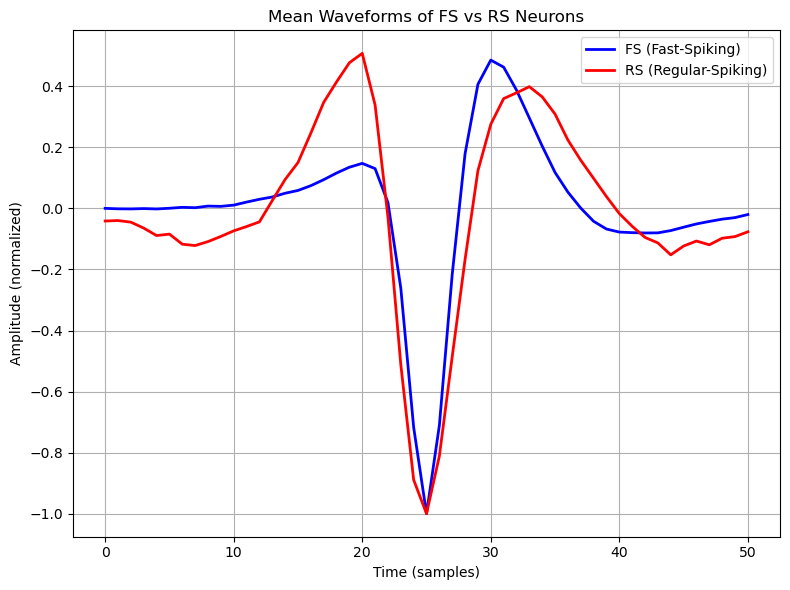

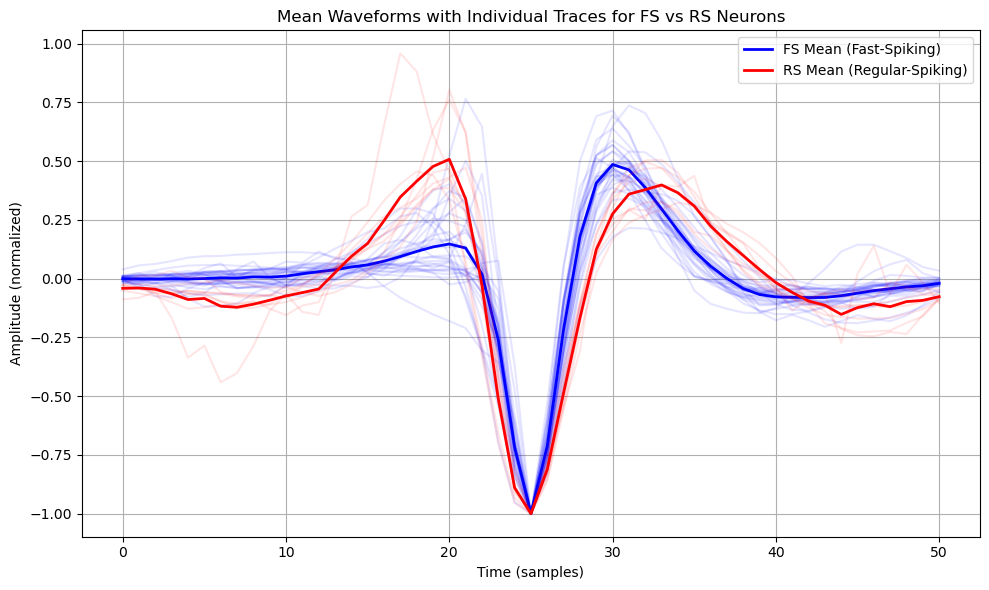

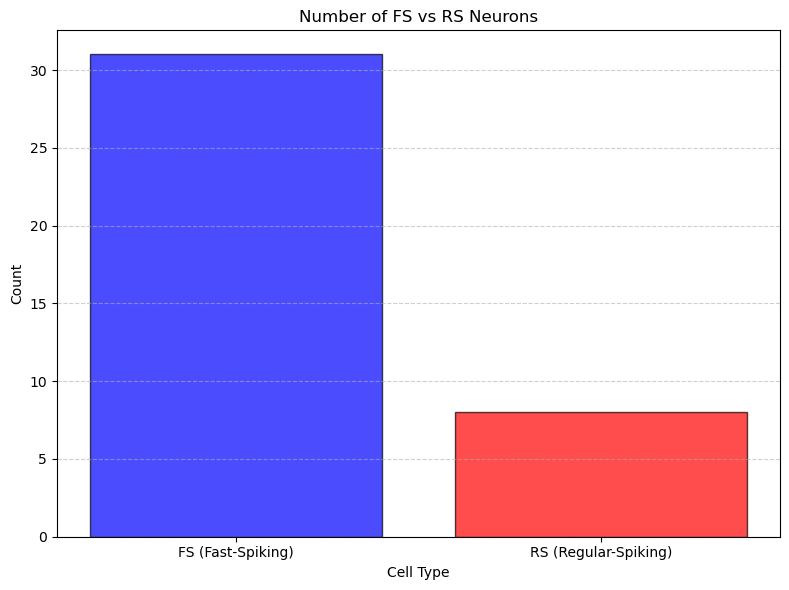

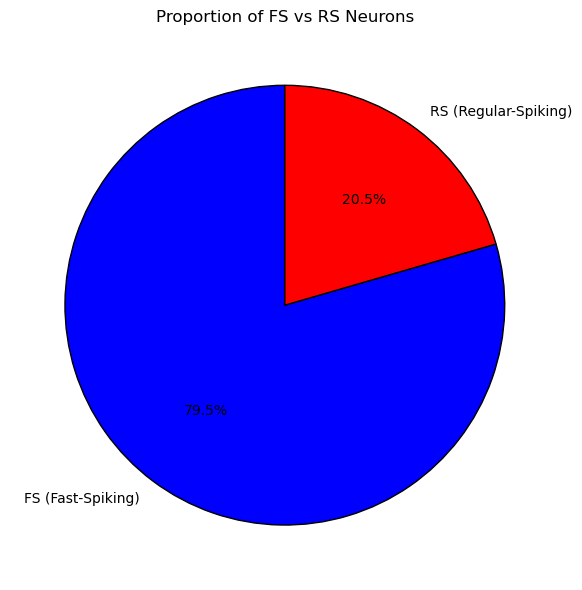

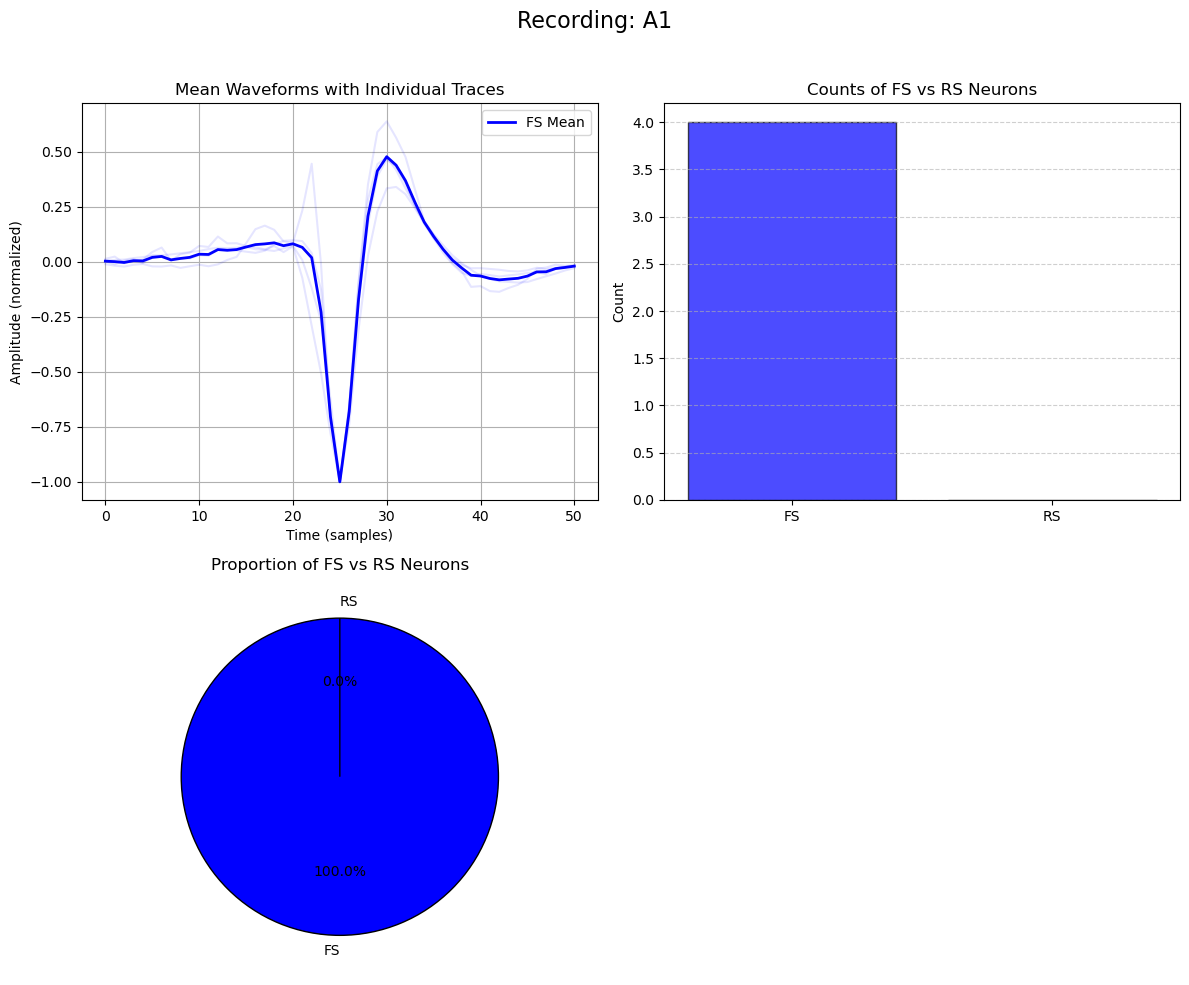

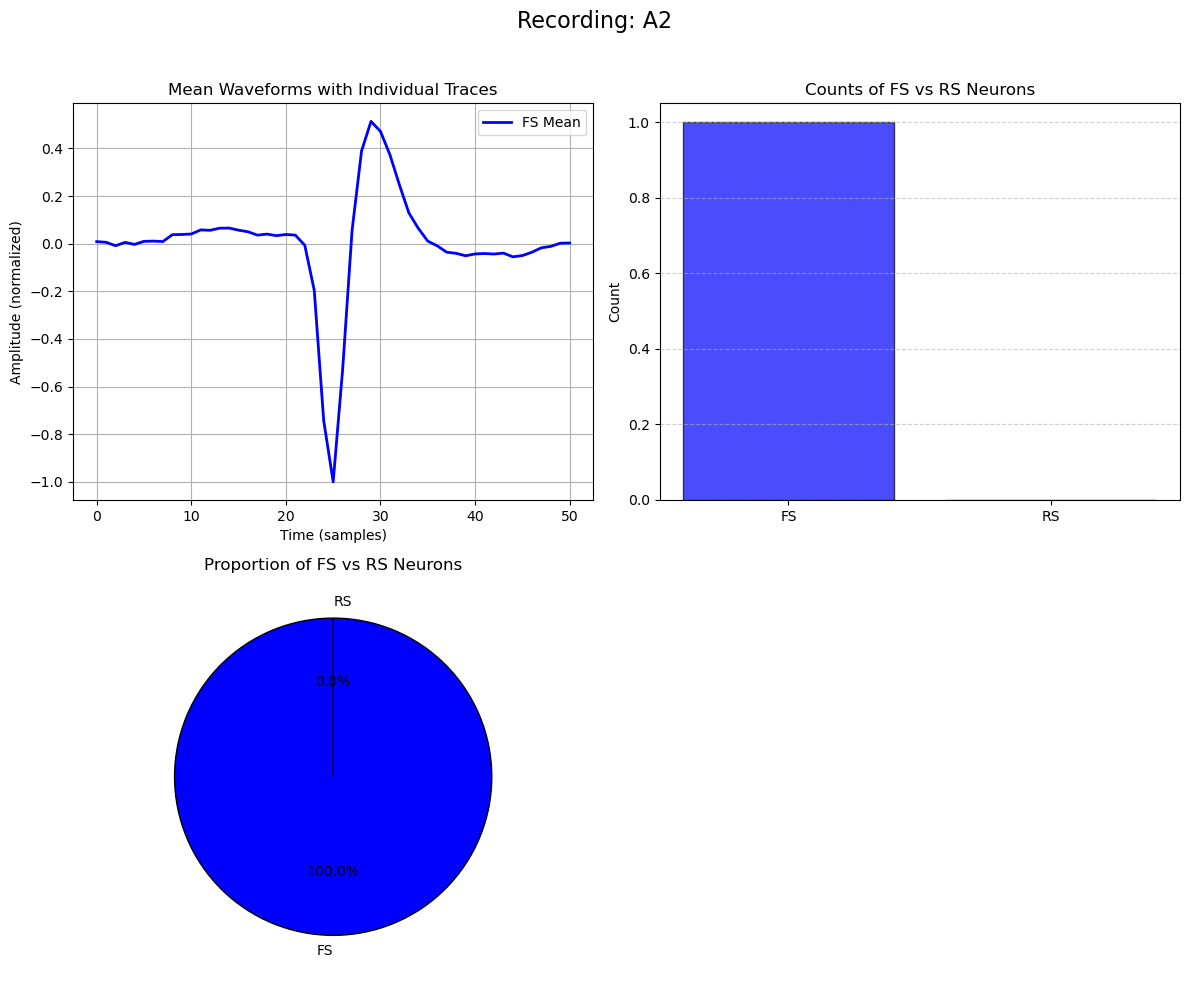

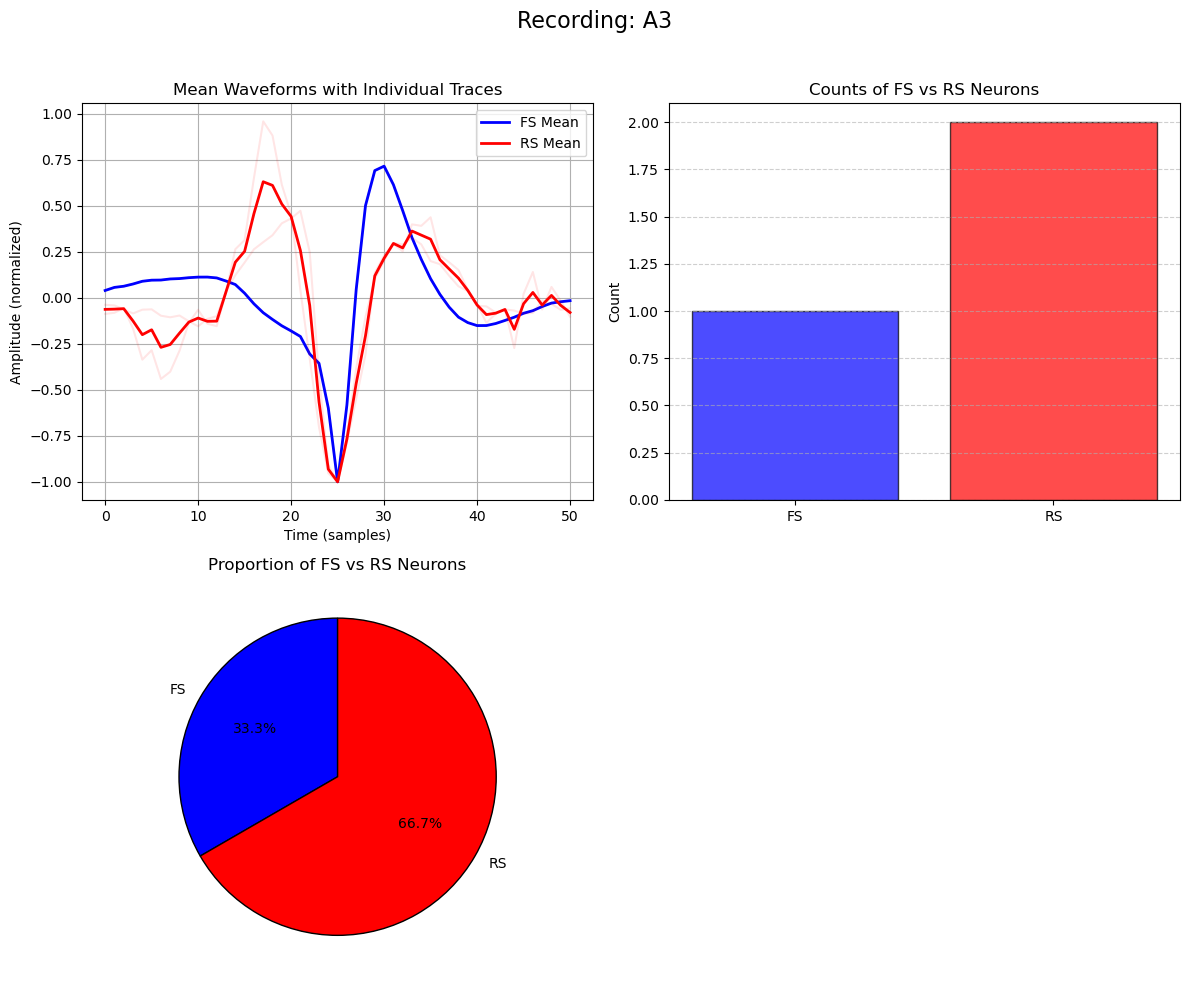

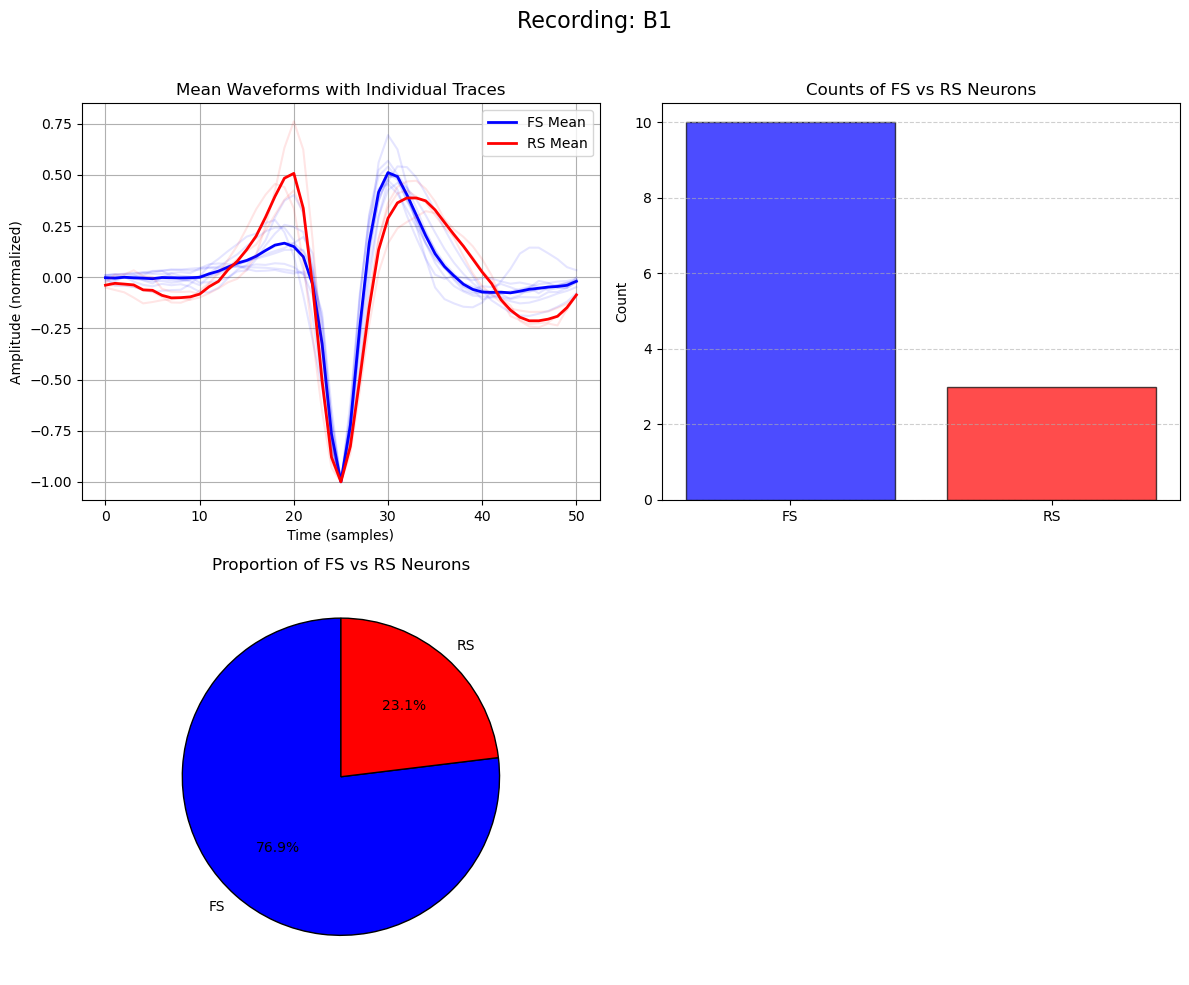

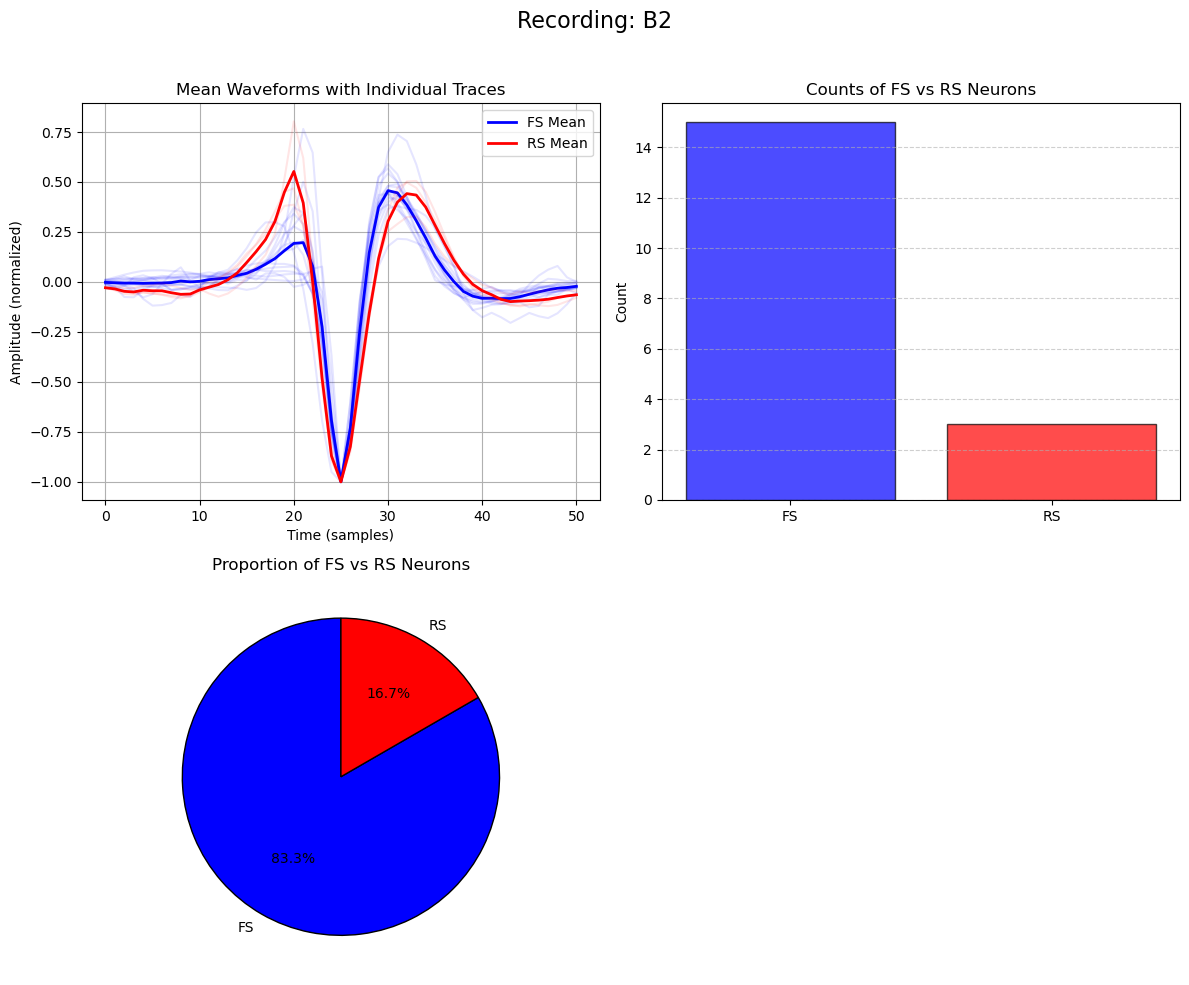

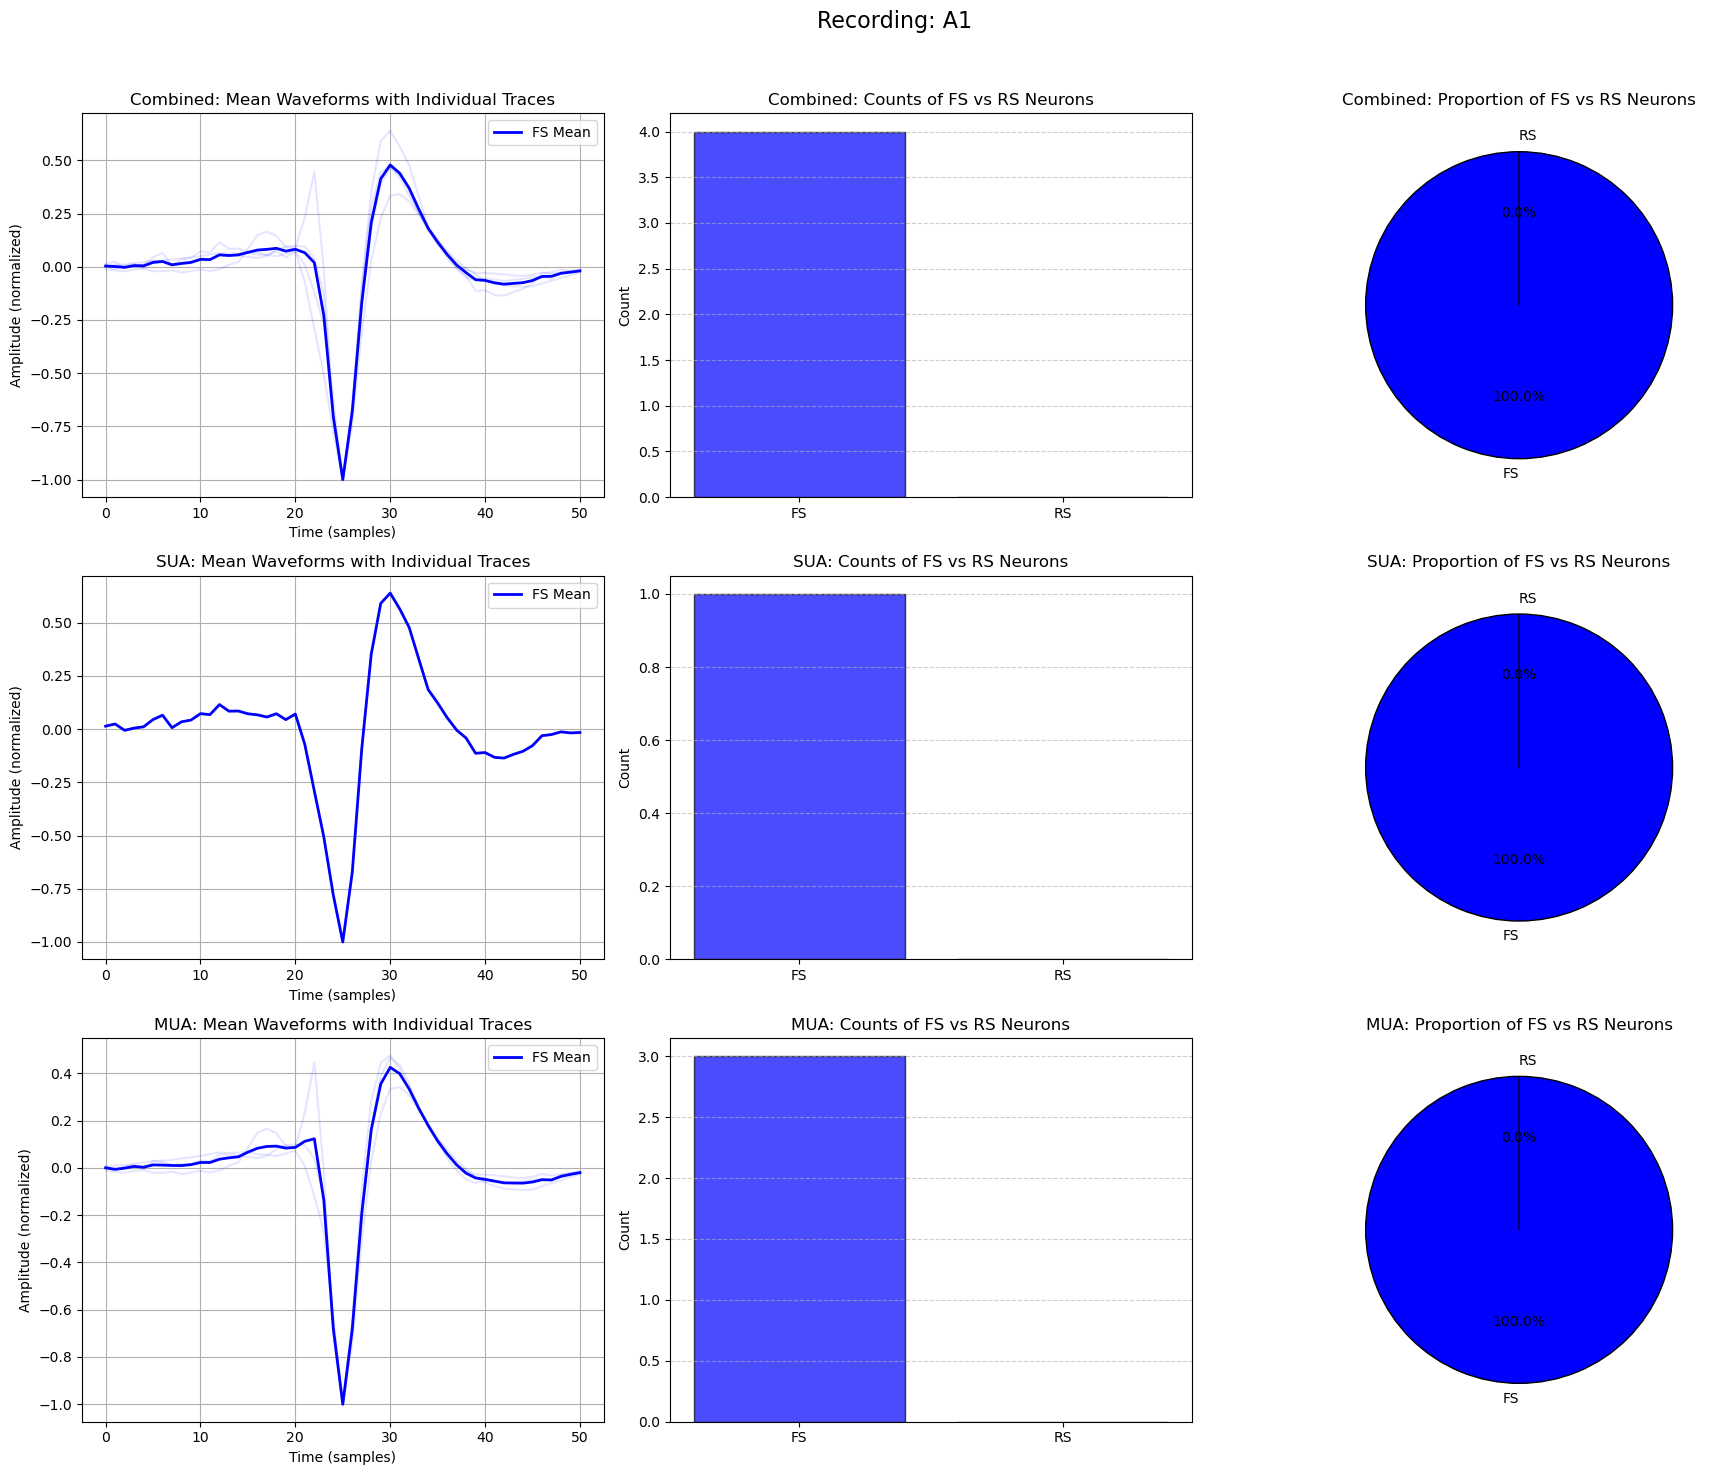

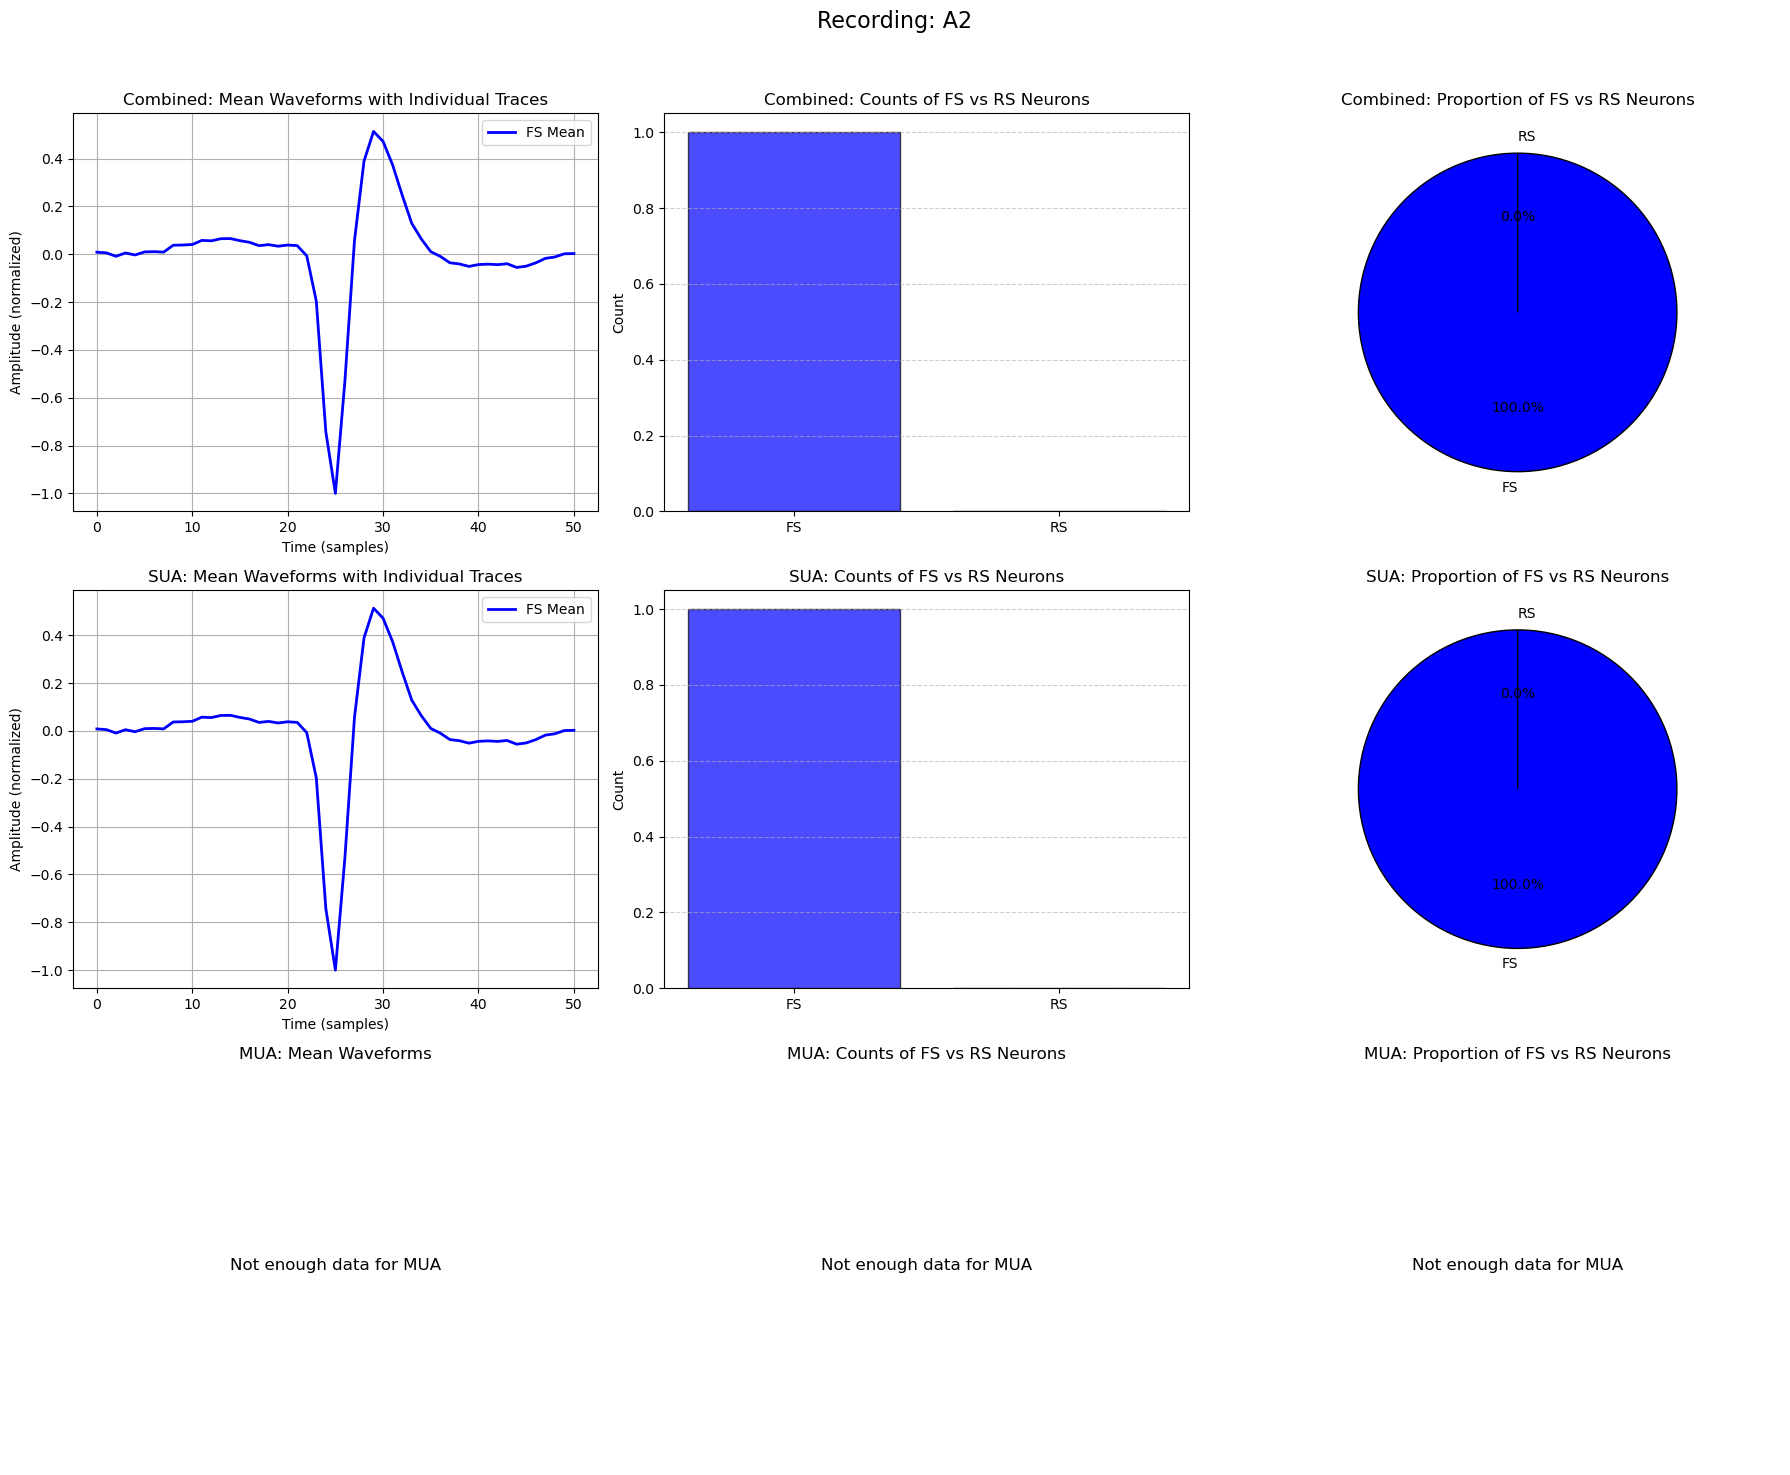

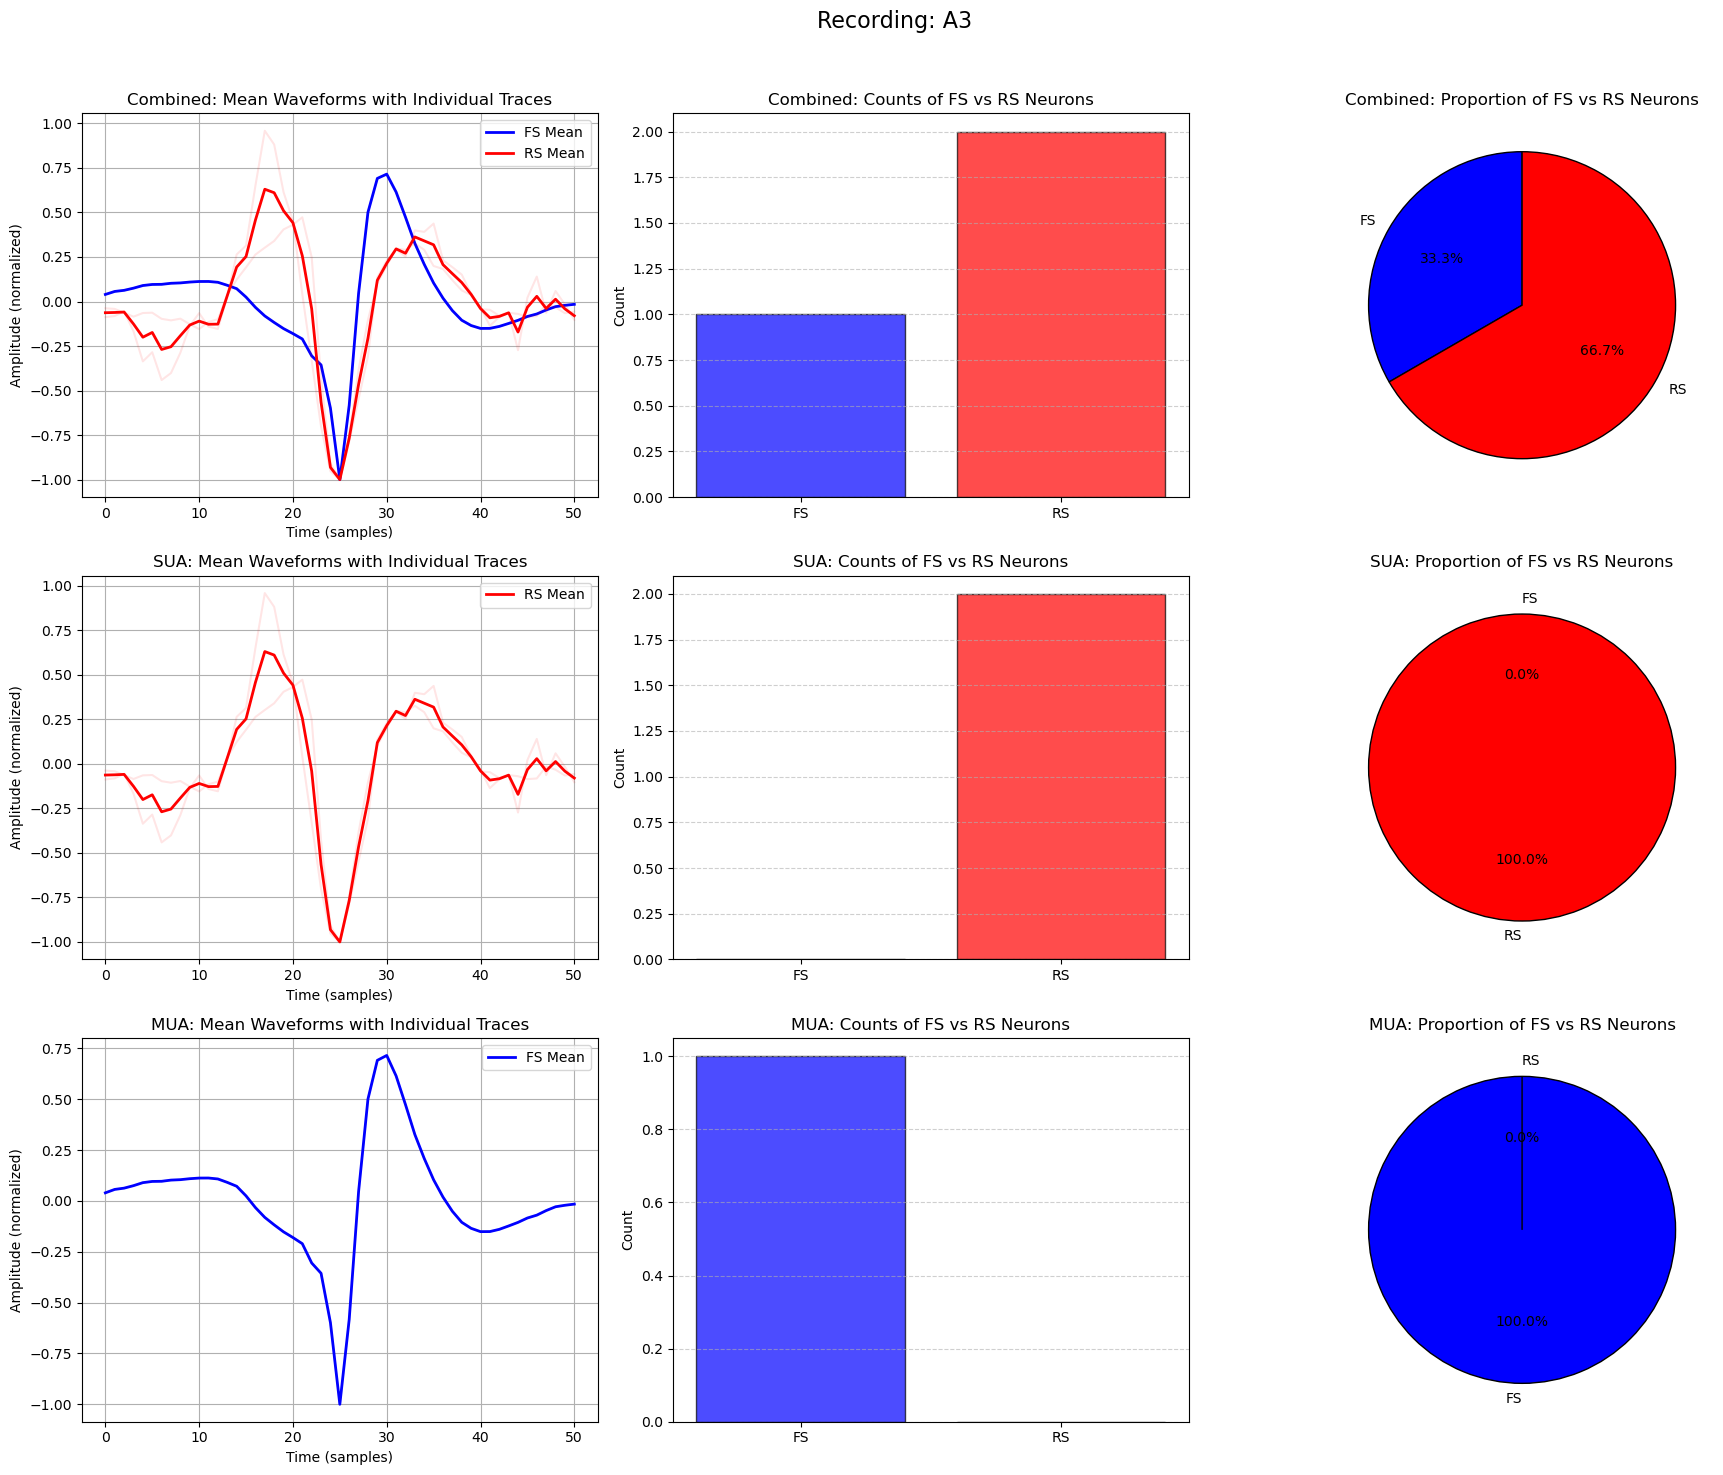

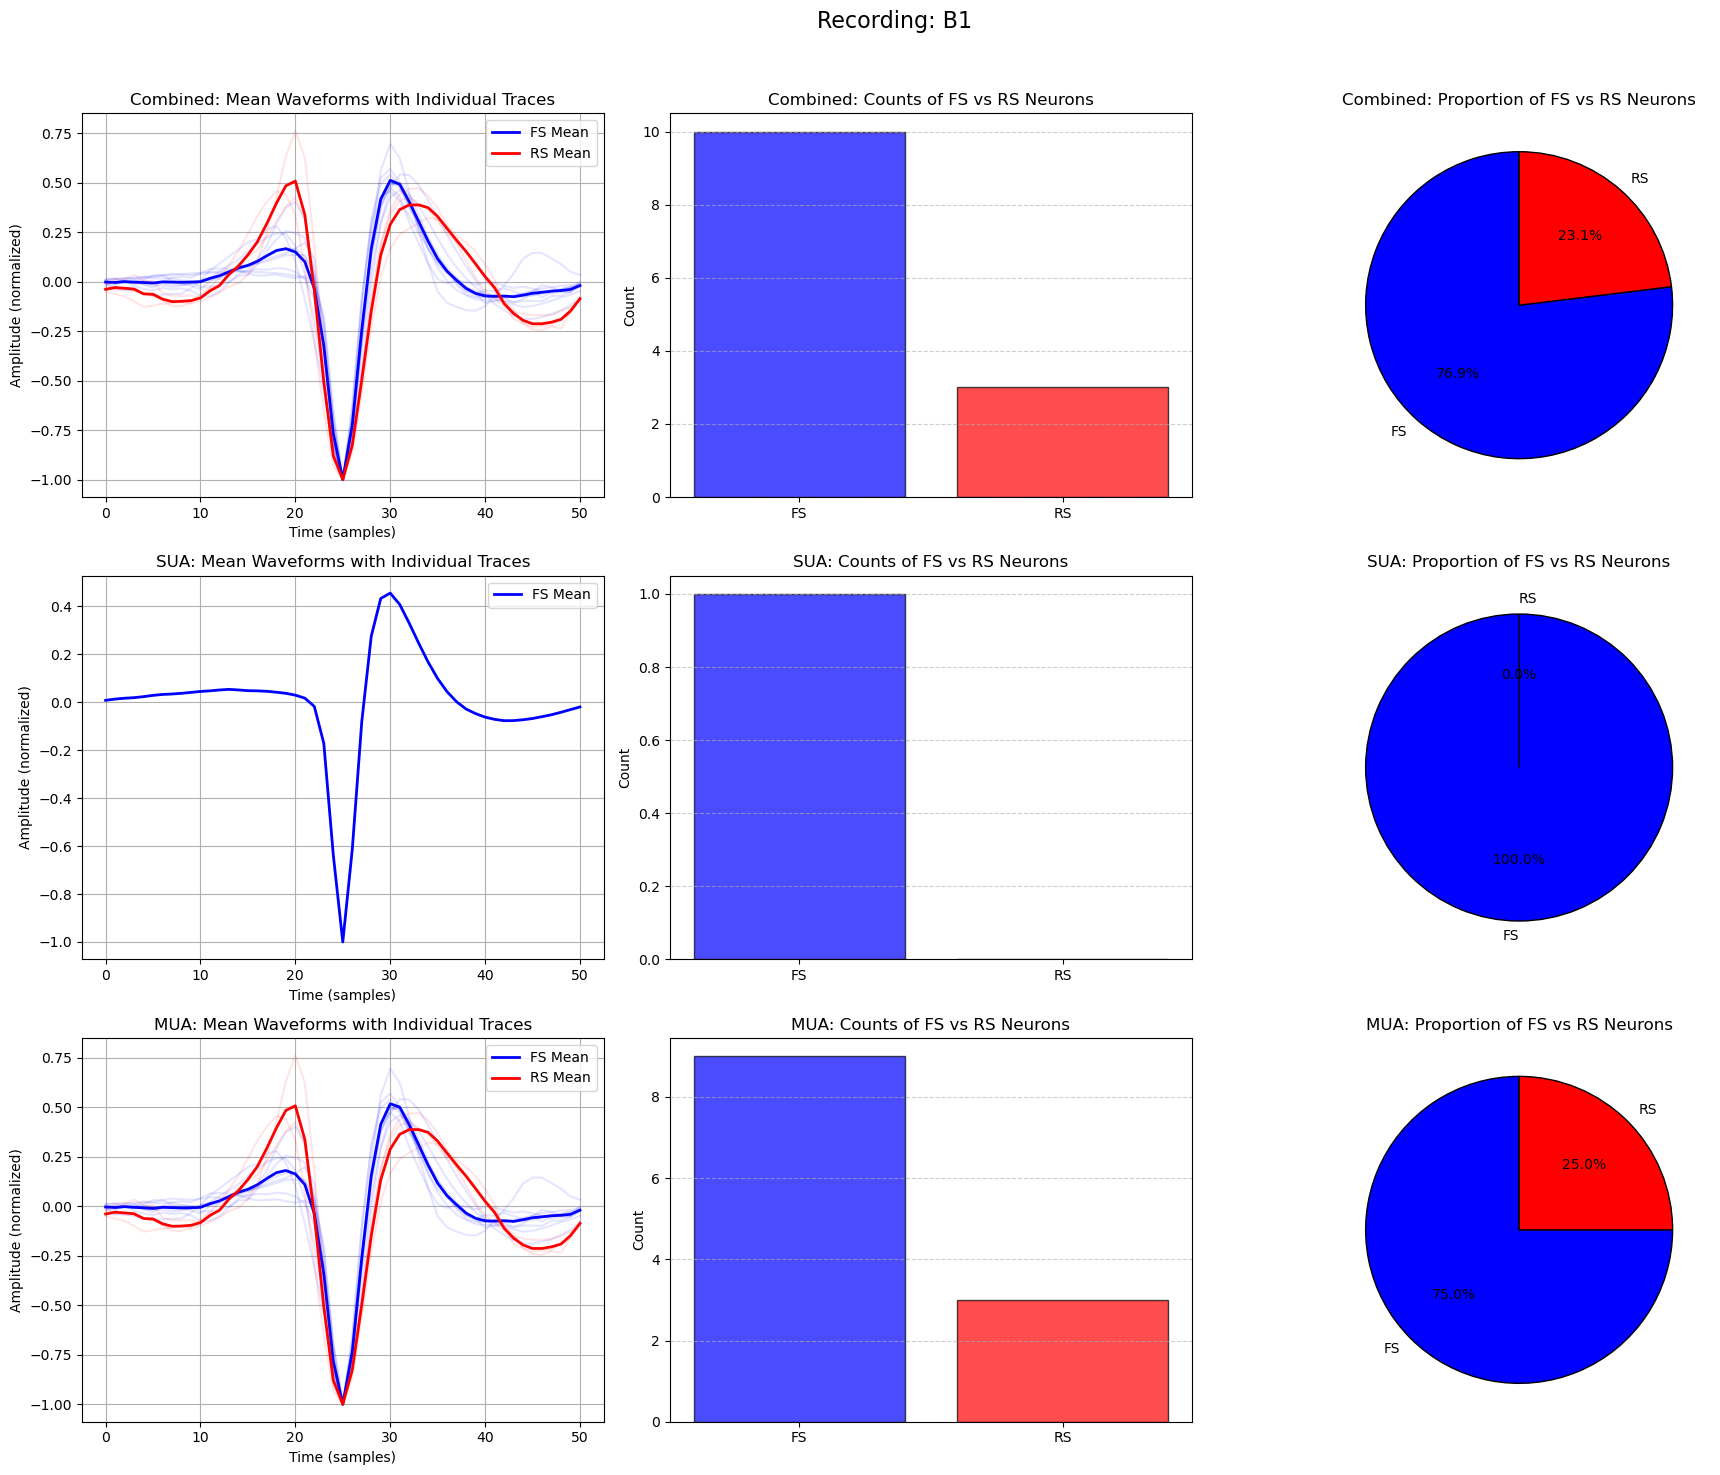

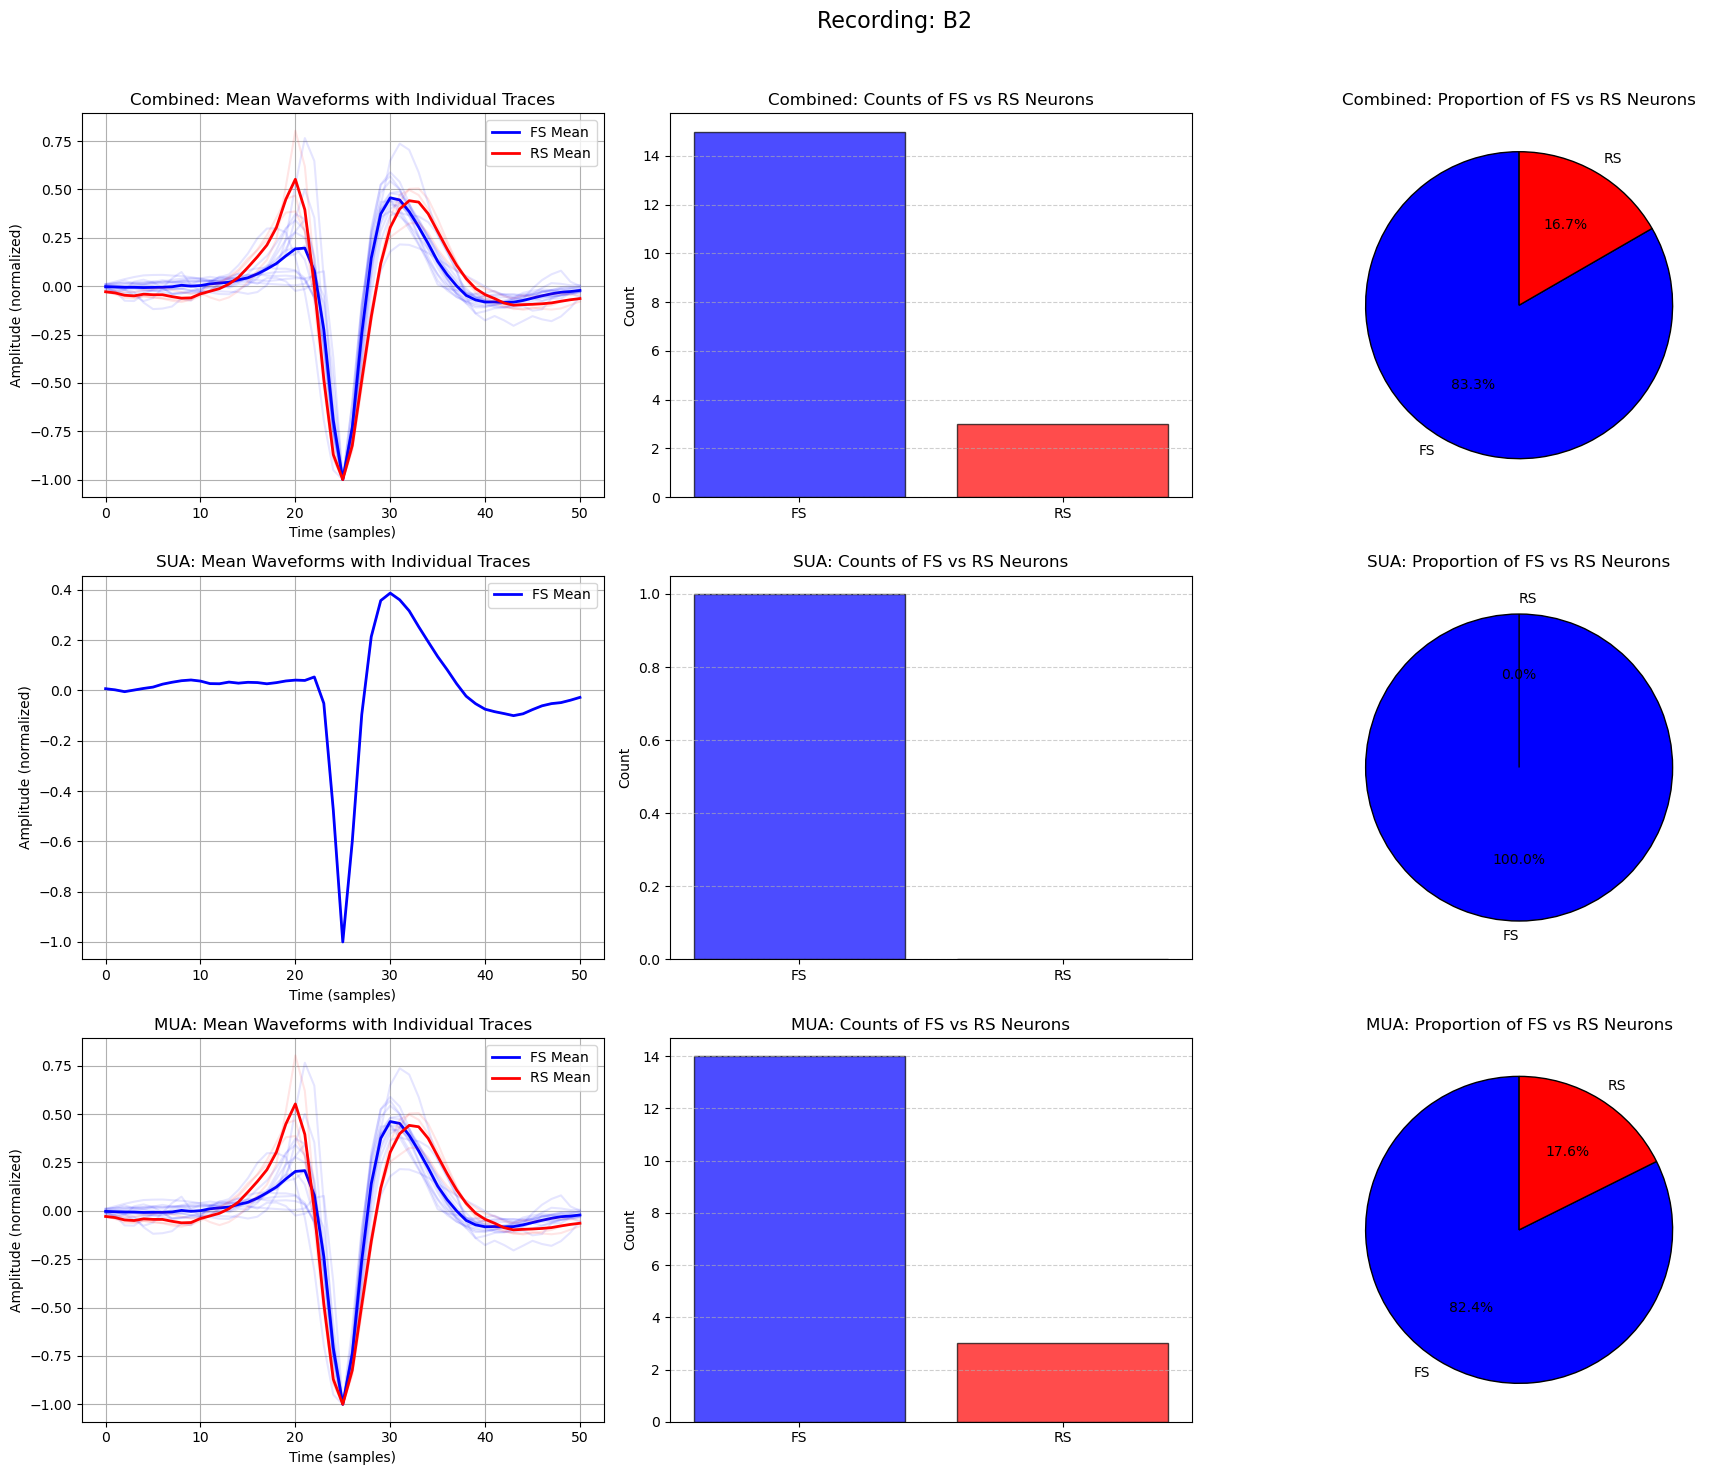

In [12]:
# Assuming organoid_database is the cleaned DataFrame
plotter = DataFrameManagerAxionMEA_Plotter(organoid_database)

# Plot the mean waveforms for FS and RS neurons
plotter.plot_mean_waveforms()
plotter.plot_mean_waveforms_with_individual_traces()
plotter.plot_cell_type_counts()
plotter.plot_composite_per_recording()
plotter.plot_composite_per_recording_with_sua_mua()

Sorted FS Data: [array(0.32), array(0.4), array(0.4), array(0.4), array(0.4), array(0.4), array(0.4), array(0.4), array(0.4), array(0.4), array(0.4), array(0.4), array(0.4), array(0.4), array(0.4), array(0.4), array(0.4), array(0.4), array(0.4), array(0.4), array(0.4), array(0.48), array(0.48), array(0.48), array(0.48), array(0.48), array(0.48), array(0.48), array(0.48), array(0.48), array(0.48)]
Sorted RS Data: [array(0.56), array(0.56), array(0.64), array(0.64), array(0.64), array(0.64), array(0.72), array(0.8)]
New Bin Edges: [0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42 0.43 0.44 0.45
 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59
 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73
 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81]
FS Counts: [ 1  0  0  0  0  0  0 20  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]
RS Counts: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

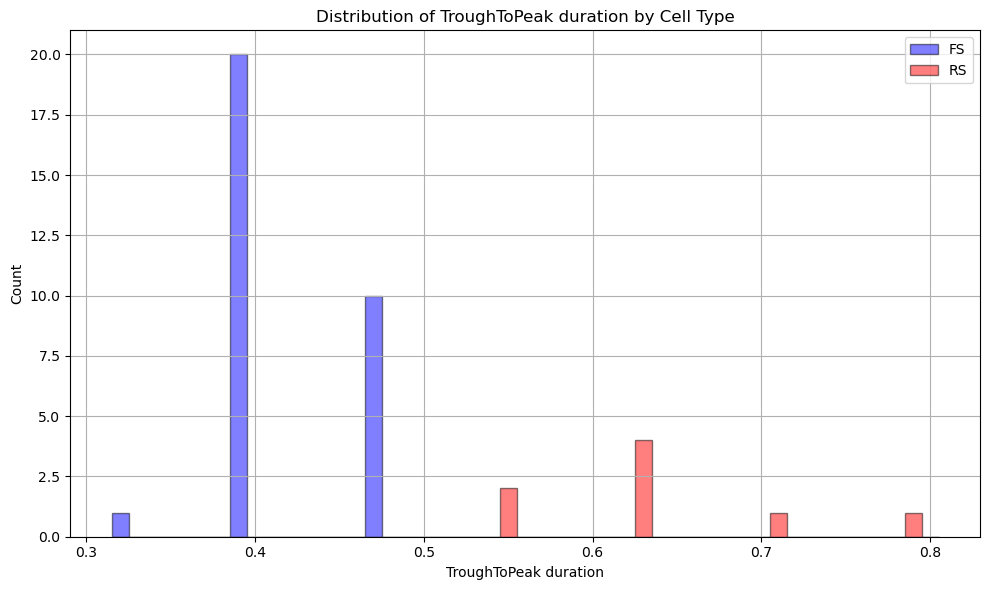

In [13]:
# plotter.calculate_firing_rate(groupname='Organoids', recordingname='A1', cid='cid33') not used

# plot with debug info
plotter.plot_distribution_stairs("TroughToPeak_duration", bins=None, plot_type="bar", debug=True)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os

def plot_psth_per_cid_with_metadata(df, bin_size_seconds=1.0, output_dir=None):
    """
    Plots PSTHs for each CID separately, including metadata and color-coded by cell type,
    and saves them as a multipage PDF.

    Args:
        df (pd.DataFrame): DataFrame containing spike data and metadata.
        bin_size_seconds (float): Size of each bin in seconds. Default is 1.0 second.
        output_dir (str): Directory to save the PDF. If None, raises an error.

    Returns:
        None
    """
    # Validate required columns
    required_columns = ['groupname', 'recordingname', 'cid', 'Cell_Type', 'IsSingleUnit',
                        'SpikeTimes_all', 'Recording_Duration', 'Sampling_Frequency']
    for column in required_columns:
        if column not in df.columns:
            raise ValueError(f"The DataFrame must contain the '{column}' column.")

    if not output_dir:
        raise ValueError("You must specify an output directory for saving PDFs.")

    # Group by groupname and recordingname
    grouped = df.groupby(['groupname', 'recordingname'])

    for (groupname, recordingname), group_data in grouped:
        # Create output directory
        save_dir = os.path.join(output_dir, groupname)
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'{recordingname}_PSTHs.pdf')

        # Use PdfPages to create a multipage PDF
        with PdfPages(save_path) as pdf:
            for _, row in group_data.iterrows():
                # Extract metadata
                cid = row['cid']
                cell_type = row['Cell_Type']
                is_single_unit = row['IsSingleUnit']
                spike_times_samples = row['SpikeTimes_all']
                recording_duration_seconds = row['Recording_Duration']
                sampling_frequency_hz = row['Sampling_Frequency']

                # Handle missing or invalid data
                if not isinstance(spike_times_samples, np.ndarray):
                    print(f"Skipping CID {cid} due to missing spike data.")
                    continue

                # Convert spike times to seconds
                spike_times_seconds = spike_times_samples / sampling_frequency_hz

                # Compute PSTH
                bin_edges = np.arange(0, recording_duration_seconds + bin_size_seconds, bin_size_seconds)
                psth, _ = np.histogram(spike_times_seconds, bins=bin_edges)

                # Determine color based on Cell_Type
                color = 'blue' if cell_type == 'FS' else 'red'

                # Convert single-unit status to string
                single_unit_str = 'SUA' if is_single_unit else 'MUA'

                # Create a figure for this CID
                fig, ax = plt.subplots(figsize=(8, 6))
                ax.bar(bin_edges[:-1], psth, width=bin_size_seconds, edgecolor='black', alpha=0.7, color=color)
                ax.set_title(f'CID: {cid} | Cell Type: {cell_type} | {single_unit_str}\n'
                             f'Recording: {recordingname}, Group: {groupname}', fontsize=10)
                ax.set_xlabel('Time (s)', fontsize=8)
                ax.set_ylabel('Spike Count', fontsize=8)
                ax.set_xlim(0, recording_duration_seconds)
                ax.tick_params(axis='both', labelsize=8)

                # Add the figure to the PDF
                pdf.savefig(fig)
                plt.close(fig)

            print(f"Saved PSTHs for recording '{recordingname}' in group '{groupname}' to {save_path}.")

# Example usage
plot_psth_per_cid_with_metadata(
    df=plotter.df, 
    bin_size_seconds=1.0, 
    output_dir='/Volumes/Manny2TB/'
)

Saved PSTHs for recording 'A1' in group 'Organoids_NoBic' to /Volumes/Manny2TB/Organoids_NoBic/A1_PSTHs.pdf.
Saved PSTHs for recording 'A2' in group 'Organoids_NoBic' to /Volumes/Manny2TB/Organoids_NoBic/A2_PSTHs.pdf.
Saved PSTHs for recording 'A3' in group 'Organoids_NoBic' to /Volumes/Manny2TB/Organoids_NoBic/A3_PSTHs.pdf.
Saved PSTHs for recording 'B1' in group 'Organoids_NoBic' to /Volumes/Manny2TB/Organoids_NoBic/B1_PSTHs.pdf.
Saved PSTHs for recording 'B2' in group 'Organoids_NoBic' to /Volumes/Manny2TB/Organoids_NoBic/B2_PSTHs.pdf.


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os


def plot_psth_per_cid_with_metadata(df, bin_size_seconds=1.0, output_dir=None):
    """
    Plots PSTHs for each CID separately, including metadata and color-coded by cell type,
    and saves them as a multipage PDF with mean firing rate, SD, and max spike count.

    Args:
        df (pd.DataFrame): DataFrame containing spike data and metadata.
        bin_size_seconds (float): Size of each bin in seconds. Default is 1.0 second.
        output_dir (str): Directory to save the PDF. If None, raises an error.

    Returns:
        None
    """
    # Validate required columns
    required_columns = ['groupname', 'recordingname', 'cid', 'Cell_Type', 'IsSingleUnit',
                        'SpikeTimes_all', 'Recording_Duration', 'Sampling_Frequency']
    for column in required_columns:
        if column not in df.columns:
            raise ValueError(f"The DataFrame must contain the '{column}' column.")

    if not output_dir:
        raise ValueError("You must specify an output directory for saving PDFs.")

    # Group by groupname and recordingname
    grouped = df.groupby(['groupname', 'recordingname'])

    for (groupname, recordingname), group_data in grouped:
        # Create output directory
        save_dir = os.path.join(output_dir, groupname)
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'{recordingname}_PSTHs_with_stats.pdf')

        # Use PdfPages to create a multipage PDF
        with PdfPages(save_path) as pdf:
            for _, row in group_data.iterrows():
                # Extract metadata
                cid = row['cid']
                cell_type = row['Cell_Type']
                is_single_unit = row['IsSingleUnit']
                spike_times_samples = row['SpikeTimes_all']
                recording_duration_seconds = row['Recording_Duration']
                sampling_frequency_hz = row['Sampling_Frequency']

                # Handle missing or invalid data
                if not isinstance(spike_times_samples, np.ndarray):
                    print(f"Skipping CID {cid} due to missing spike data.")
                    continue

                # Convert spike times to seconds
                spike_times_seconds = spike_times_samples / sampling_frequency_hz

                # Compute PSTH
                bin_edges = np.arange(0, recording_duration_seconds + bin_size_seconds, bin_size_seconds)
                psth, _ = np.histogram(spike_times_seconds, bins=bin_edges)

                # Compute statistics
                mean_firing_rate = np.mean(psth) / bin_size_seconds  # Mean firing rate in Hz
                sd_firing_rate = np.std(psth) / bin_size_seconds  # SD of firing rate in Hz
                max_spike_count = np.max(psth)  # Max spike count across bins

                # Determine color based on Cell_Type
                color = 'blue' if cell_type == 'FS' else 'red'

                # Convert single-unit status to string
                single_unit_str = 'SUA' if is_single_unit else 'MUA'

                # Create a figure for this CID
                fig, ax = plt.subplots(figsize=(8, 6))
                ax.bar(bin_edges[:-1], psth, width=bin_size_seconds, edgecolor='black', alpha=0.7, color=color, label='PSTH')
                ax.axhline(y=mean_firing_rate * bin_size_seconds, color='green', linestyle='-', label=f'Mean ({mean_firing_rate:.2f} Hz)')
                # Add a vertical line for the maximum spike count
                max_bin_time = bin_edges[np.argmax(psth)]
                ax.axvline(x=max_bin_time, color='purple', linestyle='--', label=f'Max Spike Count ({max_spike_count})')

                # Set plot details
                ax.set_title(f'CID: {cid} | Cell Type: {cell_type} | {single_unit_str}\n'
                             f'Recording: {recordingname}, Group: {groupname}\n'
                             f'Mean Firing Rate: {mean_firing_rate:.2f} Hz | SD: {sd_firing_rate:.2f} Hz | Max Spike Count: {max_spike_count}',
                             fontsize=10)
                ax.set_xlabel('Time (s)', fontsize=8)
                ax.set_ylabel('Spike Count', fontsize=8)
                ax.set_xlim(0, recording_duration_seconds)
                ax.tick_params(axis='both', labelsize=8)

                # Add a legend
                ax.legend(fontsize=8)

                # Add the figure to the PDF
                pdf.savefig(fig)
                plt.close(fig)

            print(f"Saved PSTHs with statistics for recording '{recordingname}' in group '{groupname}' to {save_path}.")

            
plot_psth_per_cid_with_metadata(
    df=plotter.df, 
    bin_size_seconds=1.0, 
    output_dir='/Volumes/Manny2TB/'
)     


Saved PSTHs with statistics for recording 'A1' in group 'Organoids_NoBic' to /Volumes/Manny2TB/Organoids_NoBic/A1_PSTHs_with_stats.pdf.
Saved PSTHs with statistics for recording 'A2' in group 'Organoids_NoBic' to /Volumes/Manny2TB/Organoids_NoBic/A2_PSTHs_with_stats.pdf.
Saved PSTHs with statistics for recording 'A3' in group 'Organoids_NoBic' to /Volumes/Manny2TB/Organoids_NoBic/A3_PSTHs_with_stats.pdf.
Saved PSTHs with statistics for recording 'B1' in group 'Organoids_NoBic' to /Volumes/Manny2TB/Organoids_NoBic/B1_PSTHs_with_stats.pdf.
Saved PSTHs with statistics for recording 'B2' in group 'Organoids_NoBic' to /Volumes/Manny2TB/Organoids_NoBic/B2_PSTHs_with_stats.pdf.


In [16]:
def plot_line_psth_per_cid_with_metadata(df, bin_size_seconds=1.0, output_dir=None):
    """
    Plots line plots of PSTHs for each CID separately, including metadata and color-coded by cell type,
    and saves them as a multipage PDF with mean firing rate, SD, and max firing rate.

    Args:
        df (pd.DataFrame): DataFrame containing spike data and metadata.
        bin_size_seconds (float): Size of each bin in seconds. Default is 1.0 second.
        output_dir (str): Directory to save the PDF. If None, raises an error.

    Returns:
        None
    """
    # Validate required columns
    required_columns = ['groupname', 'recordingname', 'cid', 'Cell_Type', 'IsSingleUnit',
                        'SpikeTimes_all', 'Recording_Duration', 'Sampling_Frequency']
    for column in required_columns:
        if column not in df.columns:
            raise ValueError(f"The DataFrame must contain the '{column}' column.")

    if not output_dir:
        raise ValueError("You must specify an output directory for saving PDFs.")

    # Group by groupname and recordingname
    grouped = df.groupby(['groupname', 'recordingname'])

    for (groupname, recordingname), group_data in grouped:
        # Create output directory
        save_dir = os.path.join(output_dir, groupname)
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'{recordingname}_LinePlots_with_stats.pdf')

        # Use PdfPages to create a multipage PDF
        with PdfPages(save_path) as pdf:
            for _, row in group_data.iterrows():
                # Extract metadata
                cid = row['cid']
                cell_type = row['Cell_Type']
                is_single_unit = row['IsSingleUnit']
                spike_times_samples = row['SpikeTimes_all']
                recording_duration_seconds = row['Recording_Duration']
                sampling_frequency_hz = row['Sampling_Frequency']

                # Handle missing or invalid data
                if not isinstance(spike_times_samples, np.ndarray):
                    print(f"Skipping CID {cid} due to missing spike data.")
                    continue

                # Convert spike times to seconds
                spike_times_seconds = spike_times_samples / sampling_frequency_hz

                # Compute PSTH
                bin_edges = np.arange(0, recording_duration_seconds + bin_size_seconds, bin_size_seconds)
                psth, _ = np.histogram(spike_times_seconds, bins=bin_edges)
                time_bins = bin_edges[:-1] + bin_size_seconds / 2  # Midpoints of bins

                # Compute statistics
                mean_firing_rate = np.mean(psth) / bin_size_seconds  # Mean firing rate in Hz
                sd_firing_rate = np.std(psth) / bin_size_seconds  # SD of firing rate in Hz
                max_firing_rate = np.max(psth) / bin_size_seconds  # Max firing rate in Hz
                max_firing_rate_time = time_bins[np.argmax(psth)]  # Time of max firing rate

                # Determine color based on Cell_Type
                color = 'blue' if cell_type == 'FS' else 'red'

                # Convert single-unit status to string
                single_unit_str = 'SUA' if is_single_unit else 'MUA'

                # Create a figure for this CID
                fig, ax = plt.subplots(figsize=(8, 6))
                ax.plot(time_bins, psth / bin_size_seconds, color=color, label='Firing Rate (Hz)', linewidth=1.5)
                ax.axhline(y=mean_firing_rate, color='green', linestyle='-', label=f'Mean ({mean_firing_rate:.2f} Hz)')
                # Add a vertical line for the maximum firing rate
                ax.axvline(x=max_firing_rate_time, color='purple', linestyle='--', label=f'Max Rate ({max_firing_rate:.2f} Hz)')

                # Set plot details
                ax.set_title(f'CID: {cid} | Cell Type: {cell_type} | {single_unit_str}\n'
                             f'Recording: {recordingname}, Group: {groupname}\n'
                             f'Mean Firing Rate: {mean_firing_rate:.2f} Hz | SD: {sd_firing_rate:.2f} Hz | Max Rate: {max_firing_rate:.2f} Hz',
                             fontsize=10)
                ax.set_xlabel('Time (s)', fontsize=8)
                ax.set_ylabel('Firing Rate (Hz)', fontsize=8)
                ax.set_xlim(0, recording_duration_seconds)
                ax.tick_params(axis='both', labelsize=8)

                # Add a legend
                ax.legend(fontsize=8)

                # Add the figure to the PDF
                pdf.savefig(fig)
                plt.close(fig)

            print(f"Saved line plots with statistics for recording '{recordingname}' in group '{groupname}' to {save_path}.")

          
plot_line_psth_per_cid_with_metadata(
    df=plotter.df, 
    bin_size_seconds=1.0, 
    output_dir='/Volumes/Manny2TB/'
)    

Saved line plots with statistics for recording 'A1' in group 'Organoids_NoBic' to /Volumes/Manny2TB/Organoids_NoBic/A1_LinePlots_with_stats.pdf.
Saved line plots with statistics for recording 'A2' in group 'Organoids_NoBic' to /Volumes/Manny2TB/Organoids_NoBic/A2_LinePlots_with_stats.pdf.
Saved line plots with statistics for recording 'A3' in group 'Organoids_NoBic' to /Volumes/Manny2TB/Organoids_NoBic/A3_LinePlots_with_stats.pdf.
Saved line plots with statistics for recording 'B1' in group 'Organoids_NoBic' to /Volumes/Manny2TB/Organoids_NoBic/B1_LinePlots_with_stats.pdf.
Saved line plots with statistics for recording 'B2' in group 'Organoids_NoBic' to /Volumes/Manny2TB/Organoids_NoBic/B2_LinePlots_with_stats.pdf.


In [17]:
def add_psth_trace_to_df(df, bin_size_seconds=1.0):
    """
    Computes the PSTH trace for each row in the DataFrame and adds it as a new column.

    Args:
        df (pd.DataFrame): DataFrame containing spike data and metadata.
        bin_size_seconds (float): Size of each bin in seconds. Default is 1.0 second.

    Returns:
        pd.DataFrame: Updated DataFrame with a new column 'PSTH_Trace' containing the PSTH arrays.
    """
    # Validate required columns
    required_columns = ['SpikeTimes_all', 'Recording_Duration', 'Sampling_Frequency']
    for column in required_columns:
        if column not in df.columns:
            raise ValueError(f"The DataFrame must contain the '{column}' column.")

    # Function to compute the PSTH trace
    def compute_psth_trace(row):
        spike_times_samples = row['SpikeTimes_all']
        recording_duration_seconds = row['Recording_Duration']
        sampling_frequency_hz = row['Sampling_Frequency']

        # Handle missing or invalid data
        if not isinstance(spike_times_samples, np.ndarray):
            return np.array([])  # Return an empty array if data is missing

        # Convert spike times to seconds
        spike_times_seconds = spike_times_samples / sampling_frequency_hz

        # Compute PSTH
        bin_edges = np.arange(0, recording_duration_seconds + bin_size_seconds, bin_size_seconds)
        psth, _ = np.histogram(spike_times_seconds, bins=bin_edges)

        # Normalize to firing rate (Hz)
        return psth / bin_size_seconds

    # Apply the function to compute PSTH traces
    df['PSTH_Trace'] = df.apply(compute_psth_trace, axis=1)

    return df

add_psth_trace_to_df(df=plotter.df, bin_size_seconds=1.0)


,groupname,recordingname,cid,Cell_Type,IsSingleUnit,Amplitude,SpikeTimes_all,Template_Channel,Normalized_Template_Waveform,TroughToPeak_duration,SpikeHalfWidth,UnNormalized_Template_Waveform,ISI_violations_percent,Recording_Duration,Sampling_Frequency,PSTH_Trace
0,Organoids_NoBic,A1,cid10,FS,False,1039.7176781002638,"[3079.0, 11446.0, 15466.0, 28045.0, 33296.0, 4...",27.0,"[0.003378831160597054, -0.011134263187016376, ...",0.4,0.06666666666666667,"[5.591029023746702, -9.986807387862797, 7.4116...",0.26455026455026454,299.75,12500.0,"[2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, ..."
1,Organoids_NoBic,A1,cid11,FS,False,1128.6147540983607,"[1116.0, 3273.0, 5327.0, 6844.0, 9016.0, 12112...",35.0,"[-0.01054808233281021, -0.01703060776461306, -...",0.48,0.1,"[-13.892418032786885, -17.644467213114755, -19...",0.41025641025641024,299.75,12500.0,"[6.0, 2.0, 5.0, 7.0, 5.0, 4.0, 4.0, 5.0, 7.0, ..."
2,Organoids_NoBic,A1,cid6,FS,True,924.0849673202614,"[91.0, 32386.0, 55102.0, 106165.0, 143705.0, 1...",37.0,"[0.013876881897738873, 0.024193081217701865, -...",0.4,0.1,"[8.032679738562091, 16.65359477124183, -12.823...",0.0,299.75,12500.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."
3,Organoids_NoBic,A1,cid9,FS,False,1691.3572767020612,"[9520.0, 19570.0, 19670.0, 19743.0, 19848.0, 1...",36.0,"[0.006941716972100502, 0.009021211261683043, 0...",0.4,0.06666666666666667,"[3.270455965021861, 6.276702061211743, 8.10555...",0.625,299.75,12500.0,"[1.0, 17.0, 1.0, 1.0, 1.0, 1.0, 1.0, 14.0, 8.0..."
4,Organoids_NoBic,A2,cid7,FS,True,1273.195,"[6425.0, 6516.0, 32497.0, 58709.0, 58815.0, 94...",27.0,"[0.008604803671528195, 0.005690266361714141, -...",0.32,0.06666666666666667,"[21.5075, 14.825, -6.7025, 8.13, -5.8175, 7.61...",0.0,299.75,12500.0,"[2.0, 0.0, 1.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, ..."
5,Organoids_NoBic,A3,cid0,RS,True,766.3636363636364,"[247453.0, 487806.0, 627906.0, 1108291.0, 1224...",14.0,"[-0.08786435487336866, -0.08153806914726576, -...",0.8,0.16666666666666666,"[2.8181818181818183, 16.454545454545453, 41.90...",0.0,299.75,12500.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,Organoids_NoBic,A3,cid3,FS,False,1706.0165975103735,"[35313.0, 35388.0, 35411.0, 35573.0, 35619.0, ...",32.0,"[0.03969365922062013, 0.0565135824157954, 0.06...",0.4,0.06666666666666667,"[10.58298755186722, 31.703319502074688, 34.840...",5.8212058212058215,299.75,12500.0,"[0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 1.0, 17.0,..."
7,Organoids_NoBic,A3,cid4,RS,True,1012.1475409836065,"[125519.0, 189613.0, 369327.0, 439744.0, 50892...",29.0,"[-0.0379523213114639, -0.041538938571048636, -...",0.64,0.13333333333333333,"[1.4426229508196722, 3.3934426229508197, -13.2...",0.0,299.75,12500.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,Organoids_NoBic,B1,cid13,FS,True,3832.9121522693995,"[16336.0, 16410.0, 16563.0, 16976.0, 17098.0, ...",34.0,"[0.008302490278089053, 0.013391434209159272, 0...",0.4,0.06666666666666667,"[26.916544655929723, 41.903367496339676, 50.60...",0.07326007326007326,299.75,12500.0,"[0.0, 16.0, 0.0, 13.0, 0.0, 13.0, 0.0, 13.0, 9..."
9,Organoids_NoBic,B1,cid14,FS,False,1212.7845,"[16005.0, 16127.0, 16264.0, 16313.0, 16343.0, ...",42.0,"[-0.0016918986352849098, -0.000641387937365997...",0.48,0.1,"[9.8745, 11.2025, 12.2115, 3.605, 10.6825, 6.2...",26.80529300567108,299.75,12500.0,"[0.0, 28.0, 0.0, 26.0, 0.0, 25.0, 0.0, 20.0, 1..."


In [18]:
def plot_firing_rate_vs_amplitude(df, firing_rate_metric='mean', output_dir=None):
    """
    Plots the specified firing rate metric (mean or max) against the amplitude of neurons,
    grouped by FS or RS units, and saves as a multipage PDF.

    Args:
        df (pd.DataFrame): DataFrame containing the PSTH and amplitude data.
        firing_rate_metric (str): Metric to plot, either 'mean' or 'max'. Default is 'mean'.
        output_dir (str): Directory to save the PDF. Must be specified.

    Returns:
        None
    """
    import os
    import matplotlib.pyplot as plt
    from matplotlib.backends.backend_pdf import PdfPages
    import numpy as np

    # Validate inputs
    if firing_rate_metric not in ['mean', 'max']:
        raise ValueError("firing_rate_metric must be either 'mean' or 'max'.")

    if not output_dir:
        raise ValueError("You must specify an output directory to save the PDF.")

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Create the file name dynamically
    file_name = f"{firing_rate_metric}_firing_rate_vs_amplitude.pdf"
    output_path = os.path.join(output_dir, file_name)

    # Colors for FS and RS units
    colors = {'FS': 'blue', 'RS': 'red'}

    # Create a multipage PDF
    with PdfPages(output_path) as pdf:
        for cell_type in ['FS', 'RS']:
            # Filter the dataframe for the specific cell type
            cell_type_df = df[df['Cell_Type'] == cell_type].copy()  # Use `.copy()` to avoid warning

            if cell_type_df.empty:
                print(f"No data available for cell type {cell_type}. Skipping...")
                continue

            # Compute the desired firing rate metric
            if firing_rate_metric == 'mean':
                cell_type_df.loc[:, 'Firing_Rate_Metric'] = cell_type_df['PSTH_Trace'].apply(lambda x: np.mean(x))
            else:  # firing_rate_metric == 'max'
                cell_type_df.loc[:, 'Firing_Rate_Metric'] = cell_type_df['PSTH_Trace'].apply(lambda x: np.max(x))

            # Create the plot
            fig, ax = plt.subplots(figsize=(8, 6))
            ax.scatter(cell_type_df['Amplitude'], cell_type_df['Firing_Rate_Metric'], 
                       color=colors[cell_type], alpha=0.7, label=cell_type)
            ax.set_title(f"{firing_rate_metric.capitalize()} Firing Rate vs Amplitude ({cell_type})", fontsize=12)
            ax.set_xlabel('Amplitude (uV), Absoulte Value Trough to Peak', fontsize=10)
            ax.set_ylabel(f'{firing_rate_metric.capitalize()} Firing Rate (Hz)', fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.6)
            ax.legend(fontsize=10)

            # Save the plot to the PDF
            pdf.savefig(fig)
            plt.close(fig)

    print(f"Saved plots to {output_path}.")
    
plot_firing_rate_vs_amplitude(df=plotter.df, firing_rate_metric='mean', output_dir='/Volumes/Manny2TB/')
plot_firing_rate_vs_amplitude(df=plotter.df, firing_rate_metric='max', output_dir='/Volumes/Manny2TB/')

Saved plots to /Volumes/Manny2TB/mean_firing_rate_vs_amplitude.pdf.
Saved plots to /Volumes/Manny2TB/max_firing_rate_vs_amplitude.pdf.


In [19]:
# Check unique types in each column
for column in plotter.df.columns:
    print(f"Column: {column}")
    print(organoid_database[column].apply(type).value_counts())
    print()

Column: groupname
groupname
<class 'str'>    39
Name: count, dtype: int64

Column: recordingname
recordingname
<class 'str'>    39
Name: count, dtype: int64

Column: cid
cid
<class 'str'>    39
Name: count, dtype: int64

Column: Cell_Type
Cell_Type
<class 'str'>    39
Name: count, dtype: int64

Column: IsSingleUnit
IsSingleUnit
<class 'bool'>    39
Name: count, dtype: int64

Column: Amplitude
Amplitude
<class 'numpy.ndarray'>    39
Name: count, dtype: int64

Column: SpikeTimes_all
SpikeTimes_all
<class 'numpy.ndarray'>    39
Name: count, dtype: int64

Column: Template_Channel
Template_Channel
<class 'numpy.ndarray'>    39
Name: count, dtype: int64

Column: Normalized_Template_Waveform
Normalized_Template_Waveform
<class 'numpy.ndarray'>    39
Name: count, dtype: int64

Column: TroughToPeak_duration
TroughToPeak_duration
<class 'numpy.ndarray'>    39
Name: count, dtype: int64

Column: SpikeHalfWidth
SpikeHalfWidth
<class 'numpy.ndarray'>    39
Name: count, dtype: int64

Column: UnNormal